In [572]:
%load_ext autoreload
%autoreload 2
import numpy as np
from scipy.optimize import curve_fit

from typing import Literal, Union

from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import matplotlib as mpl

from qs_mps.utils import create_sequential_colors, get_cx, get_cy
from qs_mps.applications.Z2.utils import find_closest_value
from qs_mps.applications.Z2.relevant_observables import (
                                                         n_order_kink_mass_varying_g,
                                                         n_order_kink_mass_varying_R,
                                                         n_order_kink_mass_exact_chi,
                                                         static_potential,
                                                         static_potential_exact_L, 
                                                         static_potential_varying_g, 
                                                         potential_first_discrete_derivative,
                                                         potential_second_discrete_derivative,
                                                         potential_first_discrete_derivative_varying_g,
                                                         potential_second_discrete_derivative_varying_g,
                                                         fit_correction_term_g,
                                                         fitting,
                                                         get_fit_params,  
                                                         string_width_chis, 
                                                         string_width_varying_g,
                                                         string_width_varying_R,
                                                         entropy,
                                                        )
# default parameters of the plot layout
plt.rcParams["text.usetex"] = True  # use latex
plt.rcParams["font.size"] = 10
plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.constrained_layout.use"] = True

font = {'family': 'serif', 'size': 12}
plt.rcParams.update({'font.family': font['family'], 'font.size': font['size']})

model = "Z2_dual"
path = "marcos"
# path = "pc"
cx = [3,37]
cy = [3,3]
cx = None
cy = None

if model == "Ising":
    model_path = "0_ISING"

elif model == "Z2_dual":
    model_path = "1_Z2"
    param_label = "h"
    boundcond = "obc"
    if cx == None:
        sector = "vacuum_sector"
    else:
        sector = f"{len(cx)}_particle(s)_sector"

elif model == "ANNNI":
    model_path = "2_ANNNI"

elif model == "Cluster":
    model_path = "3_CLUSTER"
else:
    raise SyntaxError("Model not valid. Choose among 'Ising', 'Z2', 'ANNNI', 'Cluster'")
# take the path and precision to save files
# if we want to save the tensors we save them locally because they occupy a lot of memory
if path == "pc":
    path_tensor = f"C:/Users/HP/Desktop/projects/1_Z2"
    parent_path = path_tensor
    path_figures = "G:/My Drive/projects/1_Z2"

    # parent_path = "G:/My Drive/projects/1_Z2"
    # path_tensor = "D:/code/projects/1_Z2"
elif path == "mac":
    # parent_path = "/Users/fradm98/Google Drive/My Drive/projects/1_Z2"
    path_tensor = "/Users/fradm98/Desktop/projects/1_Z2"
    parent_path = path_tensor
elif path == "marcos":
    path_figures = "/Users/fradm/Google Drive/My Drive/projects/1_Z2"
    path_tensor = "/Users/fradm/Desktop/projects/1_Z2"
    parent_path = path_tensor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Get Luscher Term $\gamma$ and String Tension $\sigma$ from $V(g,R)$

- The luscher term exhibits universality in the roughening region. Hence, we can use it to detect the roughening point and the finite size effects on the theory of roughening and critical regions
- The same can be said about the string tension. It is a natural order parameter and depicted in the work of Creutz. It goes to zero in the decoupling phase where the string ceases to exist and it grows in the confining phase where the two charges are rigidly bonded. In addition, it can be used along with the string width to quantify the spreading of the energy density in the roughening phase. In this critical region, it is supposed to still be finite, while the string width diverges for the fluctuations. We can also use these two quantities to better characterize the roughening phase and possible effects due to finite size and boundary conditions.

There are different ways to get these quantities:  
- Luscher:  
    1. second discrete derivative of the potential  
    2. fit of the correction $1/R$ to the linear term in the potential  
- string tension:
    1. Wilson loop expectation values on the lattice, enclosing the string
    2. fit of the slope of the linear term in the potential
- string thickness:
    1. a sum weighted by the distance to the axis of the string of the plaquette electric energy density difference between the two-charge and vacuum sector
    2. analytical solution to assess the validity of the point 1. It is a formula showing the logarithmic behavior in R and weighted by the inverse of the string tension $1/(2\pi\sigma)log(R/R_{UV})$ 

### Get the potential $V(g,R)$

In [ ]:
# free param
chis = [16,32,64,128]
Ls = [30,40,50]

# secondary fixed params
bc = "obc"
npoints, h_i, h_f = 30, 0.8, 1.0
interval = np.linspace(h_i,h_f,npoints)

# fixed params
g = 0.8
l, L = 6, 50
g = find_closest_value(interval, g)
R = 24

# get the potential with no chi and L effects
potential, potential_err = static_potential_exact_L(g,R,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor)

In [ ]:
# free param
chis = [64,128]
Ls = [30]
chi = 128
# secondary fixed params
bc = "pbc"
npoints, h_i, h_f = 11, 1.0, 2.0
interval = np.linspace(h_i,h_f,npoints)

# npoints, h_i, h_f = 21, 0.2, 1.0
# interval = np.linspace(h_i,h_f,npoints)

# fixed params
g = 2
l, L = 5, 30
g = find_closest_value(interval, g)
R = 11
cy = [0,0]

# get the potential with no chi and L effects
# potential, potential_err = static_potential_exact_L(g,R,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor,cy=cy)
potential = static_potential(g,R,l,L,chi,bc,sector,h_i,h_f,npoints,path_tensor,cy=cy)
potential

### Get the potential for different $Rs$

In [ ]:
# choose the Rs 
Rs = [20,22,24,26,28]

# find the potentials in function of R for a value of the coupling g
potentials = []
potentials_err = []
for R in Rs:
    potential, potential_err = static_potential_exact_L(g,R,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor)
    potentials.append(potential)
    potentials_err.append(potential_err)

In [ ]:
plt.errorbar(Rs, potentials, yerr=potentials_err, fmt='x', color="darkcyan", capsize=7, label=f"$V(g={round(g,2)}$")
plt.legend()
plt.xlabel("$R$")
plt.grid(True)
plt.show()

In [ ]:
# free param
chis = [16,32,64]
Ls = [30]

# secondary fixed params
bc = "pbc"
npoints, h_i, h_f = 31, 0.6, 0.9
interval = np.linspace(h_i,h_f,npoints)

# fixed params
g = 0.75
l, L = 6, 30
g = find_closest_value(interval, g)
R = 11

In [ ]:
# choose the Rs 
cxs = [[9,20],[10,21]]
Rs = [11,11]

# find the potentials in function of R for a value of the coupling g
potentials = []
potentials_err = []
for cx in cxs:
    potential, potential_err = static_potential_exact_L(g,R,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor,cx=cx)
    potentials.append(potential)
    potentials_err.append(potential_err)

In [ ]:
plt.errorbar(11, potentials[1], yerr=potentials_err[1], fmt='x', capsize=10, linewidth=3, markersize=10, label=f"$V(g={round(g,2)}$, $R_x:{cxs[1]})$")
plt.errorbar(11, potentials[0], yerr=potentials_err[0], fmt='p', capsize=7, linewidth=1, label=f"$V(g={round(g,2)}$, $R_x:{cxs[0]})$")
plt.legend()
plt.xlabel("$R$")
plt.grid(True)
plt.show()

### Get $\gamma$ and $\sigma$ for one value of coupling

In [ ]:
# free param
chis = [16,32,64,128]
Ls = [30,40,50]

# secondary fixed params
bc = "obc"
npoints, h_i, h_f = 30, 0.8, 1.0
interval = np.linspace(h_i,h_f,npoints)

# fixed params
g = 0.8
l, L = 6, 50
g = find_closest_value(interval, g)
Rs = [20,22,24,26,28]

# free param
chis = [16,32,64]
Ls = [30]

# secondary fixed params
bc = "pbc"
npoints, h_i, h_f = 1, 0.75, 0.75
interval = np.linspace(h_i,h_f,npoints)

# fixed params
g = 0.75
l, L = 6, 30
g = find_closest_value(interval, g)
Rs = [13,15,17,19,21]

g = 0.75
l, L = 7, 30
g = find_closest_value(interval, g)
chis = [64,128,256]
Rs = [11,12,13,14,15,16,17,18,19]

In [ ]:
gamma, gamma_err = fit_correction_term_g(g,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor,fit=2, param=1)
sigma, sigma_err = fit_correction_term_g(g,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor, fit=2, param=0)

In [ ]:
(gamma, gamma_err), (sigma, sigma_err), (-np.pi/12, -np.pi/24)

### Get $\gamma$ and $\sigma$ spanning in the coupling phase space

In [ ]:
# free param
chis = [16,32,64,128]
Ls = [30,40,50]

# secondary fixed params
bc = "obc"
npoints, h_i, h_f = 30, 0.8, 1.0
interval = np.linspace(h_i,h_f,npoints)

# fixed params
l, L = 6, 50
Rs = [20,22,24,26,28]
gs = interval

gammas, gammas_err = fit_luscher(gs,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor)
sigmas, sigmas_err = fit_string_tension(gs,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor)

In [ ]:
plt.errorbar(gs, gammas, yerr=gammas_err, fmt='x', color='darkcyan', capsize=7, label="$\gamma_{fit}$")
plt.hlines(y=-np.pi/24, xmin=gs[0], xmax=gs[-1], linestyles="--", colors='red', linewidth=1, label="$\gamma_{th}$")
plt.xlabel("electric coupling $(g)$")
plt.title("Luscher Term")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
plt.errorbar(gs, sigmas, yerr=sigmas_err, fmt='x', color='darkcyan', capsize=7)
plt.xlabel("electric coupling $(g)$")
plt.title("String Tension")
plt.grid(True)
plt.show()

# $OBC$ $vs$ $PBC$

### Get $\gamma$ and $\sigma$ for OBC - Fit

In [45]:
# free param
chis = [16,32,64]
# Ls = [40,50]
# Rs = [20,22,24,26,28]
Ls = [30]
Rs = [18,20,22,24]

# secondary fixed params
bc = "obc"
# npoints, h_i, h_f = 30, 0.8, 1.0
npoints, h_i, h_f = 61, 0.4, 1.0
interval = np.linspace(h_i,h_f,npoints)
gs = interval

# fixed params
l = 5

In [ ]:
gammas, gammas_err = fit_luscher(gs,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor)
sigmas, sigmas_err = fit_string_tension(gs,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor)

In [ ]:
plt.errorbar(gs, gammas, yerr=gammas_err, fmt='x', color='darkcyan', capsize=7, label="$\gamma_{fit}$")
plt.hlines(y=-np.pi/24, xmin=gs[0], xmax=gs[-1], linestyles="--", colors='red', linewidth=1, label="$\gamma_{th}$")
plt.xlabel("electric coupling $(g)$")
plt.title("Luscher Term $OBC$")
plt.grid(True)
plt.legend()
plt.xlim(0.7,1.0)
plt.ylim(-1,0)
plt.show()

In [ ]:
plt.errorbar(gs, sigmas, yerr=sigmas_err, fmt='x', color='darkcyan', capsize=7)
plt.xlabel("electric coupling $(g)$")
plt.title("String Tension $OBC$")
plt.grid(True)
plt.show()

### Get $\gamma$ and $\sigma$ for PBC - Fit


In [94]:
# free param
chis = [16,32,64,128]
Ls = [30]
Rs = [18,20,22,24]

# secondary fixed params
bc = "pbc"
npoints, h_i, h_f = 61, 0.4, 1.0
interval = np.linspace(h_i,h_f,npoints)
gs = interval

# fixed params
l = 3

# free param
chis = [32,64]
Ls = [30]
Rs = [10,12,14,16,18,20,22,24]
# Rs = [18,20,22,24]

# secondary fixed params
bc = "pbc"
npoints, h_i, h_f = 30, 0.8, 1.0
interval = np.linspace(h_i,h_f,npoints)
gs = interval

# fixed params
l = 6

In [ ]:
gammas, gammas_err = get_fit_params(gs,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor,cy=[3,3], params=2) # ,cy=[3,3]
sigmas, sigmas_err = get_fit_params(gs,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor,cy=[3,3], params=0) # ,cy=[3,3]

In [ ]:
plt.errorbar(gs, gammas, yerr=gammas_err, fmt='x', color='darkcyan', capsize=7, linewidth=1, label="$\gamma_{fit}$")
plt.hlines(y=-np.pi/24, xmin=gs[0], xmax=gs[-1], linestyles="--", colors='red', linewidth=1, label="$\gamma_{th}$")
plt.xlabel("electric coupling $(g)$")
plt.title("Luscher Term")
plt.grid(True)
plt.legend()
plt.xlim(0.7,1.0)
plt.ylim(-1,0)
plt.show()

In [ ]:
plt.errorbar(gs, sigmas, yerr=sigmas_err, fmt='x', color='darkcyan', capsize=7)
plt.xlabel("electric coupling $(g)$")
plt.title("String Tension $PBC$")
plt.grid(True)
plt.show()

### Get $\gamma$ and $\sigma$ for PBC - Derivative

In [148]:
bc = "pbc"
Ls = [30]
cy = [0,0]

chis = [32, 64, 128, 256]
h_i, h_f, npoints = 0.6, 0.9, 31
gs = np.linspace(h_i,h_f,npoints)
Rs = [9,11,13,15,17,19,21]
l, L = 5, 30

# chis = [16, 32, 64, 128]
# h_i, h_f, npoints = 0.6, 0.8, 30
# gs = np.linspace(h_i,h_f,npoints)
# Rs = [12,14,16,18,20,22]
# Rs = [12,14,16]
# l, L = 6, 30

# chis = [32, 64]
# h_i, h_f, npoints = 0.8, 1.0, 30
# gs = np.linspace(h_i,h_f,npoints)
# Rs = [12,14,16]
# # Rs = [16,18,20,22]
# l, L = 6, 30
# cy = [3,3]


# chis = [32,64,128,256]
# h_i, h_f, npoints = 0.6, 0.95, 15
# gs = np.linspace(h_i,h_f,npoints)
# Rs = [13,15,17,19]
# Rs = [10,11,12,13,14,15,17]
# l, L = 6, 30


In [ ]:
luschers, luschers_err = [], []
for R in Rs:
    luscher_R, luscher_R_err = potential_second_discrete_derivative_varying_g(gs,R,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor,cy=cy,a=2)
    luschers.append(luscher_R)
    luschers_err.append(luscher_R_err)

In [ ]:
colors = create_sequential_colors(num_colors=len(Rs))

i = 0
for R, gamma, gamma_err in zip(Rs, luschers, luschers_err):
    plt.plot(gs, gamma, marker='^', markersize=5, color=colors[i], linestyle="-", linewidth=1, label=f"$R: {R}$")
    plt.fill_between(gs, y1=np.asarray(gamma)+np.asarray(gamma_err),y2=np.asarray(gamma)-np.asarray(gamma_err), color=colors[i], alpha=0.4)
    i += 1
plt.hlines(y=-np.pi/24, xmin=gs[0], xmax=gs[-1], linestyles="-.", colors='red', linewidth=1, label="$\gamma_{th}$, $d=3$")
plt.hlines(y=-2*np.pi/24, xmin=gs[0], xmax=gs[-1], linestyles="-.", colors='red', linewidth=1, alpha=0.3, label="$\gamma_{th}$, $d=4$")
plt.title("Lüscher Term - PBC, $2^{nd}$ discrete derivative of $V(g,R)$", fontsize=18)
plt.xlabel("electric coupling $(g)$")
plt.ylabel("potential second derivative $(\\gamma)$")
plt.grid(True)
plt.legend(fontsize=10)
plt.ylim(-1,0)
plt.savefig(f"{path_figures}/figures/fluxtube/luscher_term_second_derivative_Rs_{Rs}_{l}x{L}_bc_{bc}_npoints_{npoints}_h_{h_i}-{h_f}_chi_{chis[-1]}.png")
plt.show()


In [ ]:
sigmas, sigmas_err = [], []
for R in Rs:
    sigma_R, sigma_R_err = potential_first_discrete_derivative_varying_g(gs,R,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor,cy=cy,a=2)
    sigmas.append(sigma_R)
    sigmas_err.append(sigma_R_err)

In [ ]:
colors = create_sequential_colors(num_colors=len(Rs))

i = 0
for R, sigma, sigma_err in zip(Rs, sigmas, sigmas_err):
    plt.plot(gs, sigma, marker='^', markersize=5, color=colors[i], linestyle="-", linewidth=1, label=f"$R: {R}$")
    plt.fill_between(gs, y1=np.asarray(sigma)+np.asarray(sigma_err),y2=np.asarray(sigma)-np.asarray(sigma_err), color=colors[i], alpha=0.4)
    i += 1
plt.title("String Tension - PBC, $1^{st}$ discrete derivative of $V(g,R)$", fontsize=18)
plt.xlabel("electric coupling $(g)$")
plt.ylabel("potential first derivative $(\\sigma)$")
plt.grid(True)
plt.legend(fontsize=10)
plt.savefig(f"{path_figures}/figures/fluxtube/string_tension_first_derivative_Rs_{Rs}_{l}x{L}_bc_{bc}_npoints_{npoints}_h_{h_i}-{h_f}_chi_{chis[-1]}.png")
plt.show()

In [ ]:
colors = create_sequential_colors(num_colors=len(Rs))

i = 0
for R, sigma, sigma_err in zip(Rs, sigmas, sigmas_err):
    plt.plot(gs, np.gradient(sigma), marker='^', markersize=5, color=colors[i], linestyle="-", linewidth=1, label=f"$R: {R}$")
    plt.fill_between(gs, y1=np.asarray(np.gradient(sigma))+np.asarray(np.gradient(sigma_err)),y2=np.asarray(np.gradient(sigma))-np.asarray(np.gradient(sigma_err)), color=colors[i], alpha=0.4)
    i += 1
plt.title("String Tension susceptibility - PBC, $1^{st}$ discrete derivative of $V(g,R)$", fontsize=18)
plt.xlabel("electric coupling $(g)$")
plt.ylabel("string tension susceptibility $(\\sigma_{\chi})$")
plt.grid(True)
plt.legend(fontsize=10)
plt.savefig(f"{path_figures}/figures/fluxtube/string_tension_susceptibility_first_derivative_Rs_{Rs}_{l}x{L}_bc_{bc}_npoints_{npoints}_h_{h_i}-{h_f}_chi_{chis[-1]}.png")
plt.show()

In [ ]:
bc = "pbc"
Ls = [30]

chis = [16, 32, 64, 128]
h_i, h_f, npoints = 0.6, 0.9, 31
gs = np.linspace(h_i,h_f,npoints)
L, R = 30, 12
ls = [3,4,5]

luschers, luschers_err, gss = [], [], []
for l in ls:
    luscher_l, luscher_l_err = potential_second_discrete_derivative_varying_g(gs,R,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor)
    luschers.append(luscher_l)
    luschers_err.append(luscher_l_err)
    gss.append(gs)


chis = [16, 32, 64, 128]
h_i, h_f, npoints = 0.6, 0.8, 30
gs = np.linspace(h_i,h_f,npoints)
l, L = 6, 30

luscher_l, luscher_l_err = potential_second_discrete_derivative_varying_g(gs,R,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor)
luschers.append(luscher_l)
luschers_err.append(luscher_l_err)
gss.append(gs)
ls.append(l)

In [ ]:
colors = ["yellowgreen", "darkcyan", "firebrick", "darkorchid"]

i = 0
for l, gs, gamma, gamma_err in zip(ls, gss, luschers, luschers_err):
    plt.plot(gs, gamma, marker='^', markersize=5, color=colors[i], linestyle="-", linewidth=1, label=f"$l: {l}$")
    plt.fill_between(gs, y1=np.asarray(gamma)+np.asarray(gamma_err),y2=np.asarray(gamma)-np.asarray(gamma_err), color=colors[i], alpha=0.4)
    i += 1
plt.hlines(y=-np.pi/24, xmin=gss[0][0], xmax=gss[0][-1], linestyles="-.", colors='red', linewidth=1, label="$\\gamma_{th}$, $d=3$")
plt.hlines(y=-2*np.pi/24, xmin=gss[0][0], xmax=gss[0][-1], linestyles="-.", colors='red', linewidth=1, alpha=0.3, label="$\\gamma_{th}$, $d=4$")
plt.title("Lüscher Term - PBC, $2^{nd}$ discrete derivative of $V(g,R)$", fontsize=18)
plt.xlabel("electric coupling $(g)$")
plt.ylabel("potential second derivative $(\\gamma)$")
plt.grid(True)
plt.legend(fontsize=10)
plt.ylim(-1,0)
plt.savefig(f"{path_figures}/figures/fluxtube/luscher_term_second_derivative_R_{R}_ls_{ls}x{L}_bc_{bc}_npoints_{npoints}_h_{h_i}-{h_f}_chi_{chis[-1]}.png")
plt.show()

In [ ]:
bc = "pbc"
Ls = [30]

chis = [16, 32, 64, 128]
h_i, h_f, npoints = 0.6, 0.9, 31
gs = np.linspace(h_i,h_f,npoints)
L, R = 30, 12
ls = [3,4,5]

sigmas, sigmas_err, gss = [], [], []
for l in ls:
    sigma_l, sigma_l_err = potential_first_discrete_derivative_varying_g(gs,R,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor)
    sigmas.append(sigma_l)
    sigmas_err.append(sigma_l_err)
    gss.append(gs)


chis = [16, 32, 64, 128]
h_i, h_f, npoints = 0.6, 0.8, 30
gs = np.linspace(h_i,h_f,npoints)
l, L = 6, 30

sigma_l, sigma_l_err = potential_first_discrete_derivative_varying_g(gs,R,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor)
sigmas.append(sigma_l)
sigmas_err.append(sigma_l_err)
gss.append(gs)
ls.append(l)

In [ ]:
colors = ["yellowgreen", "darkcyan", "firebrick", "darkorchid"]

i = 0
for l, gs, sigma, sigma_err in zip(ls, gss, sigmas, sigmas_err):
    plt.plot(gs, sigma, marker='^', markersize=5, color=colors[i], linestyle="-", linewidth=1, label=f"$l: {l}$")
    plt.fill_between(gs, y1=np.asarray(sigma)+np.asarray(sigma_err),y2=np.asarray(sigma)-np.asarray(sigma_err), color=colors[i], alpha=0.4)
    i += 1
plt.title("String Tension - PBC, $1^{st}$ discrete derivative of $V(g,R)$", fontsize=18)
plt.xlabel("electric coupling $(g)$")
plt.ylabel("string tension $(\\sigma)$")
plt.grid(True)
plt.legend(fontsize=10)
plt.savefig(f"{path_figures}/figures/fluxtube/string_tension_first_derivative_R_{R}_ls{ls}x{L}_bc_{bc}_npoints_{npoints}_h_{h_i}-{h_f}_chi_{chis[-1]}.png")
plt.show()

In [ ]:
colors = ["yellowgreen", "darkcyan", "firebrick", "darkorchid"]

i = 0
for l, gs, sigma, sigma_err in zip(ls, gss, sigmas, sigmas_err):
    plt.plot(gs, np.gradient(sigma), marker='^', markersize=5, color=colors[i], linestyle="-", linewidth=1, label=f"$l: {l}$")
    plt.fill_between(gs, y1=np.asarray(np.gradient(sigma))+np.asarray(np.gradient(sigma_err)),y2=np.asarray(np.gradient(sigma))-np.asarray(np.gradient(sigma_err)), color=colors[i], alpha=0.4)
    i += 1
plt.title("String Tension susceptibility - PBC, $1^{st}$ discrete derivative of $V(g,R)$", fontsize=18)
plt.xlabel("electric coupling $(g)$")
plt.ylabel("string tension susceptibility $(\\sigma_{\chi})$")
plt.grid(True)
plt.legend(fontsize=10)
plt.savefig(f"{path_figures}/figures/fluxtube/string_tension_susceptibility_first_derivative_R_{R}_ls{ls}x{L}_bc_{bc}_npoints_{npoints}_h_{h_i}-{h_f}_chi_{chis[-1]}.png")
plt.show()

### Compare $OBC$ and $PBC$

In [ ]:
ls = [3,4,5]
# ls = [3,4]

# free param
chis = [32,64]
chis = [32,64,128]
Ls = [30]
L = 30
Rs = [18,20,22,24]

# secondary fixed params
npoints, h_i, h_f = 61, 0.4, 1.0
interval = np.linspace(h_i,h_f,npoints)
gs = interval

colors = ["yellowgreen", "darkcyan", "firebrick", "darkorchid"]

for i, l in enumerate(ls):
    bc = "pbc"
    gammas_pbc, gammas_pbc_err = fit_luscher(gs,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor)
    bc = "obc"
    gammas_obc, gammas_obc_err = fit_luscher(gs,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor)

    # plt.errorbar(gs, gammas_pbc, yerr=gammas_pbc_err, fmt='p', markersize=5, color=colors[i], capsize=7, linestyle="--", linewidth=1, label="$\gamma_{fit}^{pbc}$"+f", $l \\times L:{l}\\times{L}$")
    # plt.errorbar(gs, gammas_obc, yerr=gammas_obc_err, fmt='v', markersize=5, color=colors[i], capsize=7, linestyle="-", linewidth=1, label="$\gamma_{fit}^{obc}$"+f", $l \\times L:{l}\\times{L}$")
    plt.plot(gs, gammas_pbc, marker='p', markersize=5, color=colors[i], linestyle="--", linewidth=1, label="$\gamma_{fit}^{pbc}$"+f", $l \\times L:{l}\\times{L}$")
    plt.fill_between(gs, y1=np.asarray(gammas_pbc)+np.asarray(gammas_pbc_err),y2=np.asarray(gammas_pbc)-np.asarray(gammas_pbc_err), color=colors[i], alpha=0.4)
    plt.plot(gs, gammas_obc, marker='v', markersize=5, color=colors[i], linestyle="-", linewidth=1, label="$\gamma_{fit}^{obc}$"+f", $l \\times L:{l}\\times{L}$")
    plt.fill_between(gs, y1=np.asarray(gammas_obc)+np.asarray(gammas_obc_err),y2=np.asarray(gammas_obc)-np.asarray(gammas_obc_err), color=colors[i], alpha=0.4)

plt.hlines(y=-np.pi/24, xmin=gs[0], xmax=gs[-1], linestyles="-.", colors='red', linewidth=1, label="$\gamma_{th}$")
plt.hlines(y=-2*np.pi/24, xmin=gs[0], xmax=gs[-1], linestyles="-.", colors='red', linewidth=1, alpha=0.3)
plt.xlabel("electric coupling $(g)$")
plt.title("Luscher Term - OBC $vs$ PBC")
plt.grid(True)
plt.xlim(0.65,1.0)
plt.ylim(-1,0)


l = 6
Ls = [40,50]
L = 50
h_i, h_f, npoints = 0.8, 1.0, 30
gs = np.linspace(h_i,h_f,npoints)
Rs = [20,22,24,26,28]
chis = [16,32,64,128]

i = 3
gammas_obc, gammas_obc_err = fit_luscher(gs,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor)
plt.plot(gs, gammas_obc, marker='^', markersize=5, color=colors[i], linestyle="-", linewidth=1, label="$\gamma_{fit}^{obc}$"+f", $l \\times L:{l}\\times{L}$")
plt.fill_between(gs, y1=np.asarray(gammas_obc)+np.asarray(gammas_obc_err),y2=np.asarray(gammas_obc)-np.asarray(gammas_obc_err), color=colors[i], alpha=0.4)

plt.legend(fontsize=10)
plt.show()


In [ ]:
###########################
# OBC
###########################
bc = "obc"
ls = [3,4,5]
# ls = [3,4]
order = 1

if order == 1:
    fit = order
    label_title = "$1^{st}$"
elif order == 2:
    fit = order
    label_title = "$2^{nd}$"

# free param
chis = [32,64,128]
# chis = [32,64,128]
Ls = [30]
L = 30
Rs = [18,20,22,24]

# secondary fixed params
npoints, h_i, h_f = 61, 0.4, 1.0
interval = np.linspace(h_i,h_f,npoints)
gs = interval

colors = ["yellowgreen", "darkcyan", "firebrick", "darkorchid"]

for i, l in enumerate(ls):
    gammas_obc, gammas_obc_err = fit_luscher(gs,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor,fit=fit)

    # plt.errorbar(gs, gammas_pbc, yerr=gammas_pbc_err, fmt='p', markersize=5, color=colors[i], capsize=7, linestyle="--", linewidth=1, label="$\gamma_{fit}^{pbc}$"+f", $l \\times L:{l}\\times{L}$")
    # plt.errorbar(gs, gammas_obc, yerr=gammas_obc_err, fmt='v', markersize=5, color=colors[i], capsize=7, linestyle="-", linewidth=1, label="$\gamma_{fit}^{obc}$"+f", $l \\times L:{l}\\times{L}$")
    plt.plot(gs, gammas_obc, marker='v', markersize=5, color=colors[i], linestyle="-", linewidth=1, label="$\\gamma_{fit}$"+f", $l \\times L:{l}\\times{L}$")
    plt.fill_between(gs, y1=np.asarray(gammas_obc)+np.asarray(gammas_obc_err),y2=np.asarray(gammas_obc)-np.asarray(gammas_obc_err), color=colors[i], alpha=0.4)

l = 6
Ls = [40,50]
L = 50
h_i, h_f, npoints = 0.8, 1.0, 30
gs = np.linspace(h_i,h_f,npoints)
Rs = [20,22,24,26,28]
chis = [16,32,64,128]
order = 1

if order == 1:
    fit = order
    label_title = "$1^{st}$"
elif order == 2:
    fit = order
    label_title = "$2^{nd}$"

i = 3
gammas_obc, gammas_obc_err = fit_luscher(gs,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor,fit=fit)
plt.plot(gs, gammas_obc, marker='^', markersize=5, color=colors[i], linestyle="-", linewidth=1, label="$\\gamma_{fit}$"+f", $l \\times L:{l}\\times{L}$")
plt.fill_between(gs, y1=np.asarray(gammas_obc)+np.asarray(gammas_obc_err),y2=np.asarray(gammas_obc)-np.asarray(gammas_obc_err), color=colors[i], alpha=0.4)

# secondary fixed params
npoints, h_i, h_f = 61, 0.4, 1.0
interval = np.linspace(h_i,h_f,npoints)
gs = interval

plt.hlines(y=-np.pi/24, xmin=gs[0], xmax=gs[-1], linestyles="-.", colors='red', linestyle="--", linewidth=1, label="$\\gamma_{th}$, $d=3$")
plt.hlines(y=-2*np.pi/24, xmin=gs[0], xmax=gs[-1], linestyles="-.", colors='red', linestyle="-.", linewidth=1, alpha=0.5, label="$\\gamma_{th}$, $d=4$")

plt.title("Lüscher Term - OBC, $n_{fit}:$" + f"${len(Rs)}$" + f", {label_title} order corrections", fontsize=18)
plt.xlabel("electric coupling $(g)$")
plt.ylabel("luscher term fit $(\\gamma)$")
plt.grid(True)
plt.xlim(0.55,1.0)
plt.ylim(-1,0)
plt.legend(fontsize=10)
plt.savefig(f"{path_figures}/figures/fluxtube/luscher_term_fit_ord_{order}_n_{len(Rs)}_Rs_{Rs}_bc_{bc}_npoints_{npoints}_h_{h_i}-{h_f}_chi_{chis[-1]}.png")
plt.show()


###########################
# PBC
###########################
bc = "pbc"
ls = [3,4,5]
order = 2

if order == 1:
    fit = order
    label_title = "$1^{st}$"
elif order == 2:
    fit = order
    label_title = "$2^{nd}$"


# free param
chis = [16,32,64,128]
Ls = [30]
L = 30
# Rs = [10,12,14,16]
Rs = [10,12,14,16,18,20]

# secondary fixed params
npoints, h_i, h_f = 31, 0.6, 0.9
interval = np.linspace(h_i,h_f,npoints)
gs = interval

for i, l in enumerate(ls):
    gammas_pbc, gammas_pbc_err = fit_luscher(gs,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor, fit=fit)

    # plt.errorbar(gs, gammas_pbc, yerr=gammas_pbc_err, fmt='p', markersize=5, color=colors[i], capsize=7, linestyle="--", linewidth=1, label="$\gamma_{fit}^{pbc}$"+f", $l \\times L:{l}\\times{L}$")
    # plt.errorbar(gs, gammas_obc, yerr=gammas_obc_err, fmt='v', markersize=5, color=colors[i], capsize=7, linestyle="-", linewidth=1, label="$\gamma_{fit}^{obc}$"+f", $l \\times L:{l}\\times{L}$")
    plt.plot(gs, gammas_pbc, marker='p', markersize=5, color=colors[i], linestyle="--", linewidth=1, label="$\\gamma_{fit}$"+f", $l \\times L:{l}\\times{L}$")
    plt.fill_between(gs, y1=np.asarray(gammas_pbc)+np.asarray(gammas_pbc_err),y2=np.asarray(gammas_pbc)-np.asarray(gammas_pbc_err), color=colors[i], alpha=0.4)

l = 6
Ls = [30]
L = 30
h_i, h_f, npoints = 0.8, 1.0, 30
gs = np.linspace(h_i,h_f,npoints)
# Rs = [10,12,14,16,18,20]
# Rs = [10,12,14,16,18,20,22,24]
# Rs = [10,12,14,16]
chis = [32,64]
cy = [3,3]

i = 3
gammas_pbc, gammas_pbc_err = fit_luscher(gs,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor,cy=cy, fit=fit)
plt.plot(gs, gammas_pbc, marker='^', markersize=5, color=colors[i], linestyle="-", linewidth=1, label="$\\gamma_{fit}$"+f", $l \\times L:{l}\\times{L}$")
plt.fill_between(gs, y1=np.asarray(gammas_pbc)+np.asarray(gammas_pbc_err),y2=np.asarray(gammas_pbc)-np.asarray(gammas_pbc_err), color=colors[i], alpha=0.4)

l = 6
Ls = [30]
L = 30
h_i, h_f, npoints = 0.6, 0.8, 30
gs = np.linspace(h_i,h_f,npoints)
# Rs = [10,12,14,16,18,20]
# Rs = [10,12,14,16,18,20,22,24]
chis = [16,32,64,128]

i = 3
gammas_pbc, gammas_pbc_err = fit_luscher(gs,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor, fit=fit)
plt.plot(gs, gammas_pbc, marker='^', markersize=5, color=colors[i], linestyle="-", linewidth=1)
plt.fill_between(gs, y1=np.asarray(gammas_pbc)+np.asarray(gammas_pbc_err),y2=np.asarray(gammas_pbc)-np.asarray(gammas_pbc_err), color=colors[i], alpha=0.4)


# secondary fixed params
npoints, h_i, h_f = 61, 0.4, 1.0
interval = np.linspace(h_i,h_f,npoints)
gs = interval

plt.hlines(y=-np.pi/24, xmin=gs[0], xmax=gs[-1], linestyles="-.", colors='red', linestyle="--", linewidth=1, label="$\gamma_{th}$, $d=3$")
plt.hlines(y=-2*np.pi/24, xmin=gs[0], xmax=gs[-1], linestyles="-.", colors='red', linestyle="-.", linewidth=1, alpha=0.5, label="$\gamma_{th}$, $d=4$")

plt.title("Lüscher Term - PBC, $n_{fit}:$" + f"${len(Rs)}$" + f", {label_title} order corrections", fontsize=18)
plt.xlabel("electric coupling $(g)$")
plt.ylabel("luscher term fit $(\\gamma)$")
plt.grid(True)
plt.xlim(0.55,1.0)
plt.ylim(-1,0)
plt.legend(fontsize=10)
plt.savefig(f"{path_figures}/figures/fluxtube/luscher_term_fit_ord_{order}_n_{len(Rs)}_Rs_{Rs}_bc_{bc}_npoints_{npoints}_h_{h_i}-{h_f}_chi_{chis[-1]}.png")
plt.show()

In [ ]:
ls = [3,4,5]
# ls = [3,4]
colors = ["yellowgreen", "darkcyan", "firebrick", "darkorchid"]

# free param
chis = [32,64,128]
# chis = [32,64,128]
Ls = [30]
L = 30
Rs = [12,14,16,18,20]

# secondary fixed params
npoints, h_i, h_f = 31, 0.6, 0.9
interval = np.linspace(h_i,h_f,npoints)
gs = interval

for i, l in enumerate(ls):
    bc = "pbc"
    sigmas_pbc, sigmas_pbc_err = fit_string_tension(gs,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor,fit="first")
    # bc = "obc"
    # sigmas_obc, sigmas_obc_err = fit_string_tension(gs,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor,fit="first")

    plt.plot(gs, np.gradient(sigmas_pbc), marker='p', markersize=5, color=colors[i], linestyle="--", linewidth=1, label="$\sigma_{fit}^{pbc}$"+f", $l \\times L:{l}\\times{L}$")
    plt.fill_between(gs, y1=np.gradient(sigmas_pbc)+sigmas_pbc_err,y2=np.gradient(sigmas_pbc)-sigmas_pbc_err, color=colors[i], alpha=0.4)
    # plt.plot(gs, np.gradient(sigmas_obc), marker='v', markersize=5, color=colors[i], linestyle="-", linewidth=1, label="$\sigma_{fit}^{obc}$"+f", $l \\times L:{l}\\times{L}$")
    # plt.fill_between(gs, y1=np.gradient(sigmas_obc)+sigmas_obc_err,y2=np.gradient(sigmas_obc)-sigmas_obc_err, color=colors[i], alpha=0.4)

plt.xlabel("electric coupling $(g)$")
plt.title("String tension derivative - OBC $vs$ PBC")
plt.grid(True)
# plt.ylim(0,0.06)
# plt.xlim(0.5,1)

bc = "pbc"
l = 6
h_i, h_f, npoints = 0.6, 0.8, 30
gs = np.linspace(h_i,h_f,npoints)

i = 3
sigmas_obc, sigmas_obc_err = fit_string_tension(gs,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor,fit="first")
plt.plot(gs, np.gradient(sigmas_obc), marker='p', markersize=5, color=colors[i], linestyle="--", linewidth=1, label="$\sigma_{fit}^{pbc}$"+f", $l \\times L:{l}\\times{L}$")
plt.fill_between(gs, y1=np.gradient(sigmas_obc)+sigmas_obc_err,y2=np.gradient(sigmas_obc)-sigmas_obc_err, color=colors[i], alpha=0.4)

plt.legend(fontsize=10)
plt.savefig(f"{path_figures}/figures/fluxtube/string_tension_susceptibility_fit_ord_{order}_n_{len(Rs)}_Rs_{Rs}_bc_{bc}_npoints_{npoints}_h_{h_i}-{h_f}_chi_{chis[-1]}.png")
plt.show()

### $1^{st}$ *vs* $2^{nd}$ order in the fit of the potential

In [ ]:
Rs = [12,14,16,18,20,22,24]
Rss = [R-1 for R in Rs]

colors1 = create_sequential_colors(num_colors=len(Rs)*3, colormap_name="Purples")
colors2 = create_sequential_colors(num_colors=len(Rs)*3, colormap_name="Oranges")
colors3 = create_sequential_colors(num_colors=len(Rs)*3, colormap_name="Greens")

orders = [1,2,3]
colorss = [colors1,colors2,colors3]
bc = "pbc"

for order, colors in zip(orders, colorss):
    if order == 1:
        fit = order
        label_title = "$1^{st}$"
    elif order == 2:
        fit = order
        label_title = "$2^{nd}$"
    elif order == 3:
        fit = order
        label_title = "$3^{rd}$"

    # l = 6
    # Ls = [30]
    # L = 30
    # h_i, h_f, npoints = 0.8, 1.0, 30
    # gs = np.linspace(h_i,h_f,npoints)
    # chis = [32,64]
    # Rss = [10,12,14,16,18,20]
    # cy = [3,3]

    # for i in range(3):
    #     gammas_pbc, gammas_pbc_err = get_fit_params(gs,Rss,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor,cy=cy, fit=fit, param=1)
    #     plt.plot(gs, gammas_pbc, marker='^', markersize=5, color=colors[i*2 + 10], linestyle="-", linewidth=1, label=f"{label_title}, $n_{{fit}}:$"+f"${len(Rss)}$")
    #     plt.fill_between(gs, y1=np.asarray(gammas_pbc)+np.asarray(gammas_pbc_err),y2=np.asarray(gammas_pbc)-np.asarray(gammas_pbc_err), color=colors[i*2 + 10], alpha=0.4)
    #     Rss.append(Rss[-1]+2)

    # l = 6
    # Ls = [30]
    # L = 30
    # h_i, h_f, npoints = 0.6, 0.8, 30
    # gs = np.linspace(h_i,h_f,npoints)
    # chis = [16,32,64,128]
    # Rss = [10,12,14,16,18]

    # for i in range(3):
    #     gammas_pbc, gammas_pbc_err = get_fit_params(gs,Rss,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor, fit=fit, param=1)
    #     plt.plot(gs, -np.asarray(gammas_pbc), marker='^', markersize=5, color=colors[i*2 + 10], linestyle="-", linewidth=1, label=f"{label_title}, $n_{{fit}}:$"+f"${len(Rss)}$")
    #     plt.fill_between(gs, y1=-np.asarray(gammas_pbc)-np.asarray(gammas_pbc_err),y2=-np.asarray(gammas_pbc)+np.asarray(gammas_pbc_err), color=colors[i*2 + 10], alpha=0.4)
    #     Rss.append(Rss[-1]+2)

# # secondary fixed params
# npoints, h_i, h_f = 61, 0.4, 1.0
# interval = np.linspace(h_i,h_f,npoints)
# gs = interval

    # l = 5
    # Ls = [30]
    # L = 30
    # h_i, h_f, npoints = 0.4, 2.0, 21
    # gs = np.linspace(h_i,h_f,npoints)
    # chis = [64,128]
    # Rss = [10,11,12,13,14,15,16,17]
    # cy = [1,3]

    l = 6
    Ls = [30]
    L = 30
    h_i, h_f, npoints = 0.6, 0.95, 15
    gs = np.linspace(h_i,h_f,npoints)
    chis = [32,64,128,256]
    Rss = [7,8,9,10,11,12,13,14,15,16,17,19,21]
    # Rss = [6,7,8,9,10,11,12,13,14,15]
    # Rss = [6,9,10,11,12,13,14,15,16,17]
    # # Rss = [14,15,16,17,19]
    for i in range(1):
        gammas_pbc, gammas_pbc_err = get_fit_params(gs,Rss,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor, fit=fit, param=1,cy=cy)
        plt.plot(gs, -np.asarray(gammas_pbc), marker='^', markersize=5, color=colors[i*2 + 10], linestyle="-", linewidth=1, label=f"{label_title}, $n_{{fit}}:$"+f"${len(Rss)}$")
        plt.fill_between(gs, y1=-np.asarray(gammas_pbc)-np.asarray(gammas_pbc_err),y2=-np.asarray(gammas_pbc)+np.asarray(gammas_pbc_err), color=colors[i*2 + 10], alpha=0.4)
        # Rss.append(Rss[-1]+1)

print(Rss)
plt.hlines(y=-np.pi/24, xmin=gs[0], xmax=gs[-1], linestyles="-.", colors='red', linestyle="--", linewidth=1, label="$\\gamma_{th}$, $d=3$")
plt.hlines(y=-2*np.pi/24, xmin=gs[0], xmax=gs[-1], linestyles="-.", colors='red', linestyle="-.", linewidth=1, alpha=0.5, label="$\\gamma_{th}$, $d=4$")

plt.title("Lüscher Term - PBC, $1^{st}$ $vs$ $2^{nd}$ $vs$ $3^{rd}$ order corrections", fontsize=18)
plt.xlabel("electric coupling $(g)$")
plt.ylabel("luscher term fit $(\\gamma)$")
plt.grid(True)
# plt.xlim(0.55,1.0)
# plt.ylim(-1,1)
plt.legend(fontsize=10)
plt.savefig(f"{path_figures}/figures/fluxtube/luscher_term_fit_ord_{orders}_n_{len(Rss)}_Rs_{Rss}_bc_{bc}_npoints_{npoints}_h_{h_i}-{h_f}_chi_{chis[-1]}.png")
plt.show()

In [ ]:
colors = ["yellowgreen", "darkcyan", "firebrick", "darkorchid"]
colors = ["#60A7F3","#9E76AB","#DC4563"]
colors = ["#4688CE","#916799","#DC4563"]
colors = ["#4688CE","#9B4DB7","#DC4563"]
# colors = ["#FC4778","#BB4BA2","#7A4ECB","#3952F5"]
l = 6
Ls = [30]
L = 30
fit = 3
# h_i, h_f, npoints = 0.6, 0.8, 30
# gs = np.linspace(h_i,h_f,npoints)
# chis = [32,64,128]
# Rss = [10,12,14,16,18]
# path_tensor="/Users/fradm/Desktop/vanilla_data"

h_i, h_f, npoints = 0.6, 0.95, 15
gs = np.linspace(h_i,h_f,npoints)
chis = [32,64,128,256]
Rss = [7,8,9,10,11,12,13,14,15,16,17,19,21]

cm = 1/2.54  # centimeters in inches
plt.subplots(figsize=(10*cm, 8*cm))
gammas_pbc, gammas_pbc_err = get_fit_params(gs,Rss,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor, fit=fit, param=1)
plt.plot(gs, -np.asarray(gammas_pbc), marker='', markersize=5, color=colors[0], linestyle="-", linewidth=1, label=f"$l: {l}$")
plt.fill_between(gs, y1=-np.asarray(gammas_pbc)-np.asarray(gammas_pbc_err),y2=-np.asarray(gammas_pbc)+np.asarray(gammas_pbc_err), color=colors[0], alpha=0.4)

h_i, h_f, npoints = 0.6, 0.9, 31
gs1 = np.linspace(h_i,h_f,npoints)
chis = [32,64,128,256]
Rss = [9,10,11,12,13,14,15,16,17,19,21]
Rss = [7,8,9,10,11,13,15,17,19,21]
l = 5


gammas_pbc, gammas_pbc_err = get_fit_params(gs1,Rss,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor, fit=fit, param=1)
plt.plot(gs1, -np.asarray(gammas_pbc), marker='', markersize=5, color=colors[1], linestyle="-", linewidth=1, label=f"$l: {l}$")
plt.fill_between(gs1, y1=-np.asarray(gammas_pbc)-np.asarray(gammas_pbc_err),y2=-np.asarray(gammas_pbc)+np.asarray(gammas_pbc_err), color=colors[1], alpha=0.4)


h_i, h_f, npoints = 0.6, 0.9, 31
gs1 = np.linspace(h_i,h_f,npoints)
chis = [32,64,128,256]
Rss = [7,8,9,10,11,12,14,16,18,20,22]
l = 4


gammas_pbc, gammas_pbc_err = get_fit_params(gs1,Rss,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor, fit=fit, param=1)
plt.plot(gs1, -np.asarray(gammas_pbc), marker='', markersize=5, color=colors[2], linestyle="-", linewidth=1, label=f"$l: {l}$")
plt.fill_between(gs1, y1=-np.asarray(gammas_pbc)-np.asarray(gammas_pbc_err),y2=-np.asarray(gammas_pbc)+np.asarray(gammas_pbc_err), color=colors[2], alpha=0.4)


# plt.hlines(y=-np.pi/24, xmin=gs[0], xmax=gs[-1], linestyles="-.", colors='red', linestyle="--", linewidth=1, label="$\\gamma_{th}$, $d=3$")
plt.hlines(y=-2*np.pi/24, xmin=gs[0], xmax=gs[-1], linestyles="--", colors='black', linewidth=1, label="universal $\\gamma_{fit}$")
# plt.grid(True)
# plt.vlines(x=[0.78,0.803], ymin=-1, ymax=0, linestyles="--", linewidth=1.5, colors=colors[2])
# plt.vlines(x=[0.72,0.8015], ymin=-1, ymax=0, linestyles="--", linewidth=1.5, colors=colors[1])
# plt.vlines(x=[0.675,0.80], ymin=-1, ymax=0, linestyles="--", linewidth=1.5, colors=colors[0])
# plt.ylim((-0.4,-0.2))
# plt.ylim((-1,0))
plt.ylim((-1,0))
# plt.title("Lüscher Term $(\gamma)$ for different ladders")
plt.xlabel("electric coupling $(g)$")
plt.ylabel("Lüscher term $(\gamma)$")
plt.legend(fontsize=10)
plt.savefig(f"{path_figures}/figures/fluxtube/luscher_term_fit_ord_{fit}_vs_ladders_{[4,5,6]}_best_Rs_bc_{bc}_npoints_{npoints}_h_{h_i}-{h_f}_chi_{chis[-1]}.png")


In [ ]:
# colors = ["yellowgreen", "darkcyan", "firebrick", "darkorchid"]

# Ls = [30]
# L = 30
fit = 1

h_i, h_f, npoints = 0.6, 0.95, 15
gs = np.linspace(h_i,h_f,npoints)
chis = [32,64,128,256]
Rss = [7,8,9,10,11,12,13,14,15,16,17,19,21]

l = 6

cm = 1/2.54  # centimeters in inches
plt.subplots(figsize=(10*cm, 8*cm))
sigma1, sigma_err1 = get_fit_params(gs,Rss,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor, fit=fit, param=0)
# plt.plot(gs, np.asarray(sigma1), marker="1", markersize=10, color=colors[0], linestyle="-", linewidth=1, mew=1, label=f"$l: {l}$")
plt.plot(gs, np.asarray(sigma1), marker='', markersize=10, color=colors[0], linestyle="-", linewidth=1, label=f"$l: {l}$")
# plt.fill_between(gs, y1=np.asarray(sigma1)-np.asarray(sigma_err1),y2=np.asarray(sigma1)+np.asarray(sigma_err1), color=colors[0], alpha=0.4)

# h_i, h_f, npoints = 0.4, 1.0, 61
# gs = np.linspace(h_i,h_f,npoints)
# gs1 = gs
# chis = [16,32,64,128]
# Rss = [18,20,22,24]

h_i, h_f, npoints = 0.6, 0.9, 31
gs1 = np.linspace(h_i,h_f,npoints)

chis = [32,64,128,256]
Rss = [9,10,11,12,13,14,15,16,17,19,21]
Rss = [7,8,9,10,11,13,15,17,19,21]

l = 5

sigma2, sigma_err2 = get_fit_params(gs1,Rss,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor, fit=fit, param=0)
# plt.plot(gs1, np.asarray(sigma2), marker="2", markersize=10, color=colors[1], linestyle="-", linewidth=1, mew=1, label=f"$l: {l}$")
plt.plot(gs1, np.asarray(sigma2), marker='', markersize=10, color=colors[1], linestyle="-", linewidth=1, label=f"$l: {l}$")
# plt.fill_between(gs1, y1=np.asarray(sigma2)-np.asarray(sigma_err2),y2=np.asarray(sigma2)+np.asarray(sigma_err2), color=colors[1], alpha=0.4)


Rss = [7,8,9,10,12,14,16,18,20,22]

l = 4

sigma3, sigma_err3 = get_fit_params(gs1,Rss,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor, fit=fit, param=0)
# plt.plot(gs1, np.asarray(sigma2), marker="3", markersize=10, color=colors[2], linestyle="-", linewidth=1, mew=1, label=f"$l: {l}$")
plt.plot(gs1, np.asarray(sigma3), marker='', markersize=10, color=colors[2], linestyle="-", linewidth=1, label=f"$l: {l}$")
# plt.fill_between(gs1, y1=np.asarray(sigma3)-np.asarray(sigma_err3),y2=np.asarray(sigma3)+np.asarray(sigma_err3), color=colors[2], alpha=0.4)


## UNCOMMENT FOR CONFINEMENT/DECONFINEMENT BEHAVIOUR OF STRING TENSION

# h_i, h_f, npoints = 0.4, 5.0, 33
# gs = np.linspace(h_i,h_f,npoints)
# chis = [16,32,64,128]
# Rss = [14,16,18,20]

# l = 6

# cm = 1/2.54  # centimeters in inches
# plt.subplots(figsize=(10*cm, 8*cm))
# sigma1, sigma_err1 = get_fit_params(gs,Rss,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor, fit=fit, param=0)
# # plt.plot(gs, np.asarray(sigma1), marker="1", markersize=10, color=colors[0], linestyle="-", linewidth=1, mew=1, label=f"$l: {l}$")
# plt.plot(gs, np.asarray(sigma1), marker='', markersize=10, color=colors[0], linestyle="-", linewidth=1, label=f"$l: {l}$")
# # plt.fill_between(gs, y1=np.asarray(sigma1)-np.asarray(sigma_err1),y2=np.asarray(sigma1)+np.asarray(sigma_err1), color=colors[0], alpha=0.4)


# h_i, h_f, npoints = 1.0, 2.0, 11
# gs1 = np.linspace(h_i,h_f,npoints)
# chis = [64,128]
# Rss = list(range(10,21))

# h_i, h_f, npoints = 1.0, 5.0, 21
# gs1 = np.linspace(h_i,h_f,npoints)
# chis = [32,64,128]
# Rss = [14,16,18,20]

# l = 5

# sigma2, sigma_err2 = get_fit_params(gs1,Rss,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor, fit=fit, param=0)
# # plt.plot(gs1, np.asarray(sigma2), marker="2", markersize=10, color=colors[1], linestyle="-", linewidth=1, mew=1)
# plt.plot(gs1, np.asarray(sigma2), marker='', markersize=10, color=colors[1], linestyle="-", linewidth=1)
# # plt.fill_between(gs1, y1=np.asarray(sigma2)-np.asarray(sigma_err2),y2=np.asarray(sigma2)+np.asarray(sigma_err2), color=colors[1], alpha=0.4)

# h_i, h_f, npoints = 1.0, 5.0, 21
# gs1 = np.linspace(h_i,h_f,npoints)
# chis = [32,64,128]
# Rss = [14,16,18,20]

# l = 4

# sigma2, sigma_err2 = get_fit_params(gs1,Rss,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor, fit=fit, param=0)
# # plt.plot(gs1, np.asarray(sigma2), marker="3", markersize=10, color=colors[2], linestyle="-", linewidth=1, mew=1)
# plt.plot(gs1, np.asarray(sigma2), marker='', markersize=10, color=colors[2], linestyle="-", linewidth=1)
# # plt.fill_between(gs1, y1=np.asarray(sigma2)-np.asarray(sigma_err2),y2=np.asarray(sigma2)+np.asarray(sigma_err2), color=colors[2], alpha=0.4)
# plt.xlim(right=2)
# plt.ylim(top=4.1)

x = np.linspace(0.7,1)
plt.plot(x,2*x, linestyle="--", color="black", label="$2g$ confined limit")
# plt.grid(True)
plt.xlabel("electric coupling $(g)$")
plt.ylabel("String tension $(\sigma)$")
plt.legend(fontsize=10)
plt.savefig(f"{path_figures}/figures/fluxtube/string_tension_fit_ord_{fit}_vs_ladders_{[4,5,6]}_best_Rs_bc_{bc}_npoints_{npoints}_h_{h_i}-{h_f}_chi_{chis[-1]}.png")


In [ ]:
"""
The sigmas of this cell are taken from the previous cell. Then, use the same free parameters: chis,ls,L,gs,Rs
"""
# colors = ["yellowgreen", "darkcyan", "firebrick", "darkorchid"]

l = 6
Ls = [30]
L = 30
fit = 3
# h_i, h_f, npoints = 0.6, 0.8, 30
# gs = np.linspace(h_i,h_f,npoints)
# chis = [32,64,128]
# Rss = [10,12,14,16,18]


h_i, h_f, npoints = 0.6, 0.95, 15
gs = np.linspace(h_i,h_f,npoints)
chis = [32,64,128,256]
Rss = [7,8,9,10,11,12,13,14,15,16,17,19,21]

cm = 1/2.54  # centimeters in inches
plt.subplots(figsize=(10*cm, 8*cm))
delta, delta_err = get_fit_params(gs,Rss,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor, fit=fit, param=2)
obs = np.asarray([-(sig*delt) for sig, delt in zip(sigma1, delta)])
err_obs = np.asarray([(sig*ddelt+dsig*delt+dsig*ddelt) for sig, delt, dsig, ddelt in zip(sigma1, delta, sigma_err1, delta_err)])

plt.plot(gs, obs, marker='', markersize=5, color=colors[0], linestyle="-", linewidth=1, label=f"$l: {l}$")
plt.fill_between(gs, y1=obs-err_obs,y2=obs+err_obs, color=colors[0], alpha=0.4)


h_i, h_f, npoints = 0.6, 0.9, 31
gs1 = np.linspace(h_i,h_f,npoints)

chis = [32,64,128,256]
Rss = [9,10,11,12,13,14,15,16,17,19,21]
Rss = [7,8,9,10,11,13,15,17,19,21]

l = 5

delta, delta_err = get_fit_params(gs1,Rss,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor, fit=fit, param=2)
obs = np.asarray([-(sig*delt) for sig, delt in zip(sigma2, delta)])
err_obs = np.asarray([(sig*ddelt+dsig*delt+dsig*ddelt) for sig, delt, dsig, ddelt in zip(sigma2, delta, sigma_err2, delta_err)])

plt.plot(gs1, obs, marker='', markersize=5, color=colors[1], linestyle="-", linewidth=1, label=f"$l: {l}$")
plt.fill_between(gs1, y1=obs-err_obs,y2=obs+err_obs, color=colors[1], alpha=0.4)


chis = [32,64,128,256]
Rss = [7,8,9,10,11,12,14,16,18,20,22]

l = 4

delta, delta_err = get_fit_params(gs1,Rss,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor, fit=fit, param=2)
obs = np.asarray([-(sig*delt) for sig, delt in zip(sigma3, delta)])
err_obs = np.asarray([(sig*ddelt+dsig*delt+dsig*ddelt) for sig, delt, dsig, ddelt in zip(sigma3, delta, sigma_err3, delta_err)])

plt.plot(gs1, obs, marker='', markersize=5, color=colors[2], linestyle="-", linewidth=1, label=f"$l: {l}$")
plt.fill_between(gs1, y1=obs-err_obs,y2=obs+err_obs, color=colors[2], alpha=0.4)

# plt.vlines(x=[0.78,0.803], ymin=-10, ymax=10, linestyles="--", linewidth=1.5, colors=colors[2])
# plt.vlines(x=[0.72,0.8015], ymin=-10, ymax=10, linestyles="--", linewidth=1.5, colors=colors[1])
# plt.vlines(x=[0.675,0.80], ymin=-10, ymax=10, linestyles="--", linewidth=1.5, colors=colors[0])
plt.hlines(y=-(np.pi**2)/1152, xmin=gs[0], xmax=gs[-1], linestyles="--", colors='black', linewidth=1, label="universal $\\delta_{fit}$")
plt.ylim(-2,2)
# plt.grid(True)
plt.xlabel("electric coupling $(g)$")
plt.ylabel("$1/R^3$ correction term $(\\delta\\sigma)$")
plt.legend(fontsize=10)
plt.savefig(f"{path_figures}/figures/fluxtube/second_potential_correction_fit_ord_{fit}_vs_ladders_{[4,5,6]}_best_Rs_bc_{bc}_npoints_{npoints}_h_{h_i}-{h_f}_chi_{chis[-1]}.png")


In [ ]:
np.linspace(0.4,1,61)[20]

In [ ]:
fit = 3
guess = [1,0]
a_pbc, a_pbc_err = get_fit_params(gs,Rss,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor, fit=fit, param=0, guess=guess)
b_pbc, b_pbc_err = get_fit_params(gs,Rss,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor, fit=fit, param=1, guess=guess)
c_pbc, c_pbc_err = get_fit_params(gs,Rss,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor, fit=fit, param=2, guess=guess)
d_pbc, d_pbc_err = get_fit_params(gs,Rss,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor, fit=fit, param=3, guess=guess)
e_pbc, e_pbc_err = get_fit_params(gs,Rss,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor, fit=fit, param=4, guess=guess)

In [ ]:
l = 6
Ls = [30]
L = 30
h_i, h_f, npoints = 0.6, 0.95, 15
gs = np.linspace(h_i,h_f,npoints)
chis = [32,64,128,256]
Rss = [7,8,9,10,11,12,13,14,15,16,17,19,21]

fits = range(4)
labels = ["a","b","c","d","e"]
Rss.pop()
param_string_ten =  [0]*len(fits)
param_const =  [1,2,3,4]
param_luscher =  [np.nan,1,1,1]
param_third =  [np.nan,np.nan,2,2]
param_fifth =  [np.nan,np.nan,np.nan,3]
for fit in fits:
    guess = [1,0]
    a_pbc, a_pbc_err = get_fit_params(gs,Rss,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor, fit=fit, param=0, guess=guess)

    plt.plot(gs, a_pbc, marker='^', markersize=5, linestyle="-", linewidth=1, label=f"$\sigma, fit: {fit}$")
    plt.fill_between(gs, y1=np.asarray(a_pbc)+np.asarray(a_pbc_err),y2=np.asarray(a_pbc)-np.asarray(a_pbc_err), alpha=0.4)

plt.grid(True)
plt.legend()
# plt.ylim((-1,0))
plt.show()

for fit in range(1,4):
    guess = [1,0]
    b_pbc, b_pbc_err = get_fit_params(gs,Rss,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor, fit=fit, param=1)

    plt.plot(gs, -np.asarray(b_pbc), marker='^', markersize=5, linestyle="-", linewidth=1, label=f"$\gamma, fit: {fit}$")
    plt.fill_between(gs, y1=-np.asarray(b_pbc)-np.asarray(b_pbc_err),y2=-np.asarray(b_pbc)+np.asarray(b_pbc_err), alpha=0.4)

plt.hlines(y=-np.pi/24, xmin=gs[0], xmax=gs[-1], linestyles="-.", colors='red', linestyle="--", linewidth=1, label="$\\gamma_{th}$, $d=3$")
plt.hlines(y=-2*np.pi/24, xmin=gs[0], xmax=gs[-1], linestyles="-.", colors='red', linestyle="-.", linewidth=1, alpha=0.5, label="$\\gamma_{th}$, $d=4$")

plt.grid(True)
plt.legend()
plt.ylim((-1,0))
plt.show()

for fit in range(2,4):
    guess = [1,0]
    c_pbc, c_pbc_err = get_fit_params(gs,Rss,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor, fit=fit, param=2, guess=guess)

    plt.plot(gs, c_pbc, marker='^', markersize=5, linestyle="-", linewidth=1, label=f"$1/R^3, fit: {fit}$")
    plt.fill_between(gs, y1=np.asarray(c_pbc)+np.asarray(c_pbc_err),y2=np.asarray(c_pbc)-np.asarray(c_pbc_err), alpha=0.4)

plt.grid(True)
plt.legend()
plt.show()

for fit in range(3,4):
    guess = [1,0]
    d_pbc, d_pbc_err = get_fit_params(gs,Rss,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor, fit=fit, param=3, guess=guess)

    plt.plot(gs, d_pbc, marker='^', markersize=5, linestyle="-", linewidth=1, label=f"$1/R^5, fit: {fit}$")
    plt.fill_between(gs, y1=np.asarray(d_pbc)+np.asarray(d_pbc_err),y2=np.asarray(d_pbc)-np.asarray(d_pbc_err), alpha=0.4)

plt.grid(True)
plt.legend()
plt.show()

consts = []
for fit in range(4):
    guess = [1,0]
    e_pbc, e_pbc_err = get_fit_params(gs,Rss,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor, fit=fit, param=fit+1, guess=guess)
    consts.append(e_pbc)
    plt.plot(gs, e_pbc, marker='^', markersize=5, linestyle="-", linewidth=1, label=f"$e, fit: {fit}$")
    plt.fill_between(gs, y1=np.asarray(e_pbc)+np.asarray(e_pbc_err),y2=np.asarray(e_pbc)-np.asarray(e_pbc_err), alpha=0.4)

plt.grid(True)
plt.legend()
plt.show()

In [ ]:
np.asarray(consts[0]) - np.asarray(consts[3])

In [ ]:
fit = 3
guess = [1,0]
a_pbc, a_pbc_err, pots = get_fit_params(gs,Rss,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor, fit=fit, param=0, guess=guess, V=True)
b_pbc, b_pbc_err = get_fit_params(gs,Rss,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor, fit=fit, param=1, guess=guess)
c_pbc, c_pbc_err = get_fit_params(gs,Rss,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor, fit=fit, param=2, guess=guess)
d_pbc, d_pbc_err = get_fit_params(gs,Rss,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor, fit=fit, param=3, guess=guess)
# pots = []
# for g in gs:
#     print(g)
#     pot, err = static_potential_varying_R(
#             g, Rss, l, Ls, chis, bc, sector, h_i, h_f, npoints, path_tensor, cx, cy
#         )
#     pots.append(pot)

D1 = 2 + (24/np.pi) * np.asarray(b_pbc) / 2
D2 = 2 + np.sqrt(1152/8) / np.pi * np.sqrt(np.asarray(a_pbc) / 2 * np.asarray(c_pbc))

# D1 = 2 + (24/np.pi) * np.asarray(b_pbc)
# D2 = 2 + np.sqrt(1152) / np.pi * np.sqrt(np.asarray(a_pbc) * np.asarray(c_pbc))

plt.plot(gs, D1, marker='1', markersize=10, label="D1")
plt.plot(gs, D2, marker='2', markersize=10, label="D2")
# plt.hlines(y=8, xmin=gs[0], xmax=gs[-1], linestyles="--", colors='red', linewidth=1, alpha=0.5, label="$d=8$")
plt.hlines(y=4, xmin=gs[0], xmax=gs[-1], linestyles="-.", colors='red', linewidth=1, label="$d=4$")
plt.hlines(y=3, xmin=gs[0], xmax=gs[-1], linestyles=":", colors='red', linewidth=1, label="$d=3$")
plt.legend()
plt.xlabel("electric coupling $(g)$")
plt.ylabel("spacetime dimension $(D)$")
plt.ylim(0,6)

In [ ]:
fit = 1
guess = [1,0]
a_pbc, a_pbc_err, pots = get_fit_params(gs,Rss,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor, fit=fit, param=0, guess=guess, V=True)
b_pbc, b_pbc_err = get_fit_params(gs,Rss,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor, fit=fit, param=1, guess=guess)
c_pbc, c_pbc_err = get_fit_params(gs,Rss,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor, fit=fit, param=2, guess=guess)

In [ ]:
from qs_mps.applications.Z2.relevant_observables import potential_fit_1, static_potential_varying_R


colors = create_sequential_colors(num_colors=len(a_pbc))
i = 0
x = np.linspace(0.1,30, 500)
# x = np.logspace(-1,1.5, 50)
# for a,b,c in zip(a_pbc,b_pbc,c_pbc):
#     y_data = [potential_fit_1(R=R, a=a, b=b, c=c) for R in Rss]
#     y_fit = potential_fit_1(R=x, a=a, b=b, c=c)

ind = 5
g = gs[ind]
y_fit = potential_fit_1(R=x, a=a_pbc[ind], b=b_pbc[ind], c=c_pbc[ind])
cx = None

y_data = pots[ind]
# plt.plot(x, y_fit, linewidth=0.7, label="fit")
# plt.errorbar(Rss, y_data, err, marker="x", markersize=10, markeredgewidth=1, linestyle="", capsize=3, color="red", label="data")
plt.errorbar(np.asarray(Rss)*np.asarray(np.sqrt(a_pbc[ind])), y_data, marker="x", markersize=10, markeredgewidth=1, linestyle="", color="red", label="data")
# plt.errorbar(np.asarray(Rss), y_data, marker="x", markersize=10, markeredgewidth=1, linestyle="", color="red", label="data")
plt.legend()
plt.xlabel("string length $(R)$")
plt.ylabel("static potential $(V(R))$")
# plt.xscale('log')

In [79]:
sound_vel = []
for i, g in enumerate(gs):
    cvs = (np.asarray(pots[i]) - [e_pbc[i]]*len(Rss)) / (np.asarray(Rss) - [a_pbc[i]]*len(Rss))
    sound_vel.append(cvs)


In [ ]:
# clr = create_sequential_colors(len(gs))
# i = 0
# for sound in sound_vel:
#     plt.plot(1/np.asarray(Rss)**2, sound, 'o', color=clr[i])
#     i += 1
# plt.plot(1/np.asarray(Rss)**2, sound_vel[5], 'o')
plt.plot(1/np.asarray(Rss), sound_vel[0], 'o')

### Scaling with $R$ in the plateau

In [ ]:
bc = "pbc"
Ls = [30]

chis = [16, 32, 64, 128]
h_i, h_f, npoints = 0.6, 0.9, 31
gs = np.linspace(h_i,h_f,npoints)
Rs = [12,14,16,18,20,22]
l, L = 5, 30

# chis = [16, 32, 64, 128]
# h_i, h_f, npoints = 0.6, 0.8, 30
# gs = np.linspace(h_i,h_f,npoints)
# Rs = [12,14,16,18,20,22]
# # Rs = [12,14,16]
# l, L = 6, 30

chis = [64, 128]
# chis = [128, 256]
h_i, h_f, npoints = 0.75, 0.75, 1
gs = np.linspace(h_i,h_f,npoints)
# Rs = [13,14,15,16,17,18,19]
# Rs = [12,13,14,15,16,17,18]
Rs = [10,11,12,13,14,15,16,17,18,19]
Rs = [11,12,13,14,15,16,17,18,19]
cy = [1,3]
l, L = 5, 30
# l, L = 6, 30
# l, L = 7, 30

# bc, cc = "obc", "v"
# chis = [32, 64, 128, 256]
# h_i, h_f, npoints = 0.88, 0.88, 1
# gs = np.linspace(h_i,h_f,npoints)
# Rs = [10,11,12,13,14,15,16,17,18,19]
# l, L = 6, 30

# chis = [32, 64, 128, 256]
# h_i, h_f, npoints = 10.0, 10.0, 1
# gs = np.linspace(h_i,h_f,npoints)
# g = 10.0
# Rs = [10]

g = 0.75
g = find_closest_value(gs, g)
slopes = []
slopes_err = []
for R in Rs:
    string_tension, string_tension_err = potential_first_discrete_derivative(g,R,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor,a=1,cy=cy)
    slopes.append(string_tension)
    slopes_err.append(string_tension_err)

In [ ]:
plt.plot([1/(R**2) for R in Rs], slopes, marker='v', markersize=5, color="darkorchid", linestyle="-", linewidth=1, label="$F(R)=V'(R)$")
plt.fill_between([1/(R**2) for R in Rs], y1=np.asarray(slopes)+np.asarray(slopes_err),y2=np.asarray(slopes)-np.asarray(slopes_err), color="darkorchid", alpha=0.4)

plt.title("String Tension - PBC, $1^{st}$ discrete derivative of $V(g,R)$", fontsize=18)
plt.xlabel("squared inverse fluxtube length $(R^{-2})$")
plt.ylabel("potential first derivative $(\\sigma)$")
plt.grid(True)
plt.legend(fontsize=10)
plt.savefig(f"{path_figures}/figures/fluxtube/string_tension_first_derivative_scaling_with_Rs_{Rs}_{l}x{L}_bc_{bc}_npoints_{npoints}_h_{h_i}-{h_f}_chi_{chis[-1]}.png")
plt.show()

In [ ]:
slopes, slopes_err

In [ ]:
slopes = []
slopes_err = []
for R in Rs:
    luscher, luscher_err = potential_second_discrete_derivative(g,R,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor,a=1,cy=cy)
    slopes.append(luscher)
    slopes_err.append(luscher_err)

In [ ]:
plt.plot(Rs, slopes, marker='v', markersize=5, color="darkorchid", linestyle="-", linewidth=1, label="$\\frac{1}{2}R^3 F'(R)=\\frac{1}{2}R^3 V''(R)$")
# plt.errorbar(Rs, slopes, yerr=slopes_err, capsize=7)
plt.fill_between(Rs, y1=np.asarray(slopes)+np.asarray(slopes_err),y2=np.asarray(slopes)-np.asarray(slopes_err), color="darkorchid", alpha=0.4)
plt.hlines(y=-np.pi/24, xmin=Rs[0], xmax=Rs[-1], linestyles="-.", colors='red', linestyle="--", linewidth=1, label="$\gamma_{th}$, $d=3$")
plt.hlines(y=-2*np.pi/24, xmin=Rs[0], xmax=Rs[-1], linestyles="-.", colors='red', linestyle="-.", linewidth=1, alpha=0.5, label="$\gamma_{th}$, $d=4$")

plt.title("Lüscher Term - PBC, $2^{nd}$ discrete derivative of $V(g,R)$", fontsize=18)
plt.xlabel("fluxtube length $(R)$")
plt.ylabel("potential second derivative $(\\gamma)$")
plt.grid(True)
plt.legend(fontsize=10)
cc = "h"
plt.savefig(f"{path_figures}/figures/fluxtube/luscher_term_second_derivative_scaling_with_Rs_{Rs}_{l}x{L}_bc_{bc}_cc_{cc}_npoints_{npoints}_h_{h_i}-{h_f}_chi_{chis[-1]}.png")
plt.show()

In [ ]:
slopes, slopes_err

In [ ]:
np.linspace(0.4,2.0,41)

In [ ]:
bc = "pbc"
Ls = [30]
ls = [3,4,5]

chis = [16, 32, 64, 128]
h_i, h_f, npoints = 0.6, 0.9, 31
gs = np.linspace(h_i,h_f,npoints)
Rs = [12,14,16,18,20,22]
L = 30

g = 0.75
g = find_closest_value(gs, g)

slopes = []
slopes_err = []
Rss = []
for l in ls:
    slopes_l = []
    slopes_l_err = []
    for R in Rs:
        string_tension, string_tension_err = potential_first_discrete_derivative(g,R,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor,a=2)
        slopes_l.append(string_tension)
        slopes_l_err.append(string_tension_err)
    slopes.append(slopes_l)
    slopes_err.append(slopes_l_err)
    Rss.append(Rs)

chis = [64, 128, 256]
h_i, h_f, npoints = 0.75, 0.75, 1
gs = np.linspace(h_i,h_f,npoints)
Rs = [13,14,15,16,17]
l, L = 6, 30

g = 0.75
g = find_closest_value(gs, g)
for l in (6,7):
    slopes_l = []
    slopes_l_err = []
    for R in Rs:
        string_tension, string_tension_err = potential_first_discrete_derivative(g,R,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor,a=2)
        slopes_l.append(string_tension)
        slopes_l_err.append(string_tension_err)
    slopes.append(slopes_l)
    slopes_err.append(slopes_l_err)
    ls.append(l)
    Rss.append(Rs)

In [ ]:
bc = "pbc"
Ls = [30]
ls = [3,4,5]

chis = [16, 32, 64, 128]
h_i, h_f, npoints = 0.6, 0.9, 31
gs = np.linspace(h_i,h_f,npoints)
Rs = [12,14,16,18]
# Rs = [14,16,18]
g = 0.75

# bc = "obc"
# ls = [3,4,5,6]
# chis = [32, 64, 128]
# h_i, h_f, npoints = 0.88, 0.88, 1
# gs = np.linspace(h_i,h_f,npoints)
# Rs = [14,16,18]
# L = 30
# g = 0.88

g = find_closest_value(gs, g)

slopes = []
slopes_err = []
Rss = []
for l in ls:
    slopes_l = []
    slopes_l_err = []
    for R in Rs:
        luscher, luscher_err = potential_second_discrete_derivative(g,R,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor,a=2)
        slopes_l.append(luscher)
        slopes_l_err.append(luscher_err)
    slopes.append(slopes_l)
    slopes_err.append(slopes_l_err)
    Rss.append(Rs)

chiss = [[64, 128, 256],[64, 128, 256, 512]]
h_i, h_f, npoints = 0.75, 0.75, 1
gs = np.linspace(h_i,h_f,npoints)
Rs = [12,14,16,18]
l, L = 6, 30

g = 0.75
g = find_closest_value(gs, g)
for l, chis in zip((6,7),chiss):
    slopes_l = []
    slopes_l_err = []
    for R in Rs:
        luscher, luscher_err = potential_second_discrete_derivative(g,R,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor,a=1)
        slopes_l.append(luscher)
        slopes_l_err.append(luscher_err)
    slopes.append(slopes_l)
    slopes_err.append(slopes_l_err)
    ls.append(l)
    Rss.append(Rs)

In [ ]:
colors = ["yellowgreen", "darkcyan", "firebrick", "darkorchid","coral"]
i = 0
for l, Rs, slopes_l, slopes_l_err in zip(ls, Rss, slopes, slopes_err):
    plt.plot(Rs, slopes_l, marker='v', markersize=5, color=colors[i], linestyle="-", linewidth=1, label="$\\frac{1}{2}R^3 V''(R)$" + f", $l:{l}$")
    plt.fill_between(Rs, y1=np.asarray(slopes_l)+np.asarray(slopes_l_err),y2=np.asarray(slopes_l)-np.asarray(slopes_l_err), color=colors[i], alpha=0.4)
    i += 1
plt.hlines(y=-np.pi/24, xmin=Rss[0][0], xmax=Rss[0][-1], linestyles="-.", colors='red', linestyle="--", linewidth=1, label="$\\gamma_{th}$, $d=3$")
plt.hlines(y=-2*np.pi/24, xmin=Rss[0][0], xmax=Rss[0][-1], linestyles="-.", colors='red', linestyle="-.", linewidth=1, alpha=0.5, label="$\\gamma_{th}$, $d=4$")

plt.title("Lüscher Term - PBC, $2^{nd}$ discrete derivative of $V(g,R)$", fontsize=18)
plt.xlabel("fluxtube length $(R)$")
plt.ylabel("potential second derivative $(\\gamma)$")
plt.grid(True)
plt.legend(fontsize=10)
plt.savefig(f"{path_figures}/figures/fluxtube/luscher_term_second_derivative_scaling_with_Rs_{Rs}_ls_{ls}x{L}_bc_{bc}_npoints_{npoints}_h_{h_i}-{h_f}_chi_{chis[-1]}.png")
plt.show()

In [ ]:
colors = create_sequential_colors(num_colors=len(Rs))

for i, R in enumerate(Rs):
    plt.plot(ls, np.asarray(slopes)[:,i], marker='v', markersize=5, color=colors[i], linestyle="-", linewidth=1, label="$\\frac{1}{2}R^3 V''(R)$" + f", $R:{R}$")
    plt.fill_between(ls, y1=np.asarray(slopes)[:,i]+np.asarray(slopes_err)[:,i],y2=np.asarray(slopes)[:,i]-np.asarray(slopes_err)[:,i], color=colors[i], alpha=0.4)
    
plt.hlines(y=-np.pi/24, xmin=ls[0], xmax=ls[-1], linestyles="-.", colors='red', linestyle="--", linewidth=1, label="$\\gamma_{th}$, $d=3$")
plt.hlines(y=-2*np.pi/24, xmin=ls[0], xmax=ls[-1], linestyles="-.", colors='red', linestyle="-.", linewidth=1, alpha=0.5, label="$\\gamma_{th}$, $d=4$")

plt.title("Lüscher Term - OBC, $2^{nd}$ discrete derivative of $V(g,R)$", fontsize=18)
plt.xlabel("number of ladders $(l)$")
plt.ylabel("potential second derivative $(\\gamma)$")
plt.grid(True)
plt.legend(fontsize=10)
plt.savefig(f"{path_figures}/figures/fluxtube/luscher_term_second_derivative_scaling_with_ls_{ls}x{L}_Rs_{Rs}_bc_{bc}_npoints_{npoints}_h_{h_i}-{h_f}_chi_{chis[-1]}.png")
plt.show()

In [ ]:
np.asarray(slopes)[:,0], ls

# Fluxtube of the electric field

In [ ]:
def compute_correlation_function_vacuum():
    corr_vacuum = []
    for h in interval:
        print(f"Correlator - vacuum for h: {h}")
        lattice_mps = MPS(L=L,d=2**l, model="Z2_dual", chi=chi, h=h)
        lattice_mps.L = lattice_mps.L - 1
        lattice_mps.load_sites(path=path_tensor, precision=precision)
        corr = lattice_mps.connected_correlator(site=L//2, lad=3)
        corr_vacuum.append(corr)
    return corr_vacuum

def compute_electric_energy_density_vacuum():
    eed_vacuum = []
    for h in interval:
        print(f"Energy Density - vacuum for h: {h}")
        lattice_mps = MPS(L=L,d=2**l, model="Z2_dual", chi=chi, h=h)
        lattice_mps.L = lattice_mps.L - 1
        lattice_mps.load_sites(path=path_tensor, precision=precision)
        eed = lattice_mps.electric_energy_density_Z2(site=L//2-1)
        eed_vacuum.append(eed)
    return eed_vacuum


def compute_correlation_function_charges():
    corr_charges = []
    for h in interval:
        print(f"Correlator - charges for h: {h}")
        lattice_mps = MPS(L=L,d=2**l, model="Z2_dual", chi=chi, h=h)
        lattice_mps.L = lattice_mps.L - 1
        lattice_mps.load_sites(path=path_tensor, precision=precision, cx=charges_x, cy=charges_y)
        corr = lattice_mps.connected_correlator(site=L//2, lad=3)
        corr_charges.append(corr)
    return corr_charges

def compute_electric_energy_density_charges():
    eed_charges = []
    for h in interval:
        print(f"Energy Density - charges for h: {h}")
        lattice_mps = MPS(L=L,d=2**l, model="Z2_dual", chi=chi, h=h)
        lattice_mps.L = lattice_mps.L - 1
        lattice_mps.load_sites(path=path_tensor, precision=precision, cx=charges_x, cy=charges_y)
        eed = lattice_mps.electric_energy_density_Z2(site=L//2-1)
        eed_charges.append(eed)
    return eed_charges

### Compute energy density and correlators

In [ ]:
if endens:
    # compute the connected electric energy density
    eed_charges = compute_electric_energy_density_charges()
    eed_vacuum = compute_electric_energy_density_vacuum()
    eed_conn = (np.array(eed_charges) - np.array(eed_vacuum))

if correl:
    # compute the connected correlation function
    corr_charges = compute_correlation_function_charges()
    corr_vacuum = compute_correlation_function_vacuum()
    corr_conn = (np.array(corr_charges) - np.array(corr_vacuum))


In [ ]:
plt.title(f"Energy density")
plt.imshow(eed_conn, aspect='auto', origin='lower') # , norm=mpl.colors.LogNorm()

# plt.title(f"Correlations")
# plt.imshow(corr_conn, aspect=0.1, origin='lower')

plt.yticks(ticks=np.linspace(0,100,101)[::(len(interval)//5)], labels=[round(h,2) for h in interval[::(len(interval)//5)]])
plt.colorbar()
# plt.savefig(f"{parent_path}/figures/correlators/correlator_{model}_direct_lattice_{l}x{L-1}_{sector}_{charges_x}-{charges_y}_npoints_{npoints}_h_{h_i}-{h_f}_chi_{chi}.png")

## String width

We find the string width as follows

$$\sigma^2 = \frac{\sum_x x^2 \mathcal{E}(x)}{\sum_x \mathcal{E}(x)}$$

In [ ]:
# we find the string width as a normalized sum of the electric energy density for the position squared
eed_string = []
xs = [i for i in range(-l//2,l//2+1,) if i!=0]
for eed_lad in eed_conn:
    eed_sum_lad = 0
    for x, eed_x in zip(xs, eed_lad):
        eed_sum_lad += eed_x * ((x)**2)
    eed_sum_lad = eed_sum_lad / sum(eed_lad)
    eed_string.append(eed_sum_lad)


In [ ]:
plt.title("String width $\sigma^2$")
plt.plot(interval, eed_string)
d_string_dh = np.gradient(eed_string[50:], interval[50:])
idx_max = np.argmax(np.abs(d_string_dh))
x_val = interval[50:][idx_max]
# plt.plot(interval[50:],np.abs(d_string_dh), label='Derivative')
plt.hlines(y=np.log(L_string), xmin=np.min(interval), xmax=np.max(interval), linestyle='--', linewidth=1, color='r', label='$ln(R)$')
plt.hlines(y=np.log10(L_string), xmin=np.min(interval), xmax=np.max(interval), linestyle='-.', linewidth=1, color='r', label='$log_{10}(R)$')
plt.hlines(y=np.log2(L_string), xmin=np.min(interval), xmax=np.max(interval), linestyle=':', linewidth=1, color='r', label='$log_{2}(R)$')
plt.vlines(x=1/np.sqrt(3.044), ymin=0, ymax=5, linestyle='-', linewidth=1, color='r', label='$g_c^{conf/deconf}$')
plt.legend()
plt.xlim(left=0.5)
plt.ylim((0,5))
plt.savefig(f"{parent_path}/figures/energy_density/string_width_{model}_direct_lattice_{l}x{L-1}_{sector}_{charges_x}-{charges_y}_npoints_{npoints}_h_{h_i}-{h_f}_chi_{chi}.png")
plt.show()


## Decay of Correlators or Energy Density

In [ ]:
if endens:
    half_eed = eed_conn[:,:l//2]
if correl:
    half_corr = corr_conn[:,:l//2]

In [ ]:
# energy density decay
for half_e in half_eed:
    plt.plot(range(1,l//2+1), half_e[::-1], alpha=0.2, color='blue')
plt.vlines(x=np.log(L_string), ymin=np.min(half_eed), ymax=np.max(half_eed), linestyle='--', linewidth=1, color='r', label='$ln(R)$')
plt.vlines(x=np.log10(L_string), ymin=np.min(half_eed), ymax=np.max(half_eed), linestyle='-.', linewidth=1, color='r', label='$log_{10}(R)$')
plt.vlines(x=np.log2(L_string), ymin=np.min(half_eed), ymax=np.max(half_eed), linestyle=':', linewidth=1, color='r', label='$log_{2}(R)$')
plt.legend()
# plt.yscale('log')
plt.xlabel('distance r from the center link')
plt.show()

In [ ]:
# correlator decay
for half_c in half_corr:
    plt.plot(range(1,l//2+1), half_c[::-1], alpha=0.2, color='blue')
plt.vlines(x=np.log(L_string), ymin=np.min(half_corr), ymax=np.max(half_corr), linestyle='--', linewidth=1, color='r', label='$ln(R)$')
plt.vlines(x=np.log10(L_string), ymin=np.min(half_corr), ymax=np.max(half_corr), linestyle='-.', linewidth=1, color='r', label='$log_{10}(R)$')
plt.vlines(x=np.log2(L_string), ymin=np.min(half_corr), ymax=np.max(half_corr), linestyle=':', linewidth=1, color='r', label='$log_{2}(R)$')
plt.legend()
# plt.yscale('log')
plt.xlabel('distance r from the center link')
plt.show()

In [ ]:
np.linspace(0.5,1.5,201)

## Check the String Width $\sigma$ $vs$ the $log(R)$

In [ ]:
L, l, hx_i, hx_f, npoints, chi = 20, 6, 0.5, 1.5, 50, 16
cxs = [[2,18],[3,17],[4,16],[5,15],[6,14]]
# cxs = [[1,19],[2,18],[3,17],[4,16],[5,15],[6,14],[7,13],[8,12],[9,11]]

# L, l, hx_i, hx_f, npoints, chi = 41, 6, 0.5, 1.5, 50, 64
# cxs = [[3,37],[4,36],[5,35],[6,34],[7,33],[8,32],[9,31],[10,30]]
cxs.reverse()

lin, log, retrieve = True, False, False
if log:
    interval = np.logspace(hx_i, hx_f, npoints)
    precision = int(np.max((np.abs(hx_i),np.abs(hx_f))))
elif lin:
    interval = np.linspace(hx_i, hx_f, npoints)
    num = (hx_f - hx_i) / npoints
    precision = get_precision(num)

In [ ]:
eed_conn_strings = []
for cx in cxs:
    print(f"computing for R: {np.abs(cx[0]-cx[1])}")
    if endens:
        # compute the connected electric energy density
        eed_charges = compute_electric_energy_density_charges()
        eed_vacuum = compute_electric_energy_density_vacuum()
        eed_conn_r = (np.array(eed_charges) - np.array(eed_vacuum))
    eed_conn_strings.append(eed_conn_r)

In [ ]:
# we find the string width as a normalized sum of the electric energy density for the position squared
eed_strings = []
for eed_conn in eed_conn_strings:   
    eed_string = []
    xs = [i for i in range(-l//2,l//2+1,) if i!=0]
    for eed_lad in eed_conn:
        eed_sum_lad = 0
        for x, eed_x in zip(xs, eed_lad):
            eed_sum_lad += eed_x * ((x)**2)
        eed_sum_lad = eed_sum_lad / sum(eed_lad)
        eed_string.append(eed_sum_lad)
    eed_strings.append(eed_string)

In [ ]:
h_i = 0.5
h_f = 0.7
npoints = 101
interval = np.linspace(h_i,h_f,npoints)
Rs = [int(cx[1]-cx[0]) for cx in cxs]
colors = create_sequential_colors(npoints, colormap_name='seismic')
for g in interval:
    sigma_g = eed_strings[:, g]
    plt.plot(np.log(Rs), sigma_g)
plt.show()

In [ ]:
L, l, chi, h_i, h_f, npoints = 4, 4, 16, 0.1, 1.0, 10
cx = [0,4]
cxs = [[0,4],[1,3]]
cy = [2,2]

L, l, h_i, h_f, npoints, chi = 20, 6, 0.5, 1.5, 50, 16
cxs = [[2,18],[3,17],[4,16],[5,15],[6,14]]
# cxs = [[1,19],[2,18],[3,17],[4,16],[5,15],[6,14],[7,13],[8,12],[9,11]]

L, l, h_i, h_f, npoints, chi = 30, 6, 0.8, 1.0, 30, 128
cxs = [[3,27],[4,26],[5,25],[6,24],[7,23],[8,22],[9,21]]
# cxs = [[9,21]]

# L, l, hx_i, hx_f, npoints, chi = 41, 6, 0.5, 1.5, 50, 64
# cxs = [[3,37],[4,36],[5,35],[6,34],[7,33],[8,32],[9,31],[10,30]]
cy = [3,3]

cxs.reverse()
Rs = [np.abs(cx[0]-cx[1]) for cx in cxs]
interval = np.linspace(h_i, h_f, npoints)
precision = get_precision((h_f-h_i)/npoints)

In [ ]:
def compute_electric_energy_density_vacuum(energy_contribution: str, cc: str="h"):
    eed_vacuum = []
    for h in interval:
        print(f"Energy Density - vacuum for h: {h}")
        lattice_mps = MPS(L=L,d=2**l, model="Z2_dual", chi=chi, h=h)
        lattice_mps.load_sites(path=path_tensor, precision=precision)
        if energy_contribution == "t":
            eed = lattice_mps.mpo_Z2_column_total_energy_density(site=L//2, cc=cc)
        elif energy_contribution == "e":
            eed = lattice_mps.mpo_Z2_column_electric_energy_density(site=L//2, cc=cc)
        elif energy_contribution == "m":
            eed = lattice_mps.mpo_Z2_column_magnetic_energy_density(site=L//2, cc=cc)
        eed_vacuum.append(eed)
    return eed_vacuum

def compute_electric_energy_density_charges(energy_contribution: str, cx: list, cy: list, cc: str="h"):
    eed_charges = []
    for h in interval:
        print(f"Energy Density - charges for h: {h}")
        lattice_mps = MPS(L=L,d=2**l, model="Z2_dual", chi=chi, h=h)
        lattice_mps.load_sites(path=path_tensor, precision=precision, cx=cx, cy=cy)
        lattice_mps.Z2.add_charges(rows=cx, columns=cy)
        if energy_contribution == "t":
            eed = lattice_mps.mpo_Z2_column_total_energy_density(site=L//2, cc=cc)
        elif energy_contribution == "e":
            eed = lattice_mps.mpo_Z2_column_electric_energy_density(site=L//2, cc=cc)
        elif energy_contribution == "m":
            eed = lattice_mps.mpo_Z2_column_magnetic_energy_density(site=L//2, cc=cc)
        eed_charges.append(eed)
    return eed_charges

In [ ]:
energy_contribution = "e"
eed_conn_strings = []
eed_vacuum = compute_electric_energy_density_vacuum(energy_contribution=energy_contribution, cc="h")
for cx in cxs:
    print(f"computing for R: {np.abs(cx[0]-cx[1])}")
    if endens:
        # compute the connected electric energy density
        eed_charges = compute_electric_energy_density_charges(energy_contribution=energy_contribution, cx=cx, cy=cy, cc="h")
        eed_conn_r = (np.array(eed_charges) - np.array(eed_vacuum))
    eed_conn_strings.append(eed_conn_r)

# we find the string width as a normalized sum of the electric energy density for the position squared
eed_strings = []
colors = create_sequential_colors(len(Rs))
for k, eed_conn in enumerate(eed_conn_strings):
    eed_string = []
    xs = [i for i in range(-l//2,l//2+1,) if i!=0]
    for eed_lad in eed_conn:
        eed_sum_lad = 0
        for x, eed_x in zip(xs, eed_lad):
            eed_sum_lad += eed_x * ((x)**2)
        eed_sum_lad = eed_sum_lad / sum(eed_lad)
        eed_string.append(eed_sum_lad)
    plt.plot(interval, eed_string, color=colors[k], linewidth=1, label=f"R: {Rs[k]}")
    eed_strings.append(eed_string)
plt.xlabel("electric coupling $(g)$", fontsize=20)
plt.ylabel("string width $(\sigma)$", fontsize=20)
plt.tick_params(axis="both", labelsize=16)
plt.legend(fontsize=16)
plt.grid(True, alpha=0.5)
plt.savefig(f"{parent_path}/figures/fluxtube/string_width_different_Rs_{int(cxs[-1][1]-cxs[-1][0])}-{int(cxs[0][1]-cxs[0][0])}_{model}_direct_lattice_{l}x{L}_npoints_{npoints}_h_{h_i}-{h_f}_chi_{chi}.png")

### $log(R)$ behaviour for $g_r$

In [ ]:
eed_gs = [np.asarray(eed_strings)[:,i] for i, g in enumerate(interval)][::5]
colors = create_sequential_colors(len(interval))
for k, eed_g in enumerate(eed_gs):
#     plt.plot(np.log(Rs), eed_g, 'x', color=colors[5*k], linestyle='-', linewidth=1, label=f"g: {interval[5*k]:.2f}")
    plt.plot(Rs, eed_g, 'x', color=colors[5*k], linestyle='-', linewidth=1, label=f"g: {interval[5*k]:.2f}")
# plt.xlabel("$log(R)$", fontsize=20)
plt.xlabel("$R$", fontsize=20)
plt.ylabel("string width $(\sigma)$", fontsize=20)
plt.tick_params(axis="both", labelsize=16)
plt.legend(fontsize=16)
plt.grid(True, alpha=0.5)
plt.savefig(f"{parent_path}/figures/fluxtube/string_width_vs_R_{int(cxs[-1][1]-cxs[-1][0])}-{int(cxs[0][1]-cxs[0][0])}_{model}_direct_lattice_{l}x{L}_npoints_{npoints}_h_{h_i}-{h_f}_chi_{chi}.png")   

### Energetic contributions to string thickness $\sigma$

In [ ]:
energy_contributions = ["t","e","m"]
eed_conn_ham_type = []
cx = cxs[0]
eed_vacuum = compute_electric_energy_density_vacuum(energy_contribution=energy_contribution, cc="v")
for energy_contribution in energy_contributions:
    print(f"computing for R: {np.abs(cxs[0][0]-cxs[0][1])}")
    if endens:
        # compute the connected electric energy density
        eed_charges = compute_electric_energy_density_charges(energy_contribution=energy_contribution, cx=cx, cy=cy, cc="v")
        eed_conn_r = (np.array(eed_charges) - np.array(eed_vacuum))
    eed_conn_ham_type.append(eed_conn_r)

In [ ]:
# we find the string width as a normalized sum of the electric energy density for the position squared
eed_hams = []
for k, eed_conn in enumerate(eed_conn_ham_type):   
    eed_ham = []
    xs = [i for i in range(-l//2,l//2+1,) if i!=0]
    for eed_lad in eed_conn:
        eed_sum_lad = 0
        for x, eed_x in zip(xs, eed_lad):
            eed_sum_lad += eed_x * ((x)**2)
        eed_sum_lad = eed_sum_lad / sum(eed_lad)
        eed_ham.append(eed_sum_lad)
    plt.plot(interval, eed_ham, label=f"{energy_contributions[k]}")
    eed_hams.append(eed_ham)
plt.legend()

In [ ]:
energy_contribution = "e"
eed_conn_charges = []
ccs = ["h","v"]
eed_vacuum = compute_electric_energy_density_vacuum(energy_contribution=energy_contribution, cc=cc)
for cc in ccs:
    print(f"computing for R: {np.abs(cx[0]-cx[1])}")
    if endens:
        # compute the connected electric energy density
        eed_charges = compute_electric_energy_density_charges(energy_contribution=energy_contribution, cx=cx, cy=cy, cc=cc)
        eed_conn_r = (np.array(eed_charges) - np.array(eed_vacuum))
    eed_conn_charges.append(eed_conn_r)

In [ ]:
# we find the string width as a normalized sum of the electric energy density for the position squared
eed_charge_convs = []
colors = create_sequential_colors(len(ccs))
for k, eed_conn in enumerate(eed_conn_charges):
    eed_charge_conv = []
    xs = [i for i in range(-l//2,l//2+1,) if i!=0]
    for eed_lad in eed_conn:
        eed_sum_lad = 0
        for x, eed_x in zip(xs, eed_lad):
            eed_sum_lad += eed_x * ((x)**2)
        eed_sum_lad = eed_sum_lad / sum(eed_lad)
        eed_charge_conv.append(eed_sum_lad)
    plt.plot(interval, eed_charge_conv, color=colors[k], linewidth=1, label=f"cc: {ccs[k]}")
    eed_charge_convs.append(eed_charge_conv)
plt.xlabel("electric coupling $(g)$", fontsize=20)
plt.ylabel("string width $(\sigma)$", fontsize=20)
plt.tick_params(axis="both", labelsize=16)
plt.legend(fontsize=16)
plt.grid(True, alpha=0.5)

## Hamiltonian formulation of the effective string

In [ ]:
def hamiltonian_effective_string_width(sigma,R):
    return 1 / (np.pi * sigma) * np.sum([1 / (k + 1/2) for k in range(R)])

In [ ]:
sigma = 1
Rs = range(10,30)
width = []
for R in Rs:
    width.append(hamiltonian_effective_string_width(sigma,R))


plt.plot(Rs, width, '+')

# String Width $w$ as Connect ed Energy Density $\mathcal{E}(x)$

We find the string width as follows

$$w^2 = \frac{\sum_x x^2 \mathcal{E}(x)}{\sum_x \mathcal{E}(x)}$$

In [538]:
# free param
# chis = [64,128]
# # Ls = [40,50]
# # Rs = [20,22,24,26,28]
Ls = [30]
L = 30
# Rs = [18,20,22,24]
# R = 12
# # secondary fixed params

# # npoints, h_i, h_f = 30, 0.8, 1.0
# npoints, h_i, h_f = 30, 0.6, 0.8

h_i, h_f, npoints = 0.4, 5.0, 33
gs = np.linspace(h_i,h_f,npoints)
chis = [32,64,128]
Rss = [14,16,18,20]
R = 14
l = 6

# h_i, h_f, npoints = 0.6, 0.95, 15
# gs = np.linspace(h_i,h_f,npoints)
# chis = [32,64,128,256]
# Rs = [19,21,23]
# R = 21
# l = 6


interval = np.linspace(h_i,h_f,npoints)

# chis = [32,64,128]
# h_i, h_f, npoints = 0.725, 0.725, 1
# R = 12
g = 0.725
sector = "2_particle(s)_sector"
bc = "pbc"
# gs = interval
g, idx = find_closest_value(interval,g)
# fixed params

we search for g=0.6875


In [539]:
w = string_width_chis(g,R,l,L,chis,bc,sector,h_i,h_f,npoints,path_tensor)

In [540]:
ws, err_ws = string_width_varying_g(gs,R,l,L,chis,bc,sector,h_i,h_f,npoints,path_tensor)

g: 0.4
g: 0.54375
g: 0.6875
g: 0.83125
g: 0.975
g: 1.11875
g: 1.2625
g: 1.40625
g: 1.5499999999999998
g: 1.69375
g: 1.8375
g: 1.9812499999999997
g: 2.125
g: 2.26875
g: 2.4124999999999996
g: 2.55625
g: 2.6999999999999997
g: 2.8437499999999996
g: 2.9875
g: 3.1312499999999996
g: 3.275
g: 3.4187499999999997
g: 3.5624999999999996
g: 3.70625
g: 3.8499999999999996
g: 3.9937499999999995
g: 4.1375
g: 4.28125
g: 4.425
g: 4.56875
g: 4.7125
g: 4.85625
g: 5.0


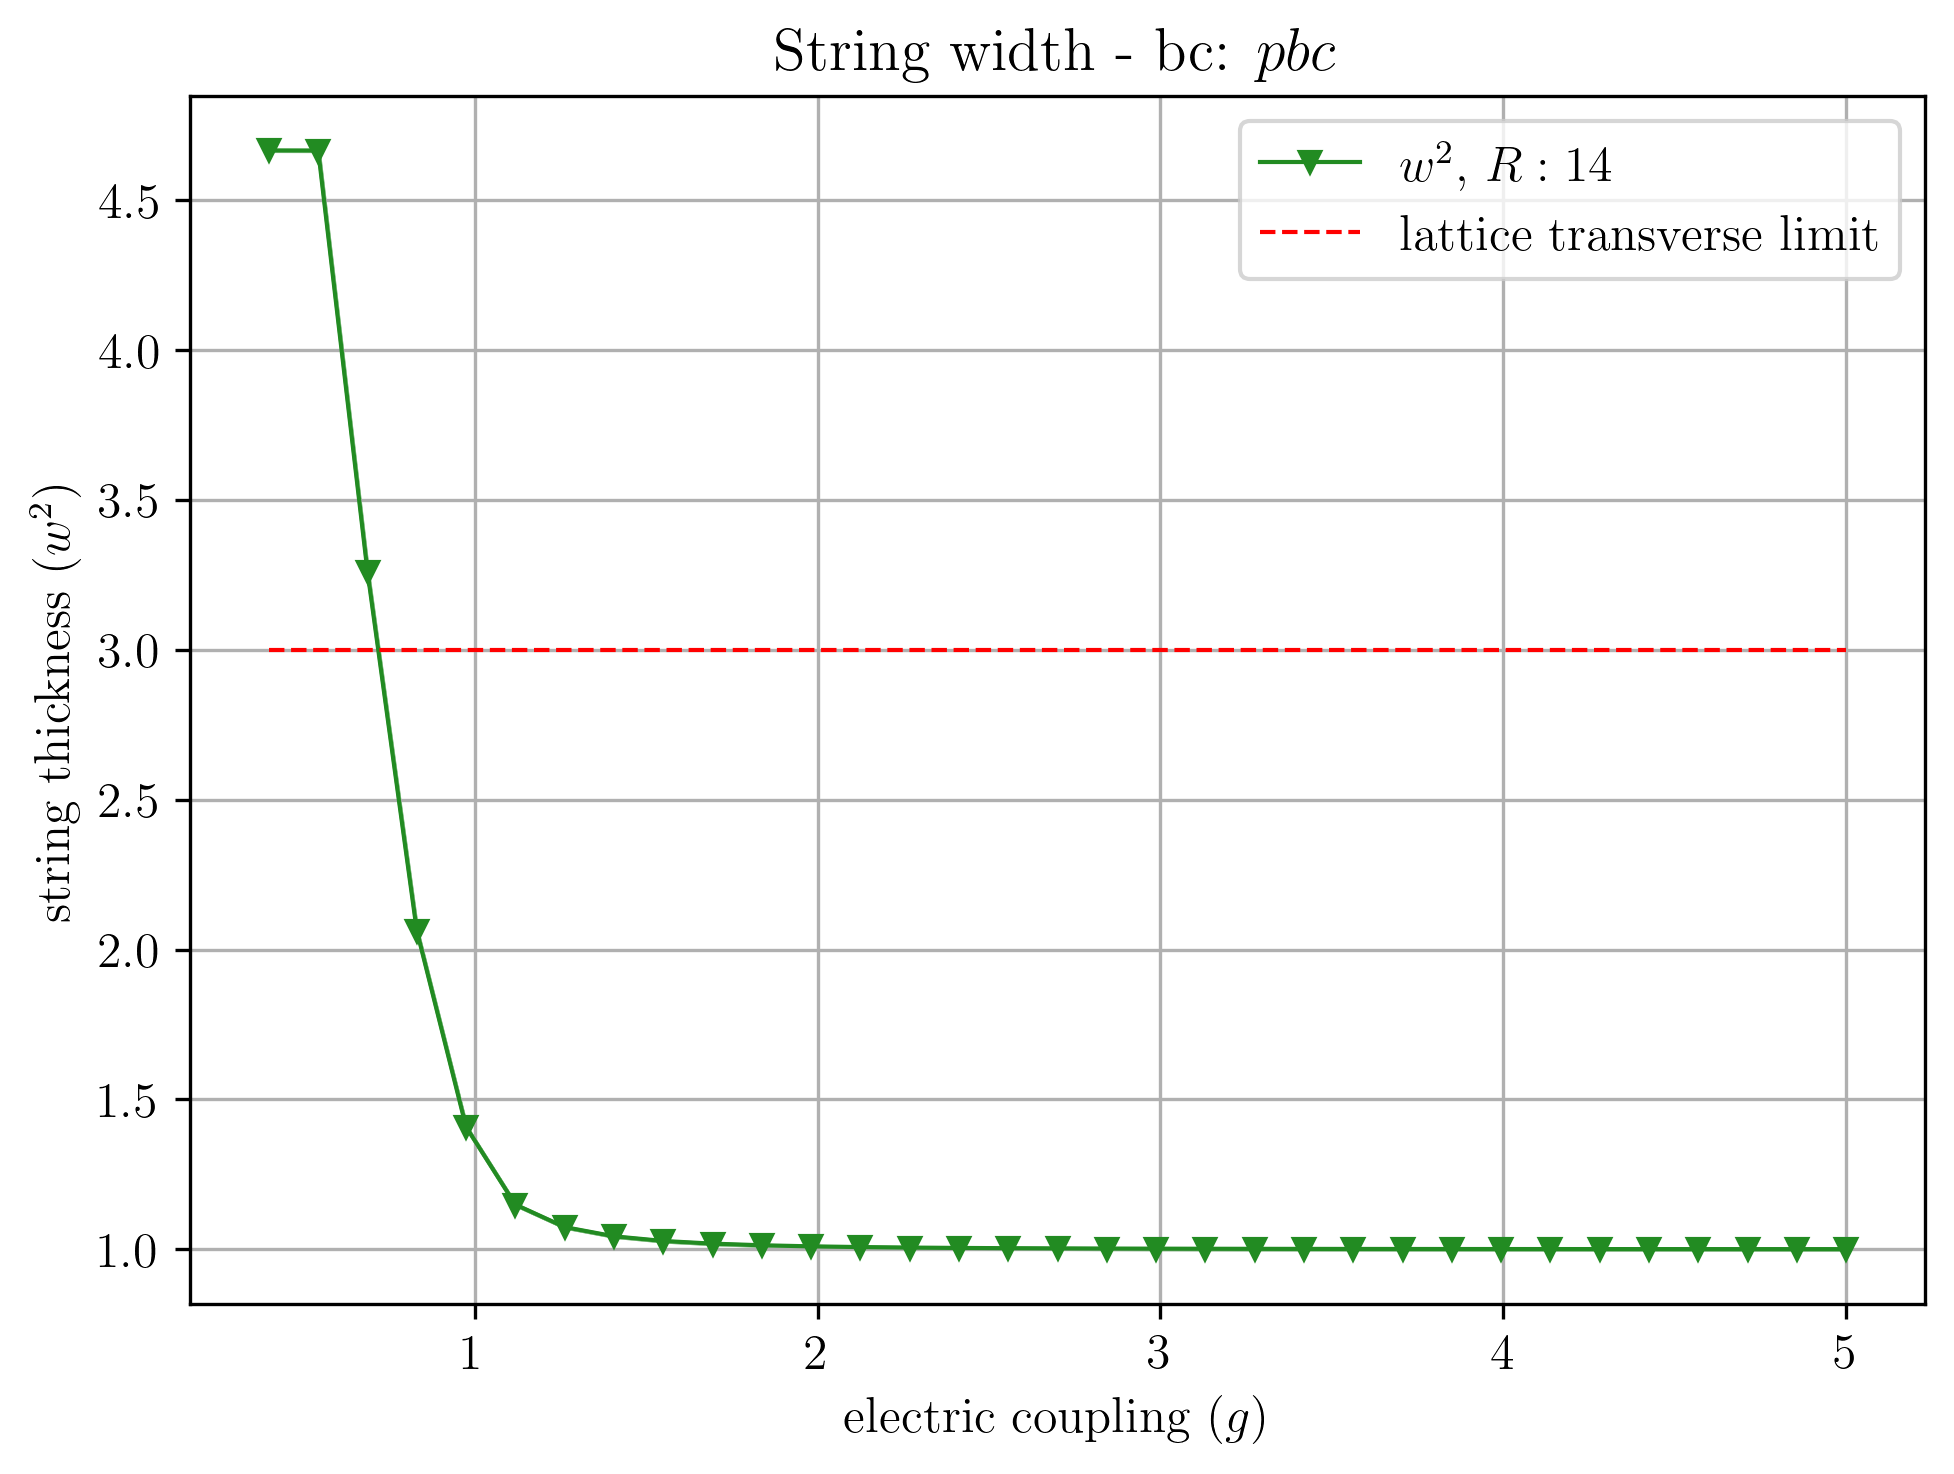

In [541]:
plt.plot(gs, ws, marker='v', markersize=5, color="forestgreen", linestyle="-", linewidth=1, label="$w^2$"+f", $R: {R}$")
plt.fill_between(gs, y1=np.asarray(ws)+np.asarray(err_ws),y2=np.asarray(ws)-np.asarray(err_ws), color="forestgreen", alpha=0.4)
plt.hlines(y=l/2, xmin=gs[0], xmax=gs[-1], colors="red", linestyles="--", linewidth=1, label="lattice transverse limit")
plt.title(f"String width - bc: ${bc}$")
plt.xlabel("electric coupling $(g)$")
plt.ylabel("string thickness $(w^2)$")
plt.grid(True)
plt.legend()


g: 0.6
g: 0.625
g: 0.65
g: 0.6749999999999999
g: 0.7
g: 0.725
g: 0.75
g: 0.7749999999999999
g: 0.7999999999999999
g: 0.825
g: 0.85
g: 0.875
g: 0.8999999999999999
g: 0.9249999999999999
g: 0.95
g: 0.6
g: 0.625
g: 0.65
g: 0.6749999999999999
g: 0.7
g: 0.725
g: 0.75
g: 0.7749999999999999
g: 0.7999999999999999
g: 0.825
g: 0.85
g: 0.875
g: 0.8999999999999999
g: 0.9249999999999999
g: 0.95
g: 0.6
g: 0.625
g: 0.65
g: 0.6749999999999999
g: 0.7
g: 0.725
g: 0.75
g: 0.7749999999999999
g: 0.7999999999999999
g: 0.825
g: 0.85
g: 0.875
g: 0.8999999999999999
g: 0.9249999999999999
g: 0.95
g: 0.4
g: 0.54375
g: 0.6875
g: 0.83125
g: 0.975
g: 1.11875
g: 1.2625
g: 1.40625
g: 1.5499999999999998
g: 1.69375
g: 1.8375
g: 1.9812499999999997
g: 2.125
g: 2.26875
g: 2.4124999999999996
g: 2.55625
g: 2.6999999999999997
g: 2.8437499999999996
g: 2.9875
g: 3.1312499999999996
g: 3.275
g: 3.4187499999999997
g: 3.5624999999999996
g: 3.70625
g: 3.8499999999999996
g: 3.9937499999999995
g: 4.1375
g: 4.28125
g: 4.425
g: 4.56875
g

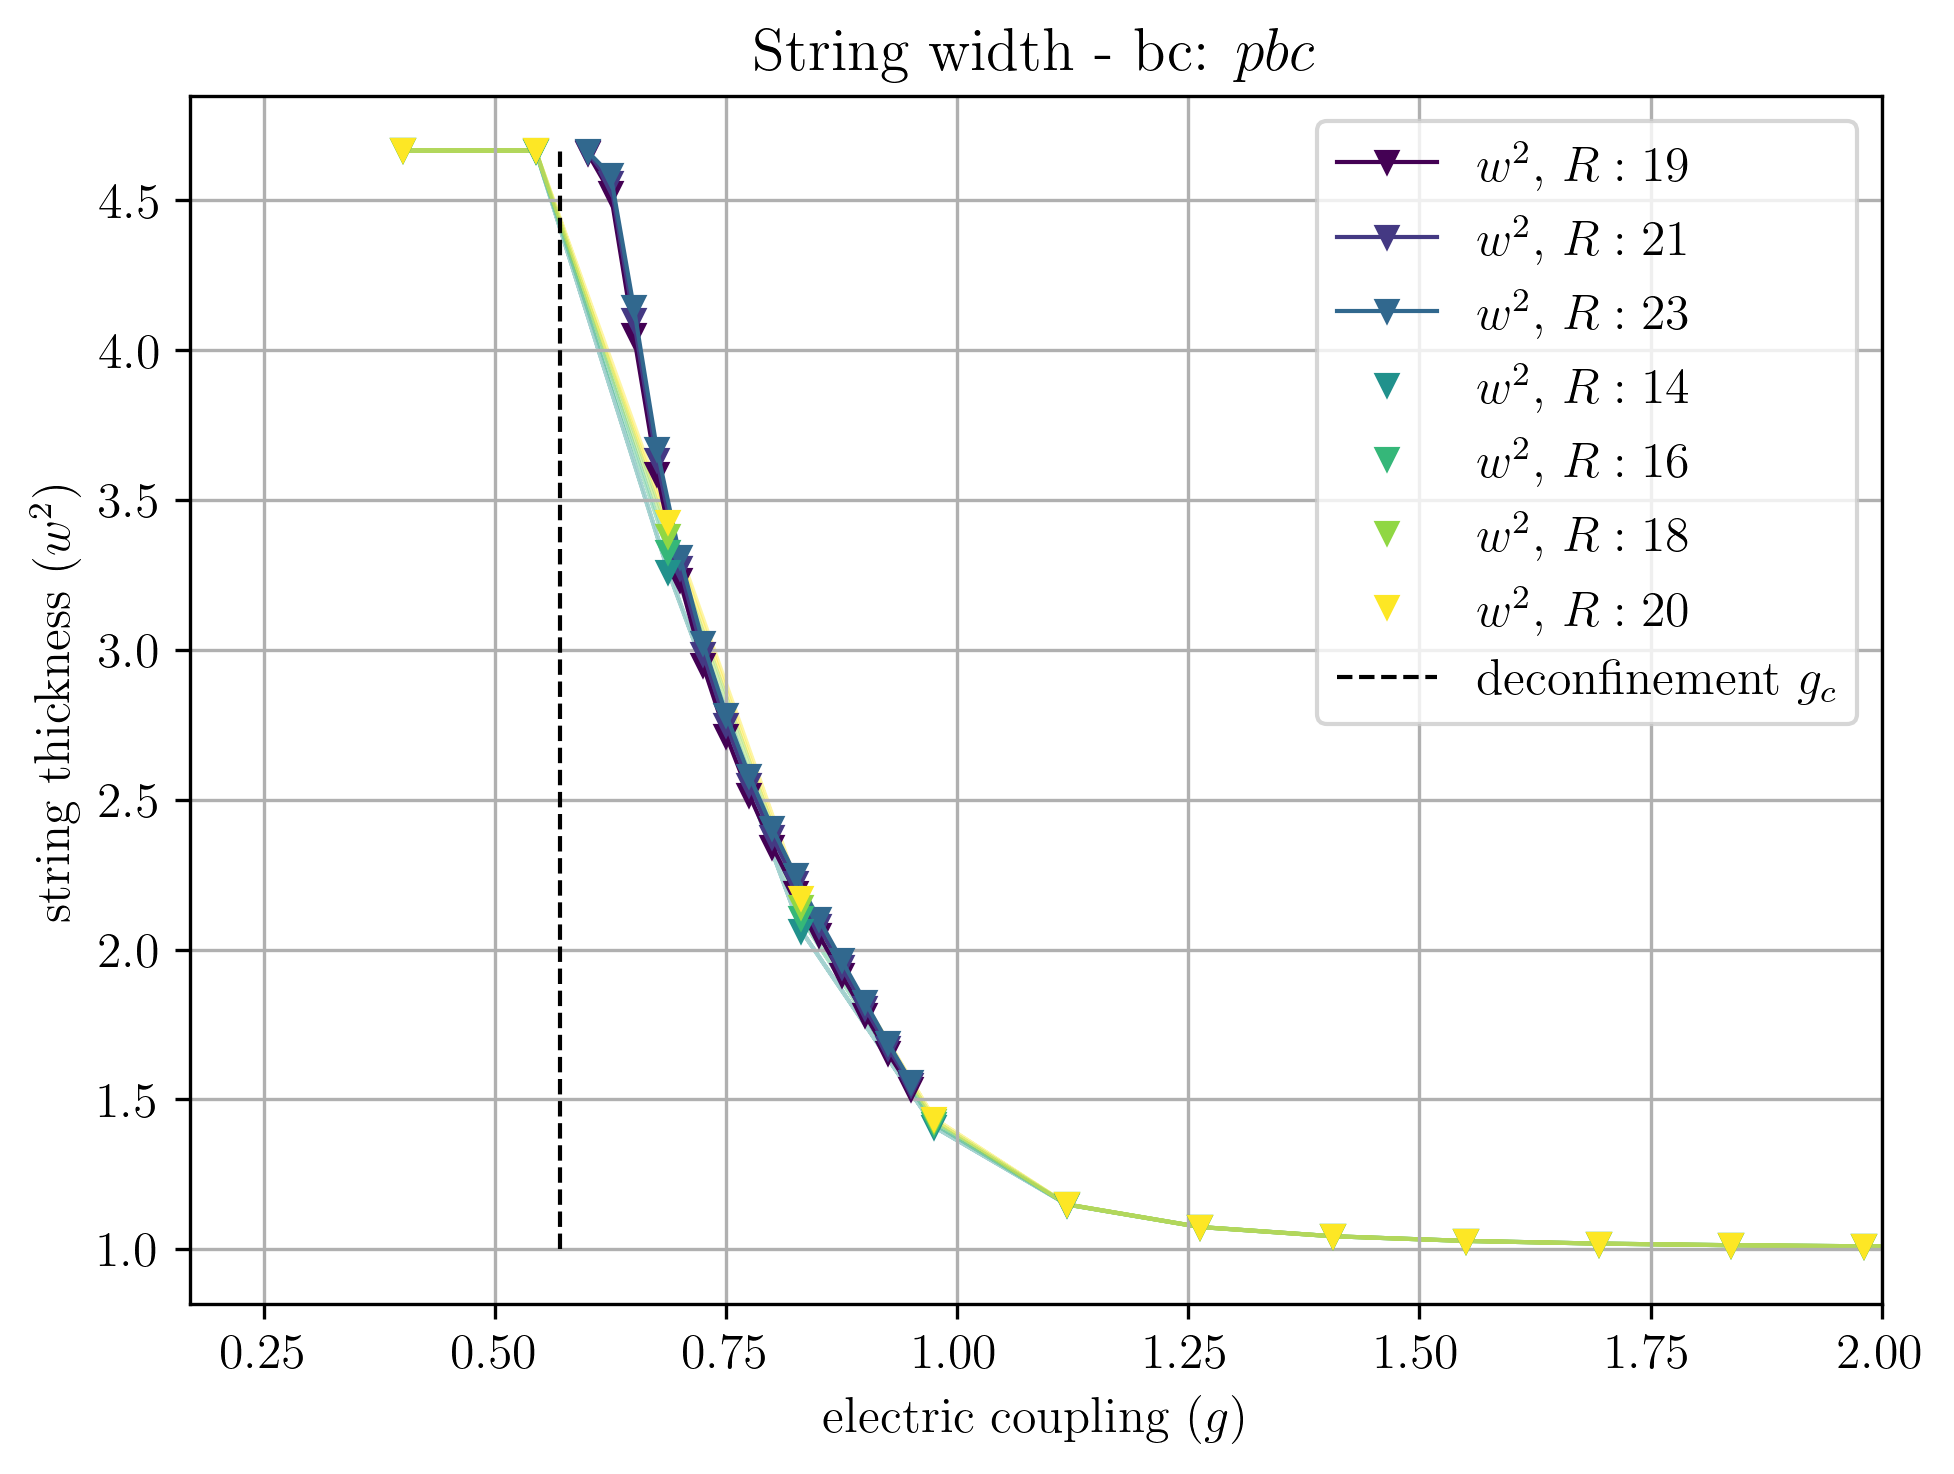

In [542]:
Rs = [19,21,23]
Rss = [14,16,18,19,20,21,23]

h_i, h_f, npoints = 0.6, 0.95, 15
gs = np.linspace(h_i,h_f,npoints)
colors = create_sequential_colors(len(Rss))
for i, R in enumerate(Rs):
    ws, err_ws = string_width_varying_g(gs,R,l,L,chis,bc,sector,h_i,h_f,npoints,path_tensor)
    plt.plot(gs, ws, marker='v', markersize=5, color=colors[i], linestyle="-", linewidth=1, label="$w^2$"+f", $R: {R}$")
    # plt.fill_between(gs, y1=np.asarray(ws)+np.asarray(err_ws),y2=np.asarray(ws)-np.asarray(err_ws), color=colors[i], alpha=0.4)

h_i, h_f, npoints = 0.4, 5.0, 33
gs = np.linspace(h_i,h_f,npoints)
chis = [32,64,128]
Rs = [14,16,18,20]
l = 6
for j, R in enumerate(Rs):    
    ws, err_ws = string_width_varying_g(gs,R,l,L,chis,bc,sector,h_i,h_f,npoints,path_tensor)
    plt.plot(gs, ws, marker='v', markersize=5, color=colors[i+j+1], linestyle="", linewidth=1, label="$w^2$"+f", $R: {R}$")
    plt.fill_between(gs, y1=np.asarray(ws)+np.asarray(err_ws),y2=np.asarray(ws)-np.asarray(err_ws), color=colors[i+j+1], alpha=0.4)

# ws, err_ws = string_width_varying_g(gs,R,l,L,chis,bc,sector,h_i,h_f,npoints,path_tensor)
# plt.plot(gs, ws, marker='v', markersize=5, color="forestgreen", linestyle="", linewidth=1, label="$w^2$"+f", $R: {R}$")
# plt.fill_between(gs, y1=np.asarray(ws)+np.asarray(err_ws),y2=np.asarray(ws)-np.asarray(err_ws), color="forestgreen", alpha=0.4)
# plt.hlines(y=l/2, xmin=gs[0], xmax=gs[-1], colors="red", linestyles="--", linewidth=1, label="lattice transverse limit")
plt.vlines(x=0.57, ymin=1, ymax=max(ws), linestyles="--", colors='black', linewidth=1, label="deconfinement $g_c$")

plt.title(f"String width - bc: ${bc}$")
plt.xlabel("electric coupling $(g)$")
plt.ylabel("string thickness $(w^2)$")
plt.grid(True)
# plt.xscale("log")
plt.xlim(right=2)
plt.legend()

g: 0.6
g: 0.625
g: 0.65
g: 0.6749999999999999
g: 0.7
g: 0.725
g: 0.75
g: 0.7749999999999999
g: 0.7999999999999999
g: 0.825
g: 0.85
g: 0.875
g: 0.8999999999999999
g: 0.9249999999999999
g: 0.95
g: 0.6
g: 0.625
g: 0.65
g: 0.6749999999999999
g: 0.7
g: 0.725
g: 0.75
g: 0.7749999999999999
g: 0.7999999999999999
g: 0.825
g: 0.85
g: 0.875
g: 0.8999999999999999
g: 0.9249999999999999
g: 0.95
g: 0.6
g: 0.625
g: 0.65
g: 0.6749999999999999
g: 0.7
g: 0.725
g: 0.75
g: 0.7749999999999999
g: 0.7999999999999999
g: 0.825
g: 0.85
g: 0.875
g: 0.8999999999999999
g: 0.9249999999999999
g: 0.95
g: 0.4
g: 0.54375
g: 0.6875
g: 0.83125
g: 0.975
g: 1.11875
g: 1.2625
g: 1.40625
g: 1.5499999999999998
g: 1.69375
g: 1.8375
g: 1.9812499999999997
g: 2.125
g: 2.26875
g: 2.4124999999999996
g: 2.55625
g: 2.6999999999999997
g: 2.8437499999999996
g: 2.9875
g: 3.1312499999999996
g: 3.275
g: 3.4187499999999997
g: 3.5624999999999996
g: 3.70625
g: 3.8499999999999996
g: 3.9937499999999995
g: 4.1375
g: 4.28125
g: 4.425
g: 4.56875
g

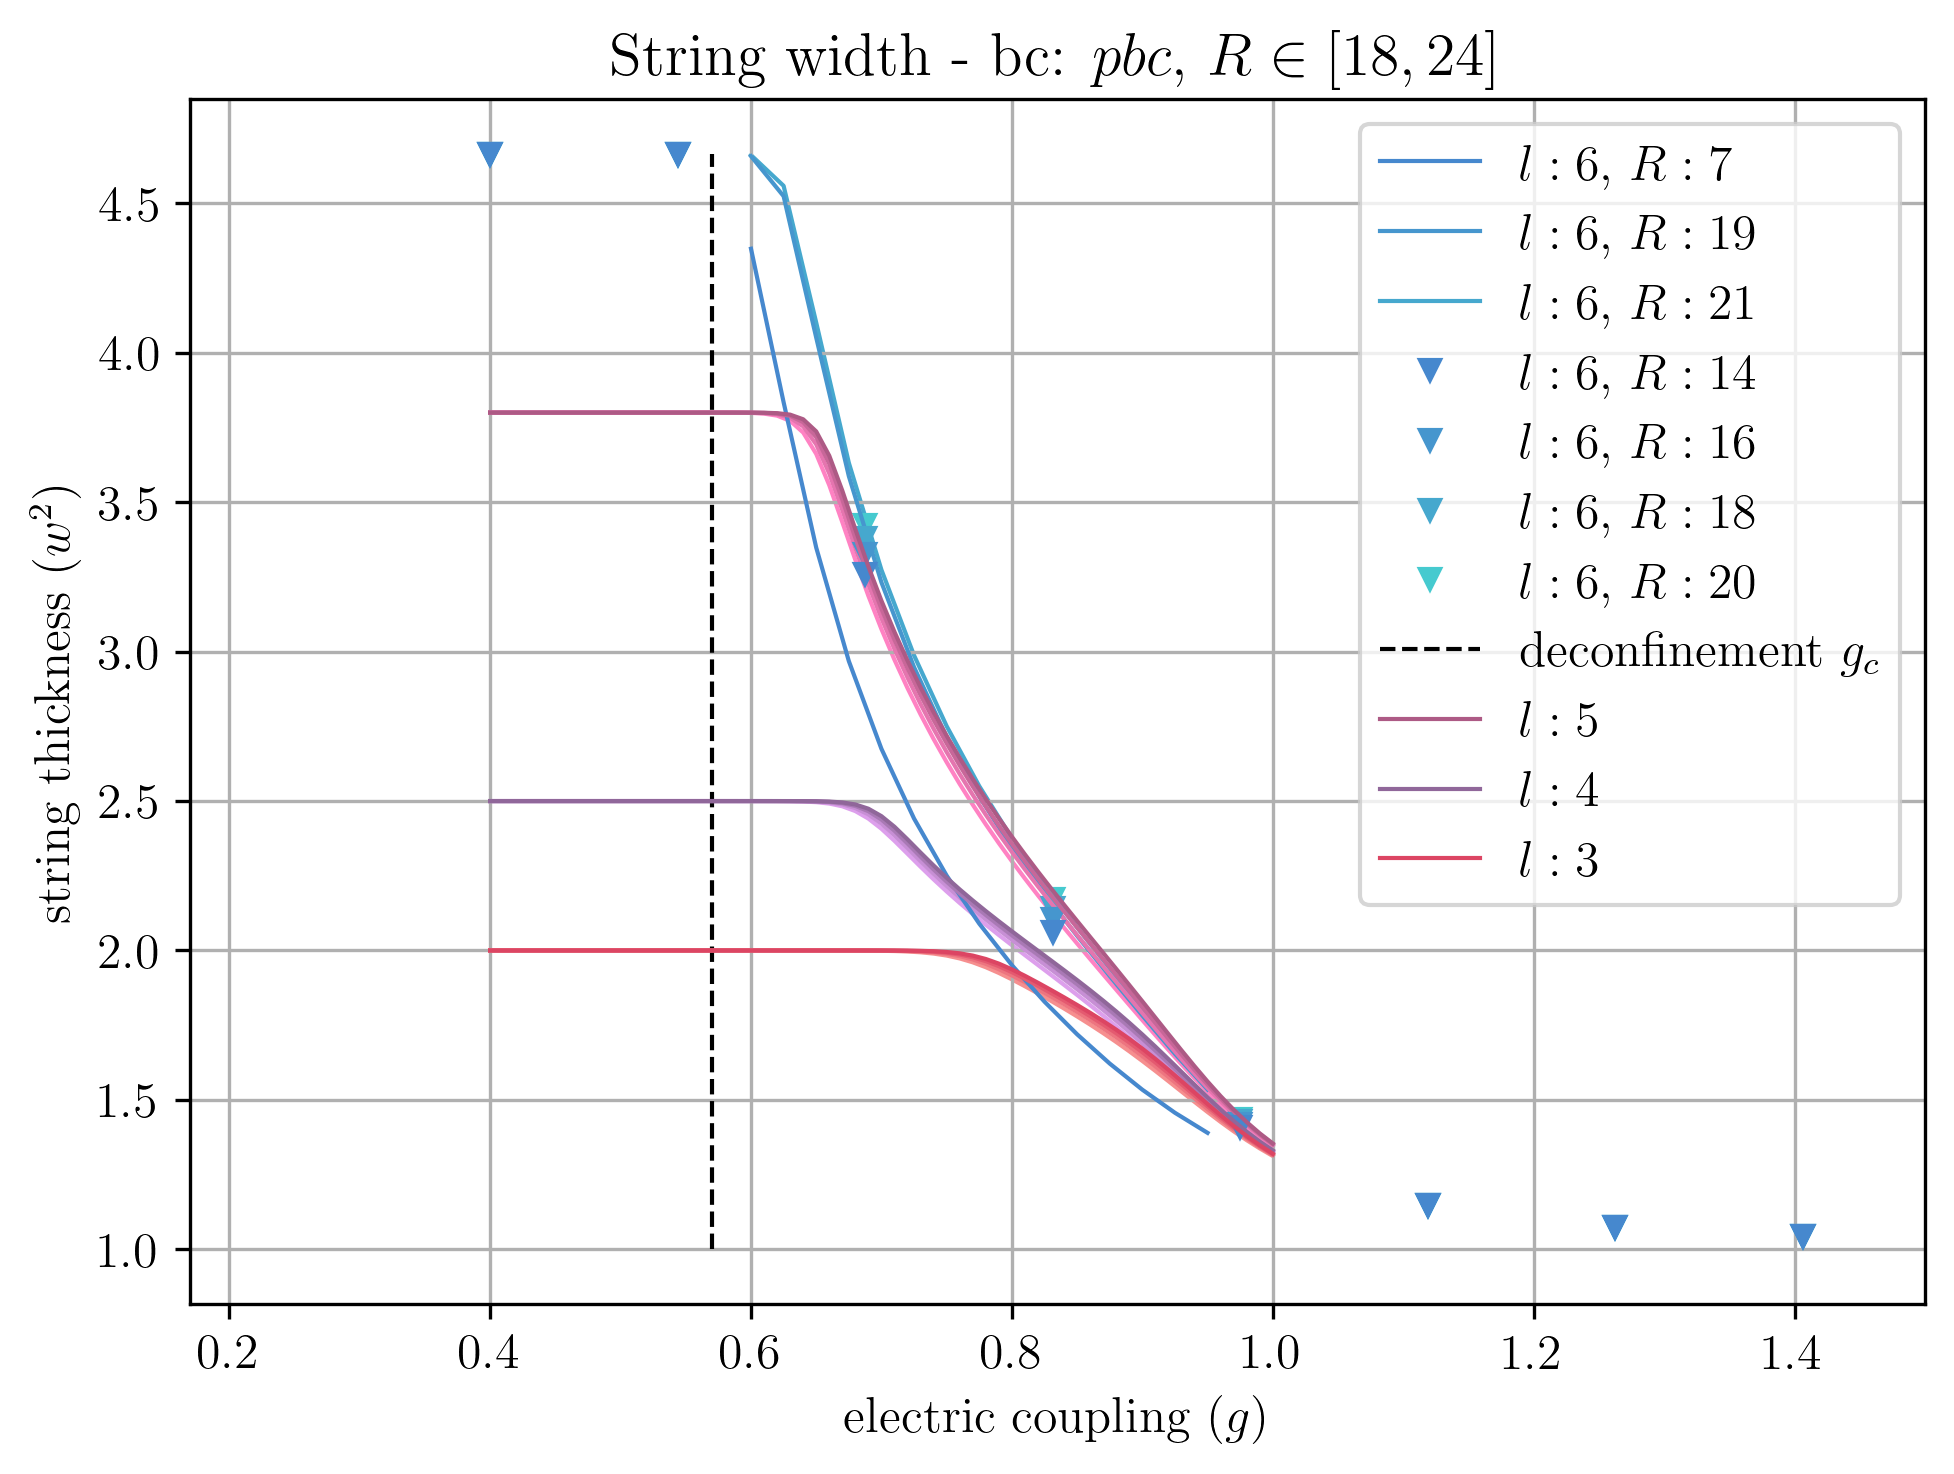

In [543]:
colors = ["#4688CE","#4696CE","#46A8CE","#46CACF"]
Rs = [19,21,23]
Rs.reverse()
h_i, h_f, npoints = 0.6, 0.95, 15
gs = np.linspace(h_i,h_f,npoints)
bc = "pbc"
sector = "2_particle(s)_sector"
l = 6
L = 30
Ls = [30]
chis = [64,128]
Rs = [7,19,21]

for i, R in enumerate(Rs):
    ws, err_ws = string_width_varying_g(gs,R,l,L,chis,bc,sector,h_i,h_f,npoints,path_tensor)
    plt.plot(gs, ws, markersize=5, color=colors[i], linestyle="-", linewidth=1, label=f"$l: {l}$, $R: {R}$", zorder=len(Rs)-i)
    # plt.fill_between(gs, y1=np.asarray(ws)+np.asarray(err_ws),y2=np.asarray(ws)-np.asarray(err_ws), color=colors[i], alpha=0.4)

h_i, h_f, npoints = 0.4, 5.0, 33
gs = np.linspace(h_i,h_f,npoints)
chis = [32,64,128]
Rs = [14,16,18,20]
l = 6
for i, R in enumerate(Rs):
    ws, err_ws = string_width_varying_g(gs,R,l,L,chis,bc,sector,h_i,h_f,npoints,path_tensor)
    plt.plot(gs, ws, marker='v', markersize=5, color=colors[i], linestyle="", linewidth=0, label=f"$l: {l}$, $R: {R}$", zorder=len(Rs)-i)
    # plt.fill_between(gs, y1=np.asarray(ws)+np.asarray(err_ws),y2=np.asarray(ws)-np.asarray(err_ws), color=colors[i+j+1], alpha=0.4)

plt.vlines(x=0.57, ymin=1, ymax=max(ws), linestyles="--", colors='black', linewidth=1, label="deconfinement $g_c$")

chis = [32,64]
Rs = [18,20,22,24]
Rs.reverse()
# colorss = [["#4688CE","#4696CE","#46A8CE","#46CACF"],["#9B4DB7","#BC4FBE","#CC50C2","#DC51C5"],["#DC4563","#E45A70","#ED7580","#F68F8F"]]
colorss = [["#AD5A85","#C86799","#E575AF","#FF82C3"],["#90679A","#A979B5","#C78FD5","#DD9FEC"],["#DC4563","#E45A70","#ED7580","#F68F8F"]]
ls = [5,4,3]
h_i, h_f, npoints = 0.4, 1.0, 61
gs = np.linspace(h_i,h_f,npoints)
for colors, l in zip(colorss, ls):
    for i, R in enumerate(Rs):
        ws, err_ws = string_width_varying_g(gs,R,l,L,chis,bc,sector,h_i,h_f,npoints,path_tensor)
        if R == 24:
            label = f"$l: {l}$"
        else: 
            label = None
        plt.plot(gs, ws, markersize=2, color=colors[i], linestyle="-", linewidth=1, label=label, zorder=len(Rs)-i)
        # plt.fill_between(gs, y1=np.asarray(ws)+np.asarray(err_ws),y2=np.asarray(ws)-np.asarray(err_ws), color=colors[i], alpha=0.4, zorder=len(Rs)-i)

Rs.reverse()
plt.title(f"String width - bc: ${bc}$, $R \in [{Rs[0]},{Rs[-1]}]$")
plt.xlabel("electric coupling $(g)$")
plt.ylabel("string thickness $(w^2)$")
plt.grid(True)
# plt.xscale("log")
plt.xlim(right=1.5)
plt.legend()

In [ ]:
from scipy.optimize import curve_fit
Rs = [10,11,12,13,14,15,16,17,18,19]
h_i, h_f, npoints = 0.75, 0.75, 1
g = 0.75
l = 7
chis = [128,256,512]
# colors = ["#4688CE","#4696CE","#46A8CE","#46CACF"]

ws, err_ws = string_width_varying_R(g,Rs,l,L,chis,bc,sector,h_i,h_f,npoints,path_tensor)
plt.plot(Rs, ws, 'x',  label=f"data crossover $g: {g}$")
# plt.fill_between(Rs, y1=np.asarray(ws)+np.asarray(err_ws),y2=np.asarray(ws)-np.asarray(err_ws), color=colors[i], alpha=0.4)

x_data = Rs
y_data = ws
string_tension, string_tension_err = get_fit_params([g], Rs, l, Ls, chis, bc, sector, h_i, h_f, npoints, path_tensor, fit=1, param=0)

def log_func(x,a,b):
    return a*np.log(x)+b

popt, cov = curve_fit(log_func, x_data, y_data)
errs = np.sqrt(np.diag(cov))
print(f"a: {popt[0]/2}±{errs[0]/2},   const: {1/(2*np.pi*string_tension[0])}")
print(f"b: {popt[1]},   R_UV: {np.exp(-popt[1]/popt[0])}")

xs = np.linspace(10,20)
plt.plot(xs,log_func(xs,popt[0],popt[1]), linestyle="-", linewidth=1, label="fit")

gs = [1.5, 5.0]
l = 6
chis = [32,64,128]
Rs = [14,16,18,20]
colors = ["#FFD723","#FDB149","#46A8CE","#46CACF"]

for i, g in enumerate(gs):
    ws, err_ws = string_width_varying_R(g,Rs,l,L,chis,bc,sector,g,g,npoints,path_tensor)
    plt.plot(Rs, ws, 'p', linestyle='-', color=colors[i], label=f"data confined $g: {g}$")

plt.title("String width $vs$ $R$")
plt.xlabel("string length $(R)$")
plt.ylabel("string width $(w^2)$")
plt.legend()

In [ ]:
np.linspace(0.4,5,33)

In [ ]:
from scipy.optimize import curve_fit
Rs = [18,20,22,24]
h_i, h_f, npoints = 0.4, 1.0, 61
gs = np.linspace(h_i,h_f,npoints)
l = 5
chis = [32, 64]

fit_param = []
fit_param_err = []
univ_term = []
for g in gs:
    ws, err_ws = string_width_varying_R(g,Rs,l,L,chis,bc,sector,h_i,h_f,npoints,path_tensor)

    x_data = Rs
    y_data = ws
    string_tension, string_tension_err = get_fit_params([g], Rs, l, Ls, chis, bc, sector, h_i, h_f, npoints, path_tensor, fit=1, param=0)

    def log_func(x,a,b):
        return a*np.log(x)+b

    popt, cov = curve_fit(log_func, x_data, y_data)
    errs = np.sqrt(np.diag(cov))
    fit_param.append(popt[0])
    fit_param_err.append(errs[0])
    univ_term.append(1/(2*np.pi*string_tension[0]))

plt.plot(gs,fit_param, 'x', label="data", zorder=0)
plt.fill_between(gs, y1=np.asarray(fit_param)+np.asarray(fit_param_err),y2=np.asarray(fit_param)-np.asarray(fit_param_err), alpha=0.4, zorder=0)
plt.plot(gs, univ_term, linestyle="-", linewidth=1, label="universal term", zorder=1)

plt.title("Universal term of the string width")
plt.xlabel("electric coupling $(g)$")
plt.ylabel("universal term $(w^2)$")
plt.legend()
plt.ylim(0,0.4)

## Crossover Observable

In [ ]:
# sigmas, sigmas_err = fit_string_tension(gs,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor)
sigmas, sigmas_err = potential_first_discrete_derivative_varying_g(gs,R,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor)
ws, ws_err = string_width_varying_g(gs,R,l,L,chis,bc,sector,h_i,h_f,npoints,path_tensor)
crossover_obs = (np.asarray(sigmas) * np.asarray(ws))**(-1)
crossover_obs_err = np.sqrt((np.asarray(sigmas_err)**2/np.asarray(sigmas)) + (np.asarray(ws_err)**2/np.asarray(ws))) / (np.asarray(sigmas) * np.asarray(ws))
 

In [ ]:
plt.plot(gs, crossover_obs, marker='v', markersize=5, color="darkorchid", linestyle="-", linewidth=1, label="$(\sigma w^2)^{-1}$"+f", $R: {R}$")
plt.fill_between(gs, y1=crossover_obs+crossover_obs_err,y2=crossover_obs-crossover_obs_err, color="darkorchid", alpha=0.4)
plt.title(f"Spreading of fluctuations - bc: ${bc}$")
plt.xlabel("electric coupling $(g)$")
plt.ylabel("string tension spreading $(\\sigma w^2)^{-1}$")
plt.grid(True)
plt.legend()
# plt.yscale('log')
print(crossover_obs[-1])

# Entropy

In [562]:
# free param
chi = 128
L = 30
Rs = [18,20,22,24]
R = 18
# secondary fixed params
bc = "pbc"
# npoints, h_i, h_f = 30, 0.8, 1.0
npoints, h_i, h_f = 61, 0.4, 1.0
interval = np.linspace(h_i,h_f,npoints)
gs = interval
sector = "2_particle(s)_sector"
# fixed params
l = 4

In [563]:
s = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path_tensor)

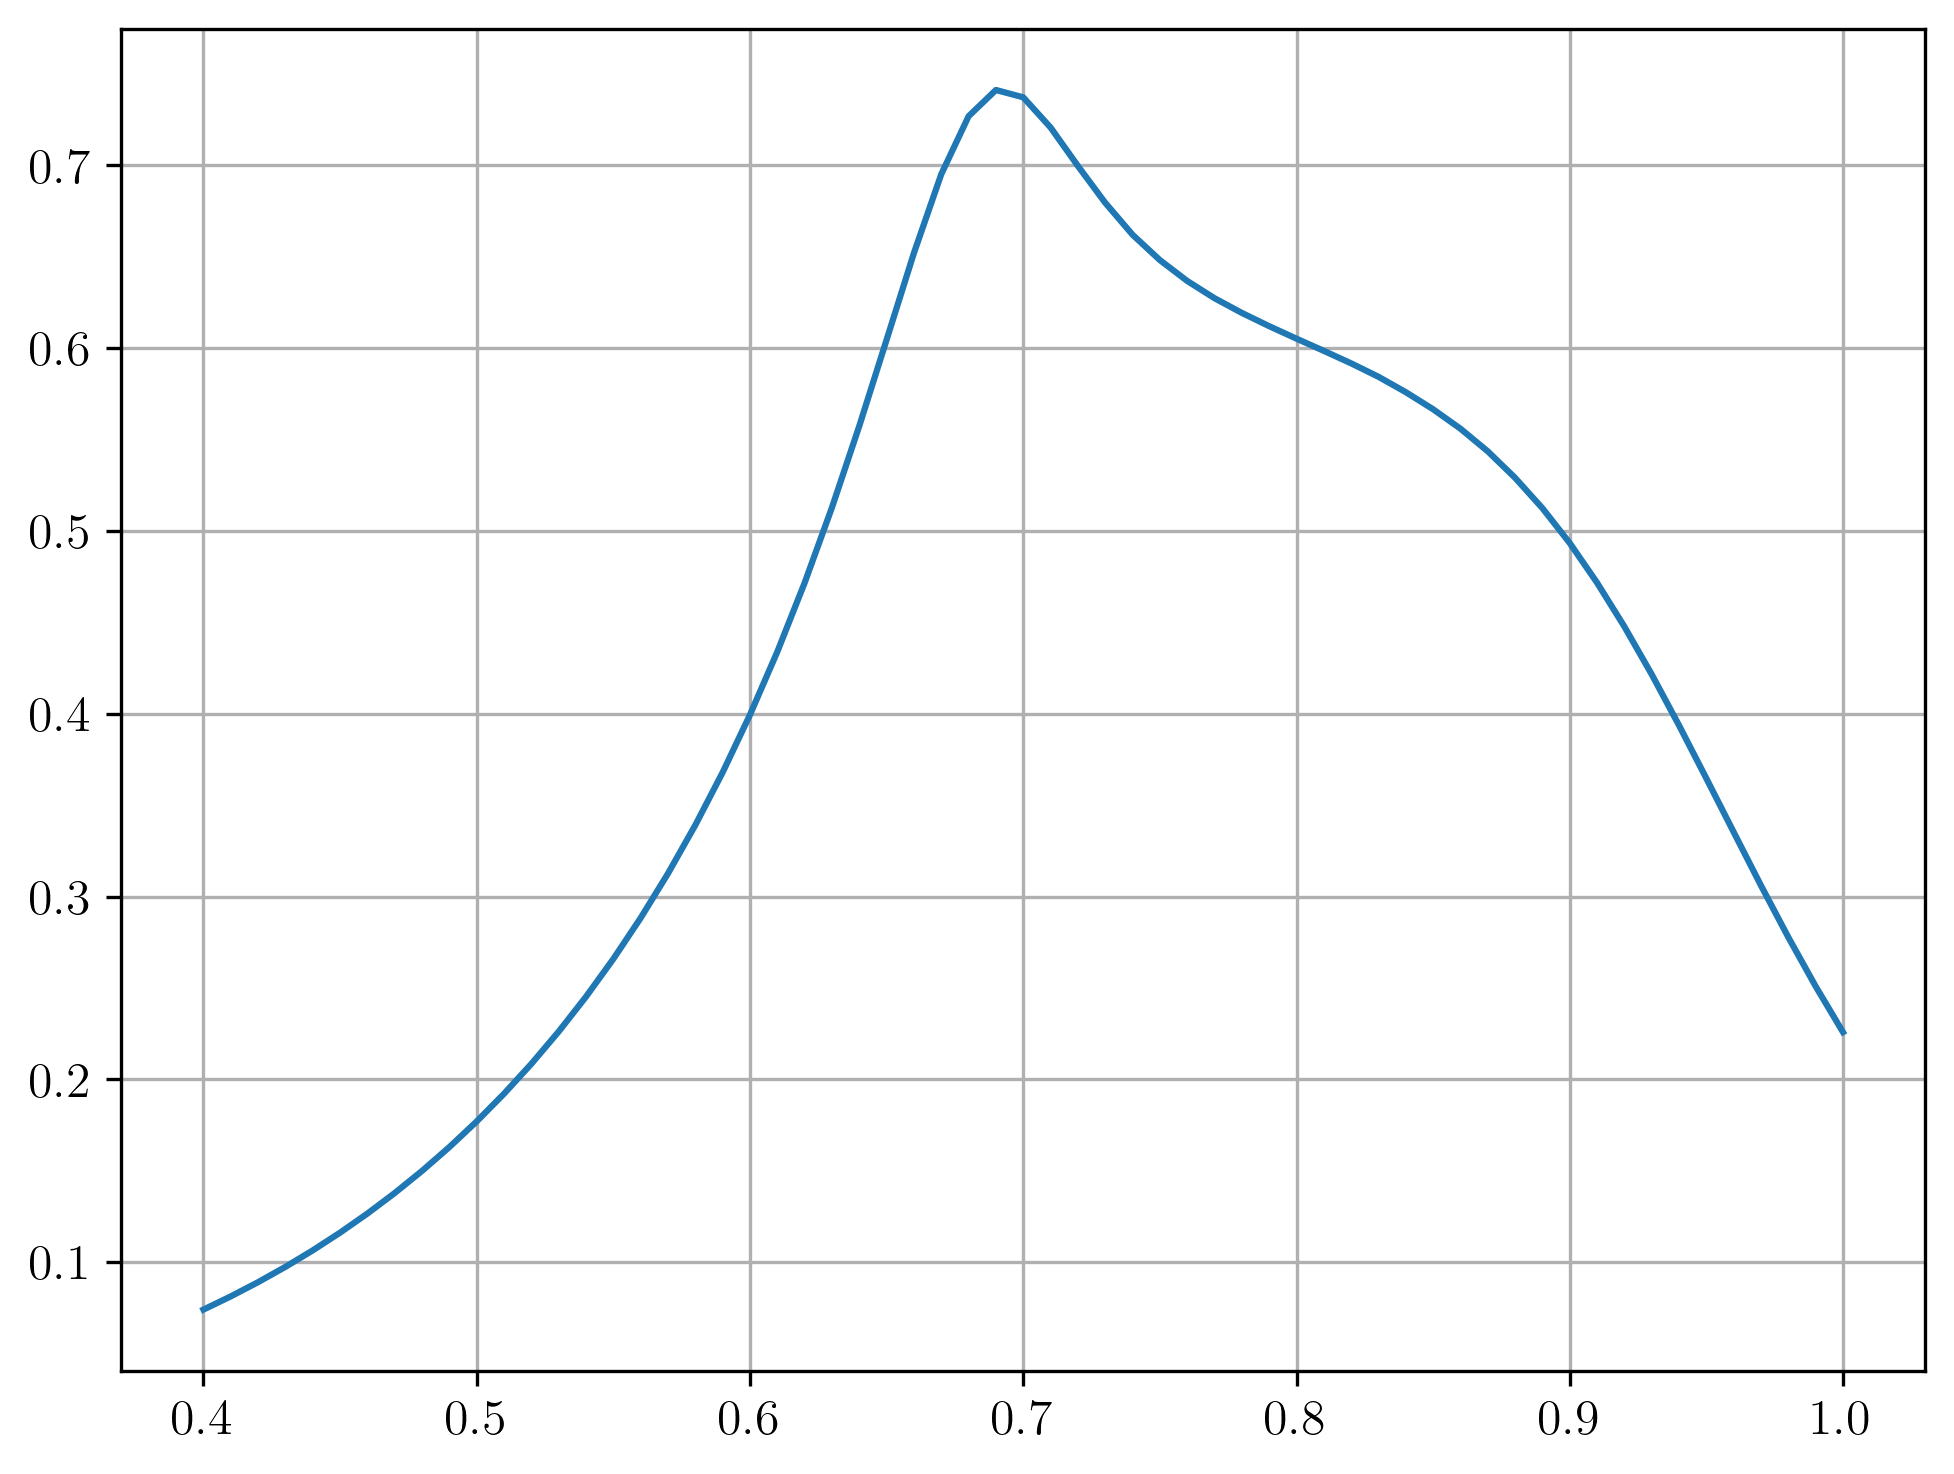

In [564]:
plt.plot(gs,s)
plt.grid(True)

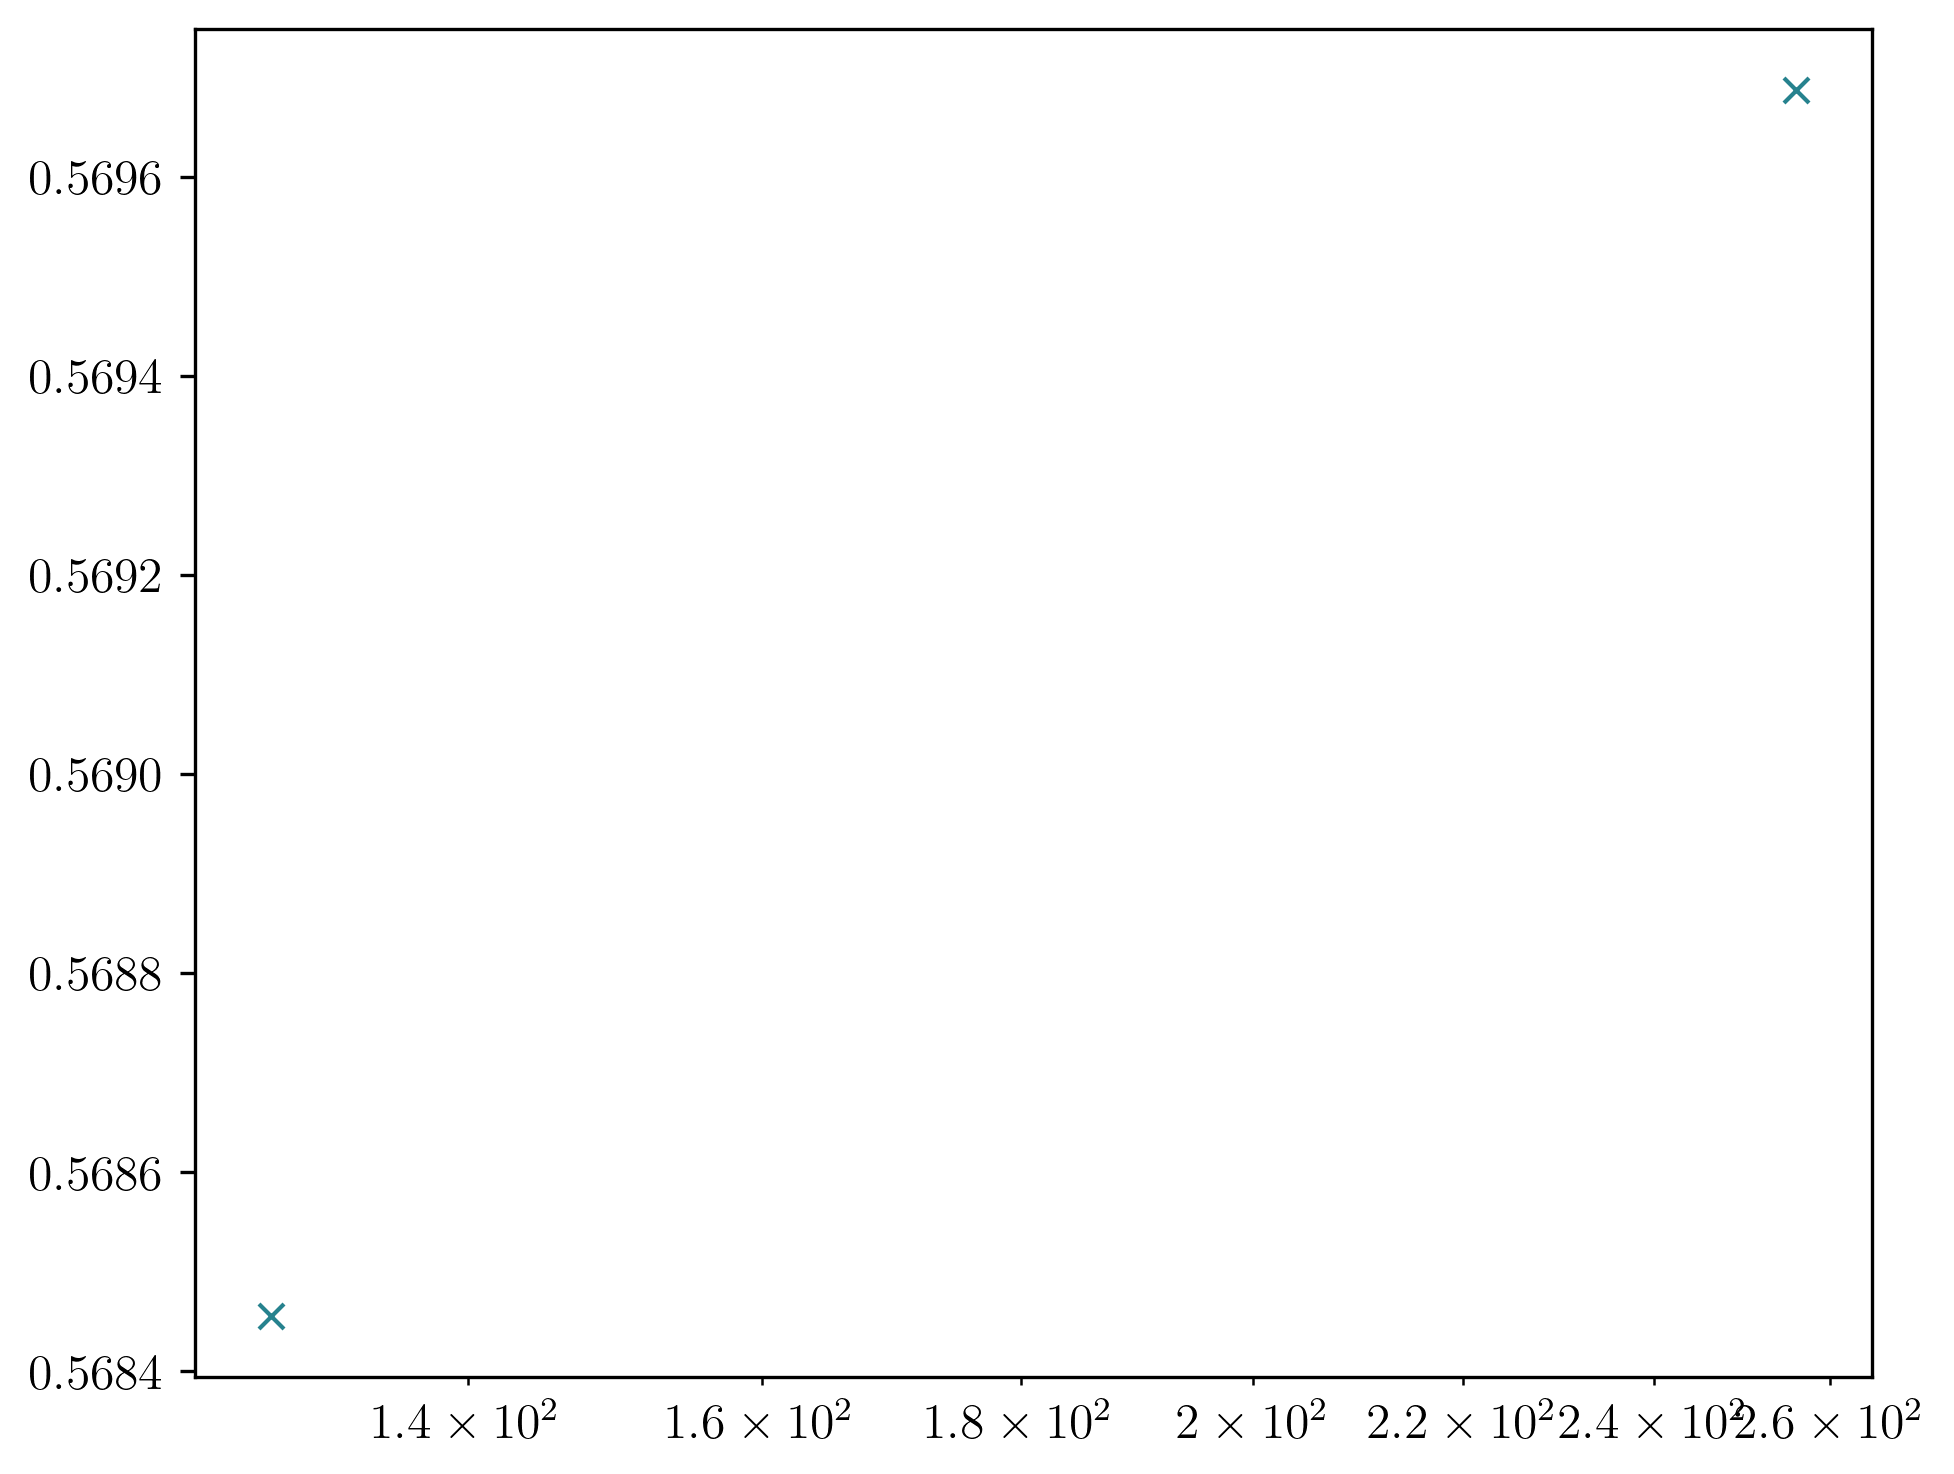

In [565]:
npoints, h_i, h_f = 1, 0.75, 0.75
interval = np.linspace(h_i,h_f,npoints)
gs = interval
l = 6
chis = [128,256,512]
chis = [128,256]
Rs = [10,11,12,13,14,15,16,17,18,19]
i = -6
colors = create_sequential_colors(len(Rs))
R = Rs[i]
s_chi = []
for chi in chis:
    s = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path_tensor)
    plt.plot(chi, s, 'x', color=colors[i])
plt.xscale('log')

The entropy for $l=7$ is far from convergence for every $R$

In [ ]:
colors = ["yellowgreen", "darkcyan", "firebrick", "darkorchid"]
colorss = [["#4688CE","#4696CE","#46A8CE","#46CACF"],["#AD5A85","#C86799","#E575AF","#FF82C3"],["#90679A","#A979B5","#C78FD5","#DD9FEC"],["#DC4563","#E45A70","#ED7580","#F68F8F"]]
colorss.reverse()

chi = 128
npoints, h_i, h_f = 61, 0.4, 1.0
interval = np.linspace(h_i,h_f,npoints)
gs = interval
ls = [5]
L = 30
R_vac = 0
R = 18
Rs = [18, 20, 22, 24]
sector_vac = "vacuum_sector"
sector = "2_particle(s)_sector"
# cx = None
# cy = None

for i, l in enumerate(ls):
    # bc = "obc"
    # s_obc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path_tensor)
    bc = "pbc"
    # s_vac = entropy(R_vac,l,L,chi,bc,sector_vac,h_i,h_f,npoints,path_tensor)
    for chi in chis:
        s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path_tensor)
        # plt.plot(gs,s_obc, marker="p", color=colors[i], linewidth=1, markersize=5, linestyle='-', label=f"$l \\times L: {l}\\times{L}$")
        # plt.plot(gs,s_pbc, color=colors[i], linewidth=1, markersize=5, linestyle='--', label=f"$l: {l}$")
        plt.plot(gs,s_pbc, color=colorss[i][0], linewidth=1, markersize=5, linestyle='-', label=f"$l: {l}, \chi: {chi}$")
    # plt.plot(gs,s_vac, color=colors[i], linewidth=1, markersize=5, linestyle='-', label=f"vacuum $l: {l}$")


# free param
chi = 128
L = 30
# secondary fixed params
bc = "pbc"
# npoints, h_i, h_f = 30, 0.8, 1.0
npoints, h_i, h_f = 33, 0.4, 5.0
npoints, h_i, h_f = 21, 0.6, 0.8
interval = np.linspace(h_i,h_f,npoints)
gs = interval

# fixed params
l = 6
i = 3

# bc = "obc"
# s_obc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path_tensor)
# s_vac = entropy(R_vac,l,L,chi,bc,sector_vac,h_i,h_f,npoints,path_tensor)
bc = "pbc"
chis = [32,64,128]
for chi in chis:
    s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path_tensor)
    # plt.plot(gs,s_obc, marker="p", color=colors[i], linewidth=1, markersize=5, linestyle='-', label=f"$l: {l}$")
    # plt.plot(gs,s_pbc, color=colors[i], linewidth=1, markersize=5, linestyle='--', label=f"$l: {l}$")
    plt.plot(gs,s_pbc, color=colorss[i][0], linewidth=1, markersize=5, linestyle='-', label=f"$l: {l}, \chi: {chi}$")
# plt.plot(gs,s_vac, color=colors[i], linewidth=1, markersize=5, linestyle='-', label=f"vacuum $l: {l}$")
plt.vlines(x=0.57, ymin=0, ymax=1, linestyles="--", colors='black', linewidth=1, label="deconfinement $g_c$")

plt.title("Entropy of the string sector")
plt.xlabel("electric coupling $(g)$")
plt.ylabel("von Neumann Entropy $(S_{vN})$")
plt.legend()
# plt.legend(fontsize=10)
# plt.xlim(right=1)
# plt.grid(True)

we search for g=0.8
we search for g=0.8


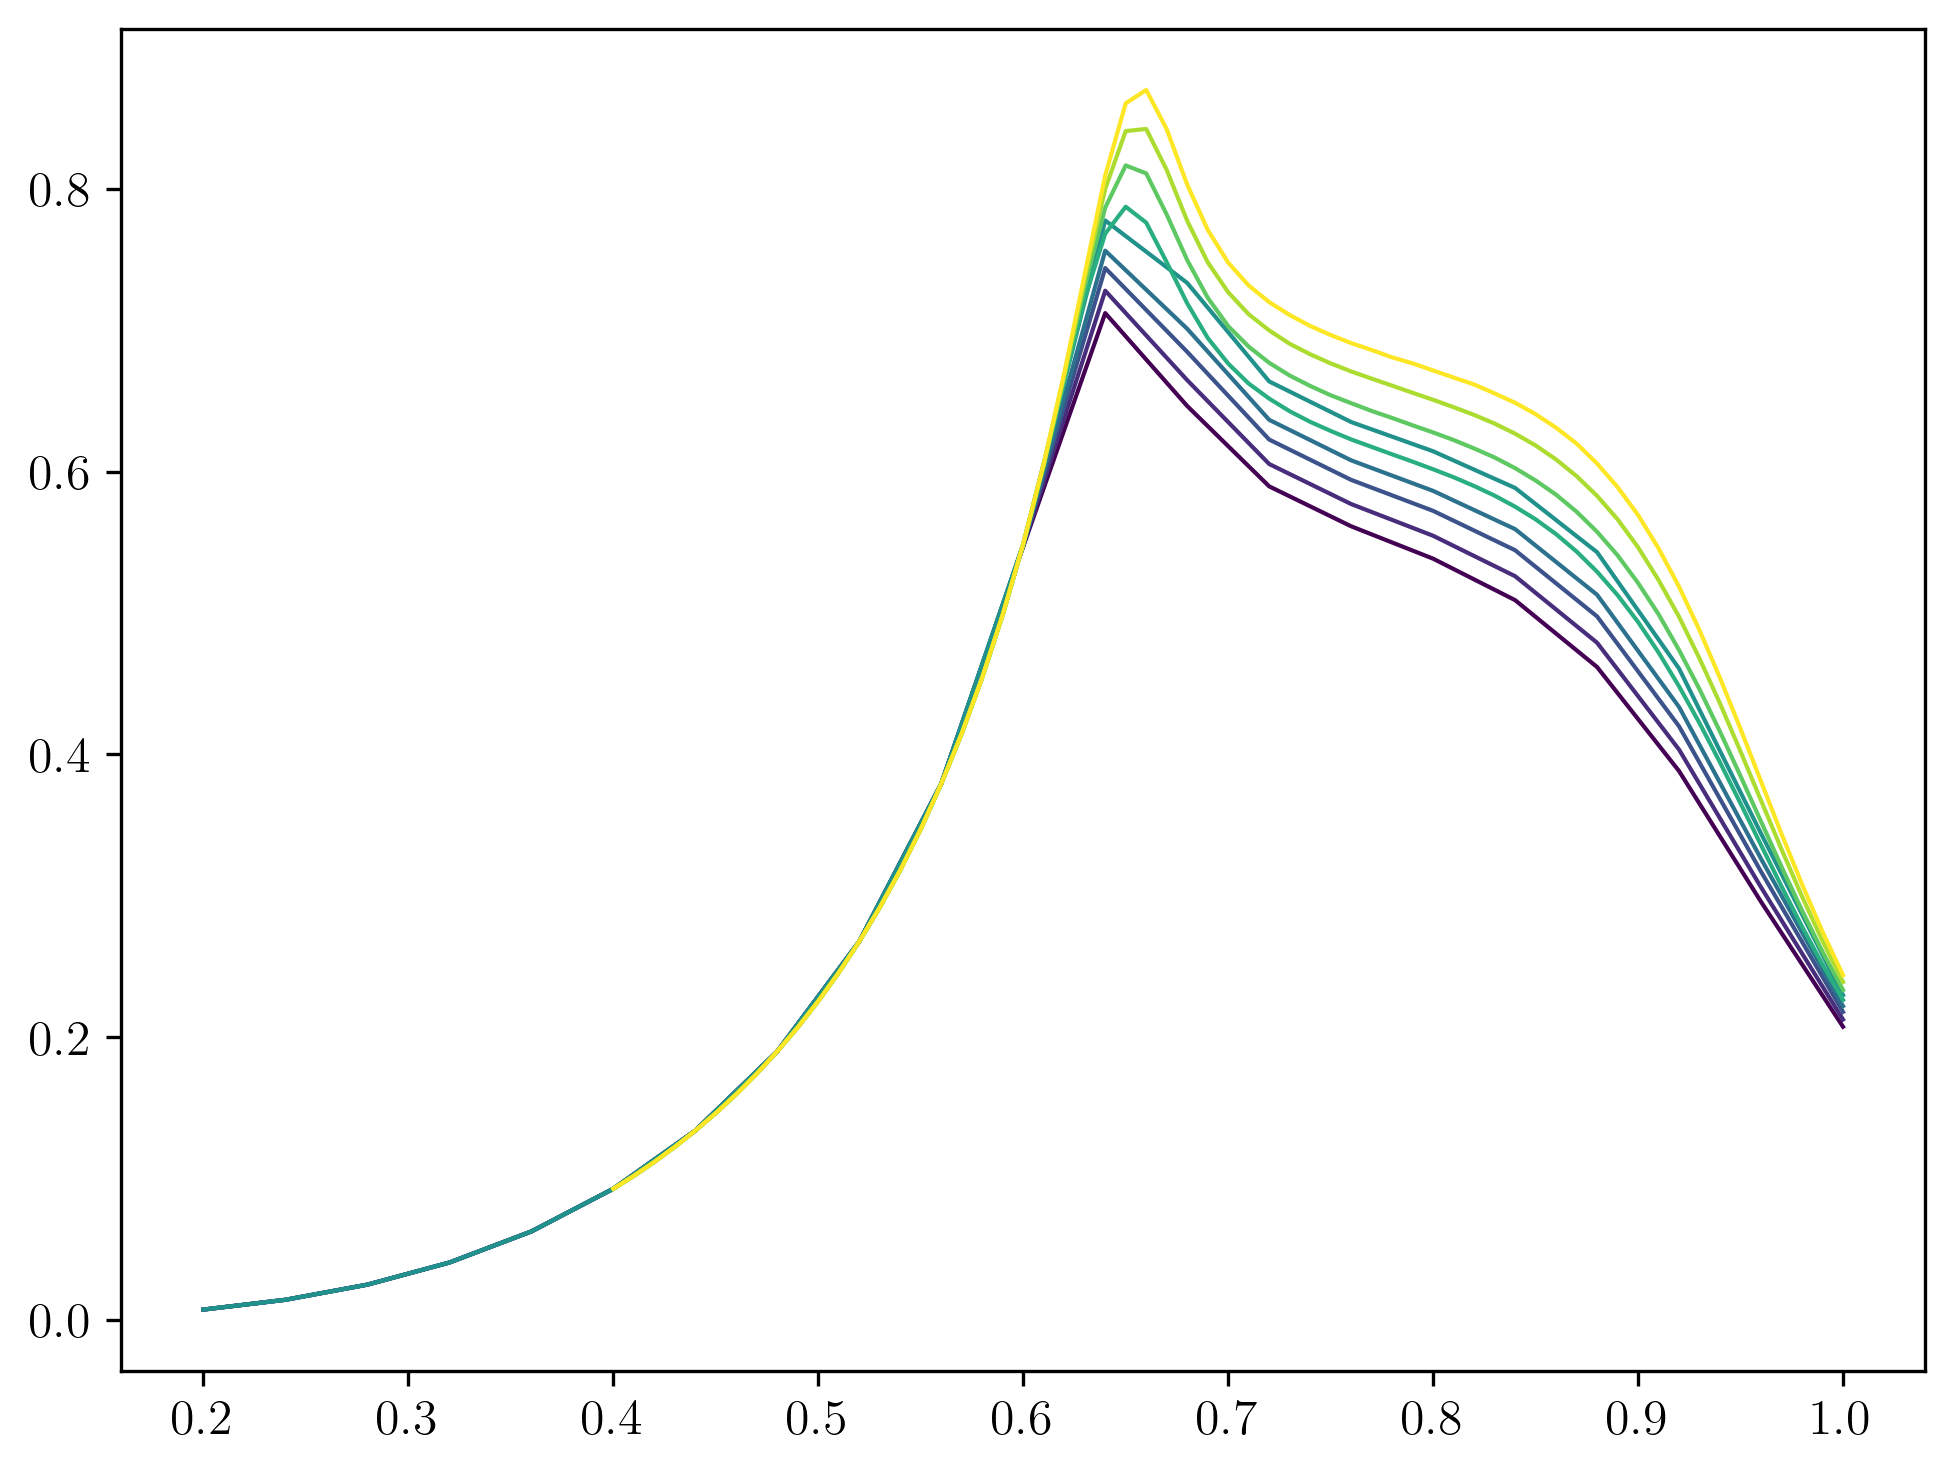

In [553]:
npoints, h_i, h_f = 21, 0.2, 1.0
interval = np.linspace(h_i,h_f,npoints)
gs = interval
l = 5
R_vac = 0
chi = 128
Rs = [14,15,16,17,19]
Rss = [14,15,16,17,19,18,20,22,24]
colors = create_sequential_colors(len(Rss))
g = 0.8
g, idx = find_closest_value(interval=gs, g=g)
entr_g = []
for i, R in enumerate(Rs):
    # bc = "obc"
    # s_obc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path_tensor)
    bc = "pbc"
    s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path_tensor)
    # plt.plot(gs,s_obc, marker="p", color=colors[i], linewidth=1, markersize=5, linestyle='-', label=f"$l \\times L: {l}\\times{L}$")
    plt.plot(gs,s_pbc, color=colors[i], linewidth=1, markersize=5, linestyle='-', label=f"$l \\times L: {l}\\times{L}$")
    entr_g.append(s_pbc[idx])

npoints, h_i, h_f = 61, 0.4, 1.0
interval = np.linspace(h_i,h_f,npoints)
gs = interval
g, idx = find_closest_value(interval=gs, g=g)
l = 5
R_vac = 0
R = 18
Rs = [18, 20, 22, 24]
sector_vac = "vacuum_sector"
sector = "2_particle(s)_sector"


for j, R in enumerate(Rs):
    # bc = "obc"
    # s_obc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path_tensor)
    bc = "pbc"
    s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path_tensor)
    # plt.plot(gs,s_obc, marker="p", color=colors[i], linewidth=1, markersize=5, linestyle='-', label=f"$l \\times L: {l}\\times{L}$")
    plt.plot(gs,s_pbc, color=colors[i+1+j], linewidth=1, markersize=5, linestyle='-', label=f"$l \\times L: {l}\\times{L}$")
    entr_g.append(s_pbc[idx])

In [555]:
npoints, h_i, h_f = 1, 0.75, 0.75
interval = np.linspace(h_i,h_f,npoints)
gs = interval
l = 6
R_vac = 0
chis = [32,64,128,256]
Rss = [12,13,14,15,16,17,18,19,20]
Rss = [14,16,18,20]
colors = create_sequential_colors(len(Rss))
g = 0.75
idx = 0
# g, idx = find_closest_value(interval=gs, g=g)
entr_g_chi = []
for chi in chis:
    entr_g = []
    for i, R in enumerate(Rss):
        # bc = "obc"
        # s_obc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path_tensor)
        bc = "pbc"
        s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path_tensor)
        # plt.plot(gs,s_obc, marker="p", color=colors[i], linewidth=1, markersize=5, linestyle='-', label=f"$l \\times L: {l}\\times{L}$")
        # plt.plot(gs,s_pbc, color=colors[i], linewidth=1, markersize=5, linestyle='-', label=f"$l \\times L: {l}\\times{L}$")
        entr_g.append(s_pbc[idx])
    entr_g_chi.append(entr_g)

central charge: 0.593643761733889+/-0.07523304747321188
central charge: 0.8846880861083503+/-0.10608513253561373
central charge: 0.9614061546994145+/-0.009163302035646404
central charge: 1.006933919966901+/-0.0035089546455861226


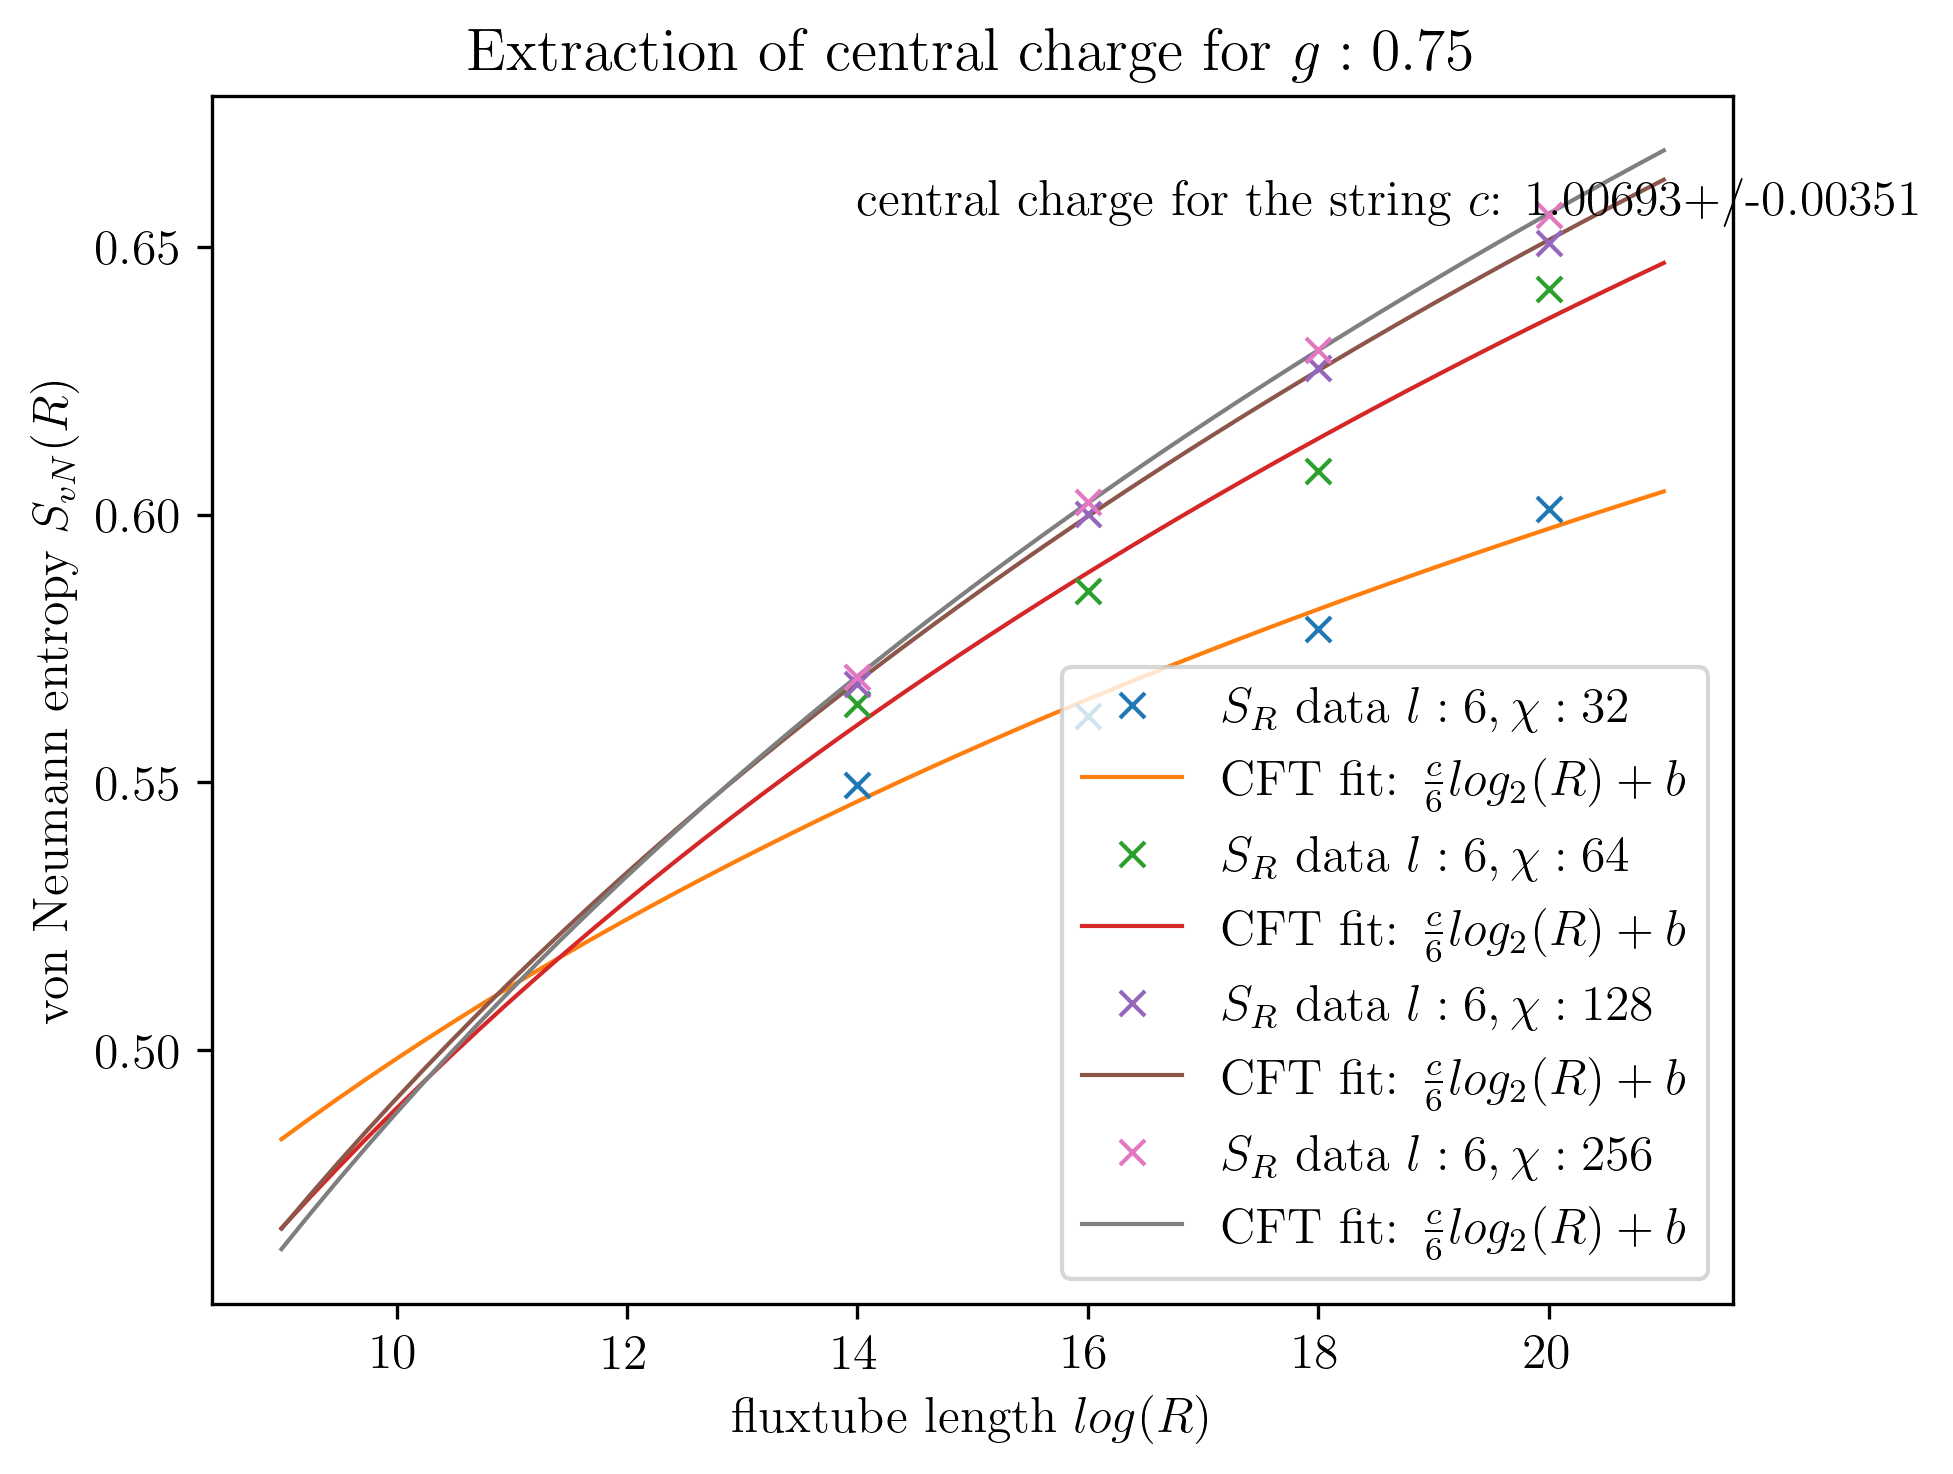

In [551]:
g = gs[idx]
def cft_entr(R, a,b):
    return a*np.log2(R) + b

x_data = Rss
for i, chi in enumerate(chis):
    y_data = entr_g_chi[i]

    popt, copt = curve_fit(cft_entr, x_data, y_data)
    err = np.sqrt(np.diag(copt))
    print(f"central charge: {popt[0]*6}+/-{err[0]*6}")
    # print(f"N: {popt[1]*np.pi} or: {np.pi/popt[2]}")
    # print(f"non universal term: {popt[3]}")

    xs = np.linspace(9,21)
    plt.plot(Rss, entr_g_chi[i], 'x', label=f"$S_R$ data $l: {l}, \chi: {chi}$", zorder=1)
    plt.plot(xs, cft_entr(xs,*popt), label="CFT fit: $\\frac{c}{6}log_2(R) + b$", linewidth=1, zorder=0)
    # plt.xscale("log")
plt.xlabel("fluxtube length $log(R)$")
plt.ylabel("von Neumann entropy $S_{vN}(R)$")
plt.title(f"Extraction of central charge for $g: {g:.2f}$")
plt.text(x=Rss[0], y=entr_g[-1], s=f"central charge for the string $c$: {popt[0]*6:.5f}+/-{err[0]*6:.5f}")
plt.legend()

In [546]:
npoints, h_i, h_f = 31, 0.6, 0.9
npoints, h_i, h_f = 33, 0.4, 5.0
interval = np.linspace(h_i,h_f,npoints)
gs = interval
l = 5
l = 6
R_vac = 0
chi = 256
chi = 128
Rs = [9,11,13,15,17,19,21]
Rs = [14,16,18,20]
colors = create_sequential_colors(len(Rs))
entr_g = []
for i, R in enumerate(Rs):
    s = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path_tensor)
    entr_g.append(s)

In [ ]:
colors = ["#F26430", "#009B72", "#009B90", "#009DDC"]

entr_reshaped = np.asarray(entr_g).T
print(entr_reshaped.shape)

def cft_entr(R, a,b):
    return a*np.log2(R) + b

gs_sel = [0.7, 0.8, 0.9]
gs_sel = [0.4, 0.85, 2.0]

gs_real = []
idxs = []
for g in gs_sel:
    g, idx = find_closest_value(interval=gs, g=g)
    gs_real.append(g)
    idxs.append(idx)

entr_real = [entr_reshaped[i,:] for i in idxs]
x_data = Rs

regions = ["deconfined","rough point","confined"]
cc = []
cc_err = []


i = 0
y_data = entr_real[0]

popt, copt = curve_fit(cft_entr, x_data, y_data)
err = np.sqrt(np.diag(copt))
print(f"central charge for g: {gs_real[i]:.2f}: {popt[0]*6}+/-{err[0]*6}")
cc.append(popt[0]*6)
cc_err.append(err[0]*6)

xs = np.linspace(5,21)
if "rough" in regions[i]:
    label = f"$g: {gs_real[i]:.2f}$ - {regions[i]}, $c: {popt[0]*6:.3f}\\pm{err[0]*6:.3f}$"
else:
    label = f"$g: {gs_real[i]:.2f}$ - {regions[i]}"
plt.plot(Rs, y_data, 'x', color=colors[i], label=label, zorder=i+1)
# plt.plot(Rs, y_data, 'x', label=f"$S_R$ data $l: {l}$", zorder=1)
plt.plot(xs, cft_entr(xs,*popt), color=colors[i], linewidth=1)
# plt.plot(xs, cft_entr(xs,*popt), label="CFT fit: $\\frac{c}{6}log_2(R) + b$", linewidth=1, zorder=0)


Rss = [12,13,14,15,16,17,18,19,20]
Rss = [14,16,18,20]
x_data = Rss
y_data = entr_g_chi[-1]

popt, copt = curve_fit(cft_entr, x_data, y_data)
err = np.sqrt(np.diag(copt))
print(f"central charge for g: {0.75:.2f}: {popt[0]*6}+/-{err[0]*6}")

xs = np.linspace(5,21)
label = f"$g: 0.75$ - rough, $c: {popt[0]*6:.3f}\\pm{err[0]*6:.3f}$"
plt.plot(Rss, y_data, 'x', color=colors[1], label=label, zorder=0)
# plt.plot(Rs, y_data, 'x', label=f"$S_R$ data $l: {l}$", zorder=1)
plt.plot(xs, cft_entr(xs,*popt), color=colors[1], linewidth=1)

x_data = Rs

entr_real = entr_real[1:]
for i, entropies_g in enumerate(entr_real):
    y_data = entropies_g

    popt, copt = curve_fit(cft_entr, x_data, y_data)
    err = np.sqrt(np.diag(copt))
    print(f"central charge for g: {gs_real[i+1]:.2f}: {popt[0]*6}+/-{err[0]*6}")
    cc.append(popt[0]*6)
    cc_err.append(err[0]*6)

    xs = np.linspace(5,21)
    if "rough" in regions[i+1]:
        label = f"$g: {gs_real[i+1]:.2f}$ - {regions[i+1]}, $c: {popt[0]*6:.3f}\\pm{err[0]*6:.3f}$"
    else:
        label = f"$g: {gs_real[i+1]:.2f}$ - {regions[i+1]}"
    plt.plot(Rs, y_data, 'x', color=colors[i+2], label=label, zorder=i+1)
    # plt.plot(Rs, y_data, 'x', label=f"$S_R$ data $l: {l}$", zorder=1)
    plt.plot(xs, cft_entr(xs,*popt), color=colors[i+2], linewidth=1)
    # plt.plot(xs, cft_entr(xs,*popt), label="CFT fit: $\\frac{c}{6}log_2(R) + b$", linewidth=1, zorder=0)

plt.legend()
plt.text(x=5, y=0.6, s="CFT fit: $\\frac{c}{6}log_2(R) + b$")
plt.xlabel("fluxtube length $(R)$")
plt.ylabel("von Neumann entropy $S_{R/2}(g)$")
plt.title(f"Extraction of central charge")


(0.96, 1.0239275734244926)

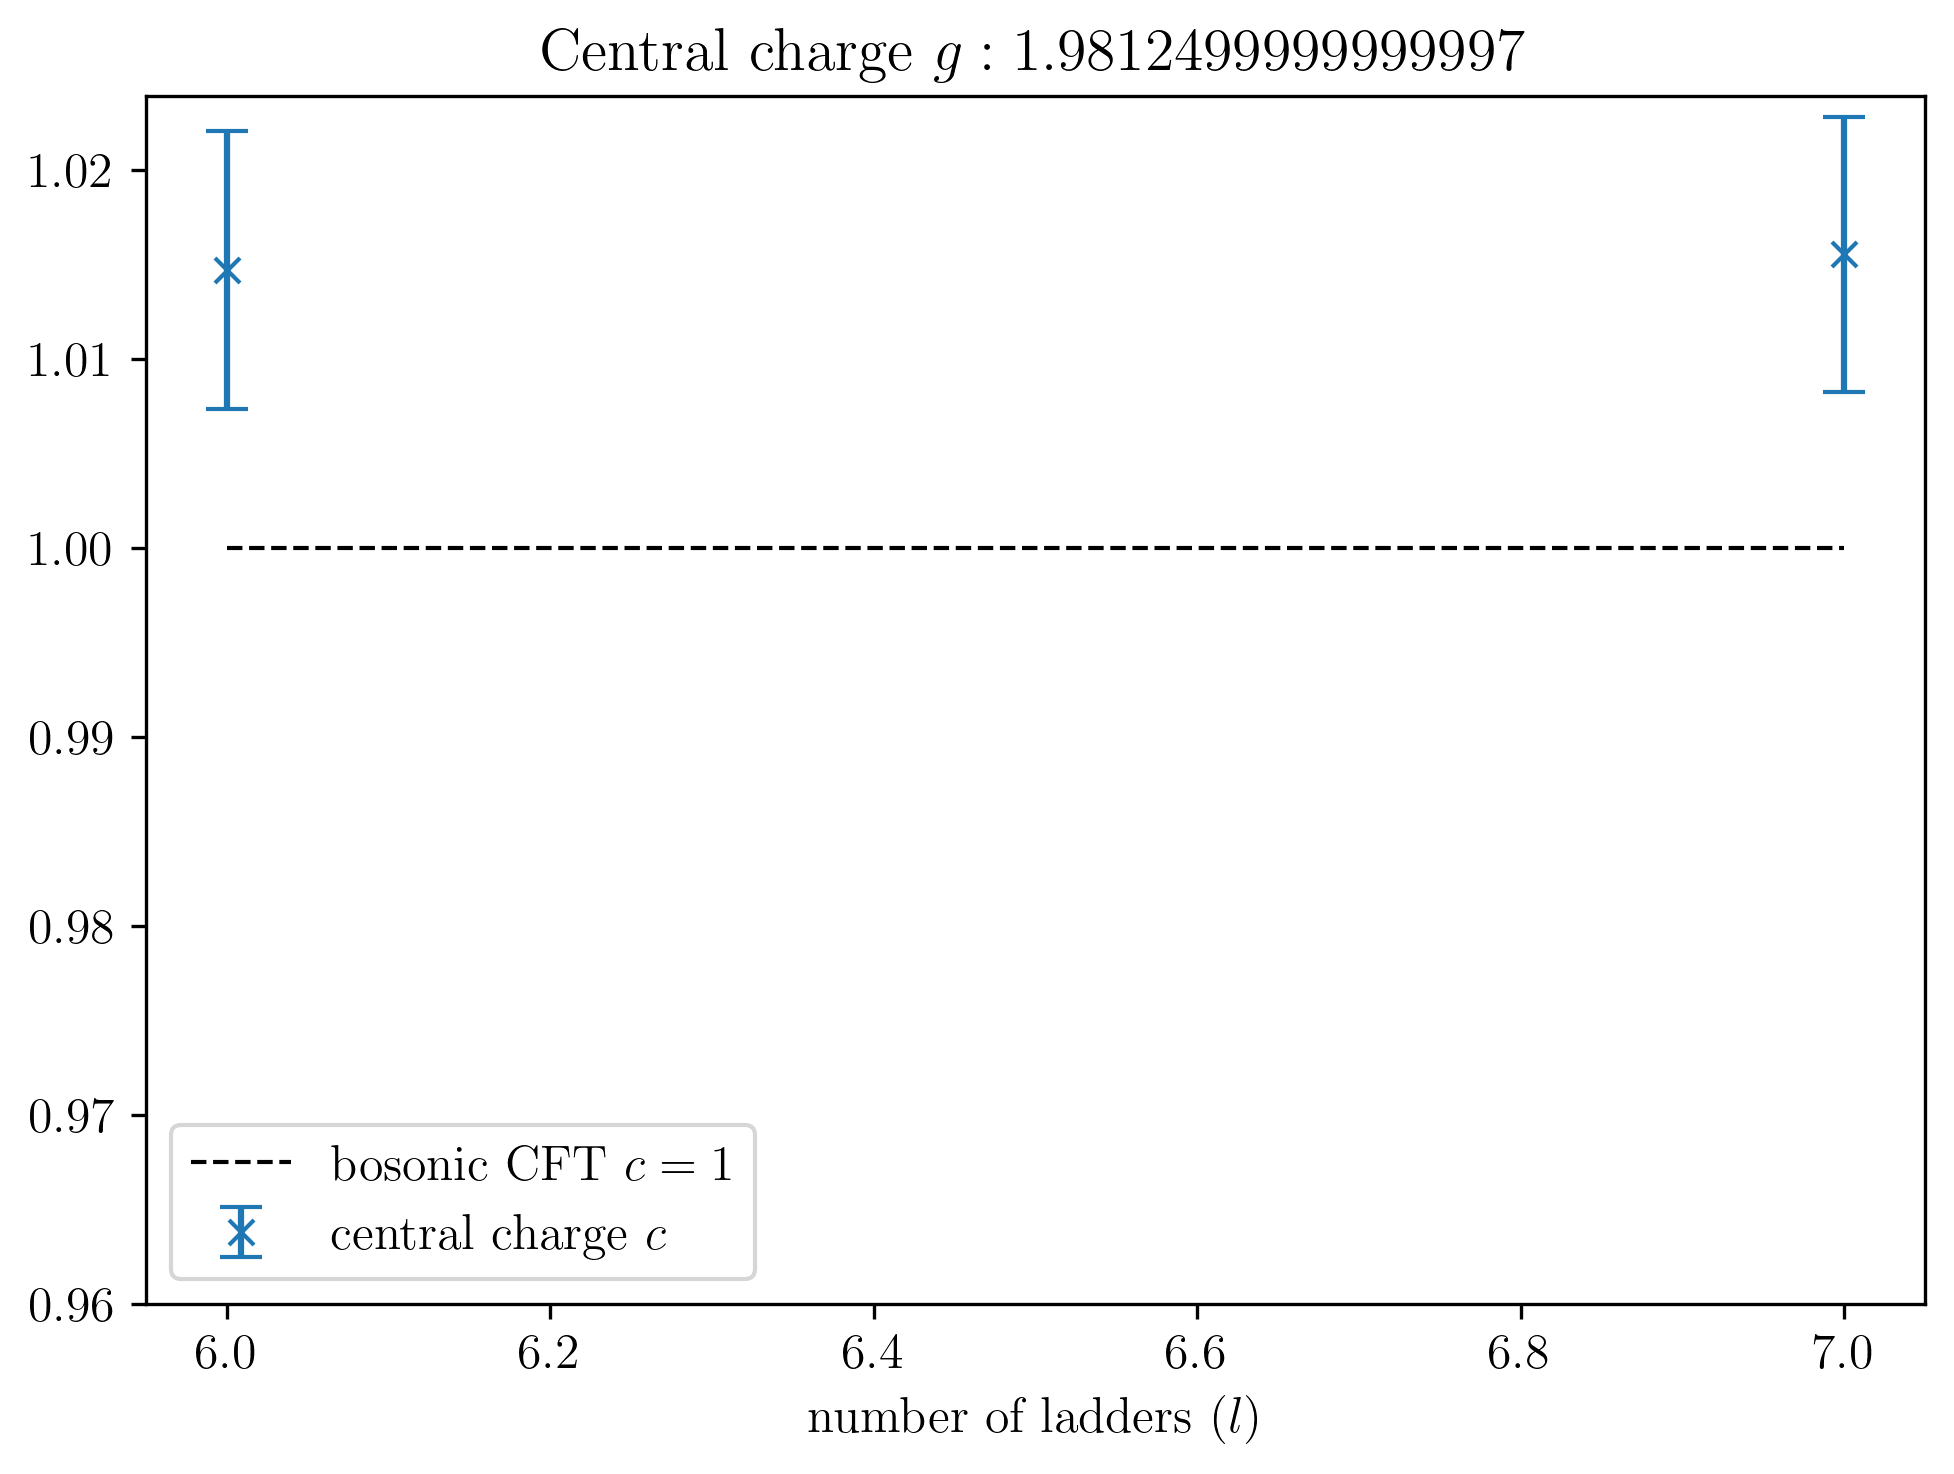

In [ ]:
npoints, h_i, h_f = 1, 0.75, 0.75
interval = np.linspace(h_i,h_f,npoints)
gs = interval
l = 6
chis = [256,512]
ls = [6,7]
R_vac = 0
chi = 512
Rs = [12,13,14,15,16,17,18,19]
colors = create_sequential_colors(len(Rs))
idx = 0

x_data = Rs


cc = []
cc_err = []
for l, chi in zip(ls,chis):
    entr_g = []
    for i, R in enumerate(Rs):
        s = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path_tensor)
        entr_g.append(s[0])

    y_data = entr_g

    popt, copt = curve_fit(cft_entr, x_data, y_data)
    err = np.sqrt(np.diag(copt))
    # print(f"central charge for g: {gs[i]}: {popt[0]*6}+/-{err[0]*6}")
    cc.append(popt[0]*6)
    cc_err.append(err[0]*6)

# plt.plot(ls, cc, 'x', linestyle='', label="central charge $c$")
plt.errorbar(x=ls, y=cc, yerr=cc_err, fmt='x', linestyle='', capsize=5, label="central charge $c$")
# plt.fill_between(x=ls, y1=np.asarray(cc)+np.asarray(cc_err), y2=np.asarray(cc)-np.asarray(cc_err), alpha=0.4)
plt.hlines(y=1, xmin=ls[0], xmax=ls[-1], color="k", linestyles="--", linewidths=1, label="bosonic CFT $c=1$")
plt.legend()
plt.title(f"Central charge $g: {g}$")
plt.xlabel("number of ladders $(l)$")
# plt.xlim(left=0.7)
plt.ylim(bottom=0.96)

### Entropy in a partition fixing $R$

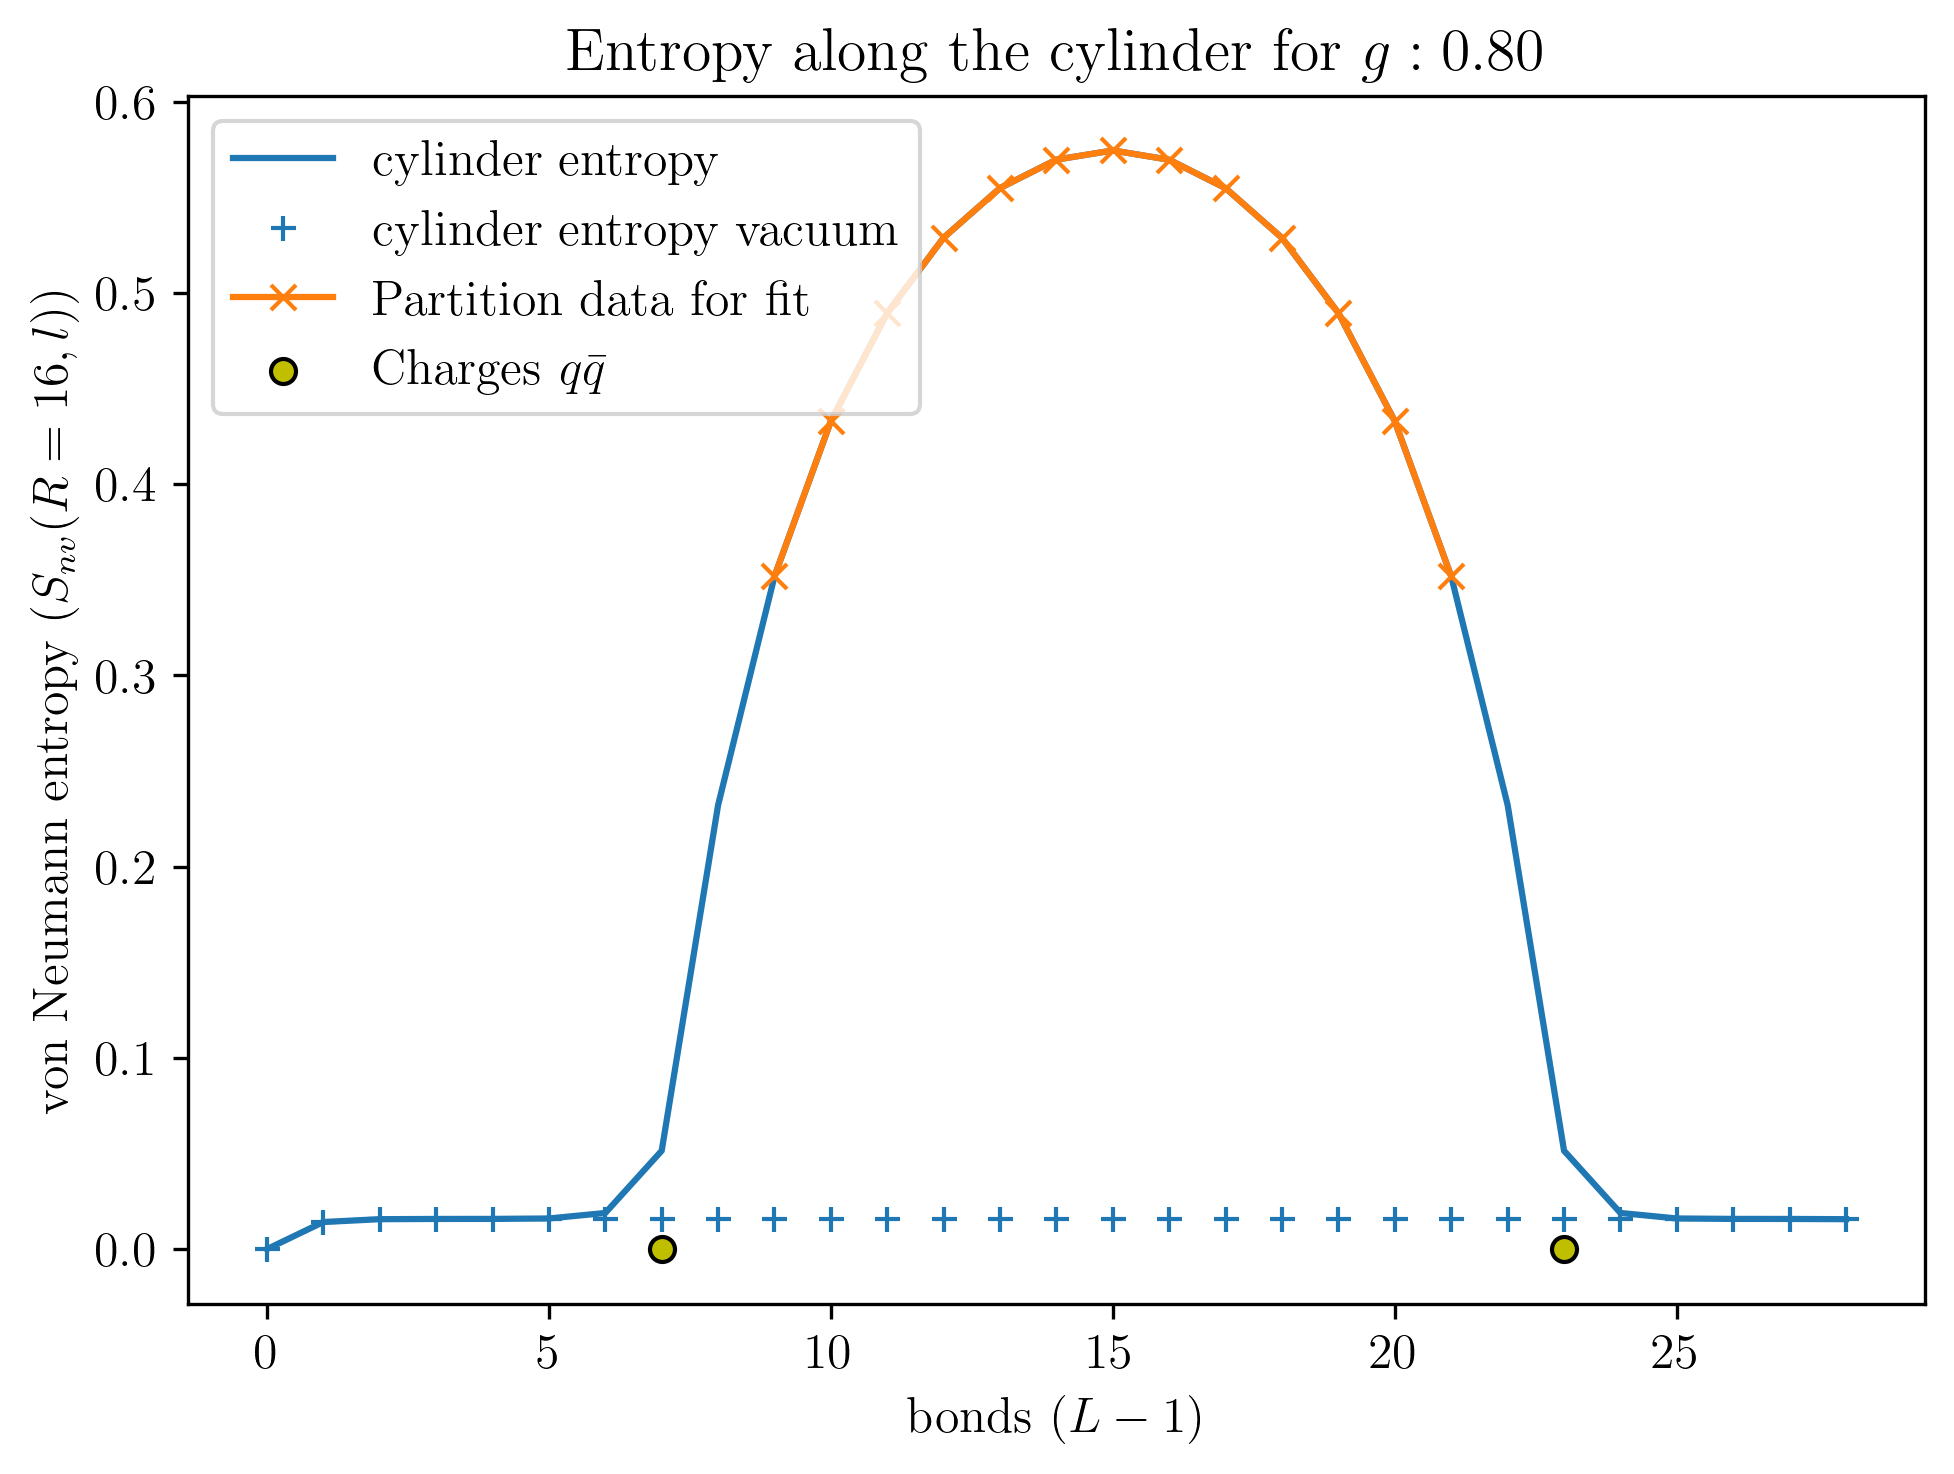

In [450]:
R, l, L = 16, 6, 30
chi = 128
bc, sector = "pbc", "2_particle(s)_sector"
sector_vac = "vacuum_sector"
h_i, h_f, npoints = 0.8, 0.8, 1
cx = [7,23]
# cx = [7,22]
cy = [0,0]
where = "all"
s = np.load(
            f"{path_tensor}/results/entropy_data/{where}_bond_entropy_Z2_dual_direct_lattice_{l}x{L}_{sector}_bc_{bc}_{cx}-{cy}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
        )
s_vac = np.load(
            f"{path_tensor}/results/entropy_data/{where}_bond_entropy_Z2_dual_direct_lattice_{l}x{L}_{sector_vac}_bc_{bc}_None-None_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
        )
plt.plot(s[0], label="cylinder entropy", color='C0')
plt.plot(s_vac[0], '+', label="cylinder entropy vacuum", color='C0')
# we see that interesting bonds are where the string begins from 5 to L//2 = 15
s_partition = s[0,cx[0]+1:L//2+1]
s_partition_vac = s_vac[0,cx[0]+1:L//2+1]
s_partition = s[0,cx[0]+2:cx[1]-1]
s_partition_vac = s_vac[0,cx[0]+2:cx[1]-1]
plt.plot(range(cx[0]+2,cx[1]-1), s_partition, marker="x", color='C1', label="Partition data for fit")
plt.scatter(x=cx, y=cy, marker='o', edgecolors='k', facecolors='y', label="Charges $q\\bar{q}$")
plt.title(f"Entropy along the cylinder for $g: {h_i:.2f}$")
plt.xlabel("bonds $(L-1)$")
plt.ylabel(f"von Neumann entropy $(S_{{nv}}(R={R},l))$")

# plt.yscale('log')
plt.legend()
plt.savefig(f"{path_figures}/figures/entropy/entropy_partition_cylinder_z2_dual_{l}x{L}_R_{R}_h_{h_i}-{h_f}_npoints_{npoints}_chis_{chis}.png")


In [451]:
s_partition = s_partition - s_partition_vac
s_partition.shape

(13,)

/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_75143/333085194.py:4: RuntimeWarning: invalid value encountered in log2
  return (c/6)*np.log2(R/np.pi * np.sin(np.pi/R * l)) + b


0.6235691976097253 0.020484524872968146 -14.020685593397523


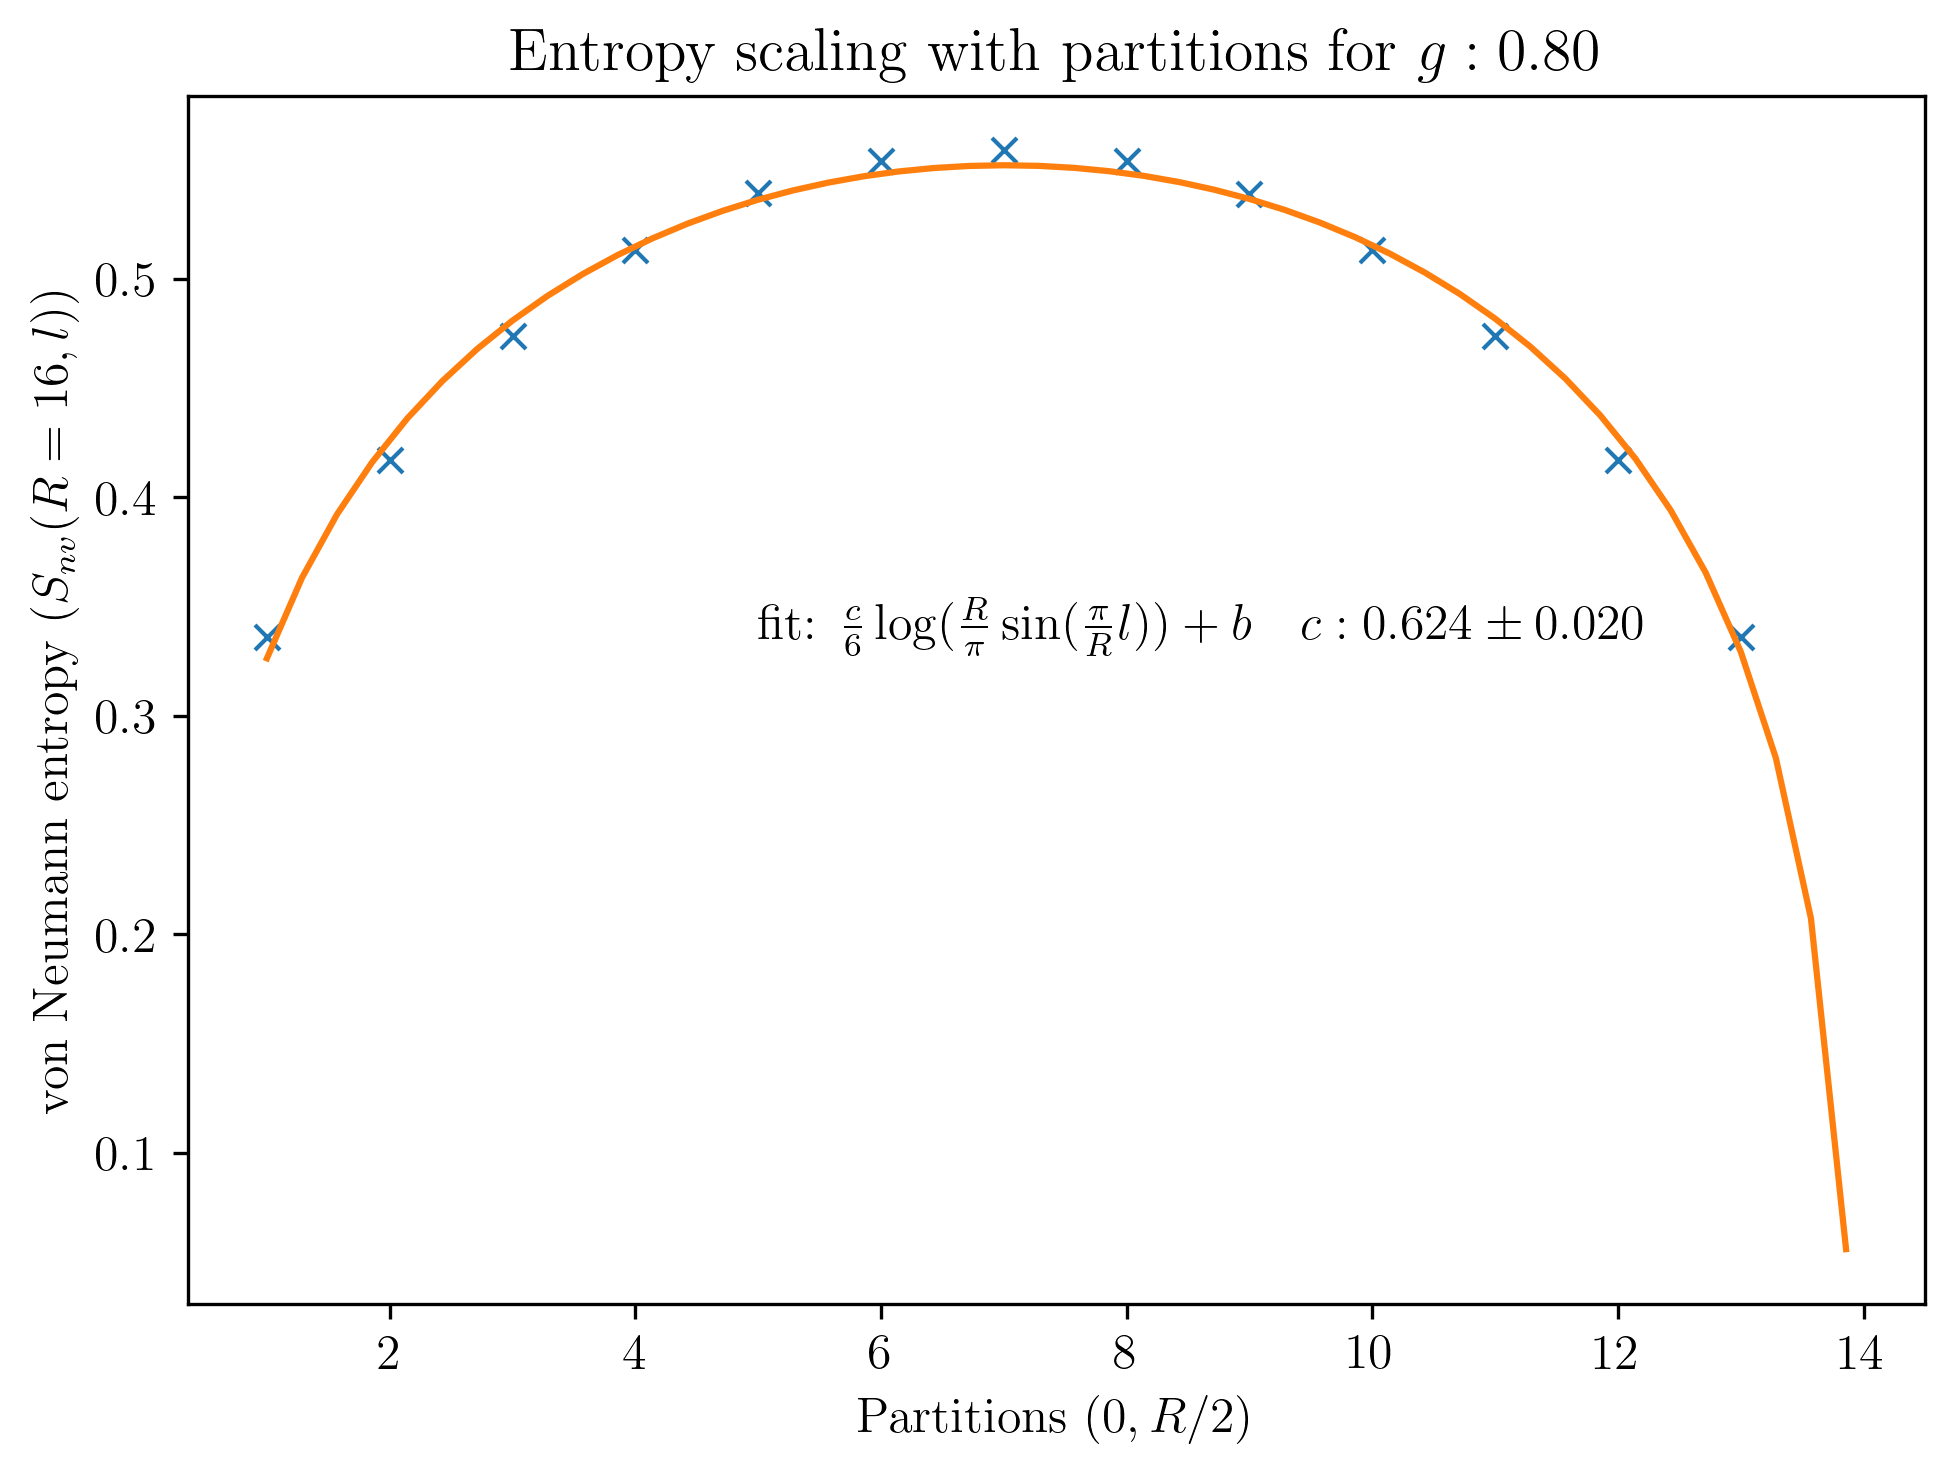

In [452]:
R = 16

def cft_entr_complete(l, c,b,R):
    return (c/6)*np.log2(R/np.pi * np.sin(np.pi/R * l)) + b

x_data = np.arange(1, R-2, 1)
# x_data = np.arange(cx[0], L//2+1, 1)
y_data = s_partition

popt, copt = curve_fit(cft_entr_complete, x_data, y_data, p0=[0.1,0,R])
err = np.sqrt(np.diag(copt))
print(popt[0], err[0], popt[-1])

xs = np.linspace(1,R-1)
plt.plot(x_data, y_data, 'x')
plt.plot(xs, cft_entr_complete(xs, *popt))
plt.text(x=5, y=min(y_data), s="fit: $\\frac{c}{6}\\log(\\frac{R}{\\pi} \\sin(\\frac{\\pi}{R}l)) + b$"+f"$\\quad c: {popt[0]:.3f}\\pm{err[0]:.3f}$")
plt.title(f"Entropy scaling with partitions for $g: {h_i:.2f}$")
plt.xlabel("Partitions $(0,R/2)$")
plt.ylabel(f"von Neumann entropy $(S_{{nv}}(R={R},l))$")
plt.savefig(f"{path_figures}/figures/entropy/entropy_partition_cylinder_fit_z2_dual_{l}x{L}_R_{R}_h_{h_i}-{h_f}_npoints_{npoints}_chis_{chis}.png")


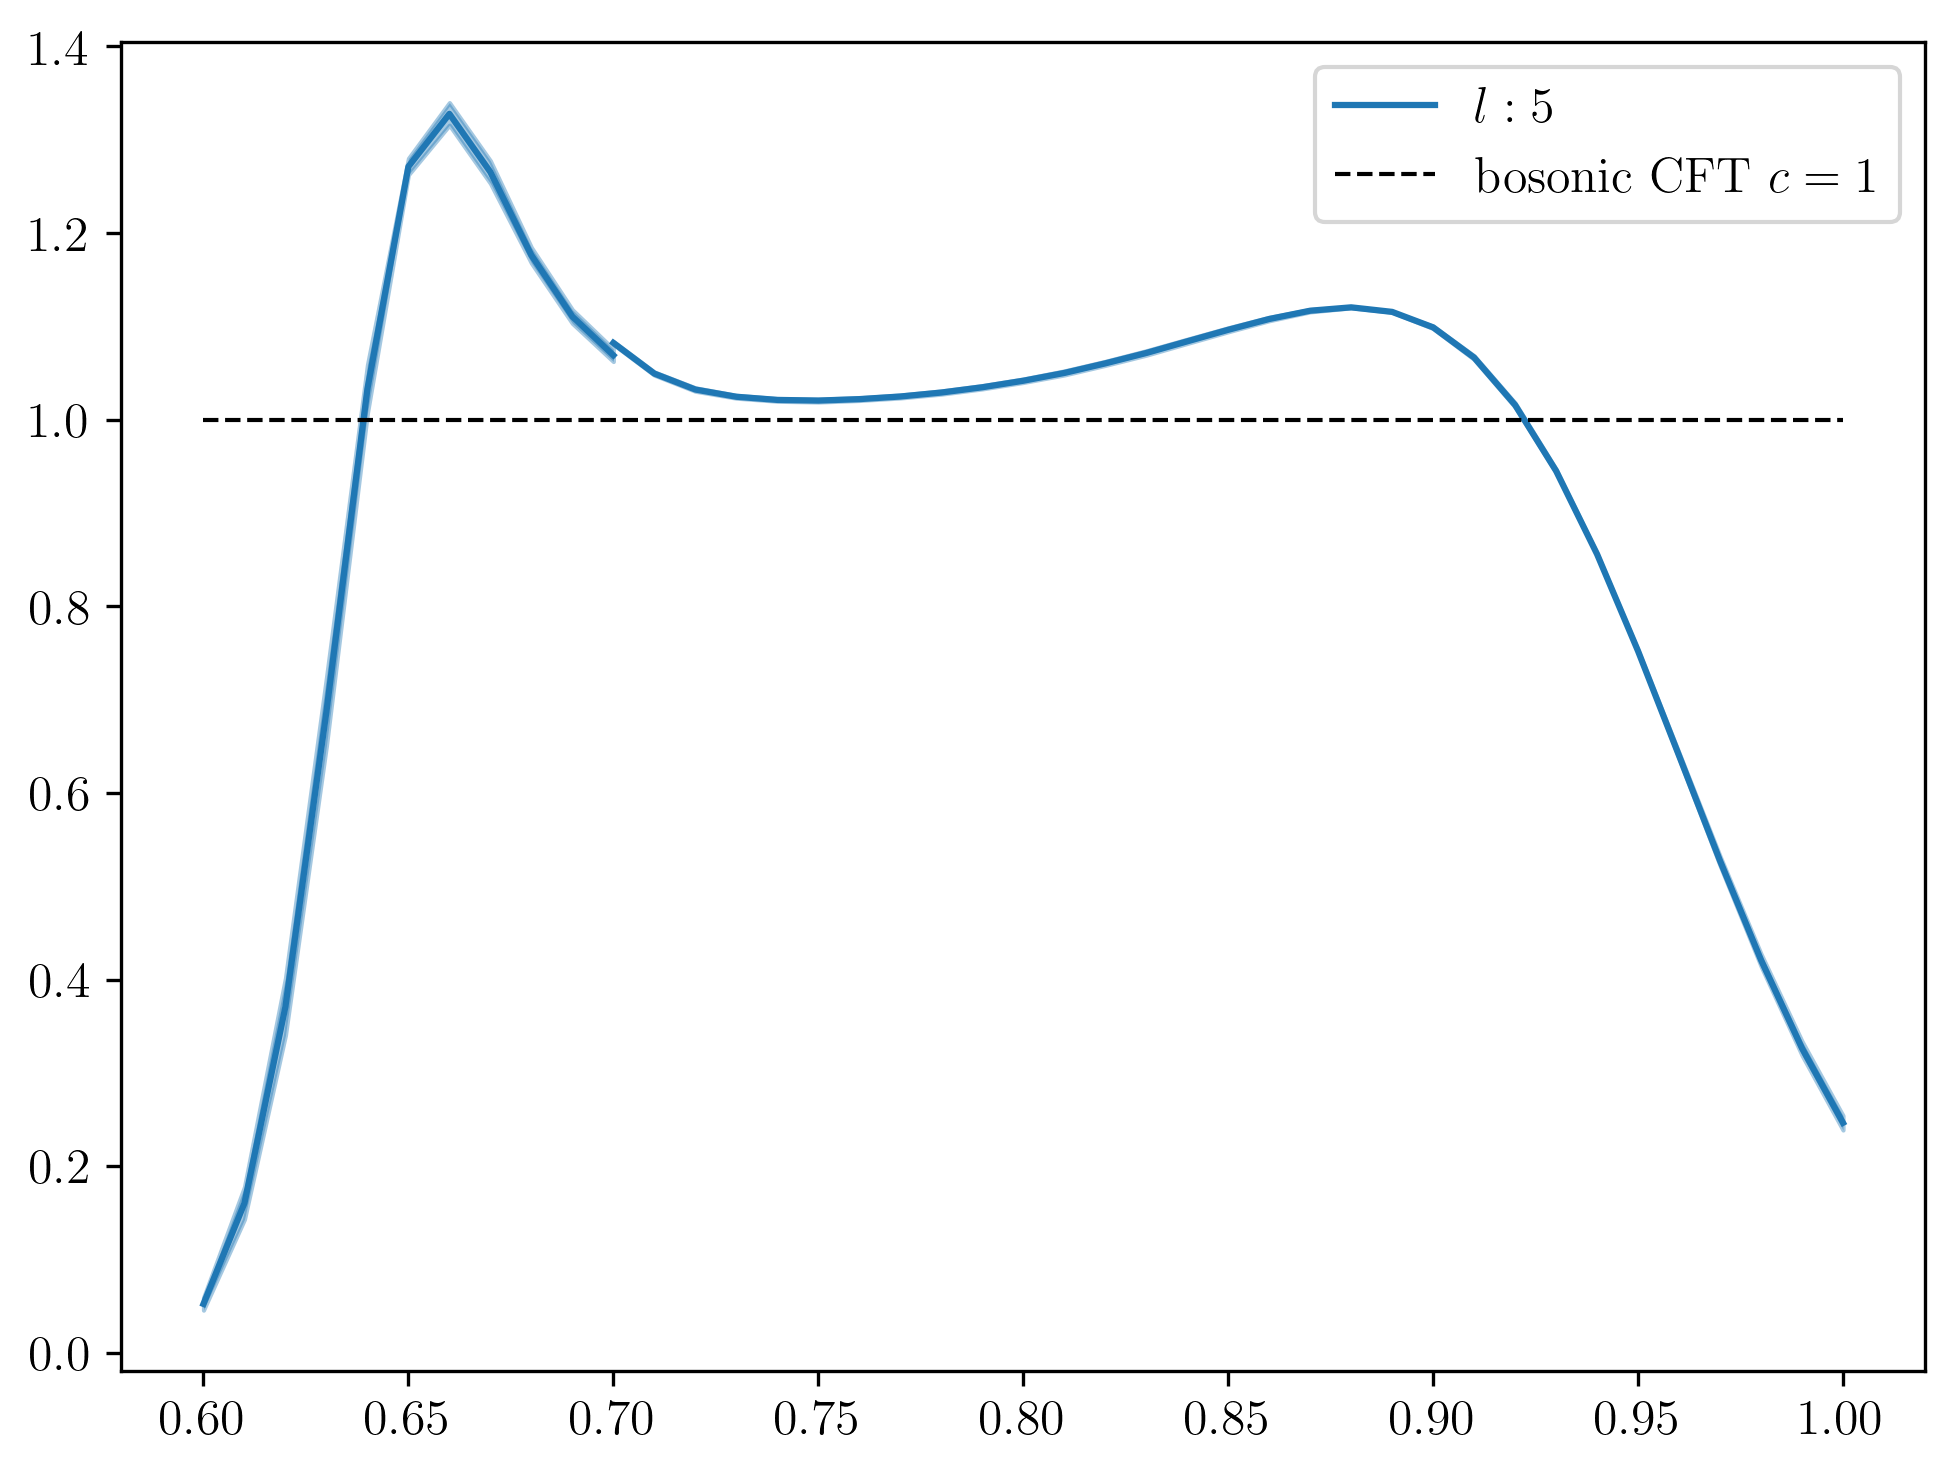

In [642]:
npoints, h_i, h_f = 31, 0.6, 0.9
interval = np.linspace(h_i,h_f,npoints)
gs = interval
chis = [128]
ls = [5]
R_vac = 0
Rs = [10,11,12,13,14,15,16,17,19]
colors = create_sequential_colors(len(Rs))
idx = 0
where = L//2
x_data = Rs
sector = "2_particle(s)_sector"


for l, chi in zip(ls,chis):
    cc = []
    cc_err = []
    entr_g = []
    for i, R in enumerate(Rs):
        cx = get_cx(L,R)
        cy = get_cy(l,bc)
        # s = np.load(
        #     f"{path_tensor}/results/entropy_data/{where}_bond_entropy_Z2_dual_direct_lattice_{l}x{L}_{sector}_bc_{bc}_{cx}-{cy}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
        # )
        s = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path_tensor)
        entr_g.append(s)

    entr_g = np.array(entr_g).T
    for i, g in enumerate(gs[:11]):
        y_data = entr_g[i]

        popt, copt = curve_fit(cft_entr, x_data, y_data)
        err = np.sqrt(np.diag(copt))
    # print(f"central charge for g: {gs[i]}: {popt[0]*6}+/-{err[0]*6}")
        cc.append(popt[0]*6)
        cc_err.append(err[0]*6)

    plt.plot(gs[:11], cc[:11], color='C0')
    plt.fill_between(x=gs[:11], y1=np.asarray(cc[:11])+np.asarray(cc_err[:11]), y2=np.asarray(cc[:11])-np.asarray(cc_err[:11]), color='C0', alpha=0.4)


npoints, h_i, h_f = 31, 0.7, 1.0
interval = np.linspace(h_i,h_f,npoints)
gs = interval
chis = [128]
ls = [5]
R_vac = 0
Rs = [10,11,12,13,14,15,16,17,19]
Rs = [18,20,22,24]
colors = create_sequential_colors(len(Rs))
idx = 0
where = L//2
x_data = Rs
sector = "2_particle(s)_sector"


for l, chi in zip(ls,chis):
    cc = []
    cc_err = []
    entr_g = []
    for i, R in enumerate(Rs):
        cx = get_cx(L,R)
        cy = get_cy(l,bc)
        # s = np.load(
        #     f"{path_tensor}/results/entropy_data/{where}_bond_entropy_Z2_dual_direct_lattice_{l}x{L}_{sector}_bc_{bc}_{cx}-{cy}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
        # )
        s = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path_tensor)
        entr_g.append(s)

    entr_g = np.array(entr_g).T
    for i, g in enumerate(gs):
        y_data = entr_g[i]

        popt, copt = curve_fit(cft_entr, x_data, y_data)
        err = np.sqrt(np.diag(copt))
    # print(f"central charge for g: {gs[i]}: {popt[0]*6}+/-{err[0]*6}")
        cc.append(popt[0]*6)
        cc_err.append(err[0]*6)

    plt.plot(gs, cc, color='C0', label=f"$l : {l}$")
    plt.fill_between(x=gs, y1=np.asarray(cc)+np.asarray(cc_err), y2=np.asarray(cc)-np.asarray(cc_err), color='C0', alpha=0.4)

plt.hlines(y=1, xmin=0.6, xmax=gs[-1], color="k", linestyles="--", linewidths=1, label="bosonic CFT $c=1$")
plt.legend()    

# Kink Mass Analysis

In [605]:
h_i, h_f, npoints = 0.2, 1.0, 21
l, L = 5, 30
Ls = [L]
Rs = [10,11,12,13,14,15]
gs = np.linspace(h_i,h_f,npoints)
cy_off_axis = [0,2]
cx = None
cy = [0,0]
sector = "2_particle(s)_sector"
R = 15
chis = [64,128]
bc = "pbc"

In [606]:
kms, kms_err = n_order_kink_mass_varying_g(gs,R,l,L,chis,bc,sector,h_i,h_f,npoints,path_tensor,cx,cy,cy_off_axis)

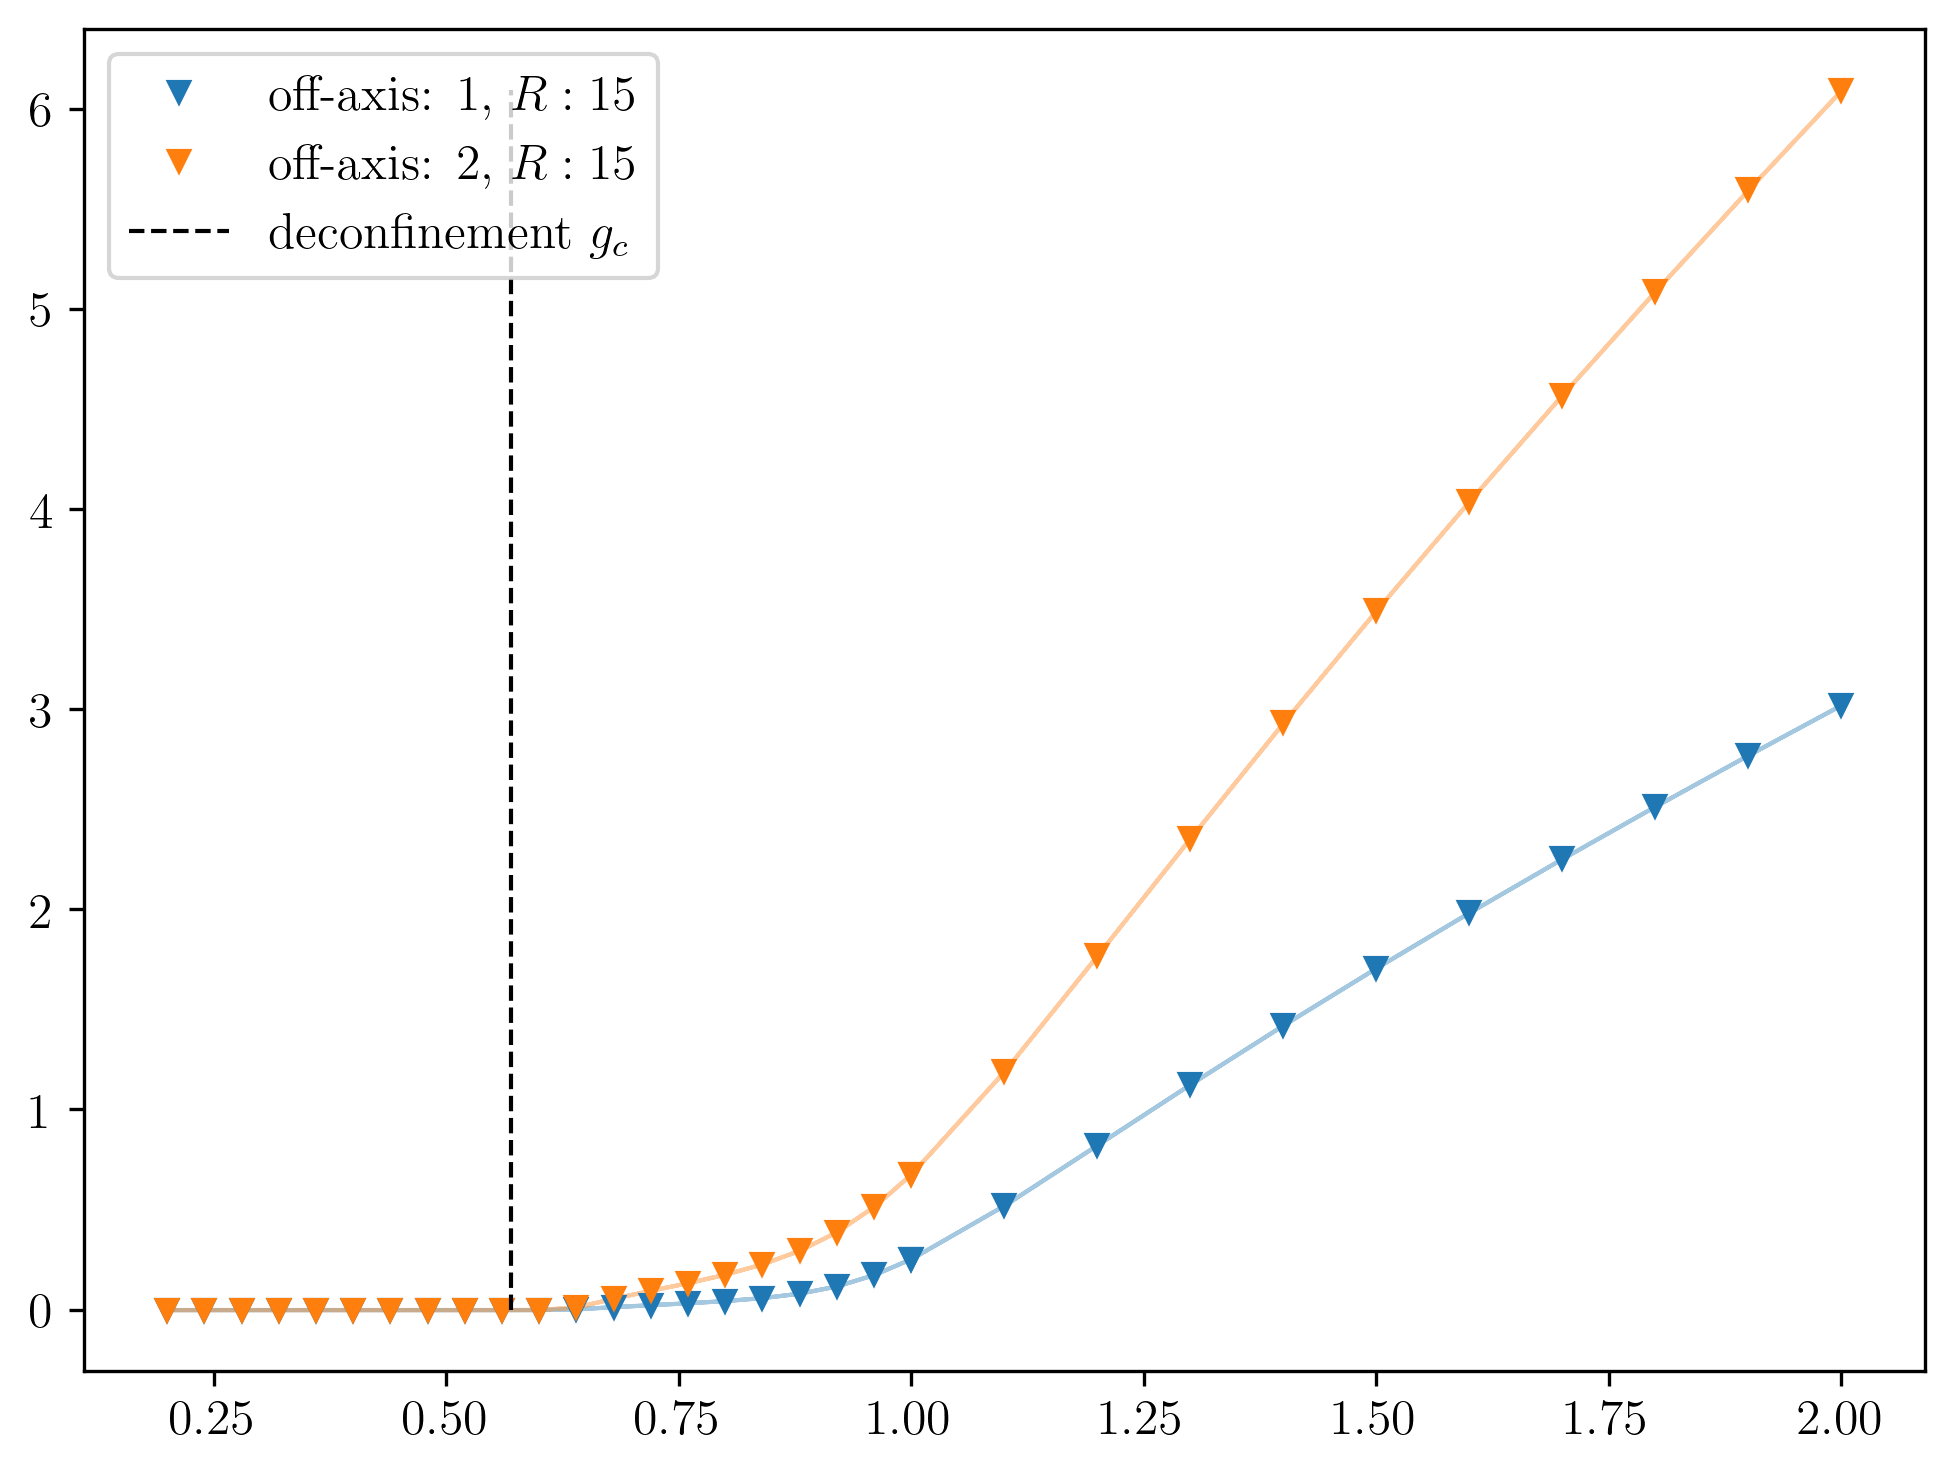

In [607]:
h_i, h_f, npoints = 0.2, 1.0, 21
l, L = 5, 30
Rs = [10,11,12,13,14,15]
gs = np.linspace(h_i,h_f,npoints)

for off in range(2):
    cy_off_axis = [0,off+1]
    kms, kms_err = n_order_kink_mass_varying_g(gs,R,l,L,chis,bc,sector,h_i,h_f,npoints,path_tensor,cx,cy,cy_off_axis, vacuum=True)
    plt.plot(gs, np.abs(kms), marker='v', markersize=5, linestyle="", color=f"C{off}", linewidth=1, label=f"off-axis: ${off+1}$,  $R: {R}$")
    plt.fill_between(gs, y1=np.abs(np.asarray(kms)+np.asarray(kms_err)),y2=np.abs(np.asarray(kms)-np.asarray(kms_err)), color=f"C{off}", alpha=0.4)

h_i, h_f, npoints = 1.0, 2.0, 11
l, L = 5, 30
Rs = [10,11,12,13,14,15]
gs = np.linspace(h_i,h_f,npoints)

for off in range(2):
    cy_off_axis = [0,off+1]
    kms, kms_err = n_order_kink_mass_varying_g(gs,R,l,L,chis,bc,sector,h_i,h_f,npoints,path_tensor,cx,cy,cy_off_axis, vacuum=True)
    plt.plot(gs, np.abs(kms), marker='v', markersize=5, linestyle="", color=f"C{off}", linewidth=1)
    plt.fill_between(gs, y1=np.abs(np.asarray(kms)+np.asarray(kms_err)),y2=np.abs(np.asarray(kms)-np.asarray(kms_err)), color=f"C{off}", alpha=0.4)

plt.vlines(x=0.57, ymin=0, ymax=max(np.abs(kms)), linestyles="--", colors='black', linewidth=1, label="deconfinement $g_c$")
plt.legend()
# plt.yscale("log")

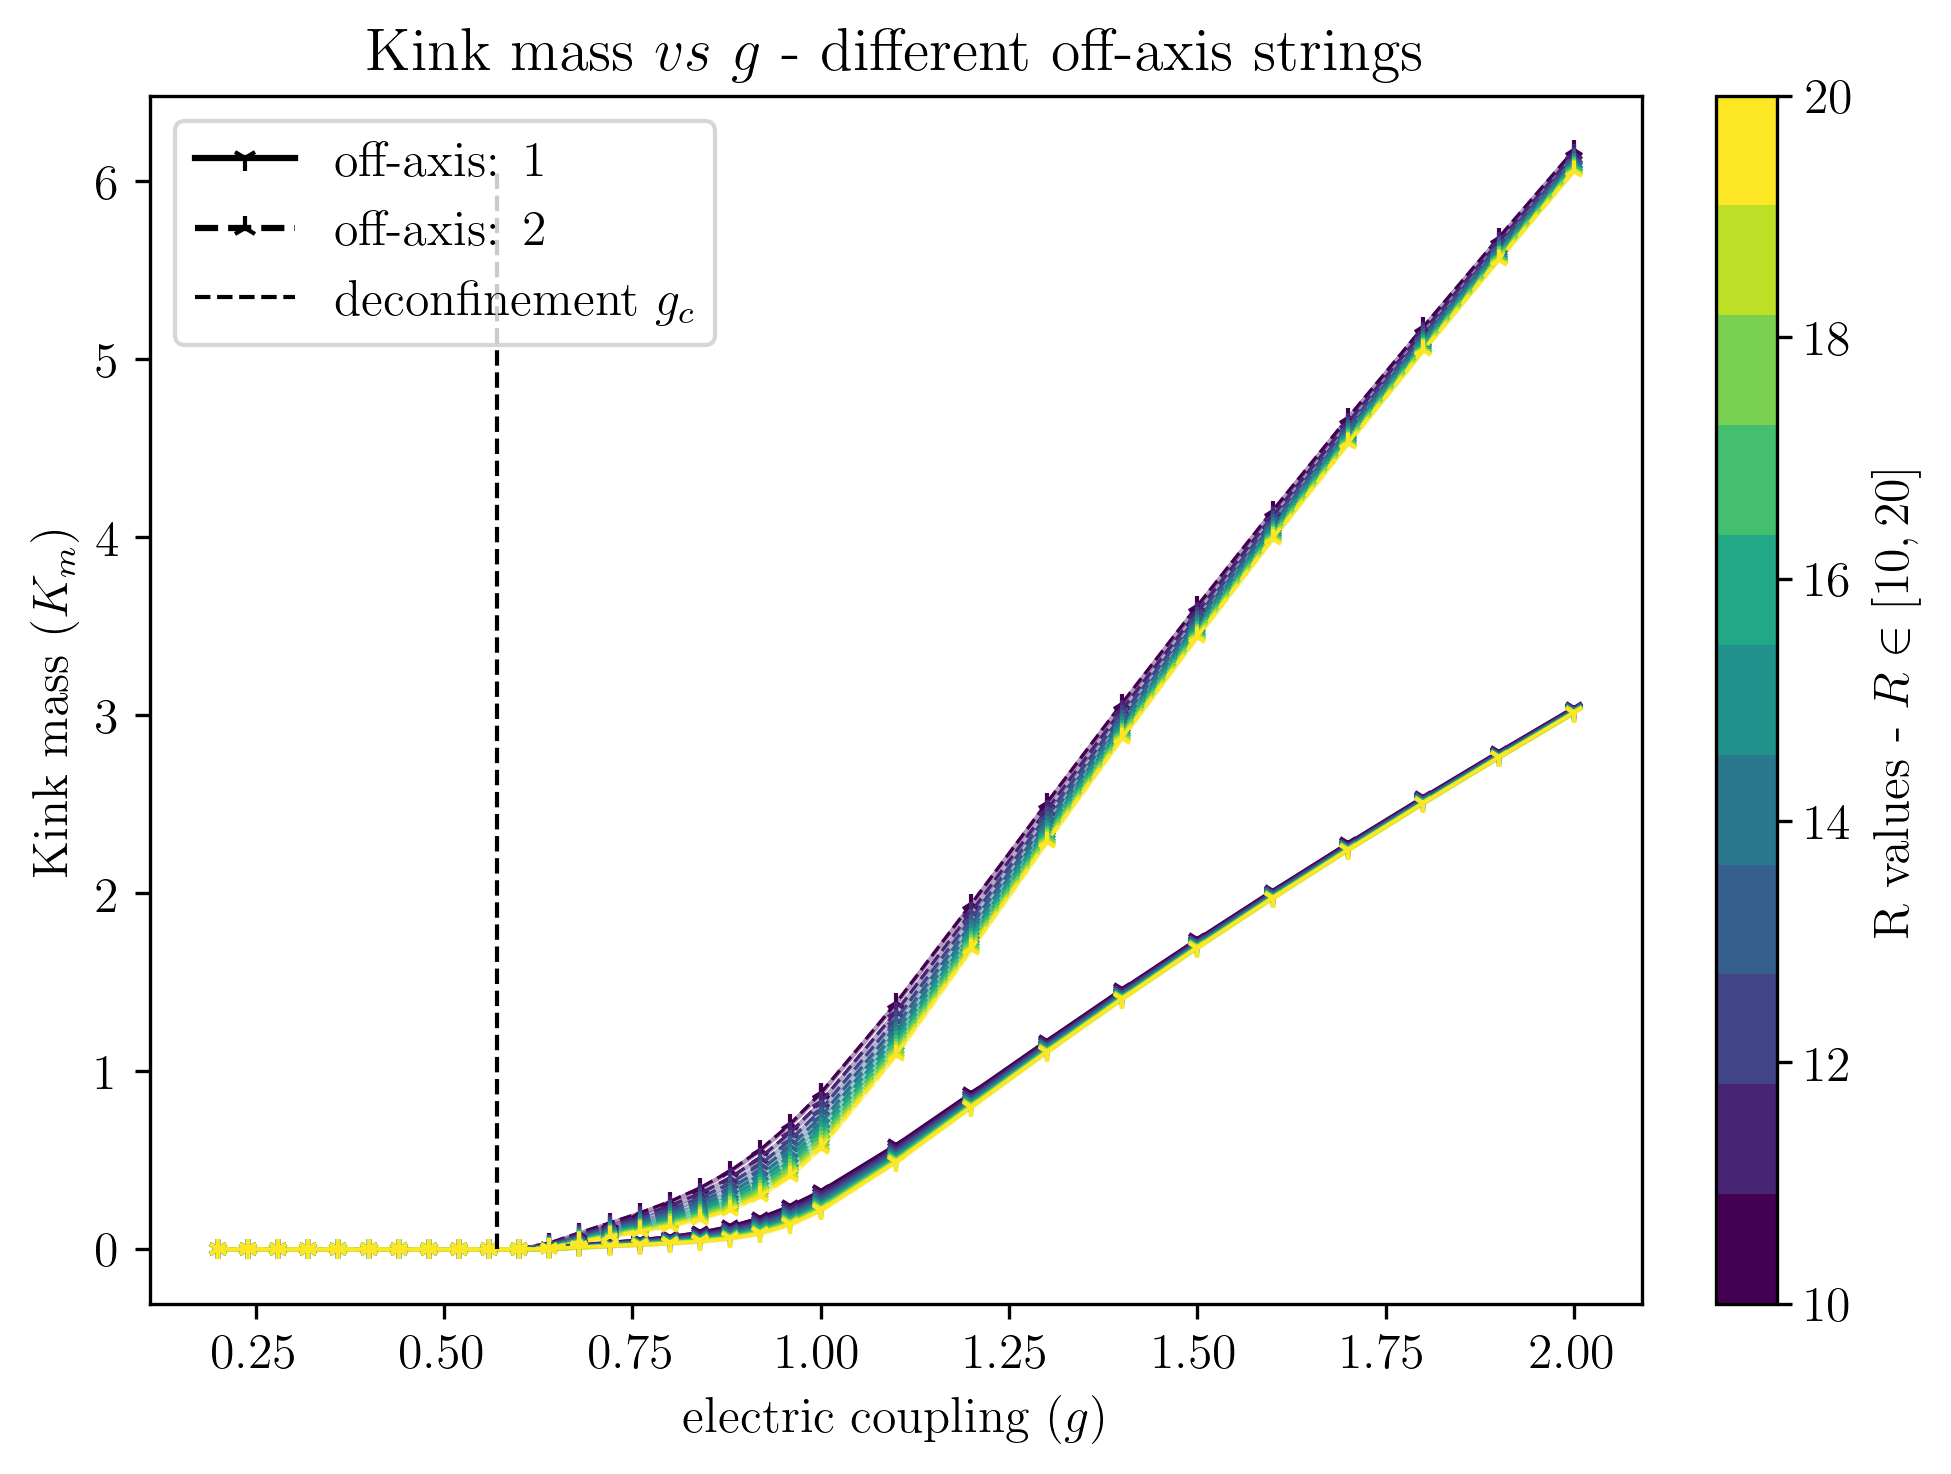

In [608]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

Rs = [10,11,12,13,14,15]
Rs = range(10,21)
colors = create_sequential_colors(len(Rs))
cmap = plt.get_cmap("viridis", len(Rs))  # Get a colormap with len(gs) colors
colors_pot = create_sequential_colors(len(Rs), colormap_name="Reds")
l, L = 5, 30
Ls = [L]

linestyles = ["-", "--"]
markers = ["1","2"]
cx = None
cy = None

fig, ax = plt.subplots()

for i, R in enumerate(Rs):
    h_i, h_f, npoints = 0.2, 1.0, 21
    gs = np.linspace(h_i,h_f,npoints)
    
    for off in range(2):

        R_off = np.sqrt(R**2 + (off+1)**2)
        cy_off_axis = [0,off+1]
        kms, kms_err = n_order_kink_mass_varying_g(gs,R,l,L,chis,bc,sector,h_i,h_f,npoints,path_tensor,cx,cy,cy_off_axis)
        ax.plot(gs, np.abs(kms), marker=markers[off], markersize=5, linestyle=linestyles[off], color=colors[i], linewidth=0.8, label=f"off-axis: ${off+1}$,  $R: {R}$")
        ax.fill_between(gs, y1=np.abs(np.asarray(kms)+np.asarray(kms_err)),y2=np.abs(np.asarray(kms)-np.asarray(kms_err)), color=colors[i], alpha=0.4)

    h_i, h_f, npoints = 1.0, 2.0, 11
    gs = np.linspace(h_i,h_f,npoints)

    for off in range(2):

        R_off = np.sqrt(R**2 + (off+1)**2)
        cy_off_axis = [0,off+1]
        kms, kms_err = n_order_kink_mass_varying_g(gs,R,l,L,chis,bc,sector,h_i,h_f,npoints,path_tensor,cx,cy,cy_off_axis)
        ax.plot(gs, np.abs(kms), marker=markers[off], markersize=5, linestyle=linestyles[off], color=colors[i], linewidth=0.8)
        ax.fill_between(gs, y1=np.abs(np.asarray(kms)+np.asarray(kms_err)),y2=np.abs(np.asarray(kms)-np.asarray(kms_err)), color=colors[i], alpha=0.4)

# Create a ScalarMappable for the colorbar
norma = mcolors.Normalize(vmin=min(Rs), vmax=max(Rs))
sm = cm.ScalarMappable(cmap=cmap, norm=norma)
sm.set_array([])  # Required for colorbar

# Add the colorbar
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(f"R values -  $R \\in [{Rs[0]},{Rs[-1]}]$")  # Label for colorbar


plt.title("Kink mass $vs$ $g$  - different off-axis strings")
plt.xlabel("electric coupling $(g)$")
plt.ylabel("Kink mass $(K_m)$")

# Create black legend handles
solid_line = plt.Line2D([0], [0], linestyle='-', marker='1', color='k', label='off-axis: $1$')
dashed_line = plt.Line2D([0], [0], linestyle='--', marker='2', color='k', label='off-axis: $2$')

th_line = plt.vlines(x=0.57, ymin=0, ymax=max(np.abs(kms)), linestyles="--", colors='black', linewidth=1, label="deconfinement $g_c$")

# Add legend with only black handles
plt.legend(handles=[solid_line, dashed_line, th_line])
# plt.legend()

# plt.yscale("log")

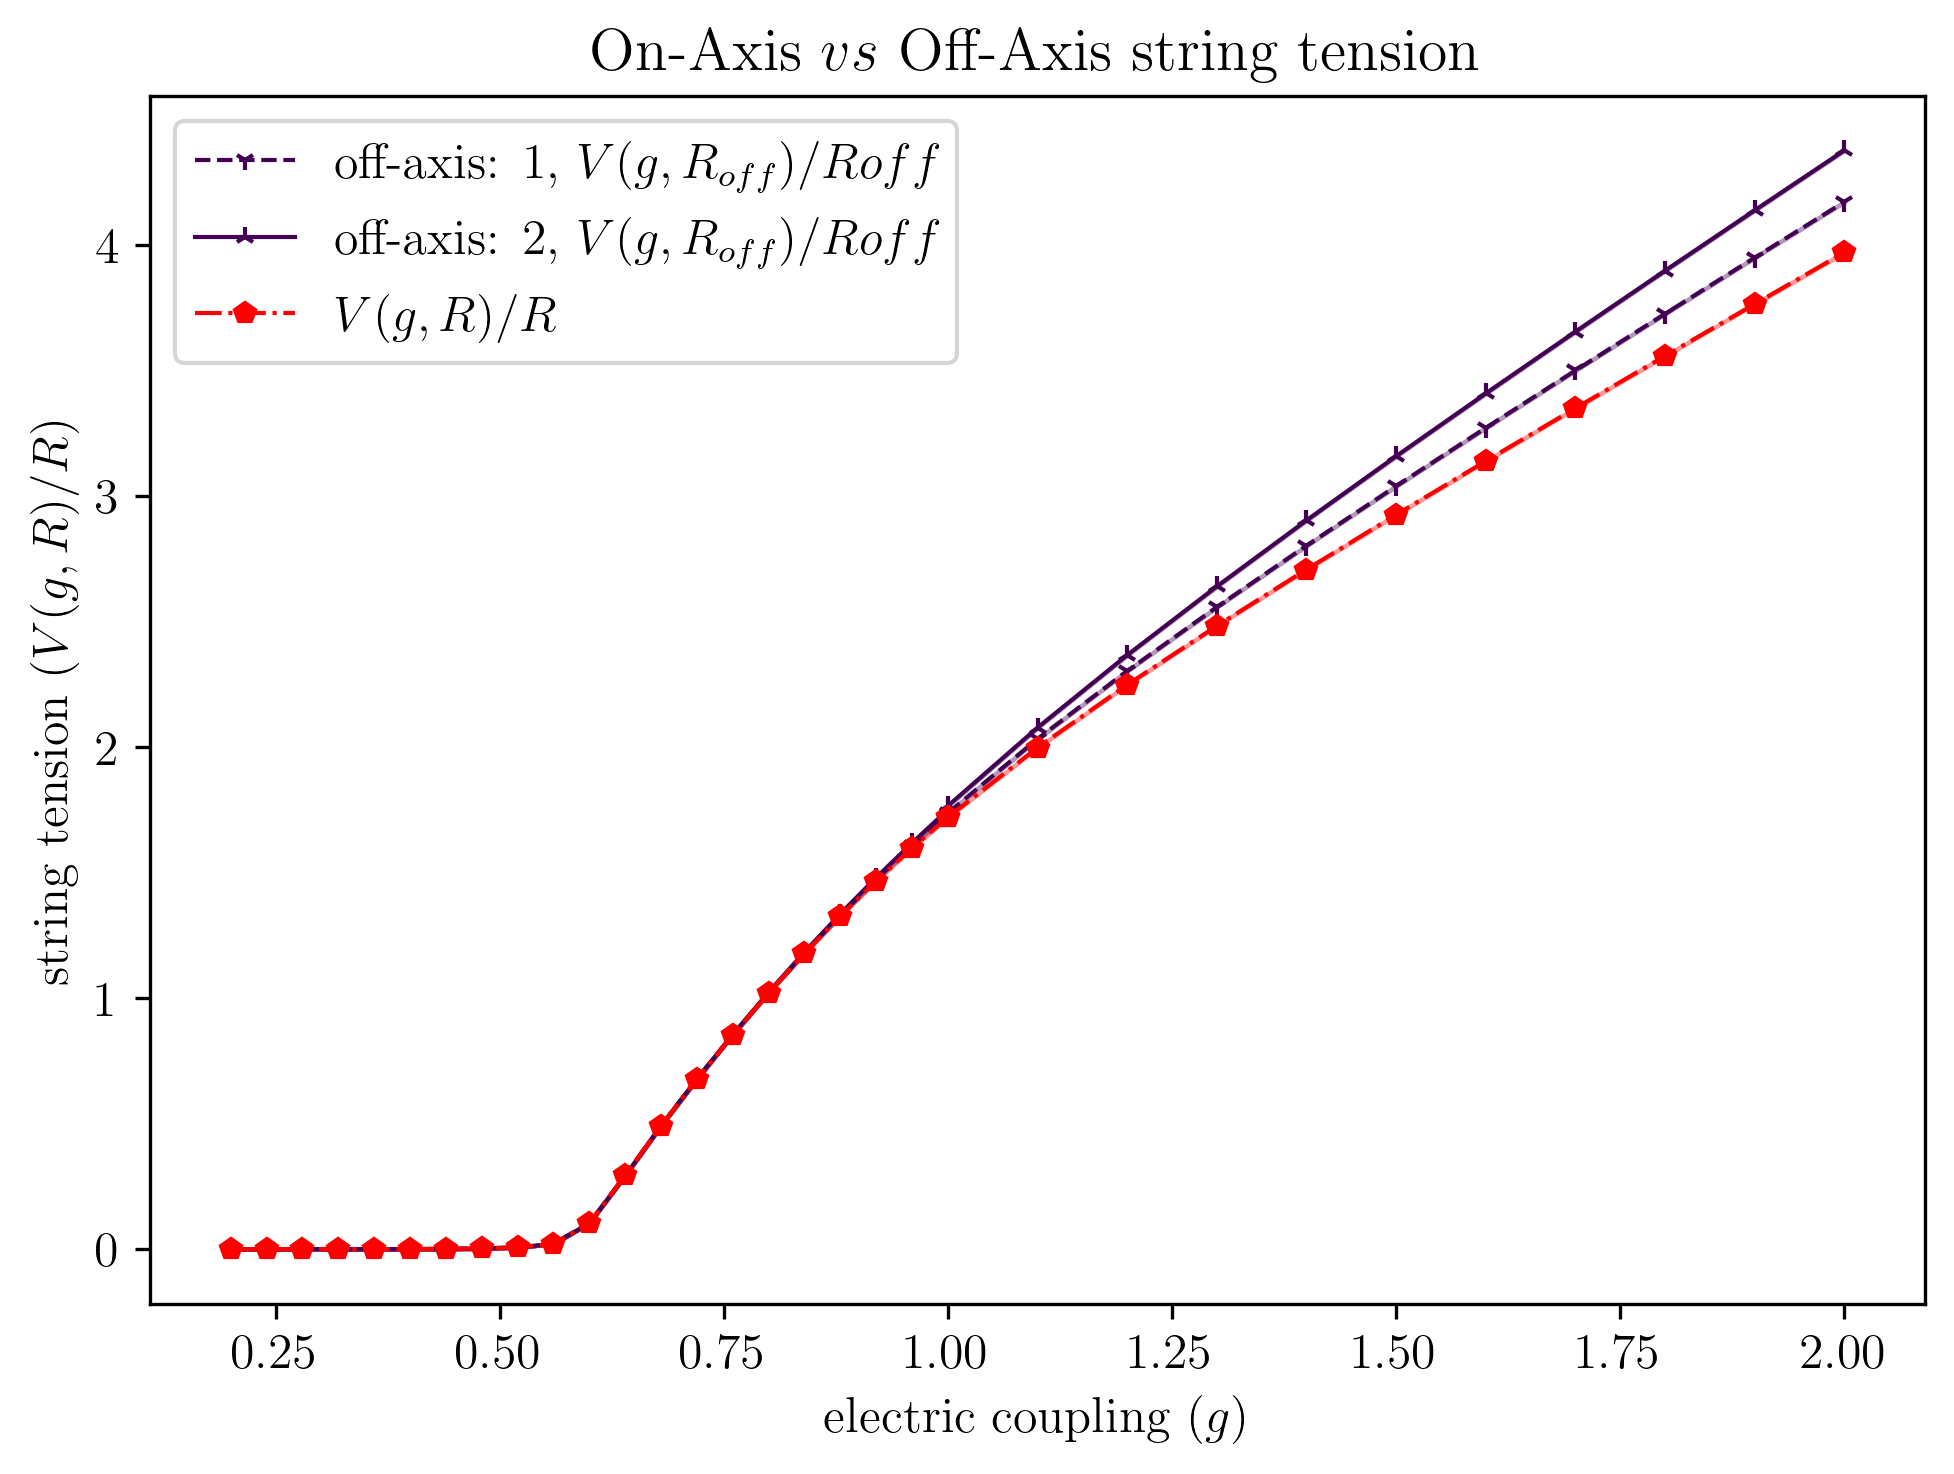

In [609]:
Rs = [15]
colors = create_sequential_colors(len(Rs))
colors_pot = create_sequential_colors(len(Rs), colormap_name="Reds")
colors_pot = ["red"]
l, L = 5, 30
Ls = [L]

linestyles = ["--", "-"]
markers = ["1","2"]
cx = None
cy = None

for i, R in enumerate(Rs):
    h_i, h_f, npoints = 0.2, 1.0, 21
    gs = np.linspace(h_i,h_f,npoints)
    
    for off in range(2):

        R_off = np.sqrt(R**2 + (off+1)**2)
        # R_off = R + (off+1)
        cy_off_axis = [0,off+1]

        pot, pot_err = static_potential_varying_g(gs,R,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor,cy=cy_off_axis)
        plt.plot(gs, np.asarray(pot)/R_off, marker=markers[off], markersize=5, linestyle=linestyles[off], color=colors[i], linewidth=1, label=f"off-axis: ${off+1}$, $V(g,R_{{off}})/R{{off}}$")
        plt.fill_between(gs, y1=(np.asarray(pot)+np.asarray(pot_err))/R_off,y2=(np.asarray(pot)-np.asarray(pot_err))/R_off, color=colors[i], alpha=0.4)

    pot, pot_err = static_potential_varying_g(gs,R,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor)
    plt.plot(gs, np.asarray(pot)/R, marker="p", markersize=5, linestyle="-.", color=colors_pot[i], linewidth=1, label="$V(g,R)/R$")
    plt.fill_between(gs, y1=(np.asarray(pot)+np.asarray(pot_err))/R,y2=(np.asarray(pot)-np.asarray(pot_err))/R, color=colors_pot[i], alpha=0.4)

    h_i, h_f, npoints = 1.0, 2.0, 11
    gs = np.linspace(h_i,h_f,npoints)

    for off in range(2):

        R_off = np.sqrt(R**2 + (off+1)**2)
        # R_off = R + (off+1)
        cy_off_axis = [0,off+1]

        pot, pot_err = static_potential_varying_g(gs,R,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor,cy=cy_off_axis)
        plt.plot(gs, np.asarray(pot)/R, marker=markers[off], markersize=5, linestyle=linestyles[off], color=colors[i], linewidth=1)
        plt.fill_between(gs, y1=(np.asarray(pot)+np.asarray(pot_err))/R,y2=(np.asarray(pot)-np.asarray(pot_err))/R, color=colors[i], alpha=0.4)


    pot, pot_err = static_potential_varying_g(gs,R,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor)
    plt.plot(gs, np.asarray(pot)/R, marker="p", markersize=5, linestyle="-.", color=colors_pot[i], linewidth=1)
    plt.fill_between(gs, y1=(np.asarray(pot)+np.asarray(pot_err))/R,y2=(np.asarray(pot)-np.asarray(pot_err))/R, color=colors_pot[i], alpha=0.4)

plt.title("On-Axis $vs$ Off-Axis string tension")
plt.xlabel("electric coupling $(g)$")
plt.ylabel("string tension $(V(g,R)/R)$")
plt.legend()

Text(0.5, 0, 'electric term $(g)$')

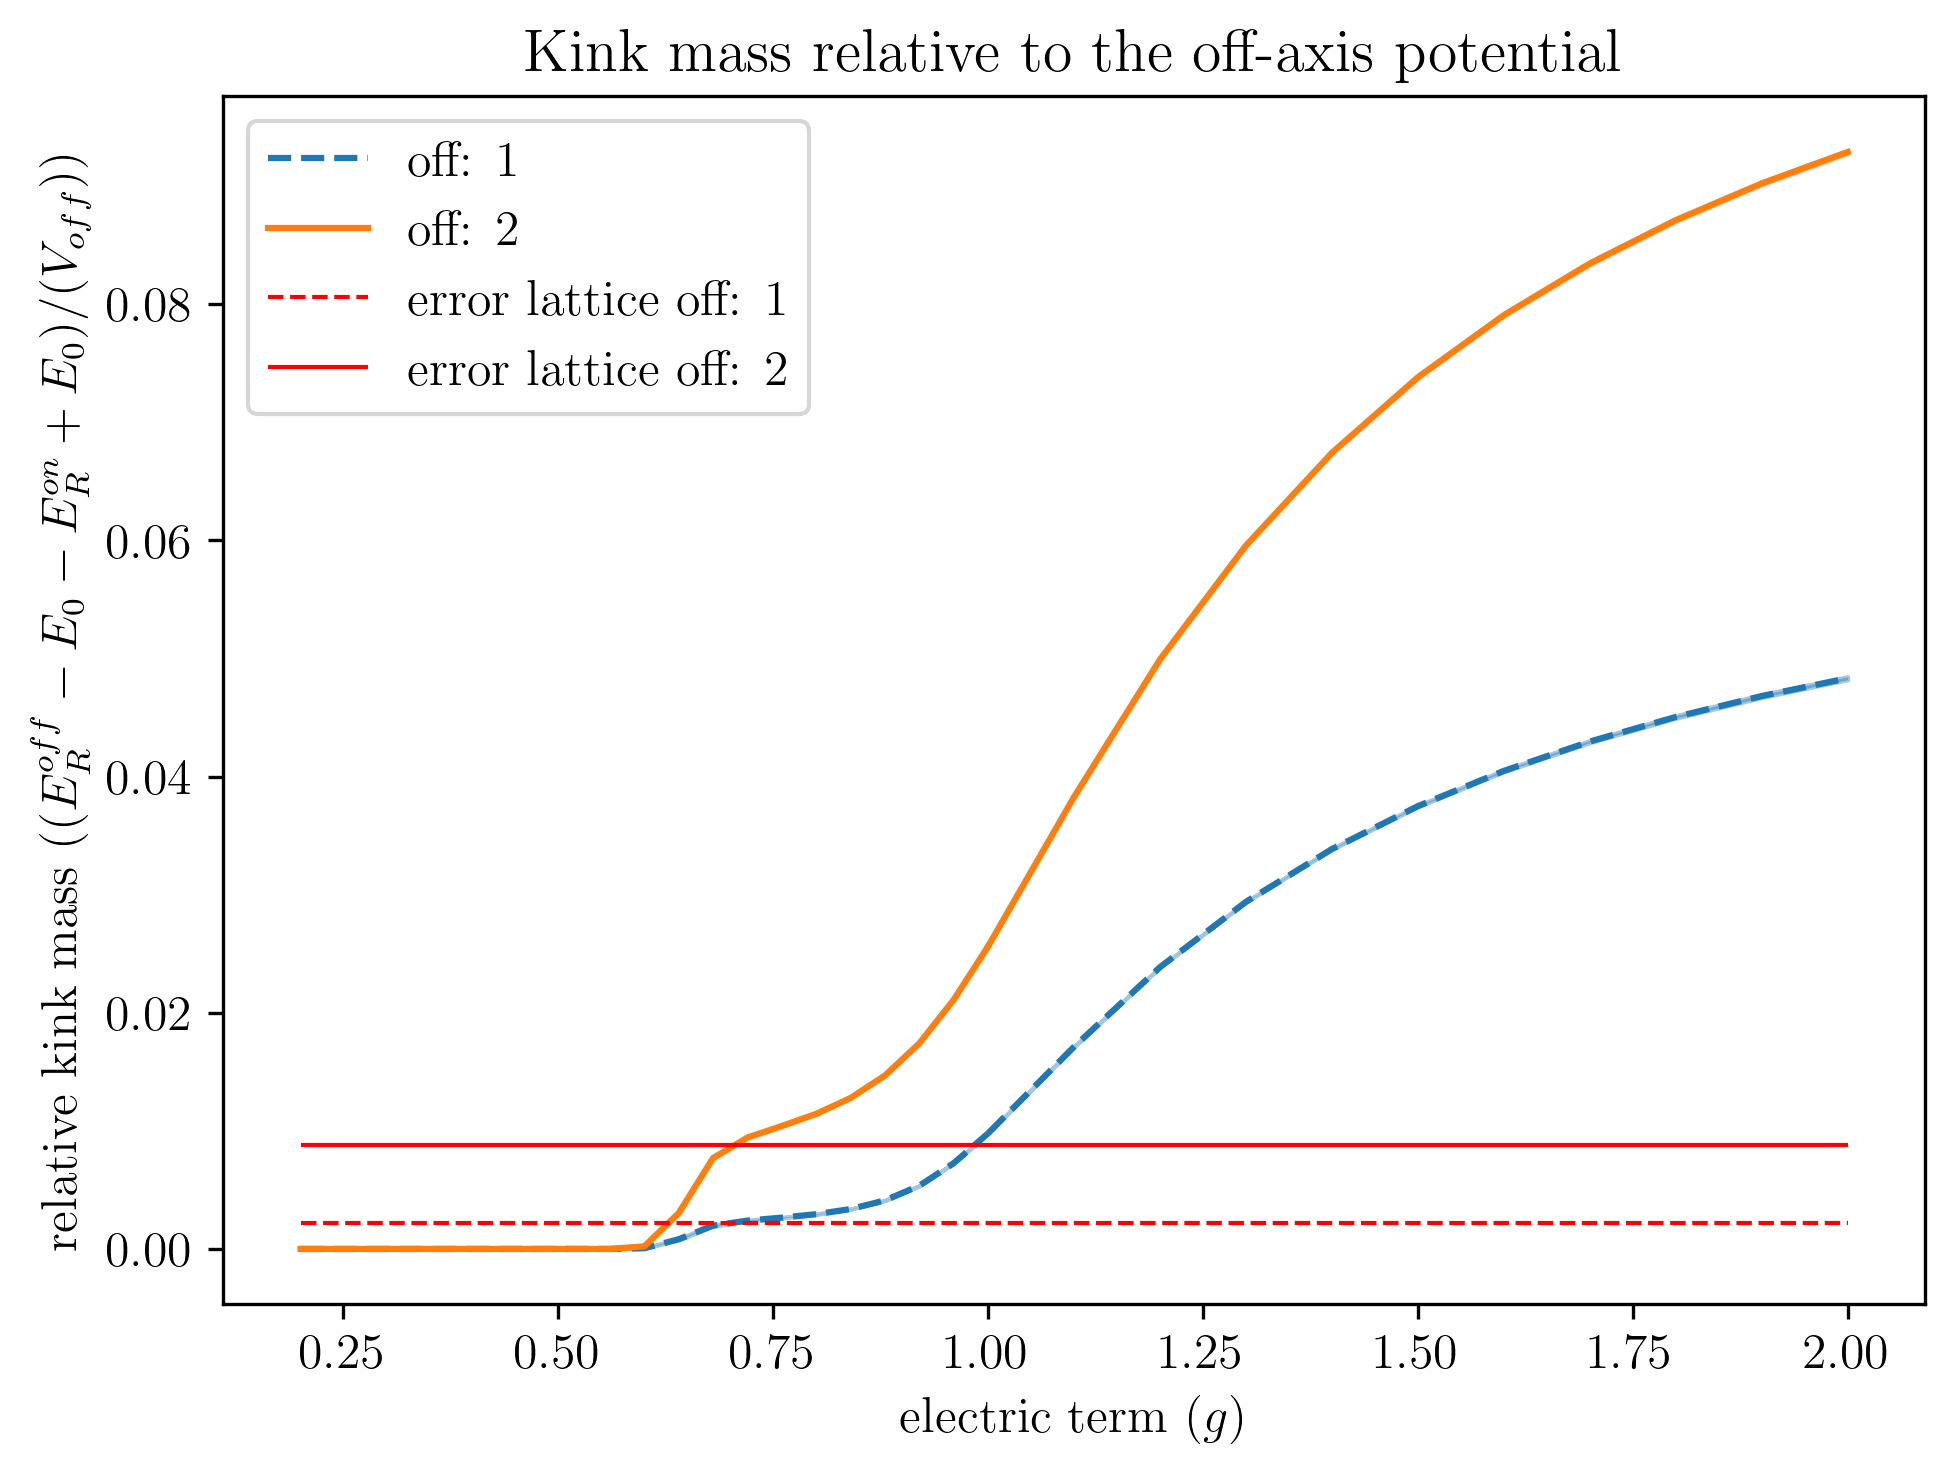

In [610]:
Rs = [10,11,12,13,14,15]
l, L = 5, 30
Ls = [L]
R = 15
linestyles = ["--", "-"]
markers = ["1","2"]
cx = None
cy = None

h_i, h_f, npoints = 0.2, 1.0, 21
gs = np.linspace(h_i,h_f,npoints)
pot, pot_err = static_potential_varying_g(gs,R,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor)
    
for off in range(2):

    R_off = np.sqrt(R**2 + (off+1)**2)
    cy_off_axis = [0,off+1]

    pot_off, pot_off_err = static_potential_varying_g(gs,R,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor,cy=cy_off_axis)
    # diff = (np.asarray(pot_off) - np.asarray(pot))
    diff = (np.asarray(pot_off) - np.asarray(pot))/np.asarray(pot_off)
    diff_err = np.asarray(pot_off_err) + np.asarray(pot_err)
    plt.plot(gs, diff, linestyle=linestyles[off], color=f"C{off}", zorder=off, label=f"off: {off+1}")
    plt.fill_between(gs, y1=diff+diff_err,y2=diff-diff_err, alpha=0.4, color=f"C{off}", zorder=off)
    

h_i, h_f, npoints = 1.0, 2.0, 11
gs = np.linspace(h_i,h_f,npoints)
pot, pot_err = static_potential_varying_g(gs,R,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor)
    
for off in range(2):

    R_off = np.sqrt(R**2 + (off+1)**2)
    cy_off_axis = [0,off+1]

    pot_off, pot_off_err = static_potential_varying_g(gs,R,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor,cy=cy_off_axis)
    # diff = (np.asarray(pot_off) - np.asarray(pot))
    diff = (np.asarray(pot_off) - np.asarray(pot))/np.asarray(pot_off)
    diff_err = np.asarray(pot_off_err) + np.asarray(pot_err)
    plt.plot(gs, diff, linestyle=linestyles[off], color=f"C{off}", zorder=off)
    plt.fill_between(gs, y1=diff+diff_err,y2=diff-diff_err, alpha=0.4, color=f"C{off}", zorder=off)
    
    err_lattice = (R_off - R)/R_off
    # err_lattice = R/(R+off+1)
    plt.hlines(y=err_lattice, xmin=0.2, xmax=2.0, linestyles=linestyles[off], linewidth=1, colors="red", label=f"error lattice off: {off+1}")


plt.legend()
plt.title("Kink mass relative to the off-axis potential")
plt.ylabel("relative kink mass $( (E_R^{off} - E_0 - E_R^{on} + E_0) / (V_{off}) )$")
plt.xlabel("electric term $(g)$")
# plt.ylim(top=0.05)

This quantity should trigger the relative error of the off-axis string length

$$\epsilon_r = \frac{R_{off} - R}{R_{off}}$$

Careful: We assume the string tension of the on and off axis fluxtubes to be the same!

$$ \frac{(V_{cross}^{off} - V_{cross}^{on})}{V_{cross}^{off}} = \frac{\sigma_{off}R_{off} - \sigma_{on}R}{\sigma_{off} R_{off}} + corr. = \frac{\sigma(R_{off} - R)}{\sigma R_{off}} + corr. = \epsilon_r + corr.$$ 

/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_75143/3587438067.py:23: RuntimeWarning: divide by zero encountered in divide
  obs_err = obs * np.sqrt(np.asarray(kms_err)**2/np.asarray(kms)**2 + np.asarray(sigma_err)**2/np.asarray(sigma)**2)
/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_75143/3587438067.py:23: RuntimeWarning: invalid value encountered in multiply
  obs_err = obs * np.sqrt(np.asarray(kms_err)**2/np.asarray(kms)**2 + np.asarray(sigma_err)**2/np.asarray(sigma)**2)


Text(0.5, 1.0, 'Norm 1 to Norm 2 transition through roughening')

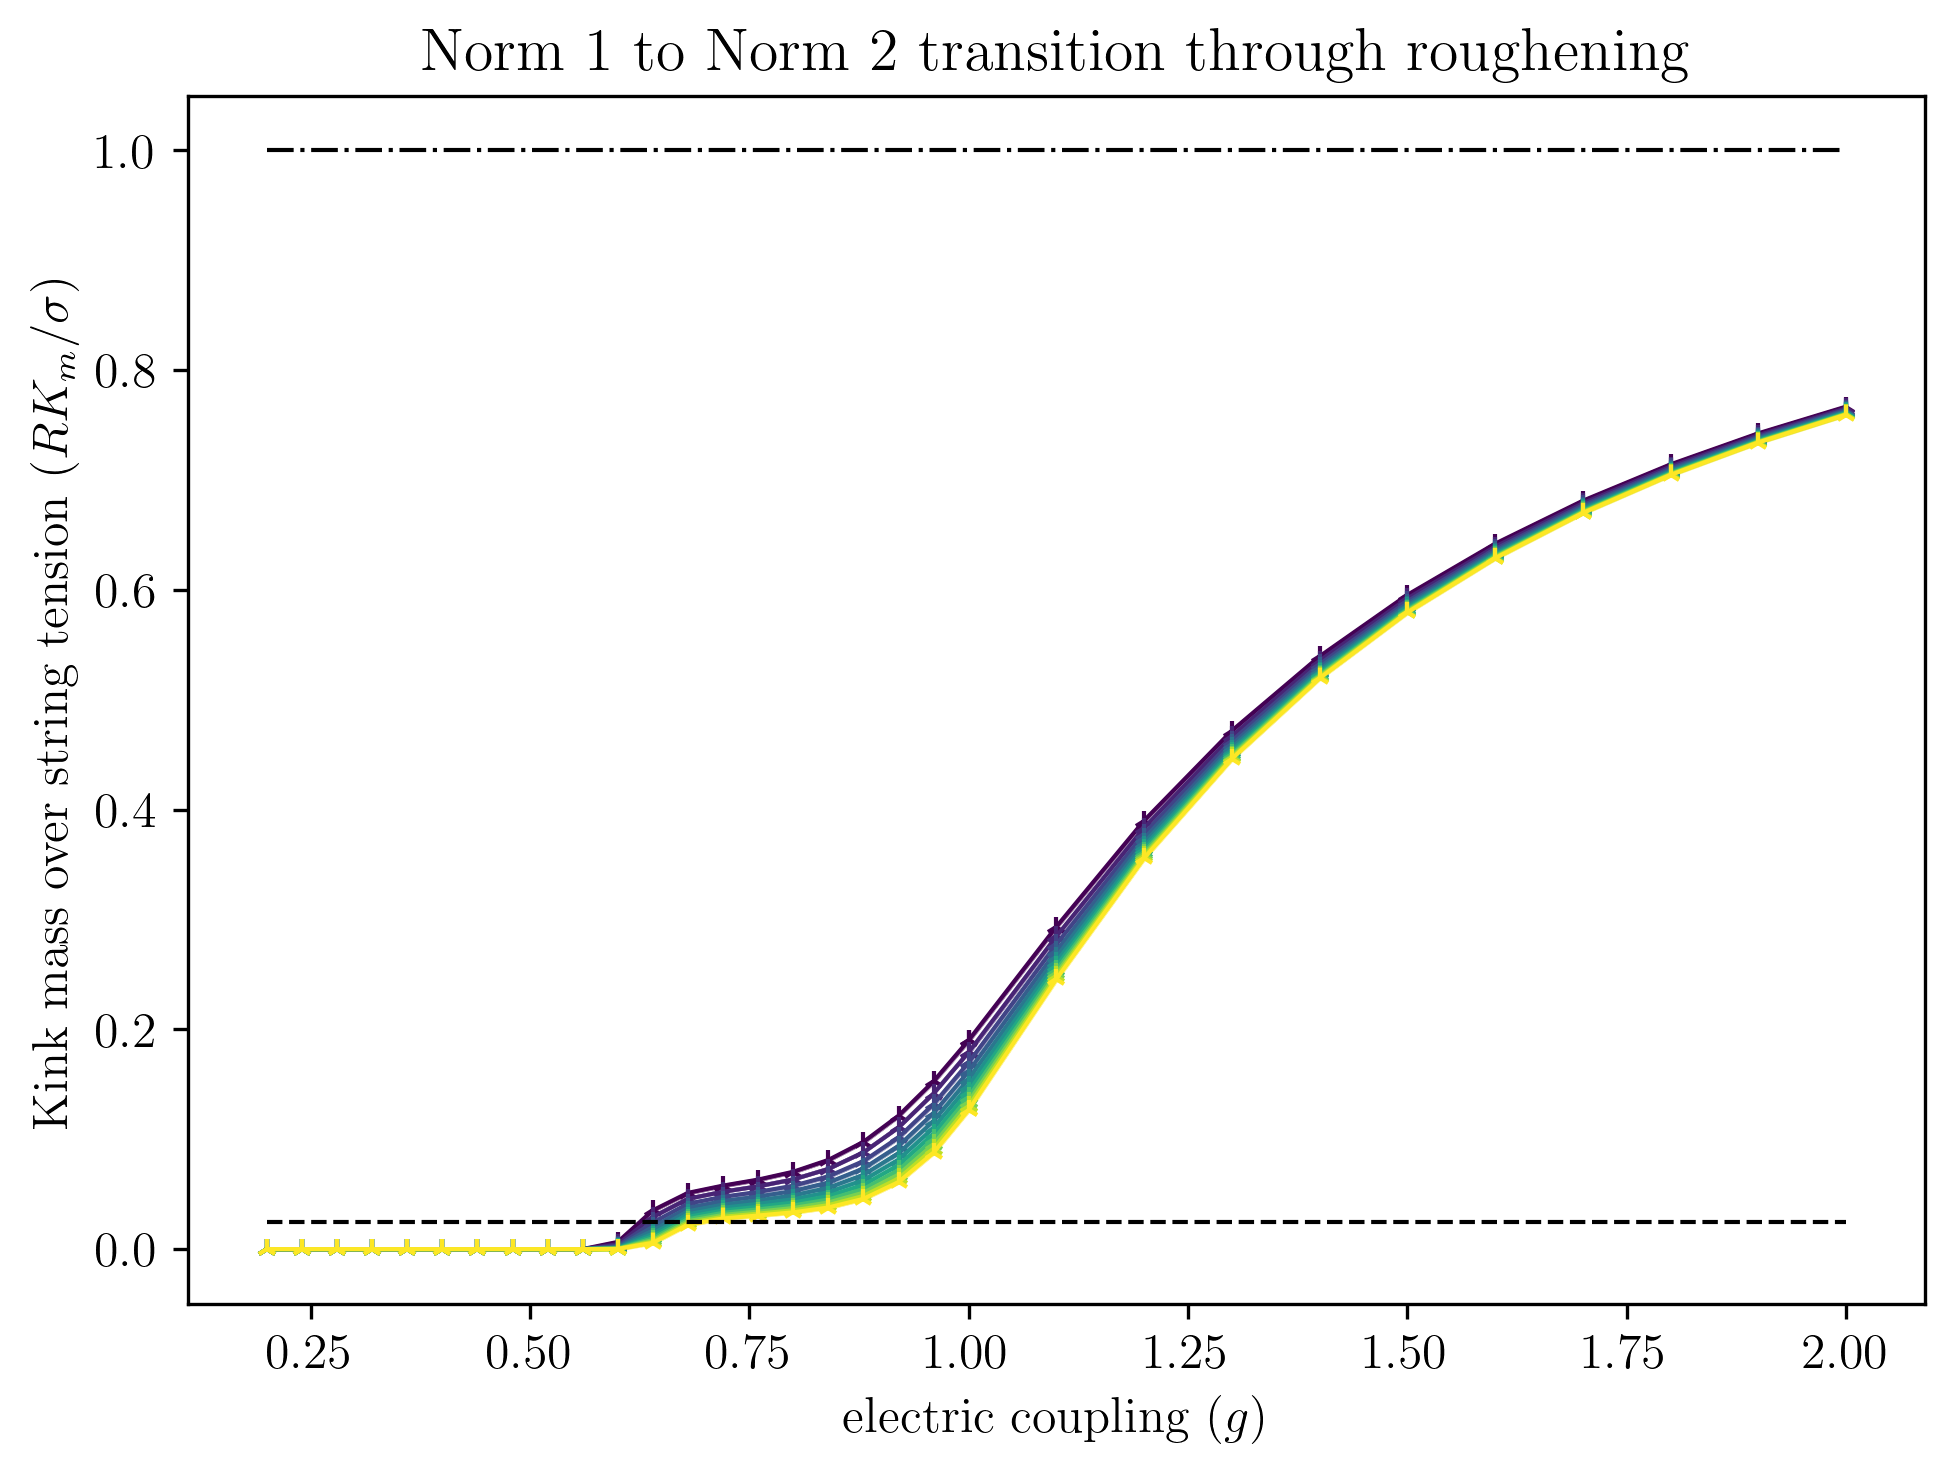

In [611]:
# cx = None
# cy = None
cy_off_axis = [0,1]

l = 6
h_i, h_f, npoints = 0.6, 0.95, 15
gs = np.linspace(h_i,h_f,npoints)
chis = [64,128]
Rs = [10,11,12,13,14,15,16,17,19]
colors = create_sequential_colors(len(Rs))

l = 5
h_i, h_f, npoints = 0.2, 1.0, 21
gs = np.linspace(h_i,h_f,npoints)
Rs = list(range(10,21))
colors = create_sequential_colors(len(Rs))

sigma, sigma_err = get_fit_params(gs,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor,cx,cy_off_axis,fit=2,param=0)
for i, R in enumerate(Rs):
    
    kms, kms_err = n_order_kink_mass_varying_g(gs,R,l,L,chis,bc,sector,h_i,h_f,npoints,path_tensor,cx,cy,cy_off_axis)
    obs = np.abs(kms)/np.asarray(sigma)
    obs_err = obs * np.sqrt(np.asarray(kms_err)**2/np.asarray(kms)**2 + np.asarray(sigma_err)**2/np.asarray(sigma)**2)
    
    plt.plot(gs, obs, marker=markers[off], markersize=5, linestyle=linestyles[off], color=colors[i], linewidth=1, label=f"$R: {R}$")
    plt.fill_between(gs,y1=obs+obs_err, y2=obs-obs_err, alpha=0.4, color=colors[i])



h_i, h_f, npoints = 1.0, 2.0, 11
gs = np.linspace(h_i,h_f,npoints)

sigma, sigma_err = get_fit_params(gs,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor,cx,cy_off_axis,fit=3,param=0)
for i, R in enumerate(Rs):
    
    kms, kms_err = n_order_kink_mass_varying_g(gs,R,l,L,chis,bc,sector,h_i,h_f,npoints,path_tensor,cx,cy,cy_off_axis)
    obs = np.abs(kms)/np.asarray(sigma)
    obs_err = obs * np.sqrt(np.asarray(kms_err)**2/np.asarray(kms)**2 + np.asarray(sigma_err)**2/np.asarray(sigma)**2)
    
    plt.plot(gs, obs, marker=markers[off], markersize=5, linestyle=linestyles[off], color=colors[i], linewidth=1)
    plt.fill_between(gs,y1=obs+obs_err, y2=obs-obs_err, alpha=0.4, color=colors[i])


# l, L = 6, 30
# h_i, h_f, npoints = 0.4, 5.0, 33
# gs = np.linspace(h_i,h_f,npoints)

# sigma, sigma_err = get_fit_params(gs,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor,cx,cy_off_axis,fit=3,param=0)
# for i, R in enumerate(Rs):
    
#     cy_off_axis = [0,1]
#     kms, kms_err = n_order_kink_mass_varying_g(gs,R,l,L,chis,bc,sector,h_i,h_f,npoints,path_tensor,cx,cy,cy_off_axis)
#     plt.plot(gs, np.abs(kms)/np.asarray(sigma), marker=markers[off], markersize=5, linestyle=linestyles[off], color=colors[i], linewidth=1)


eucldist = np.sqrt(R**2+1) - R
norm1dist = R + 1 - R
plt.hlines(y=eucldist, xmin=0.2, xmax=2.0, linestyles="--", colors='black', linewidth=1, label="euclidian distance $\\epsilon_{2}$")
plt.hlines(y=norm1dist, xmin=0.2, xmax=2.0, linestyles="-.", colors='black', linewidth=1, label="norm 1 distance $\\epsilon_{1}$")
# plt.hlines(y=1/2, xmin=0.6, xmax=0.95, linestyles="-.", colors='black', linewidth=1, label="norm 2 lim $R \\rightarrow \\infty$")
# plt.legend()
# plt.xlim(0.6,0.95)
# plt.ylim(0,2)
plt.ylabel("Kink mass over string tension $(R K_m/\\sigma)$")
plt.xlabel("electric coupling $(g)$")
plt.title("Norm 1 to Norm 2 transition through roughening")
# plt.yscale("log")

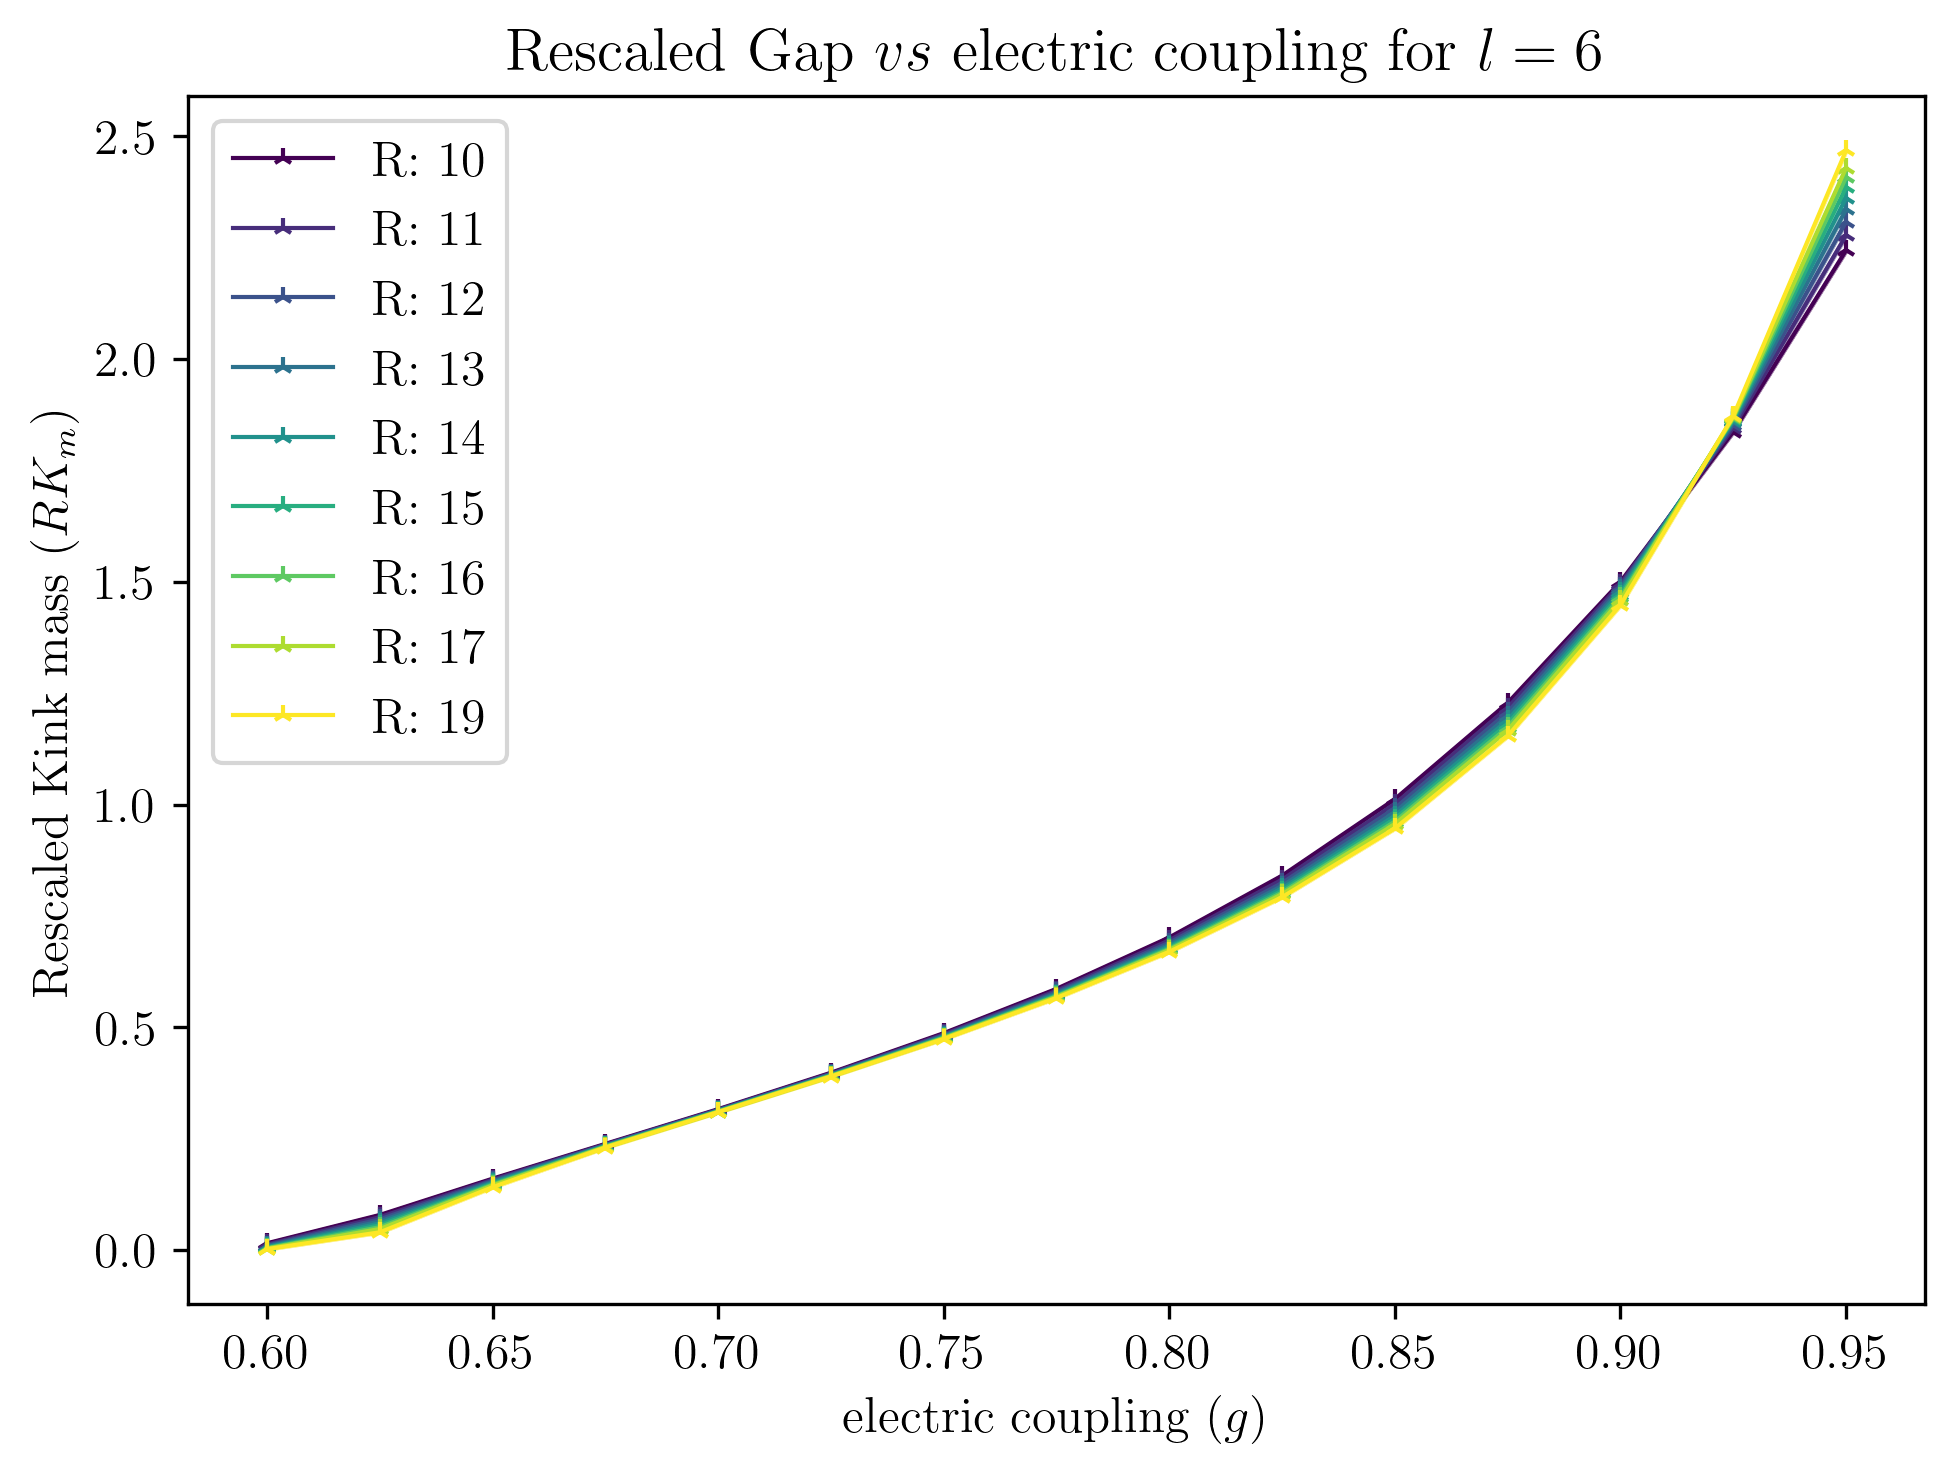

In [612]:
l = 5
h_i, h_f, npoints = 0.8, 1.0, 41
gs = np.linspace(h_i,h_f,npoints)
Rs = np.linspace(10,20,11)

l = 6
h_i, h_f, npoints = 0.6, 0.95, 15
gs = np.linspace(h_i,h_f,npoints)
Rs = np.array([10,11,12,13,14,15,16,17,19])

colors = create_sequential_colors(len(Rs))

sigma, sigma_err = get_fit_params(gs,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor,cx,cy_off_axis,fit=1,param=0)
for i, R in enumerate(Rs):
    
    kms, kms_err = n_order_kink_mass_varying_g(gs,R,l,L,chis,bc,sector,h_i,h_f,npoints,path_tensor,cx,cy,cy_off_axis)
    obs = np.abs(kms)/np.asarray(sigma)
    obs = R * np.abs(kms)
    obs_err = obs * np.sqrt(np.asarray(kms_err)**2/np.asarray(kms)**2 + np.asarray(sigma_err)**2/np.asarray(sigma)**2)
    obs_err = np.asarray(kms_err)
    
    plt.plot(gs, obs, marker=markers[off], markersize=5, linestyle=linestyles[off], color=colors[i], linewidth=1, label=f"R: {int(R)}")
    plt.fill_between(gs,y1=obs+obs_err, y2=obs-obs_err, alpha=0.4, color=colors[i])


eucldist = np.sqrt(R**2+1) - R
norm1dist = R + 1 - R
# plt.hlines(y=eucldist, xmin=0.8, xmax=1.0, linestyles="--", colors='black', linewidth=1, label="euclidian distance $\\epsilon_{2}$")
# plt.hlines(y=norm1dist, xmin=0.2, xmax=2.0, linestyles="-.", colors='black', linewidth=1, label="norm 1 distance $\\epsilon_{1}$")
# plt.hlines(y=1/2, xmin=0.6, xmax=0.95, linestyles="-.", colors='black', linewidth=1, label="norm 2 lim $R \\rightarrow \\infty$")
plt.legend()
# plt.xlim(0.6,0.95)
# plt.ylim(0,2)
plt.ylabel("Kink mass over string tension $(R K_m/\\sigma)$")
plt.ylabel("Rescaled Kink mass $(R K_m)$")
plt.xlabel("electric coupling $(g)$")
plt.title("Norm 1 to Norm 2 transition through roughening")
plt.title(f"Rescaled Gap $vs$ electric coupling for $l={l}$")
plt.savefig(f"{path_figures}/figures/fluxtube/rescaled_gap_vs_coupling_z2_dual_{l}x{L}_Rs_{Rs}_h_{h_i}-{h_f}_npoints_{npoints}_chis_{chis}.png")
# plt.yscale("log")

[0.905, 0.915, 0.92, 0.925, 0.93, 0.93, 0.935, 0.9400000000000001, 0.9400000000000001, 0.9450000000000001, 0.9450000000000001]


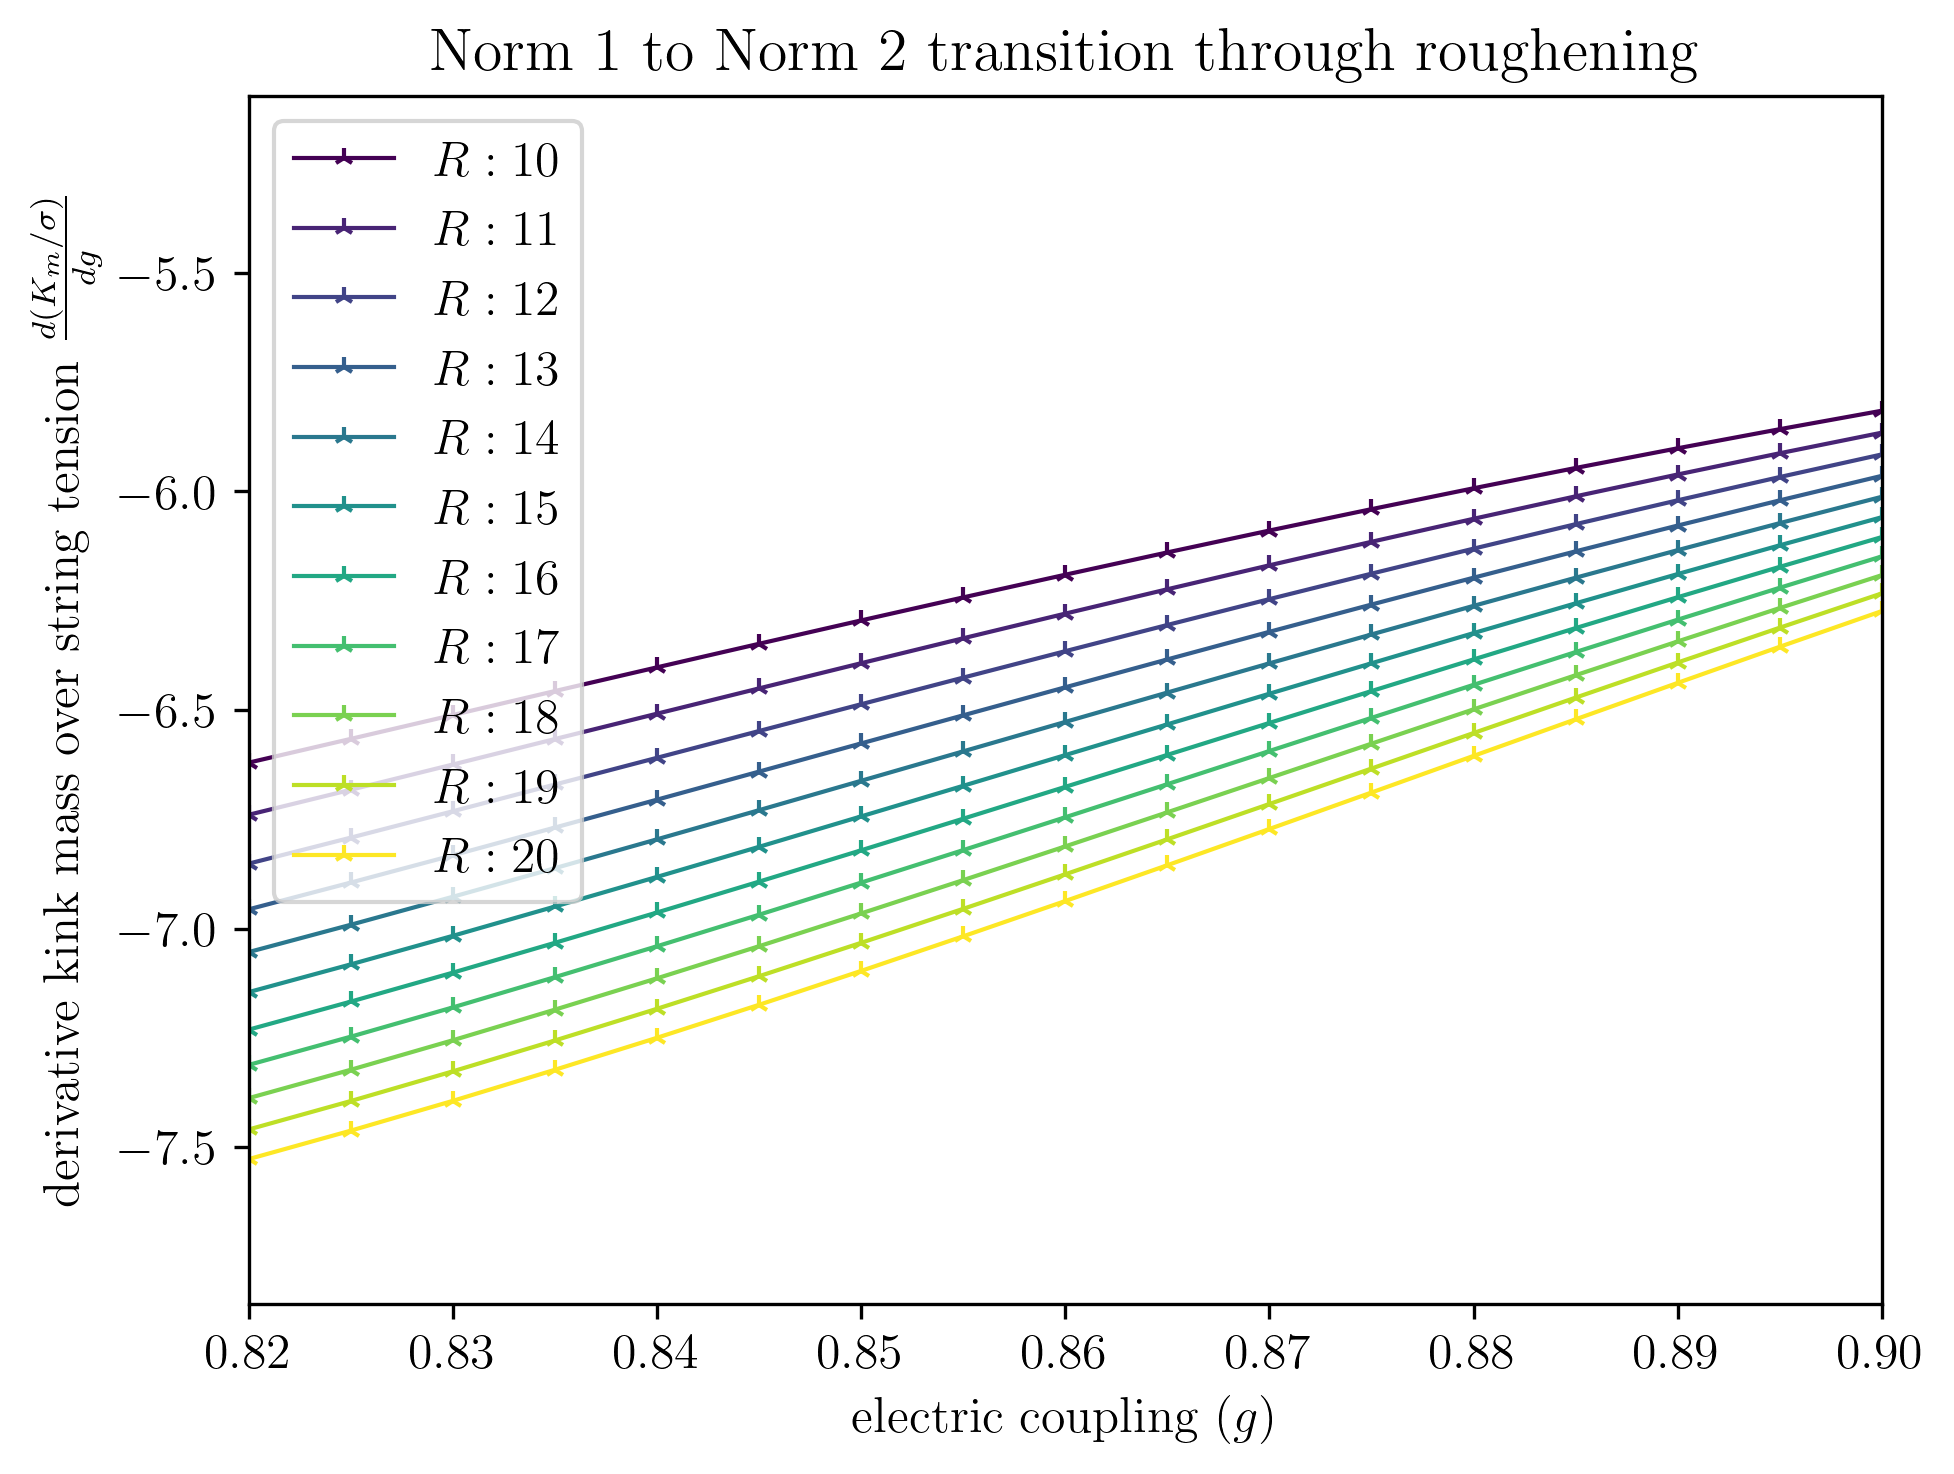

In [613]:
l = 5
h_i, h_f, npoints = 0.2, 1.0, 21
gs = np.linspace(h_i,h_f,npoints)
Rs = list(range(10,21))
colors = create_sequential_colors(len(Rs))

l = 5
h_i, h_f, npoints = 0.8, 1.0, 41
gs = np.linspace(h_i,h_f,npoints)
Rs = np.linspace(10,20,11)

# l = 6
# h_i, h_f, npoints = 0.6, 0.95, 15
# gs = np.linspace(h_i,h_f,npoints)
# chis = [64,128]
# Rs = [10,11,12,13,14,15,16,17,19]
cy = [0,0]
cy_off_axis = [0,1]

colors = create_sequential_colors(len(Rs))

min_vals = []
sigma, sigma_err = get_fit_params(gs,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor,cx,cy_off_axis,fit=1,param=0)
for i, R in enumerate(Rs):
    
    kms, kms_err = n_order_kink_mass_varying_g(gs,R,l,L,chis,bc,sector,h_i,h_f,npoints,path_tensor,cx,cy,cy_off_axis)
    obs = np.abs(kms)/np.asarray(sigma)
    
    plt.plot(gs, np.log(np.gradient(obs)), marker=markers[off], markersize=5, linestyle="-", color=colors[i], linewidth=1, label=f"$R: {int(R)}$")
    min_vals.append(np.argmax(np.log(np.gradient(np.gradient(obs)))))
# h_i, h_f, npoints = 1.0, 2.0, 11
# gs = np.linspace(h_i,h_f,npoints)

# sigma, sigma_err = get_fit_params(gs,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor,cx,cy_off_axis,fit=3,param=0)
# for i, R in enumerate(Rs):
    
#     cy_off_axis = [0,1]
#     kms, kms_err = n_order_kink_mass_varying_g(gs,R,l,L,chis,bc,sector,h_i,h_f,npoints,path_tensor,cx,cy,cy_off_axis)
#     plt.plot(gs, np.abs(kms)/np.asarray(sigma), marker=markers[off], markersize=5, linestyle=linestyles[off], color=colors[i], linewidth=1)


eucldist = np.sqrt(R**2+1) - R
norm1dist = R + 1 - R
# plt.hlines(y=eucldist, xmin=0.2, xmax=2.0, linestyles="--", colors='black', linewidth=1, label="euclidian distance $\\epsilon_{2}$")
# plt.hlines(y=norm1dist, xmin=0.2, xmax=2.0, linestyles="-.", colors='black', linewidth=1, label="norm 1 distance $\\epsilon_{1}$")
plt.legend()
plt.xlim(0.82,0.9)
plt.ylabel("derivative kink mass over string tension $\\frac{d(K_m/\\sigma)}{dg}$")
plt.xlabel("electric coupling $(g)$")
plt.title("Norm 1 to Norm 2 transition through roughening")
print([gs[val] for val in min_vals])

 - - kink - -         R: 12.0, g_r: 0.850 +/- 0.0
 - - kink - -         R: 13.0, g_r: 0.850 +/- 0.0
 - - kink - -         R: 14.0, g_r: 0.850 +/- 0.0
 - - kink - -         R: 15.0, g_r: 0.850 +/- 0.0
 - - kink - -         R: 16.0, g_r: 0.850 +/- 0.0
 - - kink - -         R: 17.0, g_r: 0.850 +/- 0.0
 - - kink - -         R: 18.0, g_r: 0.850 +/- 0.0
 - - kink - -         R: 19.0, g_r: 0.850 +/- 0.0
 - - kink - -         R: 20.0, g_r: 0.850 +/- 0.0


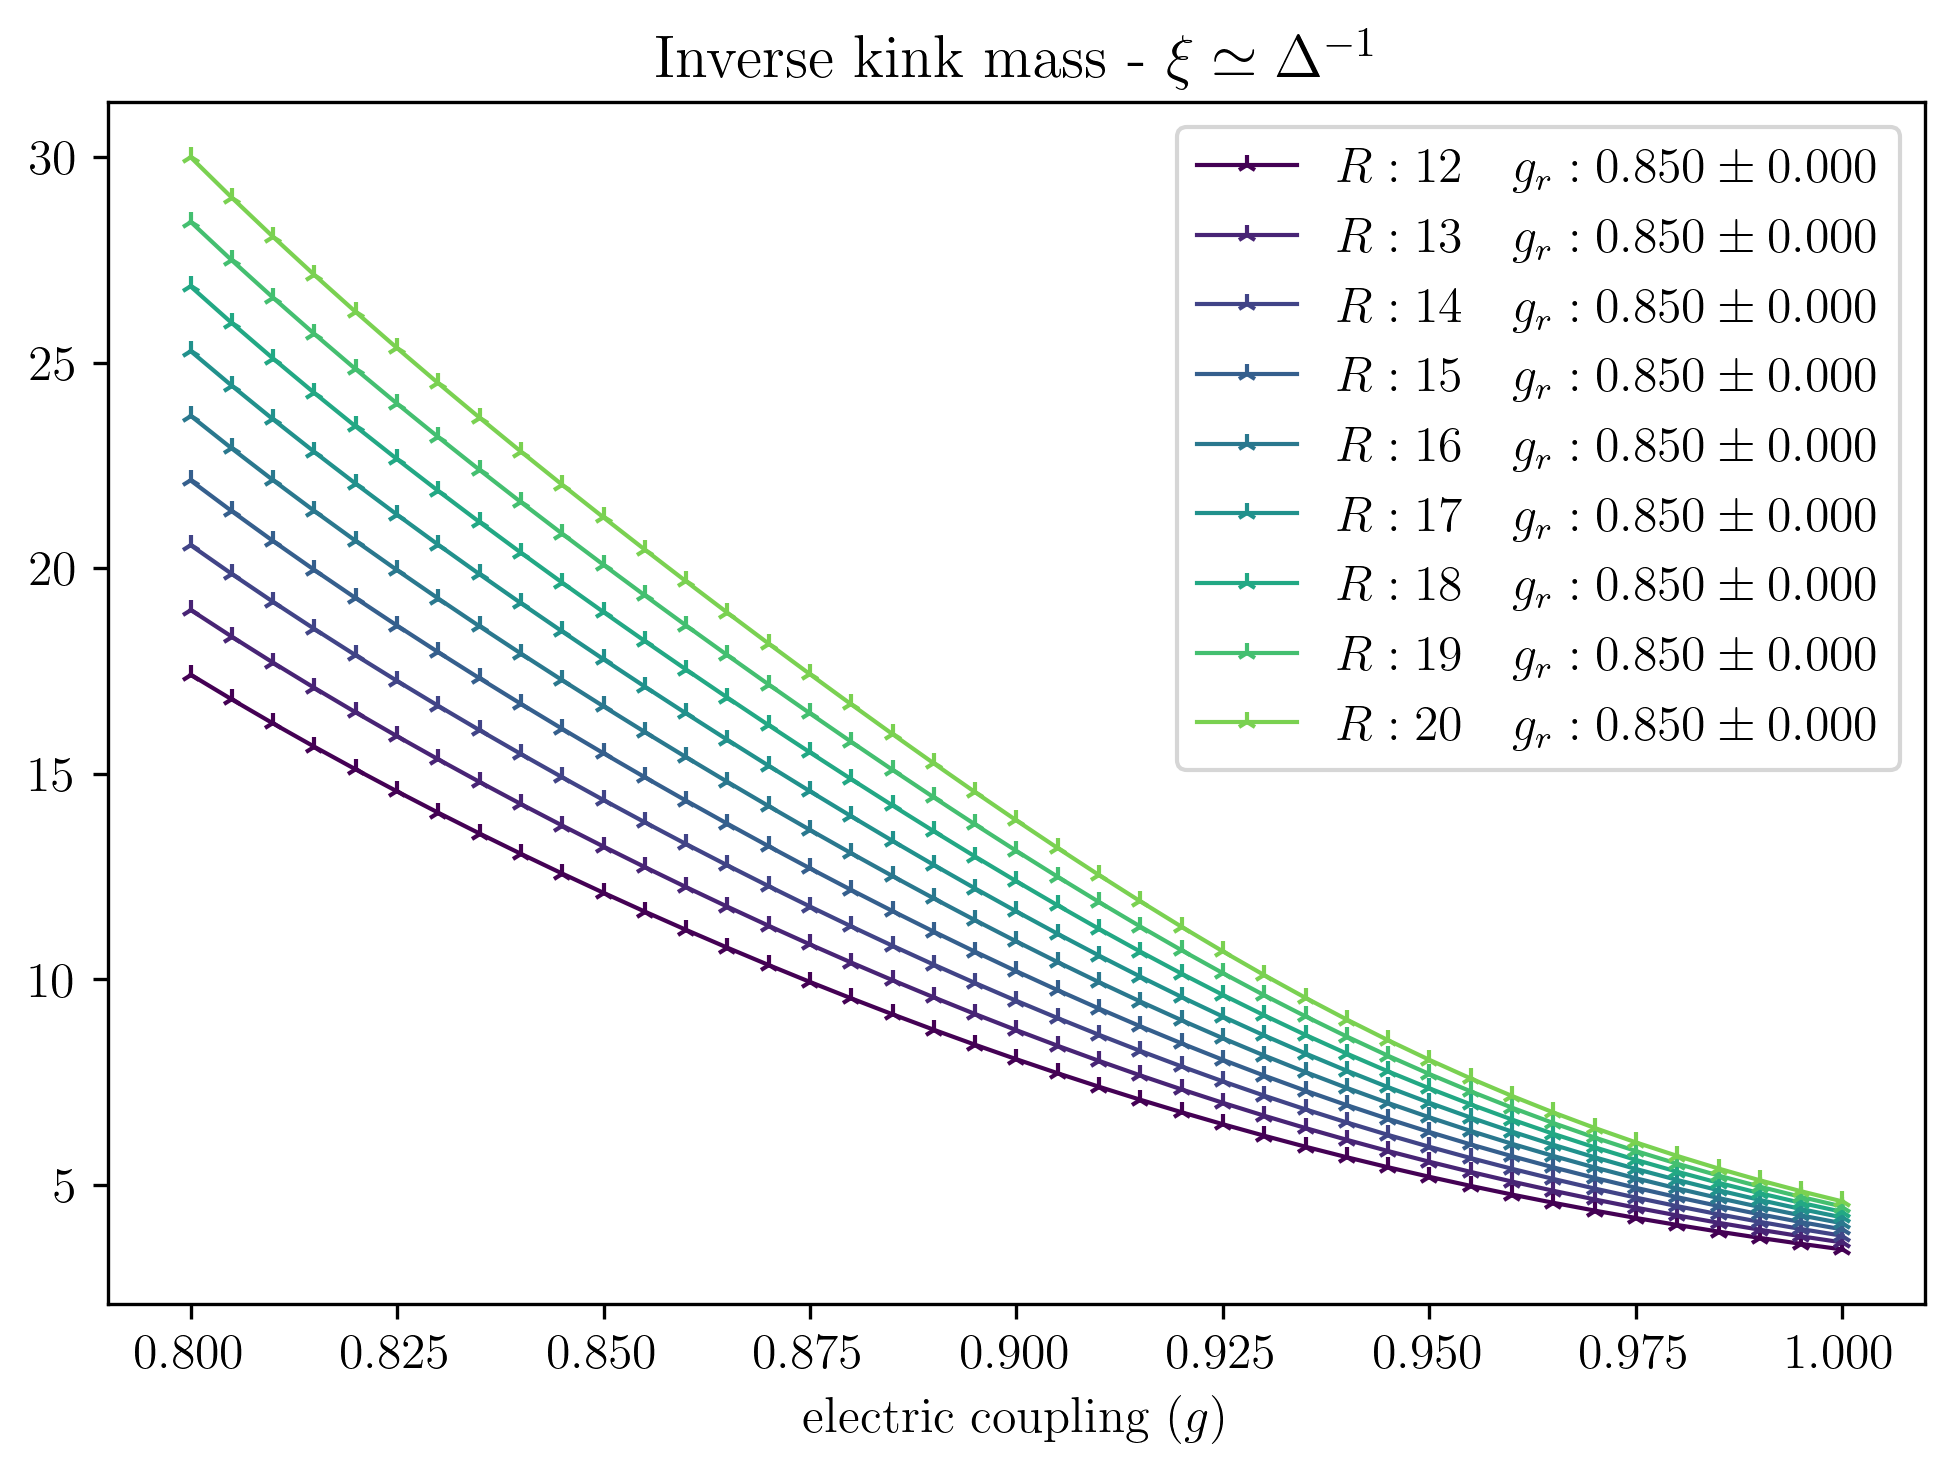

 - - log kink - -     R: 12.0, g_r: 0.852 +/- 0.0011771434938935047
 - - log kink - -     R: 13.0, g_r: 0.853 +/- 0.0019179602285178516
 - - log kink - -     R: 14.0, g_r: 0.852 +/- 0.002518070198558118
 - - log kink - -     R: 15.0, g_r: 0.849 +/- 0.0017069191605640001
 - - log kink - -     R: 16.0, g_r: 0.847 +/- 0.0017293570927296846
 - - log kink - -     R: 17.0, g_r: 0.851 +/- 0.0011742370446191312
 - - log kink - -     R: 18.0, g_r: 0.854 +/- 0.0043692653388925735
 - - log kink - -     R: 19.0, g_r: 0.848 +/- 0.001853118647603072
 - - log kink - -     R: 20.0, g_r: 0.853 +/- 0.0027008604550736877


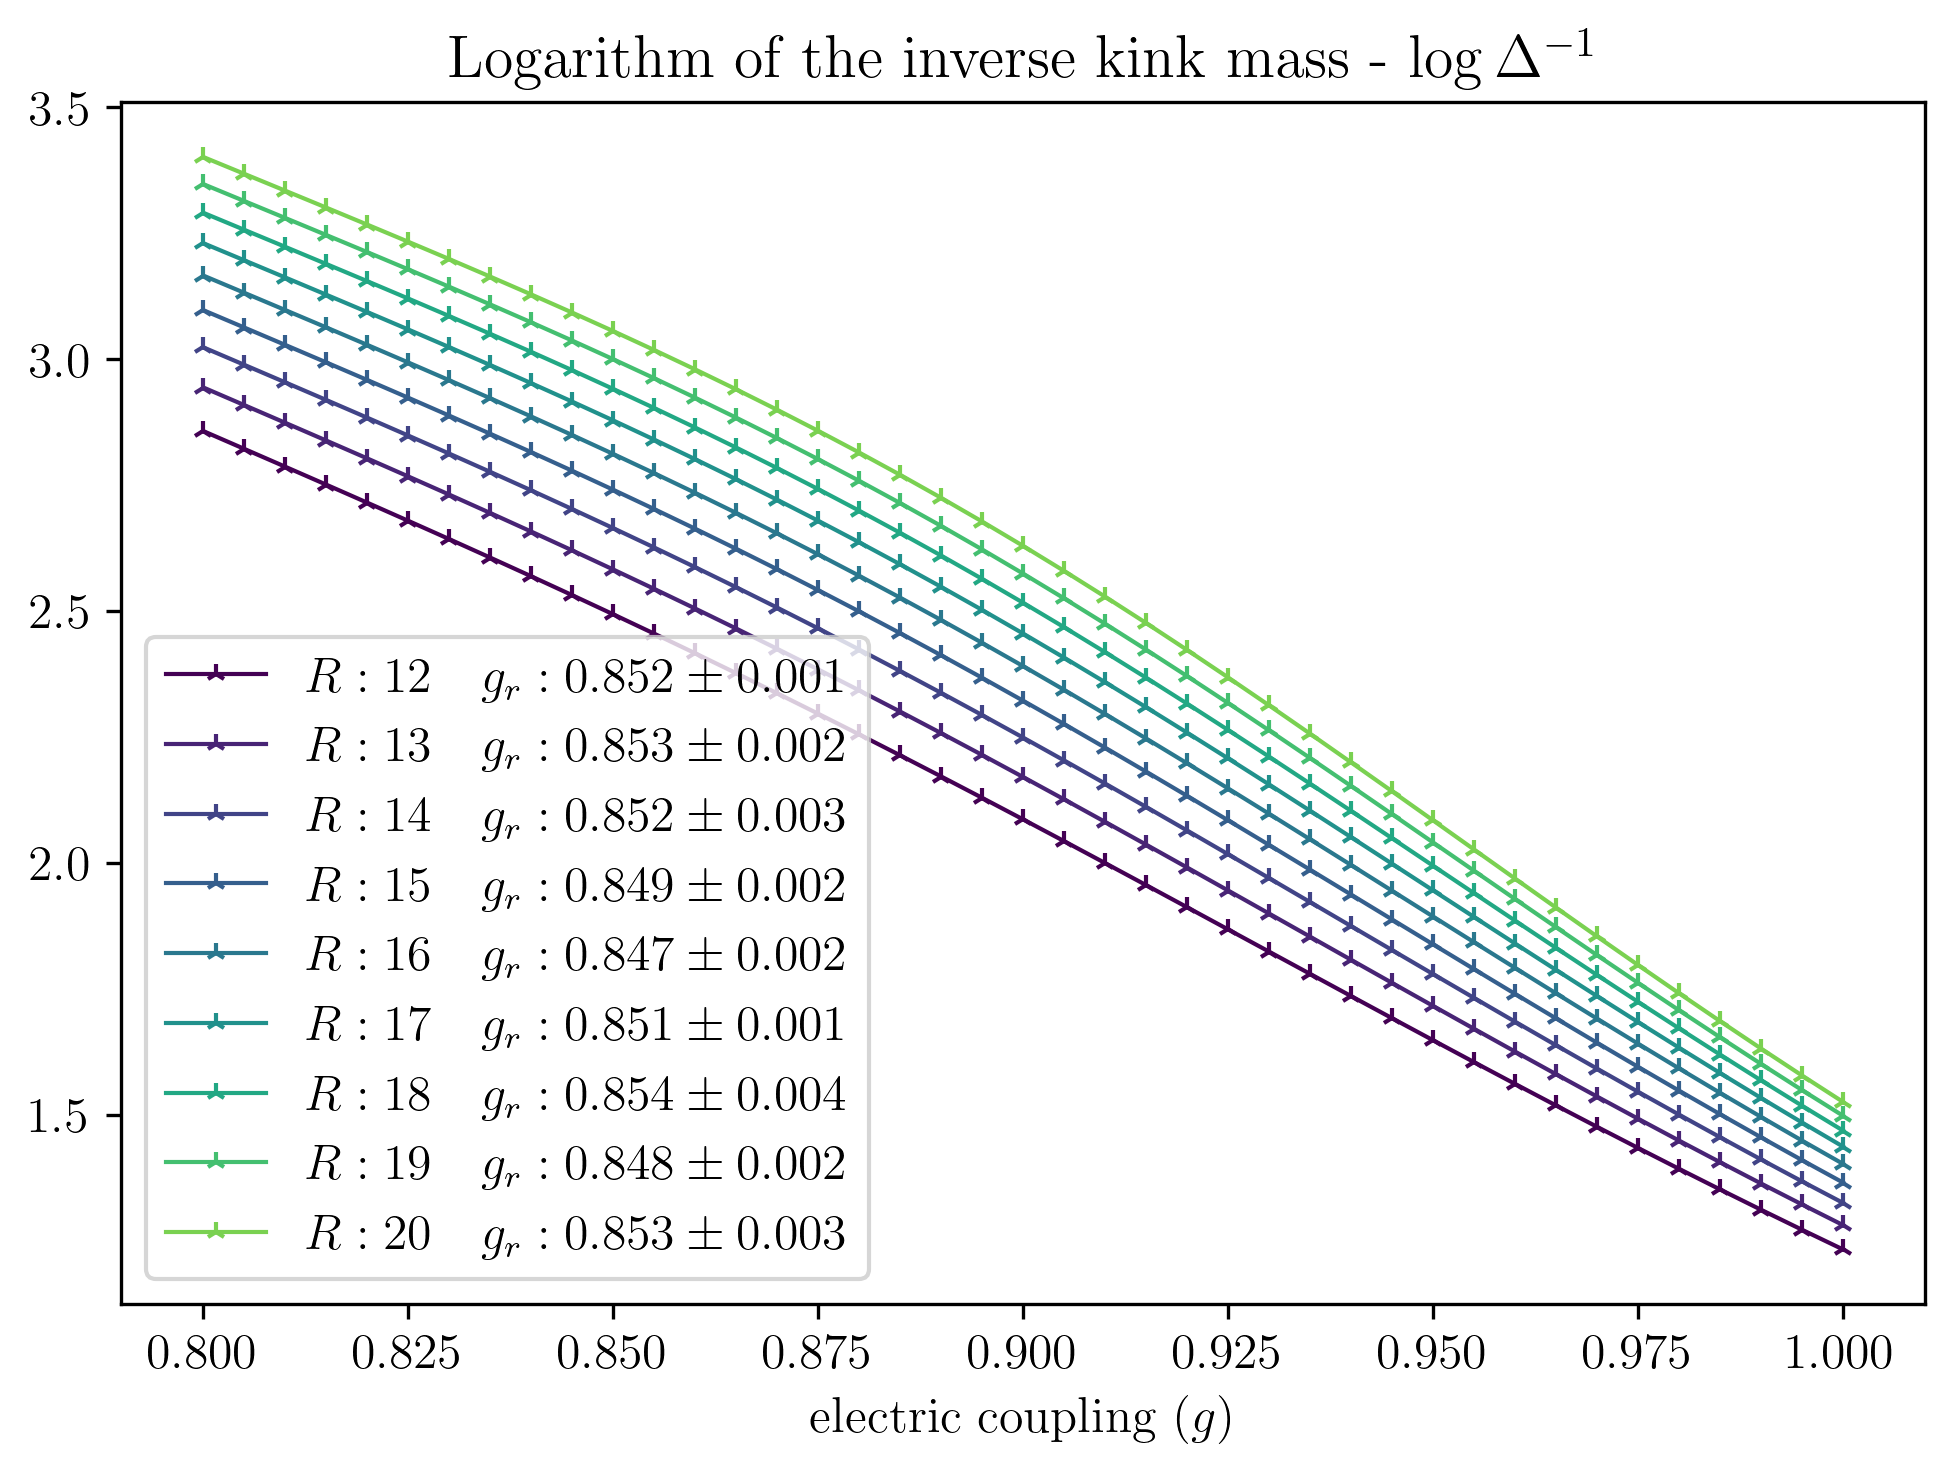

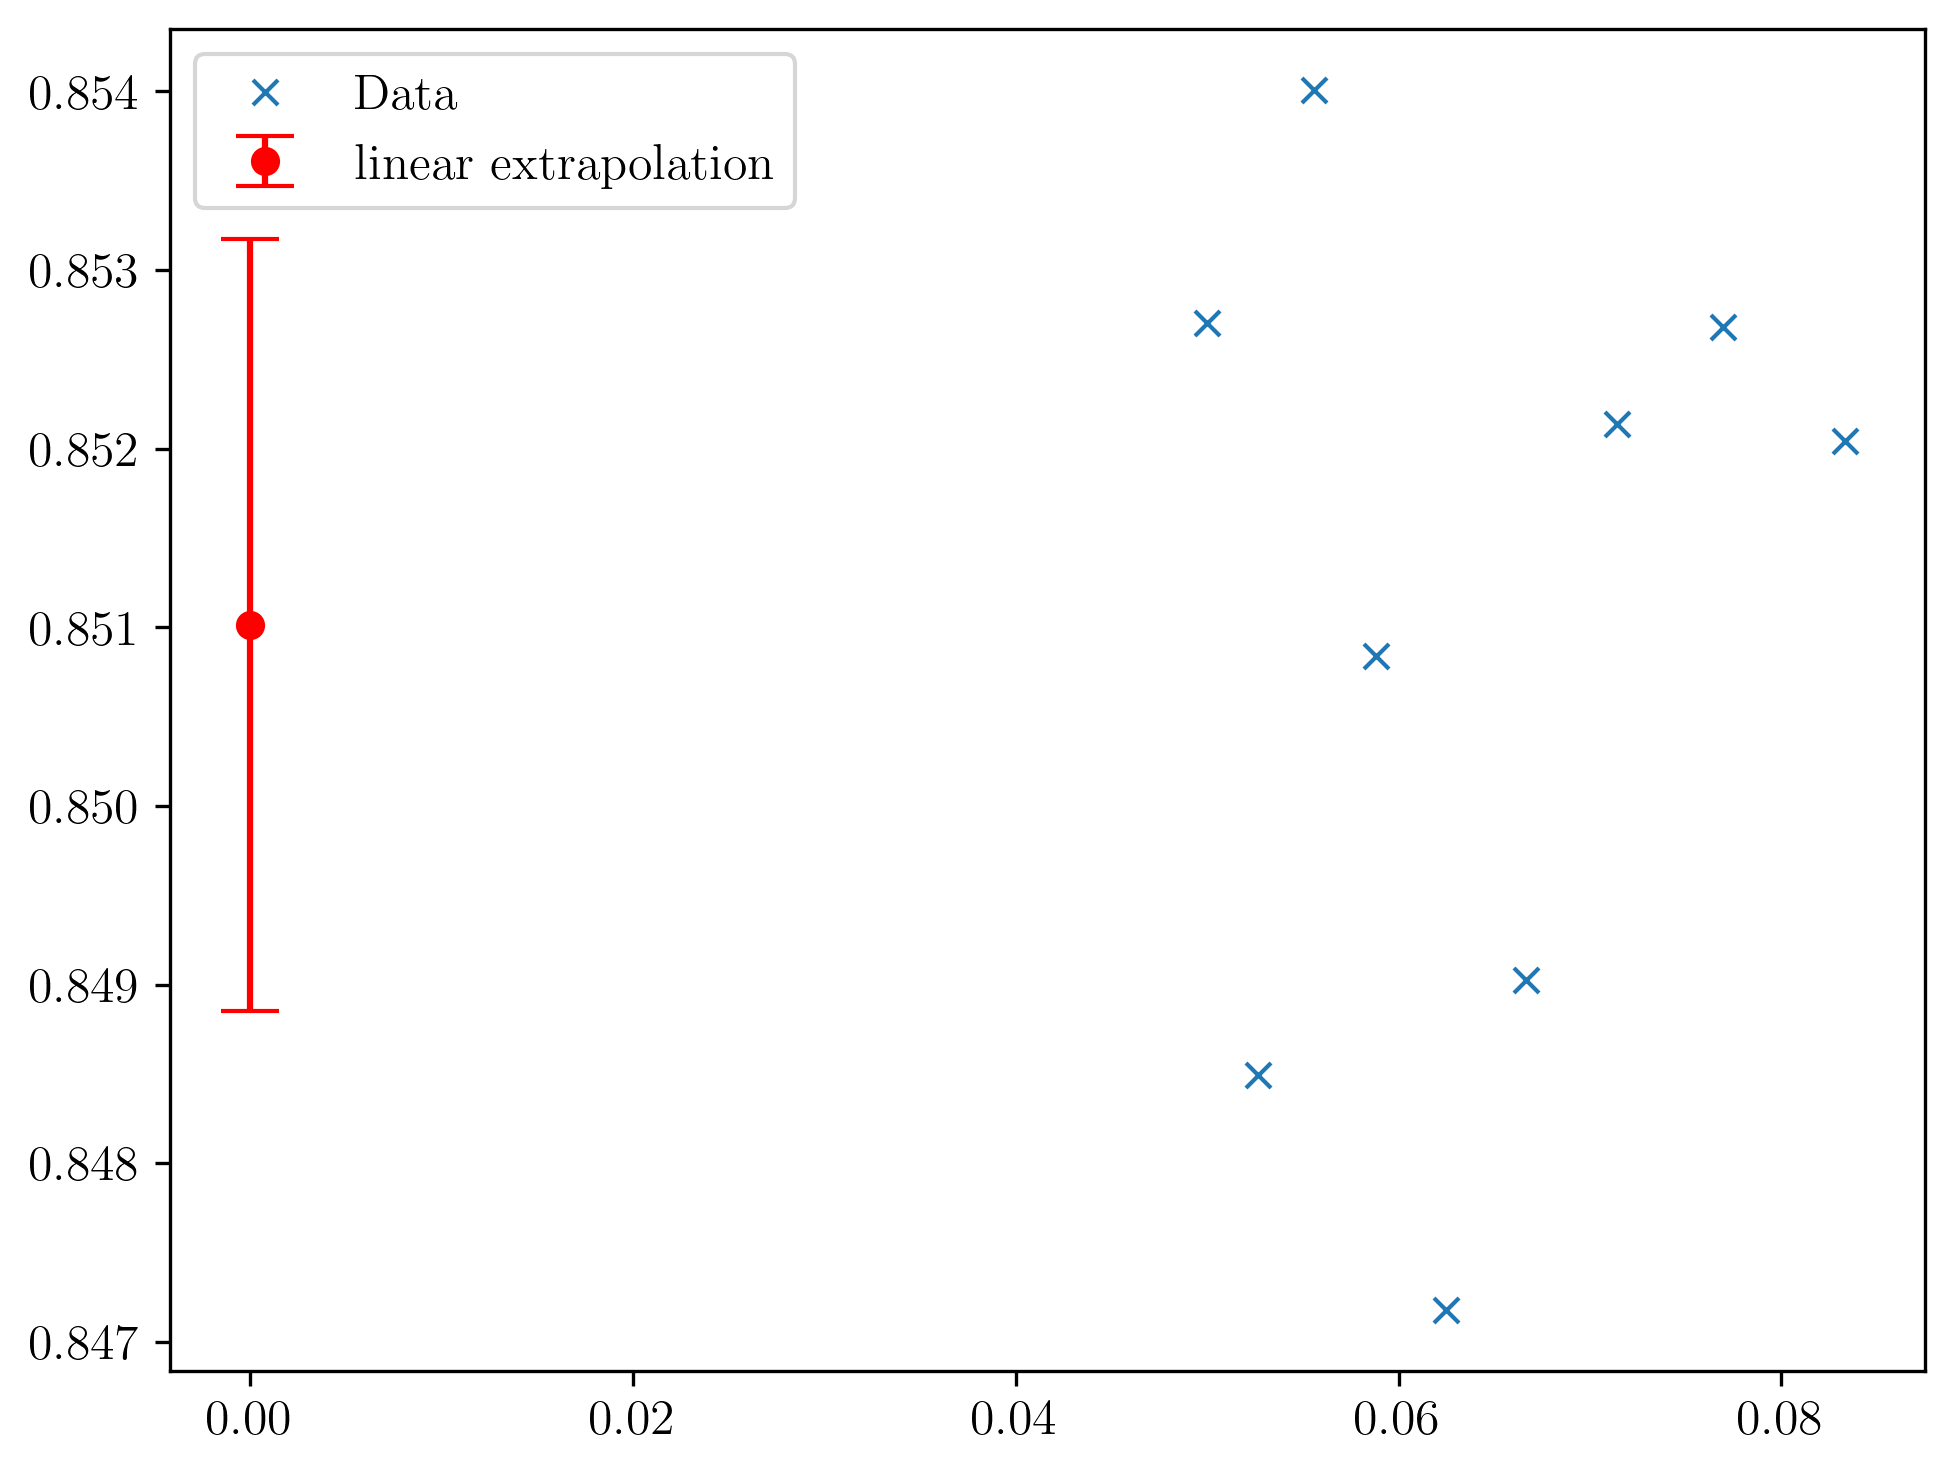

 - - der log kink - - R: 12.0, g_r: 0.879 +/- 0.003
 - - der log kink - - R: 13.0, g_r: 0.860 +/- 0.002
 - - der log kink - - R: 14.0, g_r: 0.839 +/- 0.004
 - - der log kink - - R: 15.0, g_r: 0.854 +/- 0.001
 - - der log kink - - R: 16.0, g_r: 0.865 +/- 0.009
 - - der log kink - - R: 17.0, g_r: 0.844 +/- 0.006
 - - der log kink - - R: 18.0, g_r: 0.830 +/- 0.003
 - - der log kink - - R: 19.0, g_r: 0.852 +/- 0.003
 - - der log kink - - R: 20.0, g_r: 0.854 +/- 0.003


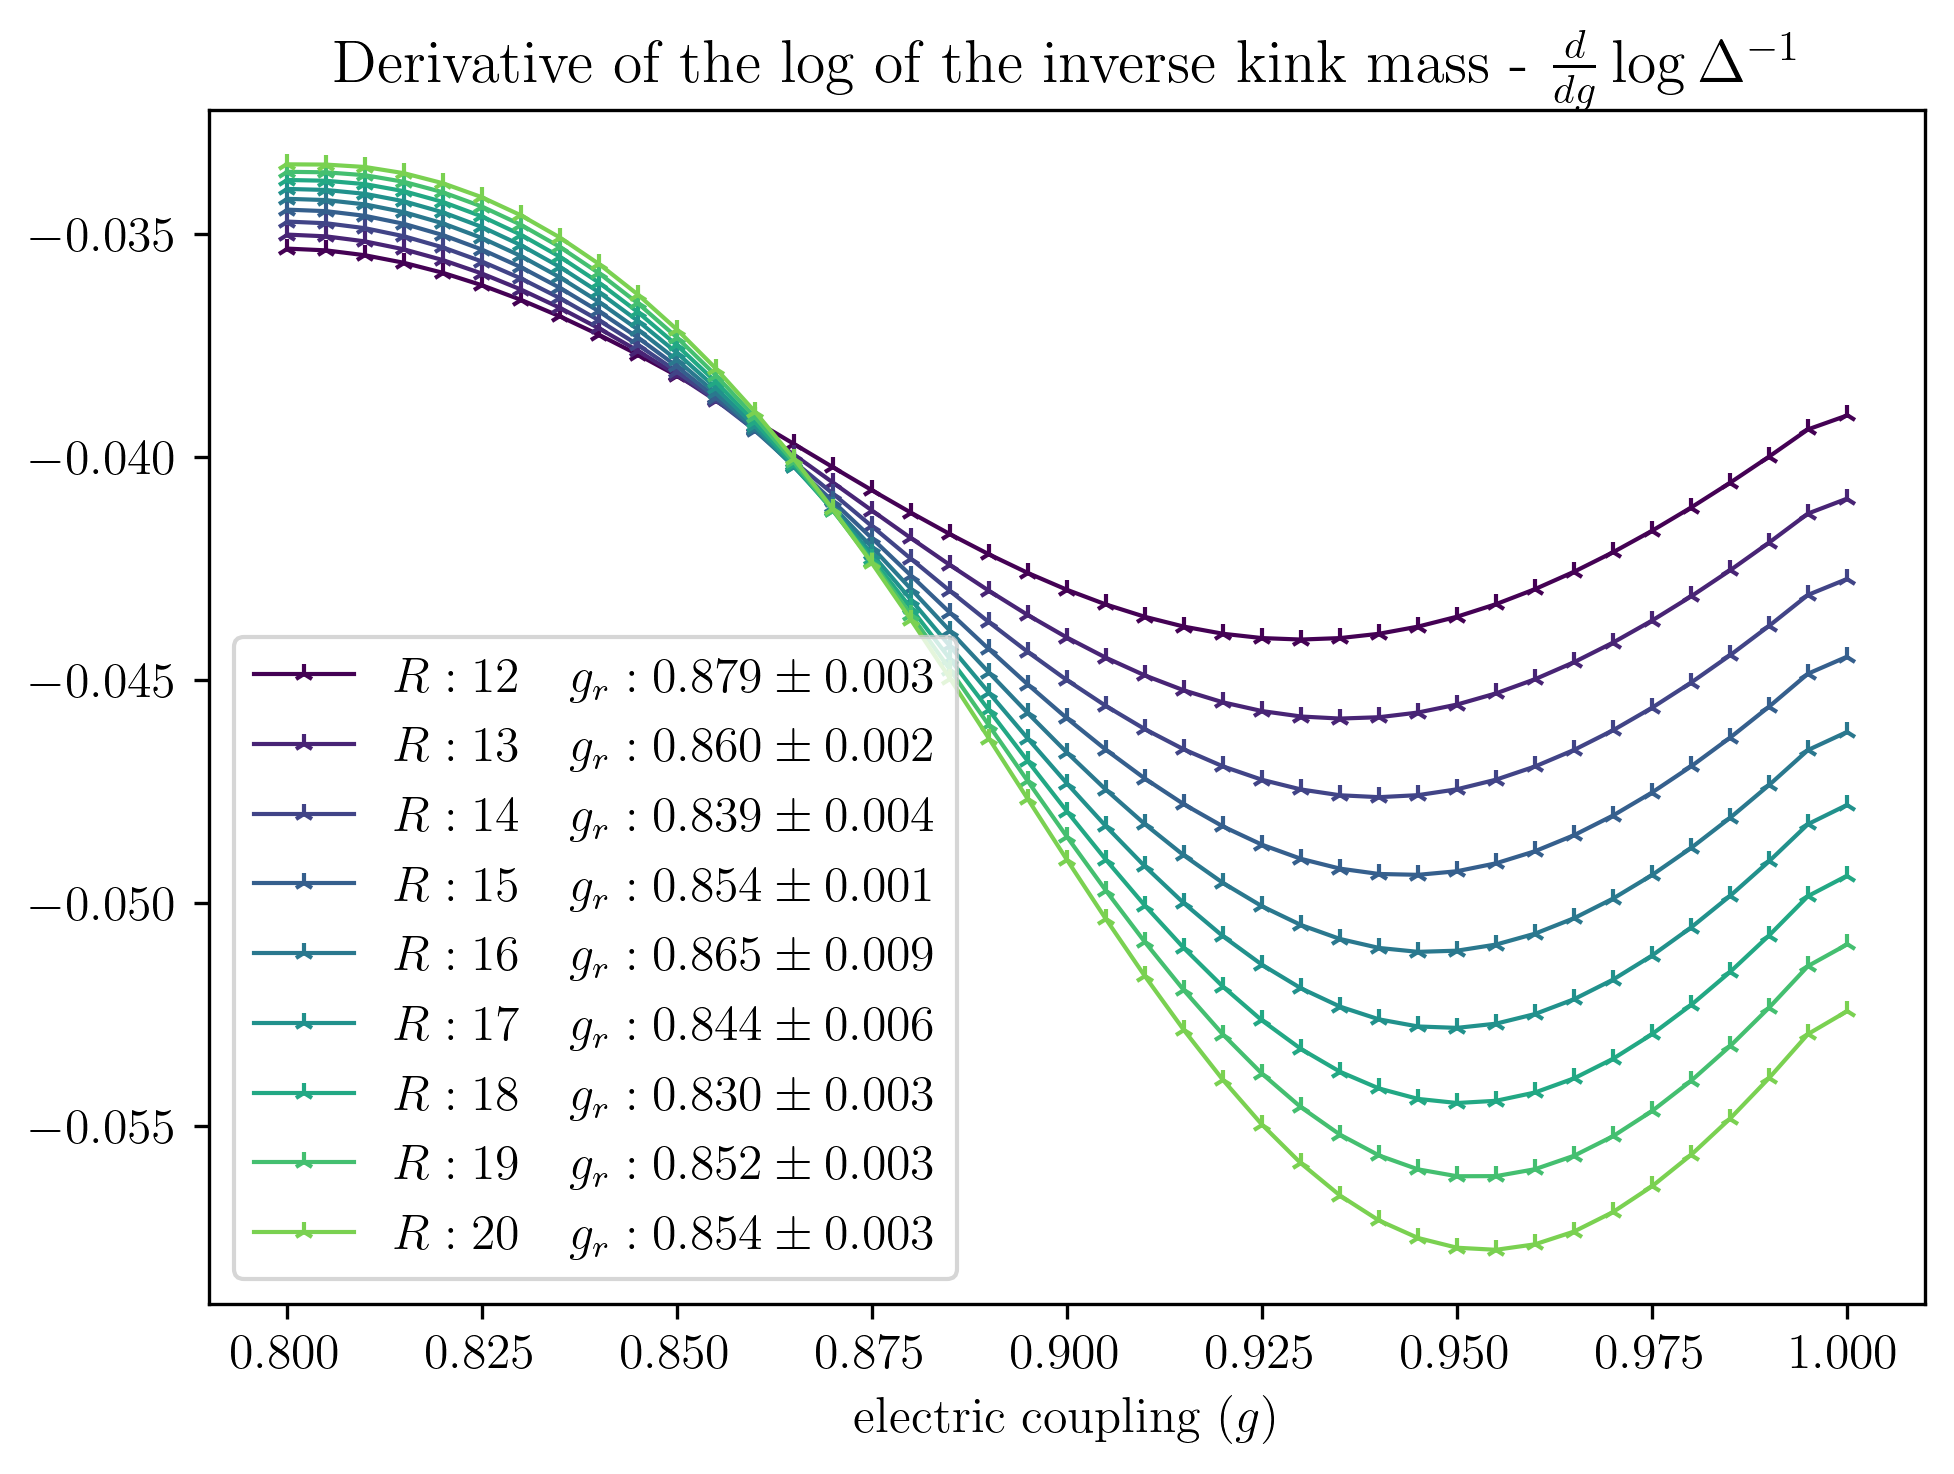

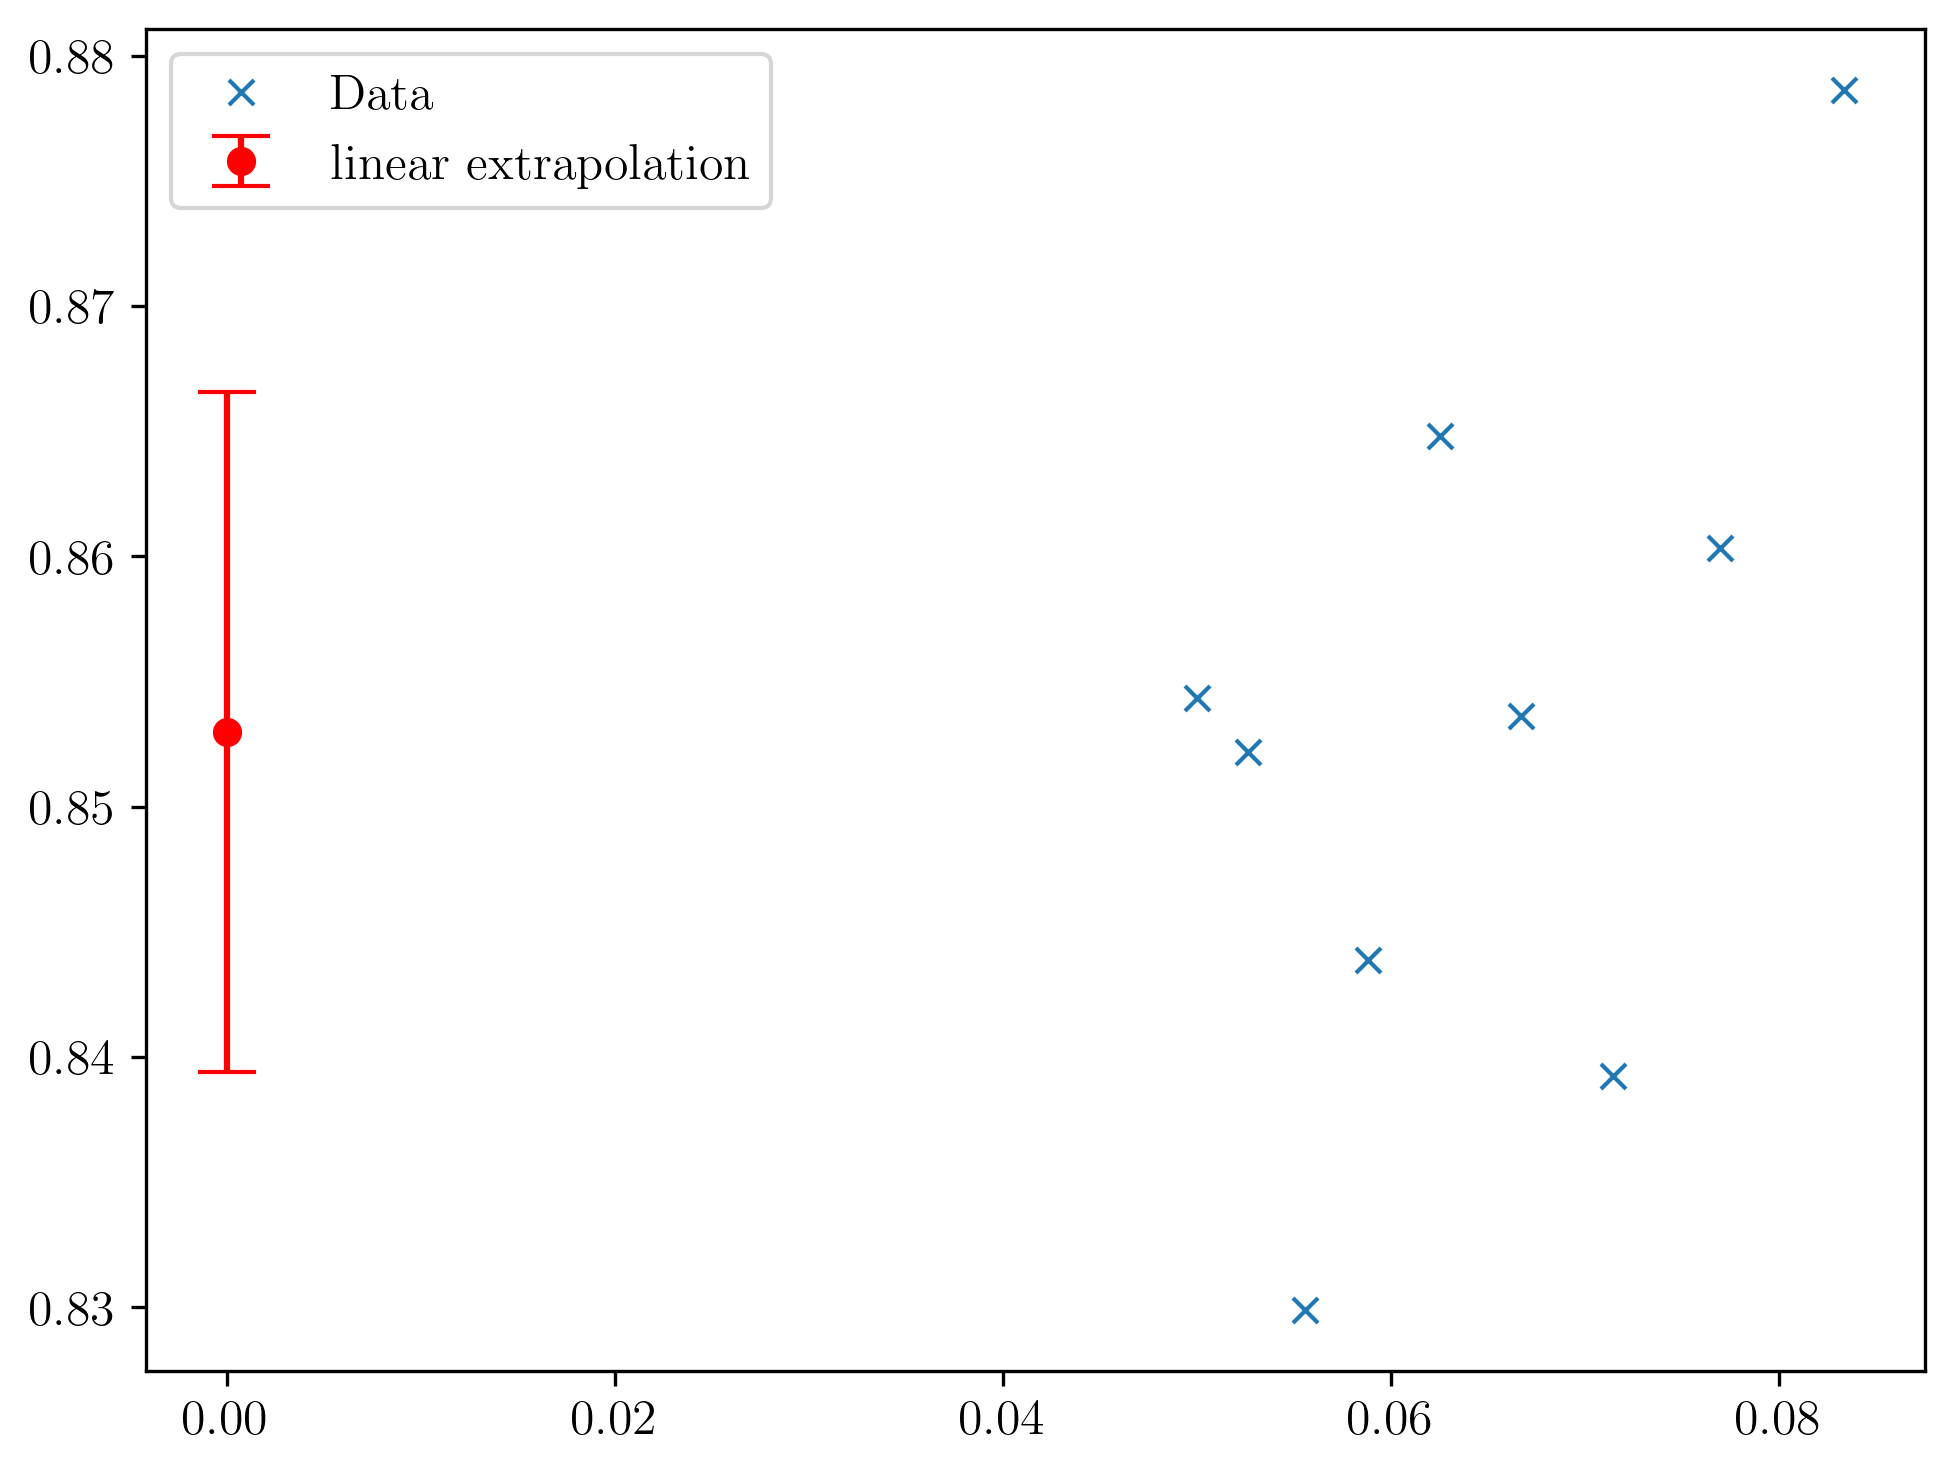

In [620]:
# def kink(g, g_r, a, b, c, eps=1e-4, max_exponent=12):
#     exponent = np.clip(b / np.sqrt(np.abs(g - g_r) + eps), -max_exponent, max_exponent)
#     return a * np.exp(exponent) + c

def kink(g, g_r, a, b, c, eps=1e-4):
    exponent = b / np.sqrt(np.abs(g - g_r) + eps)
    return a * np.exp(exponent) + c

def log_kink(g, g_r, a, b, eps=1e-5):
    return a / np.sqrt(np.abs(g-g_r) + eps) + b

def der_log_kink(g, g_r, a, b, eps=1e-5):
    return a * (g - g_r) / (np.abs(g - g_r)**(5/2) + eps) + b
l = 5
h_i, h_f, npoints = 0.8, 1.0, 41
gs = np.linspace(h_i,h_f,npoints)
Rs = np.linspace(10,20,11)

# l = 6
# h_i, h_f, npoints = 0.6, 0.95, 15
# gs = np.linspace(h_i,h_f,npoints)
# chis = [64,128]
# Rs = [10,11,12,13,14,15,16,17,19]
cy = [0,0]
cy_off_axis = [0,1]

colors = create_sequential_colors(len(Rs))

min_vals = []
for i, R in enumerate(Rs[2:]):
    
    kms, kms_err = n_order_kink_mass_varying_g(gs,R,l,L,chis,bc,sector,h_i,h_f,npoints,path_tensor,cx,cy,cy_off_axis)
    obs = 1/np.abs(kms)
    popt, cov = curve_fit(kink, gs[:-5], obs[:-5], sigma=kms_err[:-5], bounds=[(0.7,-10, -np.inf,-np.inf),(1,10, np.inf,np.inf)])
    err = np.sqrt(np.diag(cov))
    print(f" - - kink - -         R: {R}, g_r: {popt[0]:.3f} +/- {err[0]}")
    plt.plot(gs, obs, marker=markers[off], markersize=5, linestyle="-", color=colors[i], linewidth=1, label=f"$R: {int(R)} \\quad g_r: {popt[0]:.3f}\\pm {err[0]:.3f}$")

plt.title("Inverse kink mass - $\\xi \\simeq \\Delta^{-1}$")
plt.xlabel("electric coupling $(g)$")
plt.legend()
plt.show()

gr_opt = []
for i, R in enumerate(Rs[2:]):

    kms, kms_err = n_order_kink_mass_varying_g(gs,R,l,L,chis,bc,sector,h_i,h_f,npoints,path_tensor,cx,cy,cy_off_axis)
    obs = np.log(1/np.abs(kms))
    popt, cov = curve_fit(log_kink, gs[:-12], obs[:-12], sigma=kms_err[:-12], bounds=[(0.7,-10, -np.inf),(1,10, np.inf)])
    err = np.sqrt(np.diag(cov))
    print(f" - - log kink - -     R: {R}, g_r: {popt[0]:.3f} +/- {err[0]}")
    plt.plot(gs, obs, marker=markers[off], markersize=5, linestyle="-", color=colors[i], linewidth=1, label=f"$R: {int(R)} \\quad g_r: {popt[0]:.3f}\\pm {err[0]:.3f}$")
    gr_opt.append(popt[0])

plt.title("Logarithm of the inverse kink mass - $\\log \\Delta^{-1}$")
plt.xlabel("electric coupling $(g)$")
plt.legend()
plt.show()

plt.plot([1/R for R in Rs[2:]], gr_opt, 'x', label="Data")
plt.errorbar(0, np.mean(gr_opt), fmt='o', yerr=np.std(gr_opt), capsize=7, color='r', label="linear extrapolation")
plt.legend()
plt.show()

gr_opt = []
for i, R in enumerate(Rs[2:]):
    
    kms, kms_err = n_order_kink_mass_varying_g(gs,R,l,L,chis,bc,sector,h_i,h_f,npoints,path_tensor,cx,cy,cy_off_axis)
    obs = np.gradient(np.log(1/np.abs(kms)))
    popt, cov = curve_fit(der_log_kink, gs[:-12], obs[:-12], sigma=kms_err[:-12], bounds=[(0.7,-10, -np.inf),(1,10, np.inf)])
    err = np.sqrt(np.diag(cov))
    print(f" - - der log kink - - R: {R}, g_r: {popt[0]:.3f} +/- {err[0]:.3f}")
    plt.plot(gs, obs, marker=markers[off], markersize=5, linestyle="-", color=colors[i], linewidth=1, label=f"$R: {int(R)} \\quad g_r: {popt[0]:.3f}\\pm {err[0]:.3f}$")
    # plt.plot(gs, obs, marker=markers[off], markersize=5, linestyle="-", color=colors[i], linewidth=1, label=f"$R: {int(R)}$")
    gr_opt.append(popt[0])

# print(gs[:-10])
plt.title("Derivative of the log of the inverse kink mass - $\\frac{d}{dg}\\log \\Delta^{-1}$")
plt.xlabel("electric coupling $(g)$")
plt.legend()
plt.show()

plt.plot([1/R for R in Rs[2:]], gr_opt, 'x', label="Data")
plt.errorbar(0, np.mean(gr_opt), fmt='o', yerr=np.std(gr_opt), capsize=7, color='r', label="linear extrapolation")
plt.legend()
plt.show()

/Users/fradm/Desktop/qs-mps/src/qs_mps/applications/Z2/relevant_observables.py:502: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(potential_fit_3, Rs, potentials, sigma=errors, p0=guess)


Text(0.5, 1.0, 'Norm 1 to Norm 2 transition through roughening - $R: 19$')

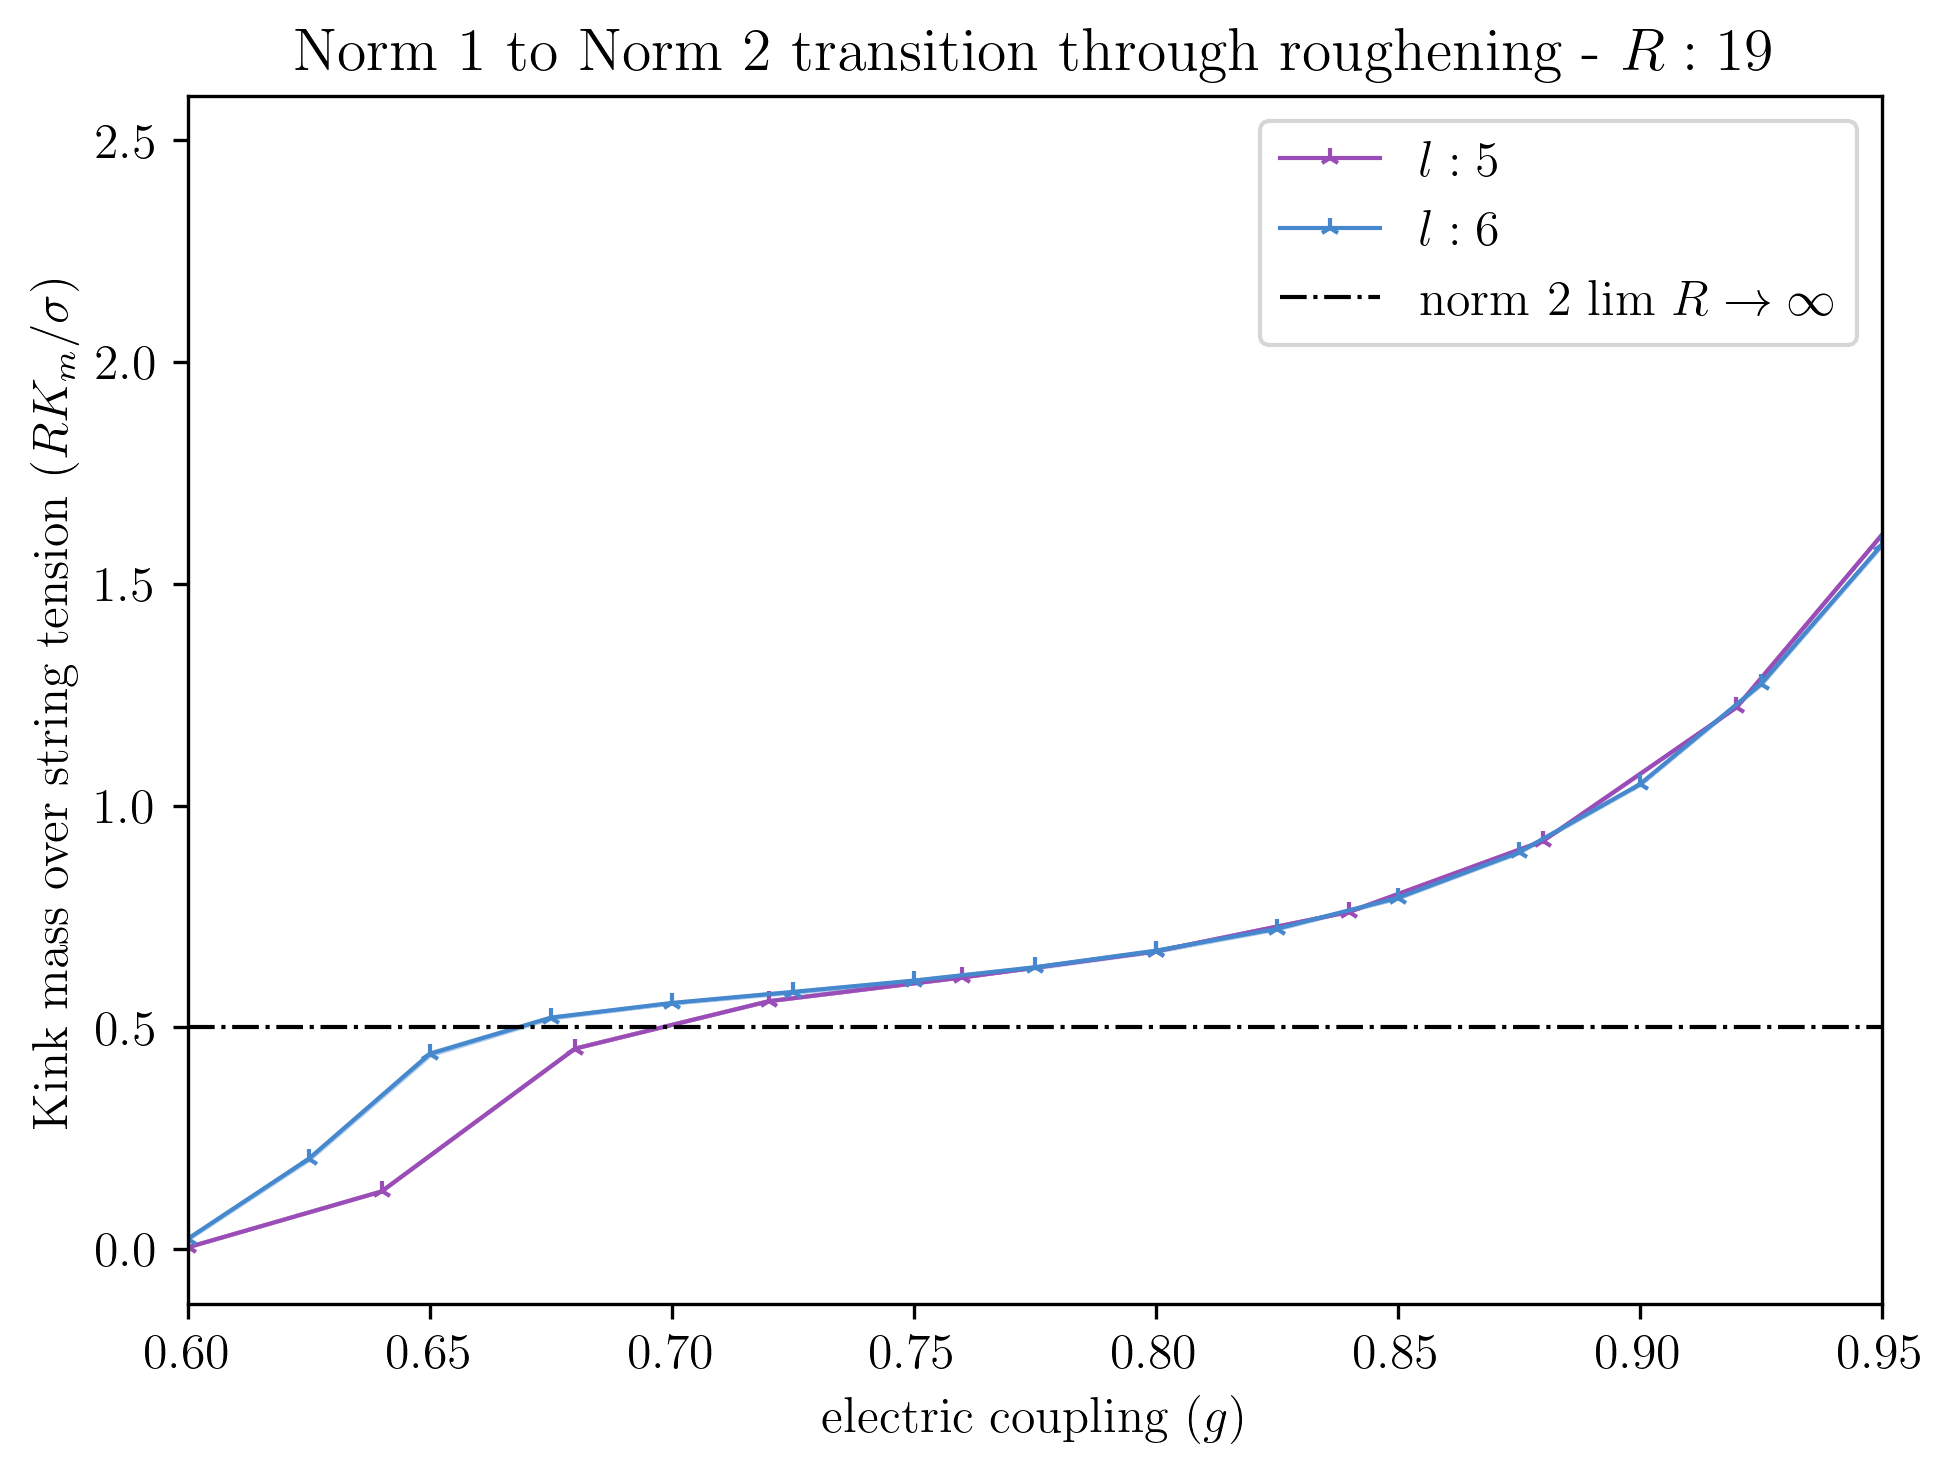

In [622]:
cy_off_axis = [0,1]

chis = [64,128]
colors = ["#9B4DB7","#4688CE"]
R = 19
Rs = [10,11,12,13,14,15,16,17,19]
ls = [5,6]
his = [0.2, 0.6]
hfs = [1.0, 0.95]
npointss = [21, 15]

i = 0
for l, h_i, h_f, npoints in zip(ls, his, hfs, npointss):
    gs = np.linspace(h_i,h_f,npoints)
    sigma, sigma_err = get_fit_params(gs,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor,cx,cy_off_axis,fit=3,param=0)

    kms, kms_err = n_order_kink_mass_varying_g(gs,R,l,L,chis,bc,sector,h_i,h_f,npoints,path_tensor,cx,cy,cy_off_axis)
    obs = R*np.abs(kms)/np.asarray(sigma)
    obs_err = obs * np.sqrt(np.asarray(kms_err)**2/np.asarray(kms)**2 + np.asarray(sigma_err)**2/np.asarray(sigma)**2)
    
    plt.plot(gs, obs, marker=markers[off], markersize=5, linestyle=linestyles[off], color=colors[i], linewidth=1, label=f"$l: {l}$")
    plt.fill_between(gs,y1=obs+obs_err, y2=obs-obs_err, alpha=0.4, color=colors[i])
    i += 1

eucldist = np.sqrt(R**2+1) - R
norm1dist = R + 1 - R
# plt.hlines(y=eucldist, xmin=0.2, xmax=2.0, linestyles="--", colors='black', linewidth=1, label="euclidian distance $\\epsilon_{2}$")
# plt.hlines(y=norm1dist, xmin=0.2, xmax=2.0, linestyles="-.", colors='black', linewidth=1, label="norm 1 distance $\\epsilon_{1}$")
plt.hlines(y=1/2, xmin=0.6, xmax=0.95, linestyles="-.", colors='black', linewidth=1, label="norm 2 lim $R \\rightarrow \\infty$")
plt.legend()
plt.xlim(0.6,0.95)
# plt.ylim(0,2)
plt.ylabel("Kink mass over string tension $(R K_m/\\sigma)$")
plt.xlabel("electric coupling $(g)$")
plt.title(f"Norm 1 to Norm 2 transition through roughening - $R: {R}$")
# plt.yscale("log")

# Estimation of the Roughening point

In [311]:
import scipy.optimize as opt

# Define the function to compute the rescaled gap
def delta_star(R, delta_R, C):
    return R * delta_R * (1 + 1 / (2 * np.log(R) + C))

# Define the scaling function argument
def x_R(eps, R):
    return np.log(R) - np.log(eps)

def x_func(R, g, g_r, b, epsilon=1e-3):
    return np.log(R) - b / (np.sqrt(np.abs(g - g_r)) + epsilon)

# Define the correlation length scaling
def correlation_length(g, g_r, b, epsilon=1e-3):
    return np.exp(b / (np.sqrt(np.abs(g - g_r) + epsilon)))

def grid_search(g_values, delta_R_values, R, R_idx, deg, epsilon, grid_grain=100, b=1, C=-6):
    g_r_grid = np.linspace(min(g_values), max(g_values)-0.05, grid_grain)
    c_grid = np.linspace(-10, -5, grid_grain)
    b_grid = np.linspace(-10, 10, grid_grain)
    min_residuals = np.inf

    all_coeffs = []
    res_tot = []
    for g_r in g_r_grid:
        res_b = []
        # for C in c_grid:
        for b in b_grid:
            # eps_values = correlation_length(g_values, g_r, b, epsilon=epsilon)
            # x_data = x_R(eps_values, R)
            x_data = x_func(R,g_values,g_r,b, epsilon=epsilon)
            y_data = delta_star(R, delta_R_values[R_idx], C)
            coeffs, residuals, rank, sm, rcond = np.polyfit(x_data, y_data, deg=deg, full=True)
            all_coeffs.append(coeffs)

            if residuals <= min_residuals:
                min_residuals = residuals
                best_params = (g_r, b, C)
                best_poly = coeffs

            res_b.append(residuals)
        res_tot.append(res_b)

    all_coeffs = np.array(all_coeffs).reshape((grid_grain,grid_grain,deg+1))
    res_tot = np.array(res_tot)
    return res_tot, best_params, best_poly, all_coeffs

In [217]:
# Example usage (replace with actual data)
h_i, h_f, npoints = 0.6, 0.95, 15
h_i, h_f, npoints = 0.8, 1.0, 41
g_values = np.linspace(h_i,h_f,npoints)
chis = [64, 128]
l, L = 5, 30
# l, L = 6, 30
bc = "pbc"
sector = "2_particle(s)_sector"
Rs = [10,11,12,13,14,15,16,17,19]
R_values = np.array(Rs)  # System sizes

cy = [0,0]
cy_off_axis = [0,1]

# colors = create_sequential_colors(len(Rs))

delta_R_values = []
# sigma, sigma_err = get_fit_params(gs,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor,cx,cy_off_axis,fit=3,param=0)
for i, R in enumerate(Rs):
    
    kms, kms_err = n_order_kink_mass_varying_g(g_values,R,l,L,chis,bc,sector,h_i,h_f,npoints,path_tensor,cx,cy,cy_off_axis)
    # obs = np.abs(kms)/np.asarray(sigma)
    delta_R_values.append(np.abs(kms))

delta_R_values = np.asarray(delta_R_values)


In [218]:
deg = 5
epsilon = 1e-3
grid_grain = 200

R_idx = 5
R = R_values[R_idx]
res_tot = []
best_params = []
best_poly = []
all_coeffs = []
for R_idx, R in enumerate(Rs):
    res_tot_R, best_params_R, best_poly_R, all_coeffs_R = grid_search(g_values, delta_R_values, R, R_idx, deg, epsilon, grid_grain)
    res_tot.append(res_tot_R)
    best_params.append(best_params_R)
    best_poly.append(best_poly_R)
    all_coeffs.append(all_coeffs_R)

In [ ]:
g_r_grid = np.linspace(min(g_values), max(g_values), grid_grain)
c_grid = np.linspace(-10, -5, grid_grain)
for i, R in enumerate(Rs):
    plt.title(f"R: {R_values[i]}")
    # plt.xlabel("$C$")
    plt.xlabel("$b$")
    plt.ylabel("$g_{rough}$")
    plt.imshow(res_tot[i], cmap="cividis", norm=LogNorm())
    # plt.imshow(res_tot_i, cmap="cividis")
    plt.yticks(ticks=range(grid_grain)[::grid_grain//5], labels=[f"{g:.2f}" for g in g_r_grid[::grid_grain//5]])
    plt.xticks(ticks=range(grid_grain)[::grid_grain//5], labels=[f"{C:.2f}" for C in c_grid[::grid_grain//5]])
    plt.colorbar()
    plt.show()

In [ ]:
g_r, b, C = best_params[i]
# g_r = 0.847
# C = -6
print(g_r)
Rs = [10,11,12,13,14,15,16,17,19]
colors = create_sequential_colors(len(Rs))
linestyles = ["-", "--"]
markers = ["1","2"]

for k in range(len(Rs)):
    g_r, b, C = best_params[k]
    for i, R in enumerate(Rs):
        plt.title(f"$g_r: {g_r:.2f}, b: {b:.2f}, C: {C:.2f}$")
        x_data = x_func(R,g_values,g_r,b, epsilon=epsilon)
        y_data = delta_star(R, delta_R_values[i], C)
        coeffs, residuals, rank, sm, rcond = np.polyfit(x_data, y_data, deg=deg, full=True)
        plt.plot(x_data, y_data, 's', markersize=5, linewidth=1, linestyle="-", color=colors[i], label=f"R: {R}")
    plt.legend()
    plt.show()

10
11
12
13
14
15
16
17
19


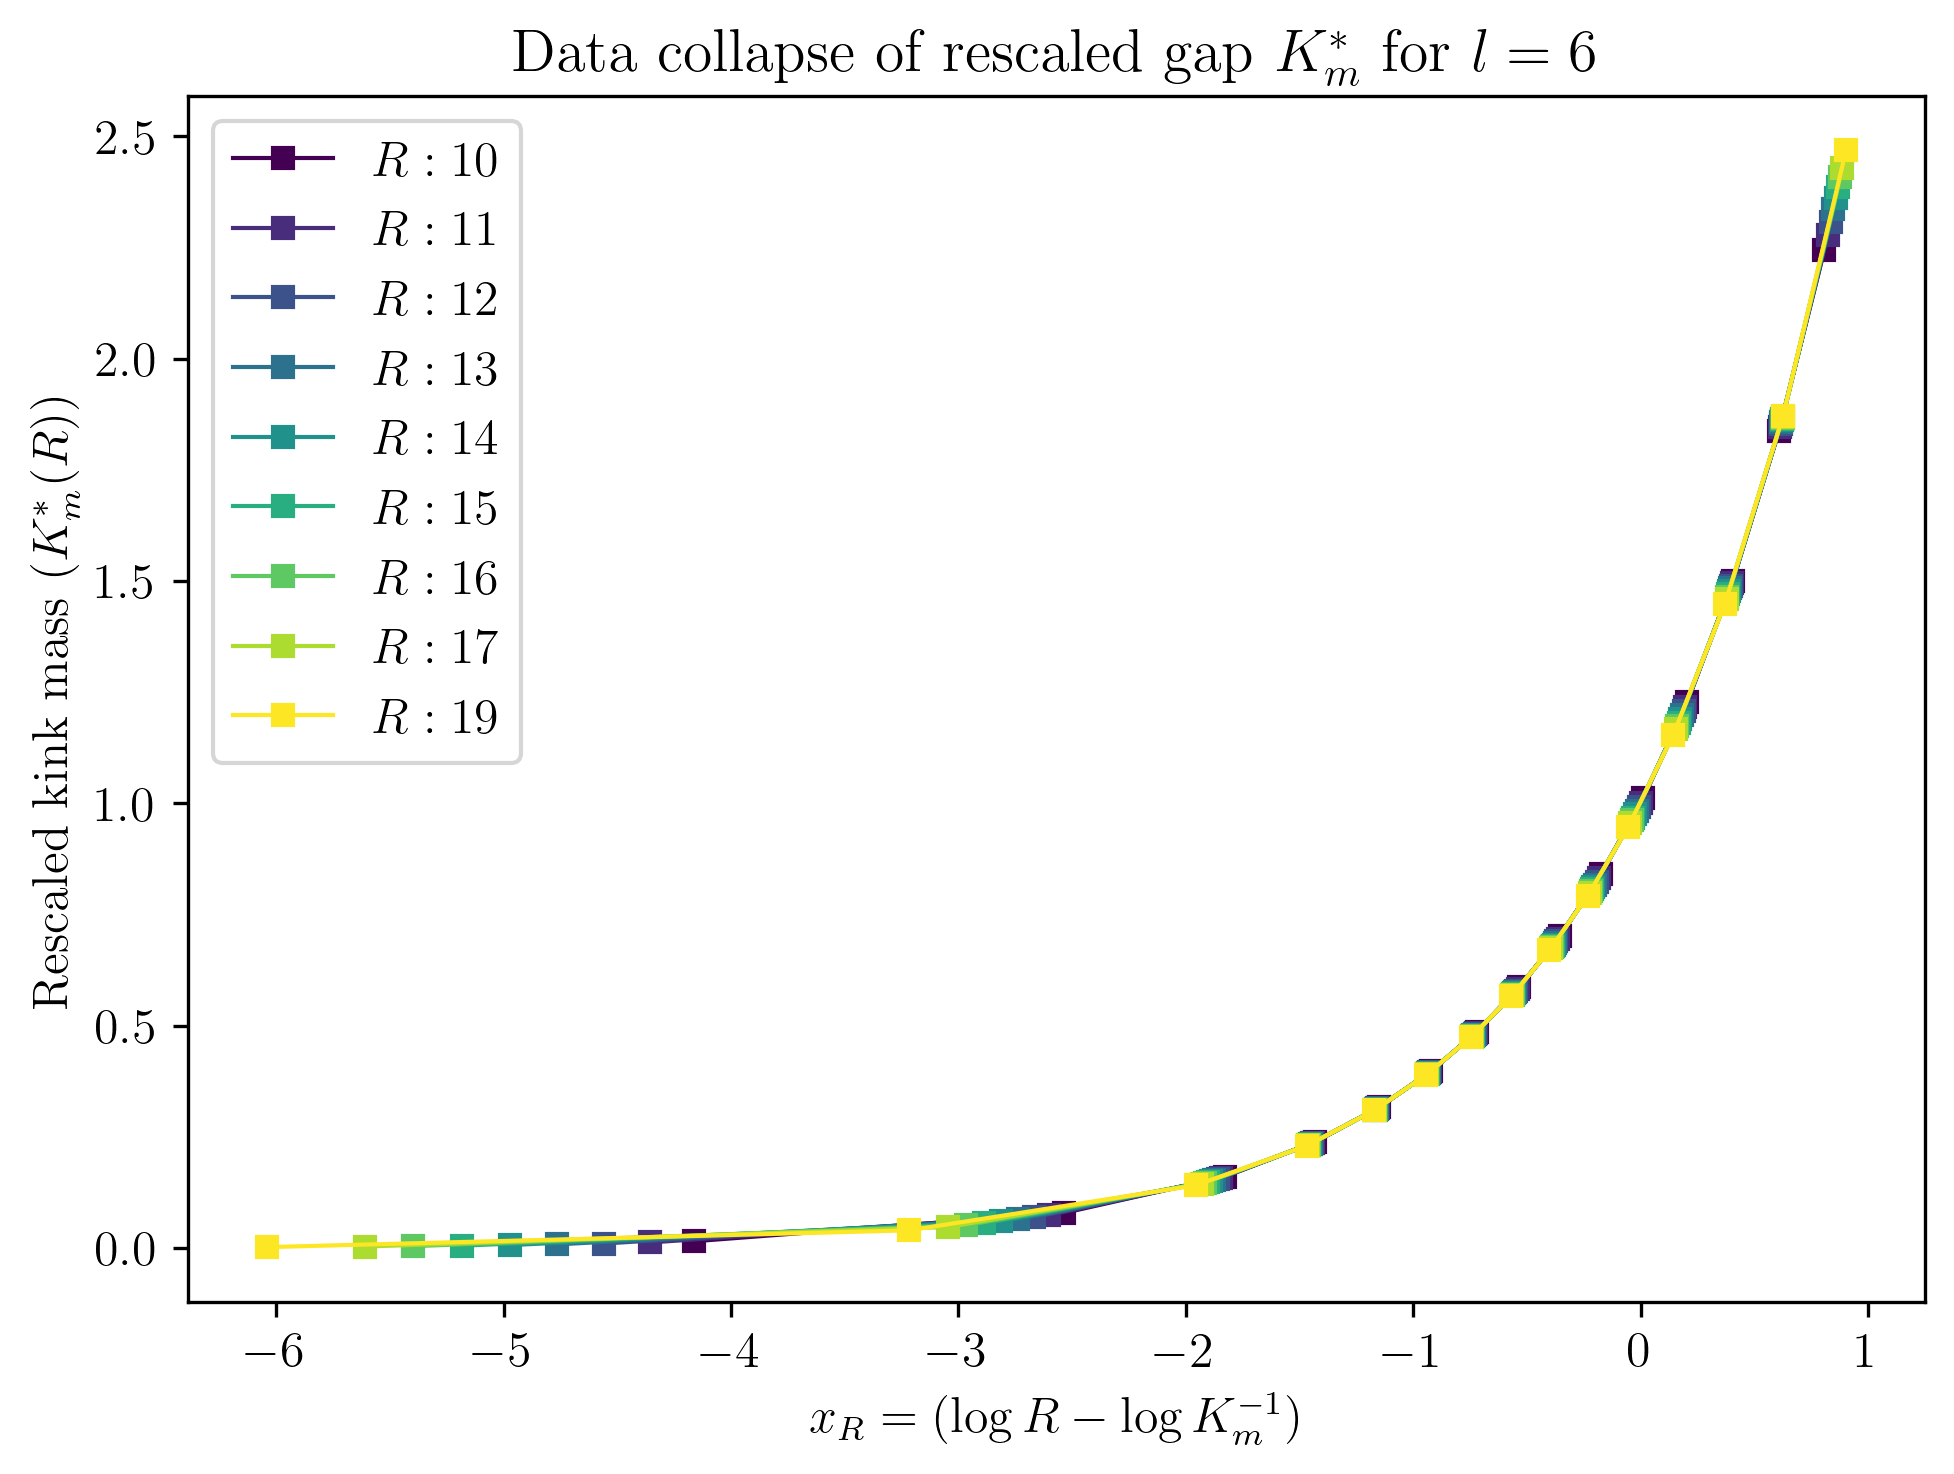

In [ ]:
# Example usage (replace with actual data)
Ls = [L]

l = 6
h_i, h_f, npoints = 0.6, 0.95, 15
Rs = [10,11,12,13,14,15,16,17,19]

# l = 5
# h_i, h_f, npoints = 0.8, 1.0, 41
# Rs = [10,11,12,13,14,15,16,17,18,19,20]



R_values = np.array(Rs)  # System sizes
gs = np.linspace(h_i,h_f,npoints)
chis = [64,128]
g_values = gs


# # Example usage (replace with actual data)
# l = 5
# h_i, h_f, npoints = 0.2, 1.0, 21
# g_values = np.linspace(h_i,h_f,npoints)
# chis = [64,128]

# Rs = [10,11,12,13,14,15,16,17,18,19,20]
# R_values = np.array(Rs)  # System sizes
linestyles = ["-", "--"]
markers = ["1","2"]
cx = None
cy = [0,0]
cy_off_axis = [0,1]

C = 11
# l = 5
# h_i, h_f, npoints = 0.2, 1.0, 21
# g_values = np.linspace(h_i,h_f,npoints)
# Rs = list(range(10,21))
colors = create_sequential_colors(len(R_values))

sigma, sigma_err = get_fit_params(g_values,R_values,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor,cx,cy_off_axis,fit=2,param=0)
for i, R in enumerate(R_values):
    kms, kms_err = n_order_kink_mass_varying_g(g_values,R,l,L,chis,bc,sector,h_i,h_f,npoints,path_tensor,cx,cy,cy_off_axis)
    # kink = np.abs(kms)/np.asarray(sigma)
    kink = np.abs(kms)
    obs = delta_star(R,kink,C)
    obs = R * np.abs(kms)
    # popt, cov = curve_fit(correlation_length, g_values, 1/kink, bounds=[(0, 0, 0),(3, 100, 1e-3)], maxfev=2000) # bounds=[(0, -np.inf, -np.inf, -np.inf),(10, np.inf, np.inf, 0)]
    # print(f"For R: {R}, g_r: {popt[0]}")
    # eps = correlation_length(g_values, g_r=popt[0], b=popt[1], epsilon=popt[2])
    eps = 1/kink
    xs = x_R(eps, R)
    # xs = g_values
    plt.plot(xs, obs, marker="s", markersize=5, color=colors[i], linewidth=1, label=f"$R: {R}$")

plt.title(f"Data collapse of rescaled gap $K_m^*$ for $l={l}$")
plt.xlabel("$x_R=(\\log R - \\log K_m^{-1})$")
# plt.ylabel("correlation length $(\\xi)$")
plt.ylabel("Rescaled kink mass $(K_m^*(R))$")
plt.legend()
plt.savefig(f"{path_figures}/figures/fluxtube/rescaled_gap_vs_rescaled_x_no_opt_z2_dual_{l}x{L}_Rs_{R_values}_h_{h_i}-{h_f}_npoints_{npoints}_chis_{chis}.png")


In [ ]:
# Example usage (replace with actual data)
l = 6
h_i, h_f, npoints = 0.6, 0.95, 15
gs = np.linspace(h_i,h_f,npoints)
chis = [64,128]
g_values = gs

Rs = [10,11,12,13,14,15,16,17]
R_values = np.array(Rs)  # System sizes

# # Example usage (replace with actual data)
# l = 5
# h_i, h_f, npoints = 0.2, 1.0, 21
# g_values = np.linspace(h_i,h_f,npoints)
# chis = [64,128]

# Rs = [10,11,12,13,14,15,16,17,18,19,20]
# R_values = np.array(Rs)  # System sizes


cy = [0,0]
cy_off_axis = [0,1]

C = 1
# l = 5
# h_i, h_f, npoints = 0.2, 1.0, 21
# g_values = np.linspace(h_i,h_f,npoints)
# Rs = list(range(10,21))
colors = create_sequential_colors(len(Rs))

sigma, sigma_err = get_fit_params(g_values[0:],Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor,cx,cy_off_axis,fit=2,param=0)
for i, R in enumerate(Rs):
    
    kms, kms_err = n_order_kink_mass_varying_g(g_values[0:],R,l,L,chis,bc,sector,h_i,h_f,npoints,path_tensor,cx,cy,cy_off_axis)
    kink = np.abs(kms)/np.asarray(sigma)
    # kink = np.abs(kms)
    eps = 1/kink
    plt.plot(g_values[0:], eps, color=colors[i], linewidth=1, label=f"$R: {R}$")
#     popt, cov = curve_fit(correlation_length, g_values, eps, p0=[1, 10, 1, 0], maxfev=2000)

#     print(f"fit values of g_r: {popt[0]}")
#     xs = 1/(np.sqrt(np.abs(g_values - popt[0])))
#     plt.plot(xs, np.log(eps), marker=markers[off], markersize=5, linestyle=linestyles[off], color=colors[i], linewidth=1, label=f"$R: {R}$")

# plt.plot(xs, np.log(correlation_length(g_values, *popt)), linestyle="--", linewidth=1, color='k', label="fit")

# l = 5
# h_i, h_f, npoints = 1.0, 2.0, 11
# g_values = np.linspace(h_i,h_f,npoints)
# Rs = list(range(10,21))
# colors = create_sequential_colors(len(Rs))

# sigma, sigma_err = get_fit_params(g_values,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor,cx,cy_off_axis,fit=2,param=0)
# for i, R in enumerate(Rs):
    
#     kms, kms_err = n_order_kink_mass_varying_g(g_values,R,l,L,chis,bc,sector,h_i,h_f,npoints,path_tensor,cx,cy,cy_off_axis)
#     kink = np.abs(kms)/np.asarray(sigma)
#     kink = np.abs(kms)
#     eps = 1/kink
#     plt.plot(g_values, eps, color=colors[i], linewidth=1)
# #     popt, cov = curve_fit(correlation_length, g_values, eps, p0=[1, 10, 1, 0], maxfev=2000)

# #     print(f"fit values of g_r: {popt[0]}")
# #     xs = 1/(np.sqrt(np.abs(g_values - popt[0])))
# #     plt.plot(xs, np.log(eps), marker=markers[off], markersize=5, linestyle=linestyles[off], color=colors[i], linewidth=1, label=f"$R: {R}$")

# plt.plot(xs, np.log(correlation_length(g_values, *popt)), linestyle="--", linewidth=1, color='k', label="fit")
# plt.title(f"Correlation Length $\\xi$ for $l={l}$")
plt.title(f"Correlation Length rescaled $\\xi/\\sigma$ for $l={l}$")
plt.xlabel("electric coupling $(g)$")
# plt.ylabel("correlation length $(\\xi)$")
plt.ylabel("correlation length $(\\xi/\\sigma)$")
plt.yscale('log')
plt.legend()

In [317]:
import numpy as np
from scipy.optimize import minimize
from scipy.interpolate import interp1d

# Define delta(g)
def delta_g(g, R):
    km, err = n_order_kink_mass_exact_chi(
            g, R, l, L, chis, bc, sector, h_i, h_f, npoints, path_tensor, cx, cy, cy_off_axis
        )
    return km

# Define delta_rescaled(g, R; C)
def delta_rescaled(g, R, C):
    delta_R = delta_g(g, R) * (1 + 1 / (2 * np.log(R) + C))
    return R * delta_R

# Define delta_rescaled(g, R)
def delta_rescaled_simple(g, R):
    return R * delta_g(g, R)

# # Define xi(g; b, g_r)
# def xi(g, b, g_r, epsilon=1e-6):
#     return np.exp(b / np.sqrt(np.abs(g - g_r) + epsilon))

def xi(g, b, g_r, epsilon=1e-6, max_exponent=50):
    exponent = np.clip(b / np.sqrt(np.abs(g - g_r) + epsilon), -max_exponent, max_exponent)
    return np.exp(exponent)

# Define x(g, R; b, g_r)
def x_R(g, R, b, g_r, epsilon=1e-6, max_exponent=50):
    return np.log(R) - np.log(xi(g, b, g_r, epsilon=epsilon, max_exponent=max_exponent))

# Error function to minimize
def error_function(params):
    b, g_r, C = params
    all_x = []
    all_delta = []
    
    for g in g_values:
        x_vals = x_R(g, R_values, b, g_r)
        delta_vals = delta_rescaled(g, R_values, C)
        
        # Sort by x to avoid interpolation issues
        sorted_indices = np.argsort(x_vals)
        x_vals, delta_vals = x_vals[sorted_indices], delta_vals[sorted_indices]

        all_x.append(x_vals)
        all_delta.append(delta_vals)

    # Define a common x-grid
    x_min, x_max = min(map(np.min, all_x)), max(map(np.max, all_x))
    x_common = np.linspace(x_min, x_max, 100)  # Interpolation grid

    # Interpolate all delta_rescaled curves onto x_common
    interpolated_deltas = []
    for x_vals, delta_vals in zip(all_x, all_delta):
        interp_func = interp1d(x_vals, delta_vals, kind='linear', fill_value='extrapolate')
        interpolated_deltas.append(interp_func(x_common))

    # Compute variance across curves for each x in the common grid
    interpolated_deltas = np.array(interpolated_deltas)
    variance = np.var(interpolated_deltas, axis=0)

    return np.sum(variance)  # Minimize total variance


In [ ]:
chis = [64, 128]
bc = "pbc"
sector = "2_particle(s)_sector"
cy = [0,0]
cy_off_axis = [0,1]

l, L = 6, 30
h_i, h_f, npoints = 0.6, 0.95, 15
R_values = np.linspace(10, 19, 10)

# l, L = 5, 30
# h_i, h_f, npoints = 0.8, 1.0, 41
# R_values = np.linspace(10, 20, 11)

g_values = np.linspace(h_i,h_f,npoints)

# Initial guess for (b, g_r, C)
initial_guess = [1.0, 1.0, 1.0]

# Optimization
result = minimize(error_function, initial_guess, method='Nelder-Mead')

# Optimized parameters
b_opt, g_r_opt, C_opt = result.x
print(f"Optimized parameters: b = {b_opt}, g_r = {g_r_opt}, C = {C_opt}")

In [282]:
import math
import numpy as np

def distance(xdata0: list, ydata0: list, xdata1: list, ydata1: list):
    if not (len(xdata0) == len(ydata0) == len(xdata1) == len(ydata1)):
        raise ValueError("list are not of the same size")
    dist_squared = sum(
        (y0 - y1)**2 + (x0 - x1)**2
        for x0, y0, x1, y1 in zip(xdata0, ydata0, xdata1, ydata1)
    )
    return math.sqrt(dist_squared)

def distance_numpy(xdata0: np.ndarray, ydata0: np.ndarray, xdata1: np.ndarray, ydata1: np.ndarray):
    if not (len(xdata0) == len(ydata0) == len(xdata1) == len(ydata1)):
        raise ValueError("list are not of the same size")
    dist_squared = np.sum(
        (ydata0 - ydata1)**2 + (xdata0 - xdata1)**2
    )
    return np.sqrt(dist_squared)

def quadrilateral_area(vertices):
    x, y = zip(*vertices)  # Unpack coordinates
    return 0.5 * abs(x[0]*y[1] + x[1]*y[2] + x[2]*y[3] + x[3]*y[0] -
                     (y[0]*x[1] + y[1]*x[2] + y[2]*x[3] + y[3]*x[0]))

def area_numpy(xdata0: np.ndarray, ydata0: np.ndarray, xdata1: np.ndarray, ydata1: np.ndarray):
    if not (len(xdata0) == len(ydata0) == len(xdata1) == len(ydata1)):
        raise ValueError("list are not of the same size")
    area = np.sum([quadrilateral_area([(xdata0[i],ydata0[i]),(xdata0[i+1],ydata0[i+1]),(xdata1[i],ydata1[i]),(xdata1[i+1],ydata1[i+1])]) for i in range(len(xdata0)-1)])
    return area

In [285]:
chis = [64, 128]
bc = "pbc"
sector = "2_particle(s)_sector"
cy = [0,0]
cy_off_axis = [0,1]

l, L = 6, 30
h_i, h_f, npoints = 0.6, 0.95, 15
R_values = [10,11,12,13,14,15,16,17,19]

l, L = 5, 30
h_i, h_f, npoints = 0.8, 1.0, 41
R_values = np.linspace(10, 20, 11)

g_values = np.linspace(h_i,h_f,npoints)

R0 = R_values[0]
R1 = R_values[-1]

min_distance = np.inf
min_area = np.inf
grid_grain = 21
g_r_grid = np.linspace(min(g_values), max(g_values), grid_grain)
c_grid = np.linspace(0, 10, grid_grain)
b_grid = np.linspace(0, 10, grid_grain)

i = 1
for g_r in g_r_grid:
    for b in b_grid:
        for C in c_grid:
            x_data0 = []
            x_data1 = []
            y_data0 = []
            y_data1 = []
            for g in g_values:

                x_data0_g = x_R(g, R0, b, g_r)
                x_data1_g = x_R(g, R1, b, g_r)
                # y_data0_g = delta_rescaled(g, R0, C)
                # y_data1_g = delta_rescaled(g, R1, C)
                y_data0_g = delta_rescaled_simple(g, R0)
                y_data1_g = delta_rescaled_simple(g, R1)
                x_data0.append(x_data0_g)
                x_data1.append(x_data1_g)
                y_data0.append(y_data0_g)
                y_data1.append(y_data1_g)

            x_data0 = np.asarray(x_data0)
            x_data1 = np.asarray(x_data1)
            y_data0 = np.asarray(y_data0)
            y_data1 = np.asarray(y_data1)
            # d = distance_numpy(x_data0, y_data0, x_data1, y_data1)
            a = area_numpy(x_data0, y_data0, x_data1, y_data1)
            print(f"\r iter: {i}/{grid_grain**3}", end="")
            i += 1
            if a < min_area:
                min_area = a
                best_params = (g_r, b, C)
                # if d < min_distance:
                #     min_distance = d
                #     best_params = (g_r, b, C)

 iter: 9261/9261

In [318]:
min_area, best_params

(0.42053072444706885, (1.0, -100.0, 263.86903479691364))

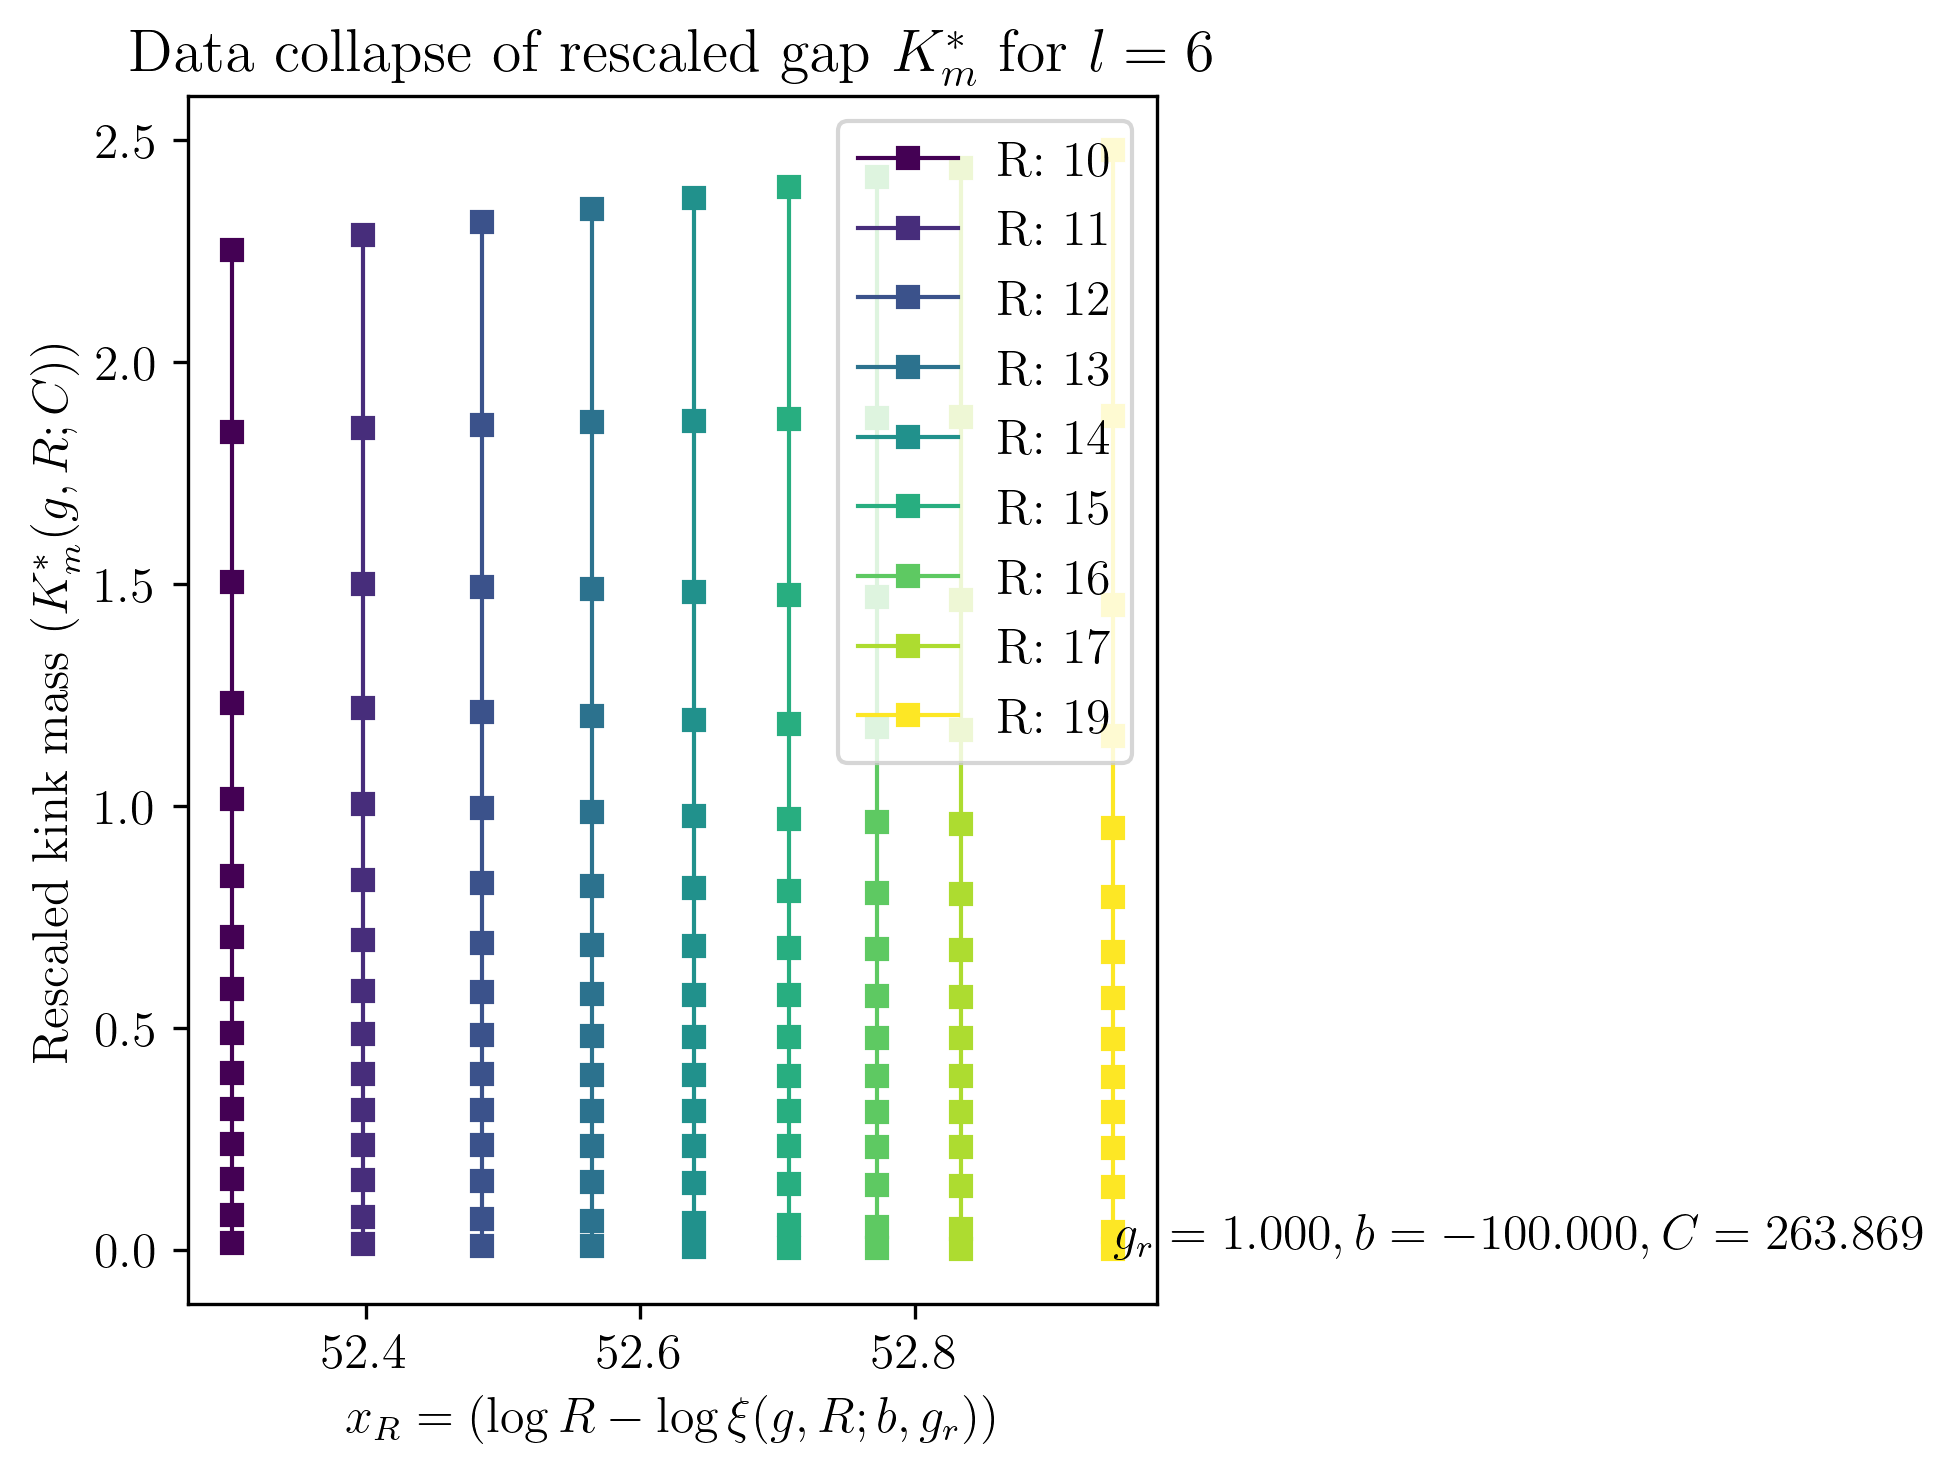

In [319]:
g_r, b, C = best_params
colors = create_sequential_colors(len(R_values))
for i, R in enumerate(R_values):
    x_best = [x_R(g, R, b, g_r) for g in g_values]
    y_best = [delta_rescaled(g, R, C) for g in g_values]
    # y_best = [delta_rescaled_simple(g, R) for g in g_values]
    plt.plot(x_best, y_best, color=colors[i], marker="s", markersize=5, linestyle="-", linewidth=1, label=f"R: {int(R)}")

plt.title(f"Data collapse of rescaled gap $K_m^*$ for $l={l}$")
plt.text(x=x_best[-1], y=min(y_best), s=f"$g_r = {g_r:.3f}, b = {b:.3f}, C = {C:.3f}$")
plt.xlabel("$x_R=(\\log R - \\log \\xi(g,R;b,g_r))$")
plt.ylabel("Rescaled kink mass $(K_m^*(g,R;C))$")
plt.legend()
plt.savefig(f"{path_figures}/figures/fluxtube/rescaled_gap_vs_rescaled_x_opt_z2_dual_{l}x{L}_Rs_{Rs}_h_{h_i}-{h_f}_npoints_{npoints}_chis_{chis}.png")


In [320]:
import numpy as np
from scipy.optimize import minimize

# === Define Constants ===
chis = [64, 128]
bc = "pbc"
sector = "2_particle(s)_sector"
cy = [0, 0]
cy_off_axis = [0, 1]

# l, L = 5, 30
# h_i, h_f, npoints = 0.8, 1.0, 41
# R_values = np.linspace(10, 20, 11)

l, L = 6, 30
h_i, h_f, npoints = 0.6, 0.95, 15
R_values = [10,11,12,13,14,15,16,17,19]

g_values = np.linspace(h_i, h_f, npoints)

R0 = R_values[0]
R1 = R_values[-1]

# === Define Objective Function ===
def objective(params):
    g_r, b, C = params
    # g_r, b = params
    x_data0, x_data1, y_data0, y_data1 = [], [], [], []
    
    for g in g_values:
        x_data0.append(x_R(g, R0, b, g_r, epsilon=1e-6, max_exponent=100))
        x_data1.append(x_R(g, R1, b, g_r, epsilon=1e-6, max_exponent=100))
        # y_data0.append(delta_rescaled_simple(g, R0))
        # y_data1.append(delta_rescaled_simple(g, R1))
        y_data0.append(delta_rescaled(g, R0, C))
        y_data1.append(delta_rescaled(g, R1, C))
    
    x_data0, x_data1 = np.asarray(x_data0), np.asarray(x_data1)
    y_data0, y_data1 = np.asarray(y_data0), np.asarray(y_data1)

    # return distance_numpy(x_data0, y_data0, x_data1, y_data1)
    return area_numpy(x_data0, y_data0, x_data1, y_data1)

# === Define Initial Guess and Bounds ===
initial_guess = [0.9, 0, 5]  # Initial values for g_r, b, C
# initial_guess = [0.9, 0]  # Initial values for g_r, b, C
bounds = [(min(g_values), max(g_values)),  # g_r in the range of g_values
          (-100, 100),  # b within a reasonable range
          (-2*np.log(R0)+1e-3, 10000)]  # C non-negative
# bounds = [(min(g_values), max(g_values)),  # g_r in the range of g_values
#           (0, 100)]


# === Run Minimization ===
result = minimize(objective, initial_guess, method="L-BFGS-B", bounds=bounds)

# === Print Best Parameters ===
print("Optimal Parameters:")
print(f"g_r = {result.x[0]:.5f}, b = {result.x[1]:.5f}, C = {result.x[2]:.5f}")
# print(f"g_r = {result.x[0]:.5f}, b = {result.x[1]:.5f}")
print(f"Minimum Area = {result.fun:.5f}")
best_params = result.x[0], result.x[1], result.x[2]
# best_params = result.x[0], result.x[1]

Optimal Parameters:
g_r = 0.60000, b = 1.53602, C = 136.76456
Minimum Area = 0.13706


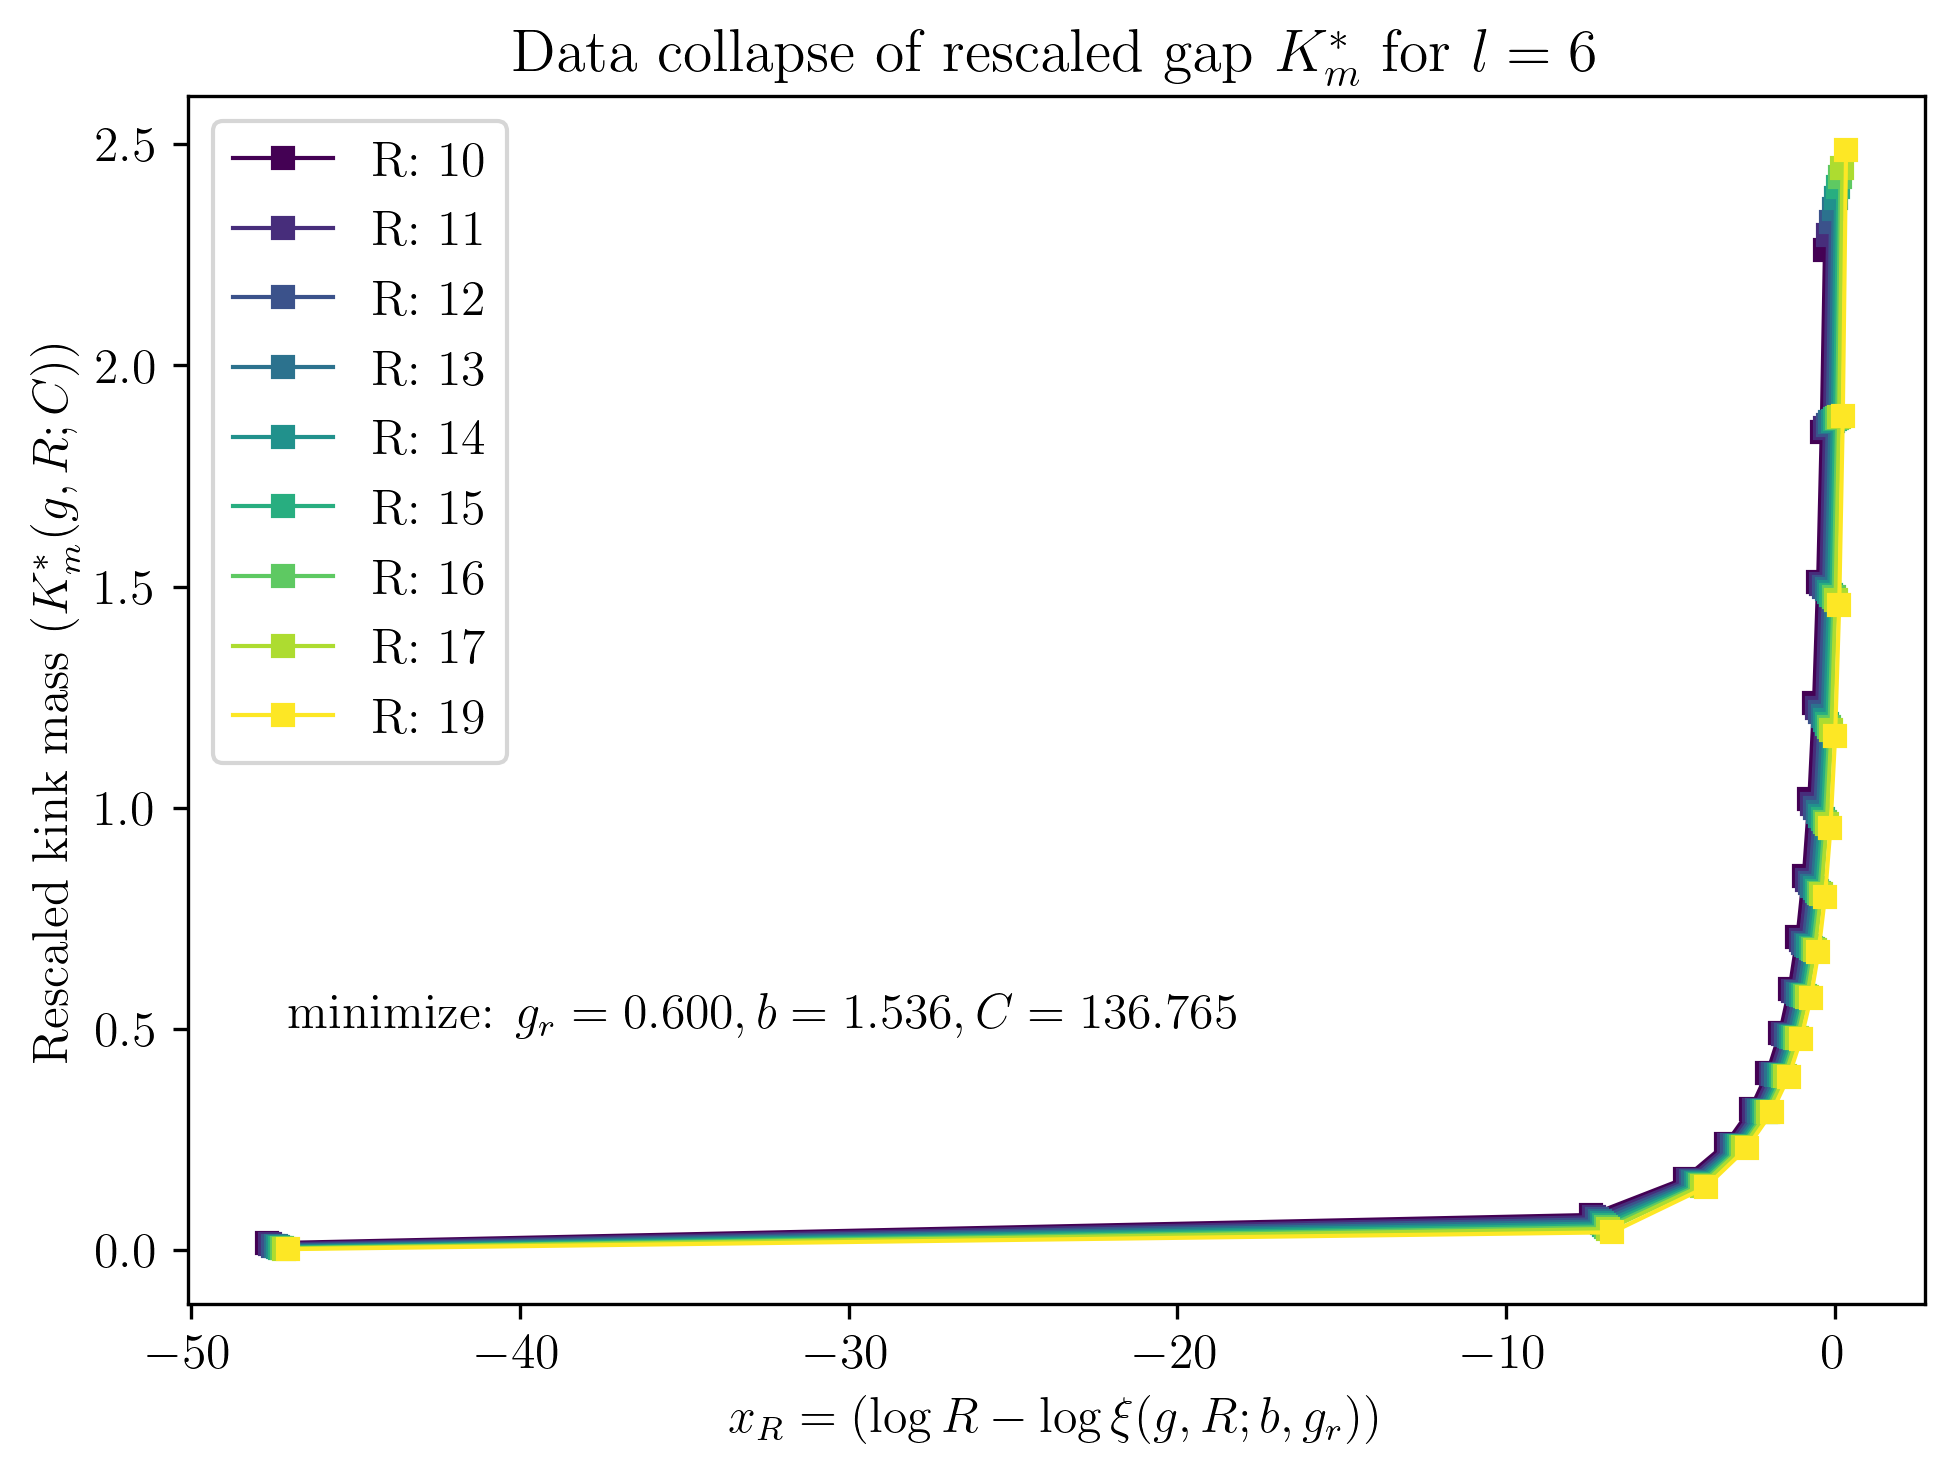

In [323]:
# g_r, b = best_params
g_r, b, C = best_params
colors = create_sequential_colors(len(R_values))
for i, R in enumerate(R_values):
    x_best = [x_R(g, R, b, g_r) for g in g_values]
    # y_best = [delta_rescaled_simple(g, R) for g in g_values]
    y_best = [delta_rescaled(g, R, C) for g in g_values]
    plt.plot(x_best, y_best, color=colors[i], marker="s", markersize=5, linestyle="-", linewidth=1, label=f"R: {int(R)}")

plt.title(f"Data collapse of rescaled gap $K_m^*$ for $l={l}$")
plt.text(x=x_best[0], y=min(y_best)+0.5, s=f"minimize: $g_r = {g_r:.3f}, b = {b:.3f}, C = {C:.3f}$")
plt.xlabel("$x_R=(\\log R - \\log \\xi(g,R;b,g_r))$")
plt.ylabel("Rescaled kink mass $(K_m^*(g,R;C))$")
plt.legend()
plt.savefig(f"{path_figures}/figures/fluxtube/rescaled_gap_vs_rescaled_x_opt_minimize_z2_dual_{l}x{L}_Rs_{Rs}_h_{h_i}-{h_f}_npoints_{npoints}_chis_{chis}.png")
